### **Predicting Suicidality in People Living with HIV in Uganda**

#### *Load the required packages for the analysis*

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
# Set the seaborn style
sns.set_theme(style="whitegrid")

#### *Load the baseline data*

In [2]:
df_hiv =pd.read_stata("../Data/Clinical/baseline.dta")

#check the data structure
df_hiv.shape

(1126, 300)

#### *Load the follow-up data*

In [3]:
df_hiv12 =pd.read_stata("../Data/Clinical/12months.dta")

#data structure
df_hiv12.shape

(1071, 263)

#### *Perform EDA on the baseline data*

##### *Distribution of participants by gender and study site*

In [4]:
sex_count =df_hiv.groupby('studsite')[['sex']].value_counts().unstack(fill_value=0)
print(sex_count)

sex         1    2
studsite          
1         128  437
2         129  432


##### *Distribution of participants by WHO stage and study site*

In [5]:
stage1 =df_hiv.groupby('studsite')[['whostagone']].value_counts().unstack(fill_value=0)
print(stage1)

whostagone  1.0  2.0
studsite            
1           103  441
2            71  487


In [6]:
stage2 =df_hiv.groupby('studsite')[['whostagetwo']].value_counts().unstack(fill_value=0)
print(stage2)

whostagetwo  1.0  2.0
studsite             
1            293  261
2            242  315


In [7]:
stage3 =df_hiv.groupby('studsite')[['whostagethree']].value_counts().unstack(fill_value=0)
print (stage3)

whostagethree  1.0  2.0
studsite               
1               47  516
2               15  543


In [8]:
stage4 =df_hiv.groupby('sex')[['stage4fol']].value_counts().unstack(fill_value=0)
print (stage4)

stage4fol  1.0  2.0
sex                
1            1  249
2            5  830


#### *Features engineering* 

##### *Education attainment*

In [9]:
# rename education attainment categories

df_hiv['educat'] = np.select(
    [
        (df_hiv['educat']== 1),  #informal
        (df_hiv['educat'] == 2),  # primary
        (df_hiv['educat'] == 3), #secondary
        (df_hiv['educat'] ==4), #tertiray
        (pd.isnull(df_hiv['educat']))  # NaN as 'Missing'
    ],
    [
        "none",
        "primary",
        "secondary",
        "tertiary",
        "missing",
    ],
    default=df_hiv['educat']  # Keep other categories unchanged
)

# Display the updated DataFrame
print(df_hiv['educat'].value_counts())


educat
primary      695
secondary    278
none         124
tertiary      26
missing        3
Name: count, dtype: int64


In [10]:
educ= df_hiv.groupby('sex')[['educat']].value_counts().unstack(fill_value=0)
print(educ)

educat  missing  none  primary  secondary  tertiary
sex                                                
1             2    19      165         62         9
2             1   105      530        216        17


##### *Religious affiliation*

In [11]:
#rename and modify religious affiliation categories
df_hiv['religion'] = np.select(
    [
        (df_hiv['religion'].isin([1, 2, 5, 6])),  # Categories 1, 2, 5, 6 as 'Christian'
        (df_hiv['religion'] == 3),  # Category 3 as 'Muslim'
        (df_hiv['religion']. isin([4,7])),  # Category 4 as 'Others'
        (pd.isnull(df_hiv['religion']))  # NaN as 'Missing'
    ],
    [
        "christian",
        "muslim",
        "others",
        "missing",
    ],
    default=df_hiv['religion']  # Keep other categories unchanged
)

print(df_hiv['religion'].value_counts())

religion
christian    942
muslim       167
others        17
Name: count, dtype: int64


In [12]:
rel= df_hiv.groupby('studsite')[['religion']].value_counts().unstack(fill_value=0)
print(rel)

religion  christian  muslim  others
studsite                           
1               480      71      14
2               462      96       3


##### *Marital status*

In [13]:
#rename categories of marital Status
df_hiv['mstatus'] = np.select(
    [
        (df_hiv['mstatus']==1),  #married
        (df_hiv['mstatus']==4), #single
        (df_hiv['mstatus']==2),
        (df_hiv['mstatus']==3),
        (pd.isnull(df_hiv['mstatus']))  # NaN as 'Missing'
    ],
    [
        "married",
        "single",
        "widowed",
        "divorced",
        "missing"
    ],
    default=df_hiv['mstatus']  # Keep other categories unchanged
)

print(df_hiv['mstatus'].value_counts())

mstatus
married     580
divorced    271
widowed     164
single      109
missing       2
Name: count, dtype: int64


In [14]:
marriage= df_hiv.groupby('studsite')[['mstatus']].value_counts().unstack(fill_value=0)
print(marriage)

mstatus   divorced  married  missing  single  widowed
studsite                                             
1              135      304        1      75       50
2              136      276        1      34      114


##### *Employment category*

In [15]:
# rename and modify occupation categories

# Define the conditions for employment categories
conditions = [
    df_hiv['yemploy'].isin([1, 2, 3,4, 5, 6, 7,8,12]),  # employed
    df_hiv['yemploy'].isin([9, 10, 11]),      # Unemployed
    #df_hiv['yemploy'].isin([12]),             # Other employment
    pd.isnull(df_hiv['yemploy'])              # NaN as 'Missing'
]

# Define the corresponding choices
choices = [
    "employed",
    "unemployed",
    "missing"
]

# Use np.select to assign new values based on conditions
df_hiv['yemploy'] = np.select(conditions, choices, default=df_hiv['yemploy'])

# Display the updated DataFrame value counts for 'yemploy'
print(df_hiv['yemploy'].value_counts())


yemploy
employed      970
unemployed    146
missing        10
Name: count, dtype: int64


In [16]:
occupation =df_hiv.groupby('sex')[['yemploy']].value_counts().unstack(fill_value=0)
print(occupation)

yemploy  employed  missing  unemployed
sex                                   
1             250        2           5
2             720        8         141


##### *Visualize the transformed data*

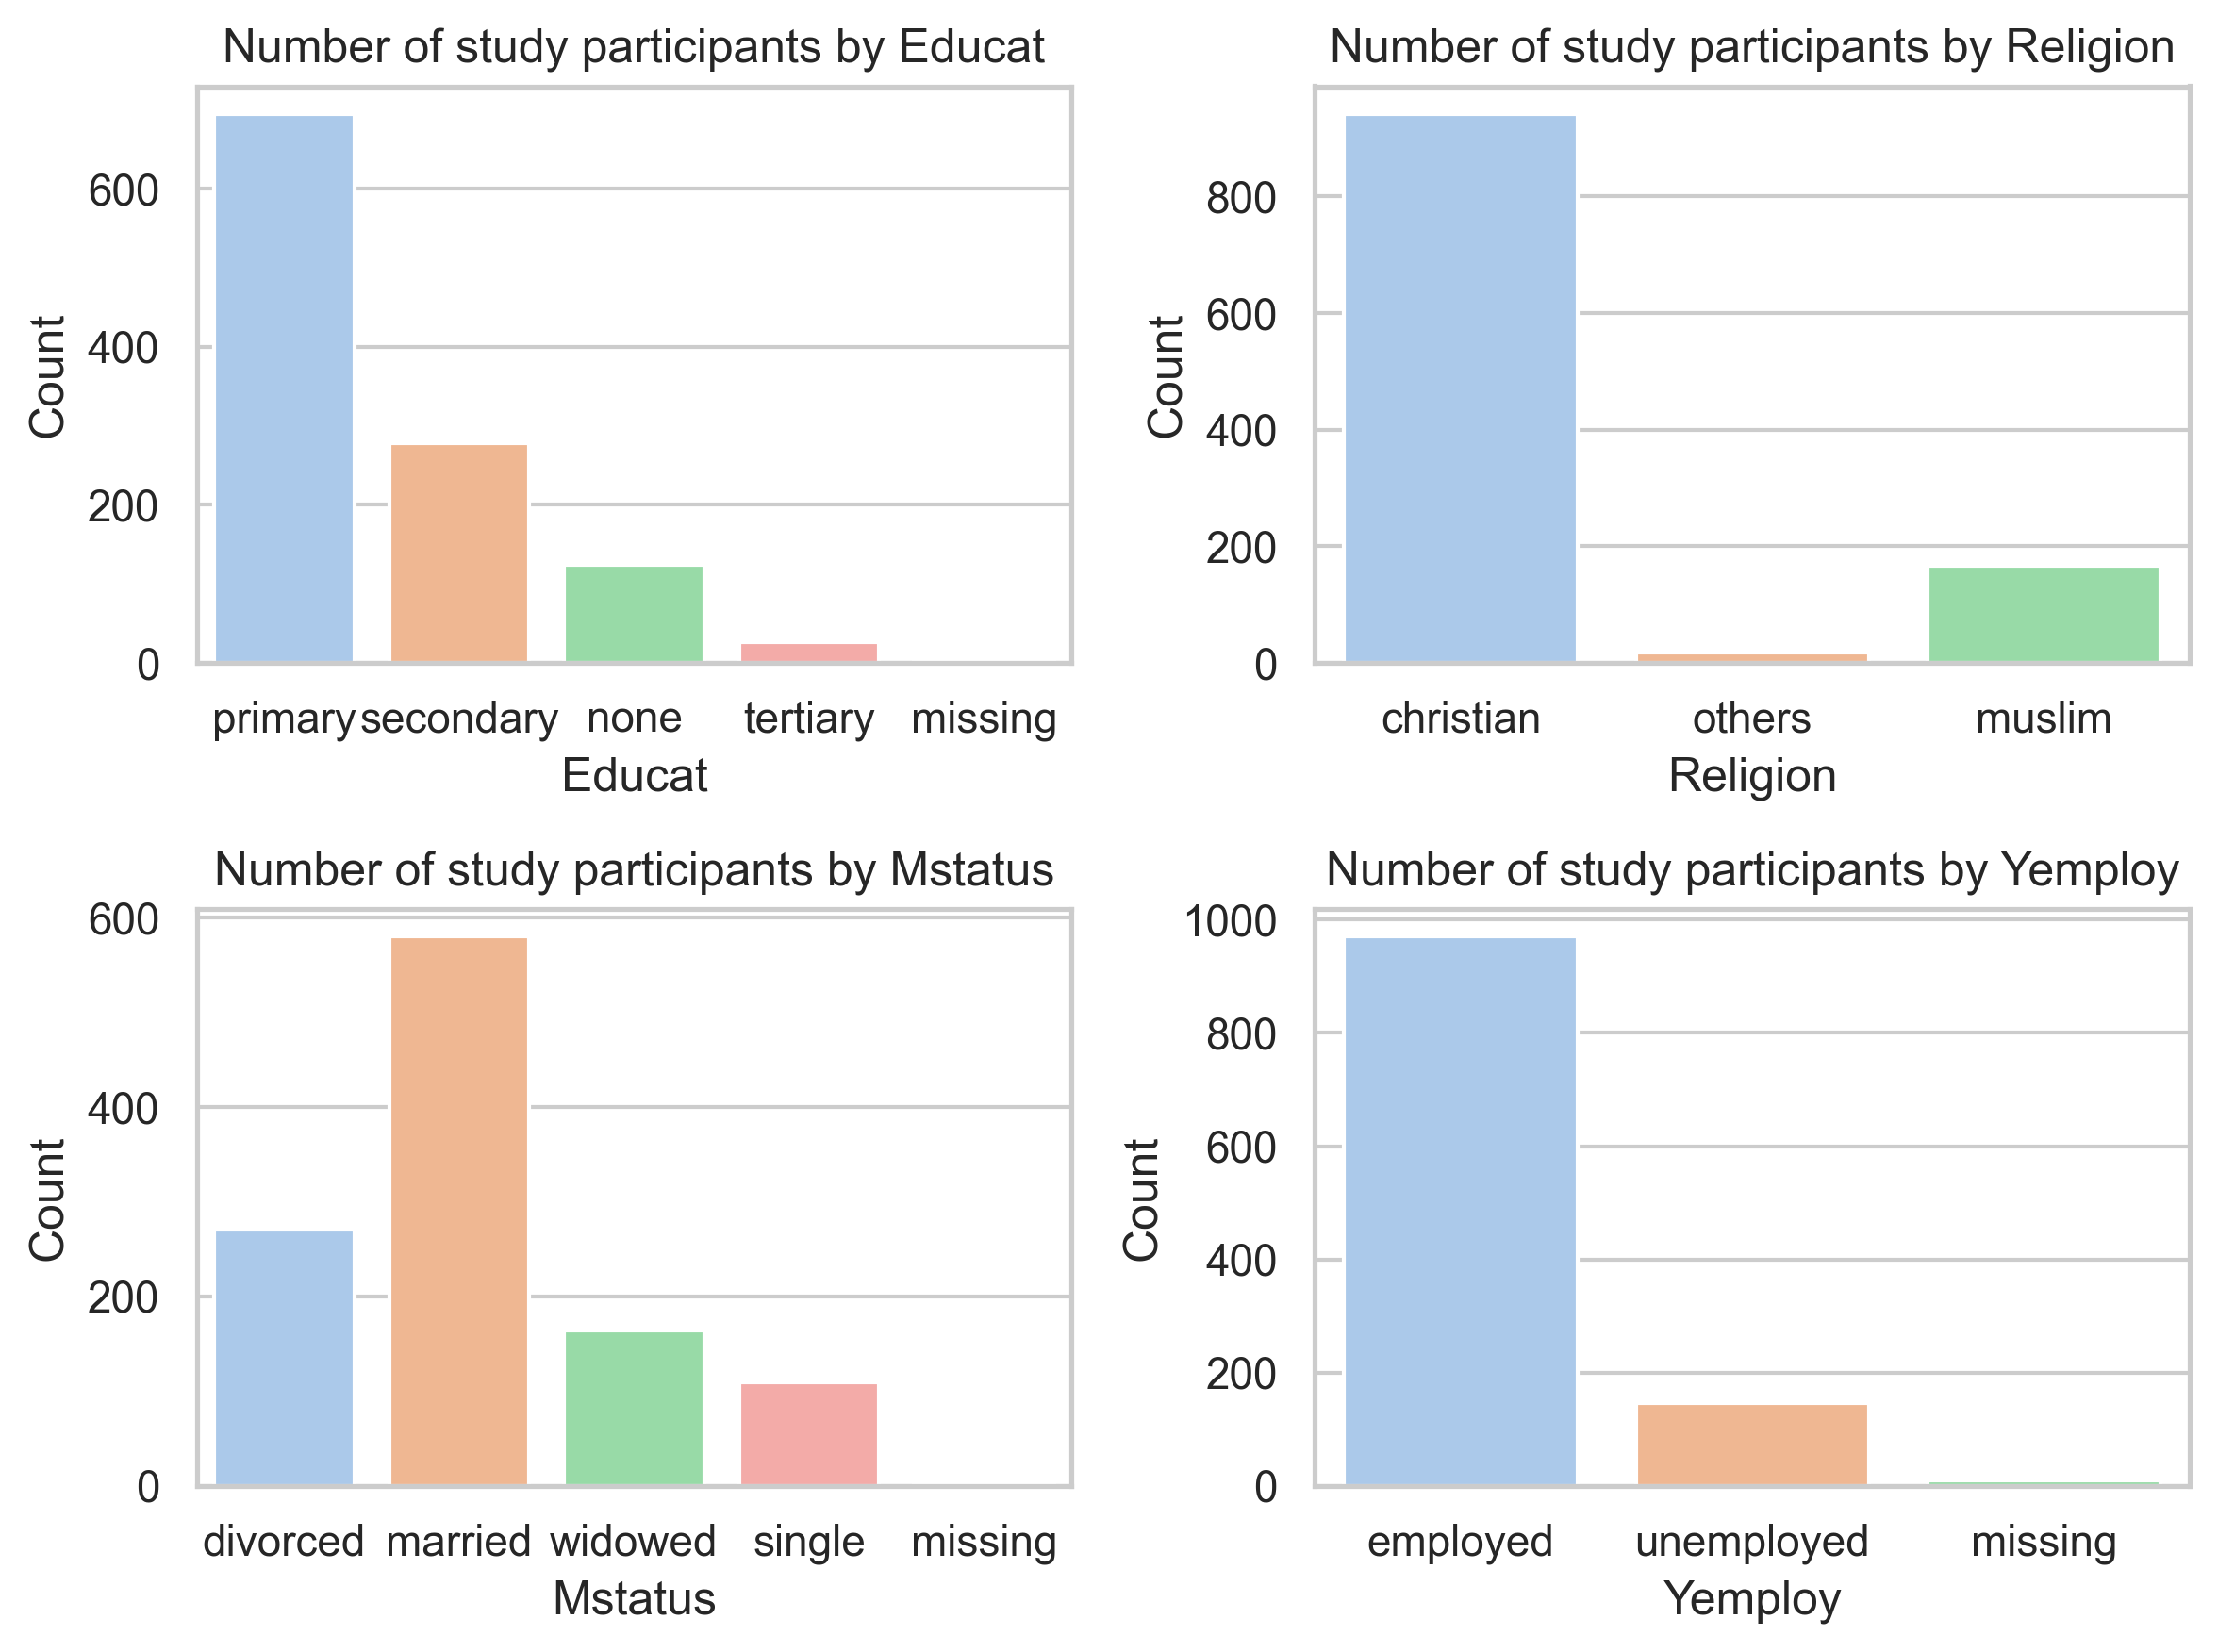

In [17]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

# List of columns with transformed categorical data
socio_data = ['educat', 'religion', 'mstatus', 'yemploy']

# Set the number of columns in the grid
num_cols = 2

# Calculate the number of rows needed
num_rows = math.ceil(len(socio_data) / num_cols)

# Create a subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 6),dpi=300)

# Flatten the axes to iterate through them
axes = axes.flatten()

# Iterate through each categorical column and create count plots
for i, column in enumerate(socio_data):
    sns.countplot(data=df_hiv, x=column, palette='pastel', ax=axes[i])
    axes[i].set_title(f'Number of study participants by {column.capitalize()}')
    axes[i].set_xlabel(column.capitalize())
    axes[i].set_ylabel('Count')

# Remove any unused subplots
for j in range(len(socio_data), num_cols * num_rows):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


In [18]:
gender= df_hiv.groupby('studsite')[['sex']].value_counts().unstack(fill_value=0)
print(gender)

sex         1    2
studsite          
1         128  437
2         129  432


##### *Transform CD46mths*

In [19]:
from scipy.stats import skew, boxcox

from sklearn.preprocessing import StandardScaler

#count number of missing values
df_hiv['cd46mths'].isna().sum()

# drop missing values
dt_cd4= df_hiv['cd46mths'].dropna()

#calculate skewness
skewness = skew(dt_cd4)

# Print the skewness value
print(f"Skewness before: {skewness:.2f}")

# Box-Cox Transformation
dt_cd4_boxcox, _ = boxcox(dt_cd4)  
boxcox_skewness = skew(dt_cd4_boxcox)
print(f"Skewness after: {boxcox_skewness:.2f}")

# Standardize the transformed data to have mean 0 and standard deviation 1
standard_scaler = StandardScaler()
dt_cd4_standardized = standard_scaler.fit_transform(dt_cd4_boxcox.reshape(-1, 1))

# Convert the standardized data to a DataFrame with the desired column name
standardized_df = pd.DataFrame(dt_cd4_standardized, columns=['CD4_6mths'], index=dt_cd4.index)

# Add the standardized data back to the original data frame using pd.concat
df_hiv = pd.concat([df_hiv, standardized_df], axis=1)


Skewness before: 0.92
Skewness after: 0.05


##### *Transform CD4worst*

In [20]:
from scipy.stats import skew, boxcox
from sklearn.preprocessing import StandardScaler

# Count number of missing values
missing_values = df_hiv['cd4worst'].isna().sum()
print(f"Missing values: {missing_values}")

# Drop missing values
dt_cd4w = df_hiv['cd4worst'].dropna()

# Calculate original skewness
skewness = skew(dt_cd4w)
print(f"Original Skewness: {skewness:.2f}")

# Box-Cox Transformation (Note: data must be positive)
dt_cd4w_boxcox, _ = boxcox(dt_cd4w)
boxcox_skewness = skew(dt_cd4w_boxcox)
print(f"Skewness after transformation: {boxcox_skewness:.2f}")

# Standardize the transformed data to have mean 0 and standard deviation 1
standard_scaler = StandardScaler()
dt_cd4w_standardized = standard_scaler.fit_transform(dt_cd4w_boxcox.reshape(-1, 1))

# Convert the standardized data to a DataFrame with the desired column name
# Use the index of dt_cd4w to ensure the correct index is used
standardized_df = pd.DataFrame(dt_cd4w_standardized, columns=['CD4_worst'], index=dt_cd4w.index)

# Add the standardized data back to the original dataframe using pd.concat
df_hiv = pd.concat([df_hiv, standardized_df], axis=1)


Missing values: 80
Original Skewness: 1.03
Skewness after transformation: 0.10


##### *HIV-related dementia*

In [21]:
from sklearn.preprocessing import StandardScaler

# Count the number of missing values
missing_count = df_hiv['dementiasco'].isna().sum()
print(f"Number of missing values: {missing_count}")

# Drop missing values
dt_clean = df_hiv['dementiasco'].dropna()

# Standardize the data to have mean 0 and standard deviation 1
standard_scaler = StandardScaler()
standardized_data = standard_scaler.fit_transform(dt_clean.values.reshape(-1, 1))

# Convert the standardized data into a DataFrame
standardized_df = pd.DataFrame(standardized_data, columns=['HIV_Dementia'], index=dt_clean.index)

# Add the standardized data back to the original dataframe
df_hiv = pd.concat([df_hiv, standardized_df], axis=1)

print(df_hiv[['HIV_Dementia']].head())


Number of missing values: 8
   HIV_Dementia
0     -1.228622
1     -2.188867
2     -2.829031
3     -0.268376
4     -0.268376


##### *Max score (Digit Span Test)/Wechsler Adult Intelligence Scale (WAIS)*.

In [22]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew

# Count number of missing values
missing_values = df_hiv['maxscore'].isna().sum()
print(f"Number of missing values: {missing_values}")

# Drop missing values
dt_max = df_hiv['maxscore'].dropna()

# Calculate skewness
skewness = skew(dt_max)
print(f"Skewness: {skewness:.2f}")

# Standardize the data to have mean 0 and standard deviation 1
standard_scaler = StandardScaler()
max_score = standard_scaler.fit_transform(dt_max.values.reshape(-1, 1))

# Convert the normalized data to a DataFrame
max_score_df = pd.DataFrame(max_score, columns=['WAIS'], index=dt_max.index)


# Reindex to match df_hiv and merge standardized data back into original Df
df_hiv = df_hiv.join(max_score_df, how='left')

print(df_hiv[['WAIS']].head())

Number of missing values: 9
Skewness: 0.45
       WAIS
0 -0.323744
1 -0.936662
2 -0.630203
3  1.208552
4  0.289175


##### *Duration of HIV diagnosis*

In [23]:
df_hiv['hivdate'] = np.select(
    [
        (df_hiv['hivdate']==1),  # <3 months
        (df_hiv['hivdate'] == 2),  #3-6 months
        (df_hiv['hivdate'] == 3), # 6-12 months
        (df_hiv['hivdate'] ==4), #> 12 months
        (pd.isnull(df_hiv['hivdate']))  # NaN as 'Missing'
    ],
    [
        "0-3 months",
        "3-6 months",
        "6-12 months",
        "> 12 months",
        "Missing",
    ],
    default=df_hiv['hivdate']  # Keep other categories unchanged
)

print(df_hiv['hivdate'].value_counts())

hivdate
> 12 months    801
3-6 months     110
0-3 months     105
6-12 months    103
Missing          7
Name: count, dtype: int64


In [24]:
df_hiv['clinictime'] = np.select(
    [
        (df_hiv['clinictime']==1),  # <6 months
        (df_hiv['clinictime'] == 2),  #6-12 months
        (df_hiv['clinictime'] == 3), # >12 months
        (pd.isnull(df_hiv['clinictime']))  # NaN as 'Missing'
    ],
    [
        "0-6 months",
        "6-12 months",
        "> 12 months",
        "Missing",
    ],
    default=df_hiv['clinictime']  # Keep other categories unchanged
)

print(df_hiv['clinictime'].value_counts())

clinictime
> 12 months    736
0-6 months     225
6-12 months    157
Missing          8
Name: count, dtype: int64


##### *Social Economic Status (SES) index*


          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.138        13.77%                     13.77%
1              0.107        10.66%                     24.43%
2              0.091         9.07%                     33.50%
3              0.088         8.84%                     42.34%
4              0.066         6.60%                     48.94%
5              0.062         6.17%                     55.12%
6              0.060         6.00%                     61.12%
7              0.055         5.48%                     66.60%
8              0.052         5.19%                     71.79%
9              0.051         5.12%                     76.91%
10             0.044         4.39%                     81.30%
11             0.039         3.94%                     85.24%
12             0.038         3.83%                     89.07%
13             0.035         3.47%                     92.54%
14      

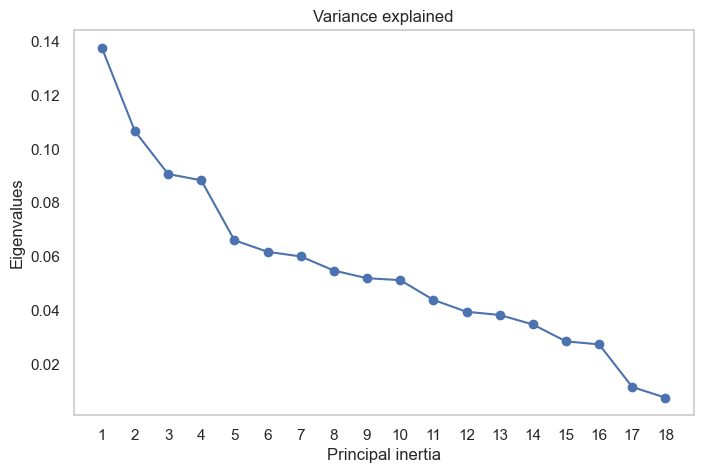

In [25]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import prince

# List of columns with household survey data
hdata = ['rentown', 'hroof', 'hfloor', 'hwall', 'poses1', 'poses2', 'poses3', 'poses4',
        'poses5', 'poses6', 'poses7', 'poses8']

# Create a subset DataFrame containing only the specified columns
df_hdata = df_hiv[hdata]

# Impute missing values with the most frequent value
imputer = SimpleImputer(strategy='most_frequent')
df_data_imputed = pd.DataFrame(imputer.fit_transform(df_hdata), columns=df_hdata.columns)

# Transform categorical variables using one-hot encoding
df_data_encoded = pd.get_dummies(df_data_imputed, columns=df_hdata.columns, drop_first=True)

# Initialize MCA
mca = prince.MCA(
    n_components=18,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)

# Fit MCA on the transformed DataFrame
mca = mca.fit(df_data_encoded)

# Extract eigenvalues
eigenvalues = mca.eigenvalues_
# Generate scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.title('Variance explained')
plt.xlabel('Principal inertia')
plt.ylabel('Eigenvalues')
plt.xticks(range(1, len(eigenvalues) + 1))
plt.grid()

# Print eigenvalues to show variance explained
print(mca.eigenvalues_summary)

##### *Calculate SES*

In [26]:
# Extract the first 8 principal component scores
principal_components = mca.row_coordinates(df_data_encoded).iloc[:, :8]

# Calculate SES scores as the sum of the weighted contributions
weighted_sum = principal_components.mul(eigenvalues[:8], axis=1).sum(axis=1)

# Normalize SES scores
scaler = StandardScaler()
normalized_ses = scaler.fit_transform(weighted_sum.values.reshape(-1, 1)).flatten()

# Concatenate normalized SES scores to the original DataFrame
df_hiv = pd.concat([df_hiv, pd.DataFrame(normalized_ses, columns=['SES'])], axis=1)

# Print the SES index
print(df_hiv[['SES']].head())


        SES
0  0.498305
1 -0.349108
2 -0.281994
3  1.465411
4 -0.854346


##### *Group participants into SES categories*

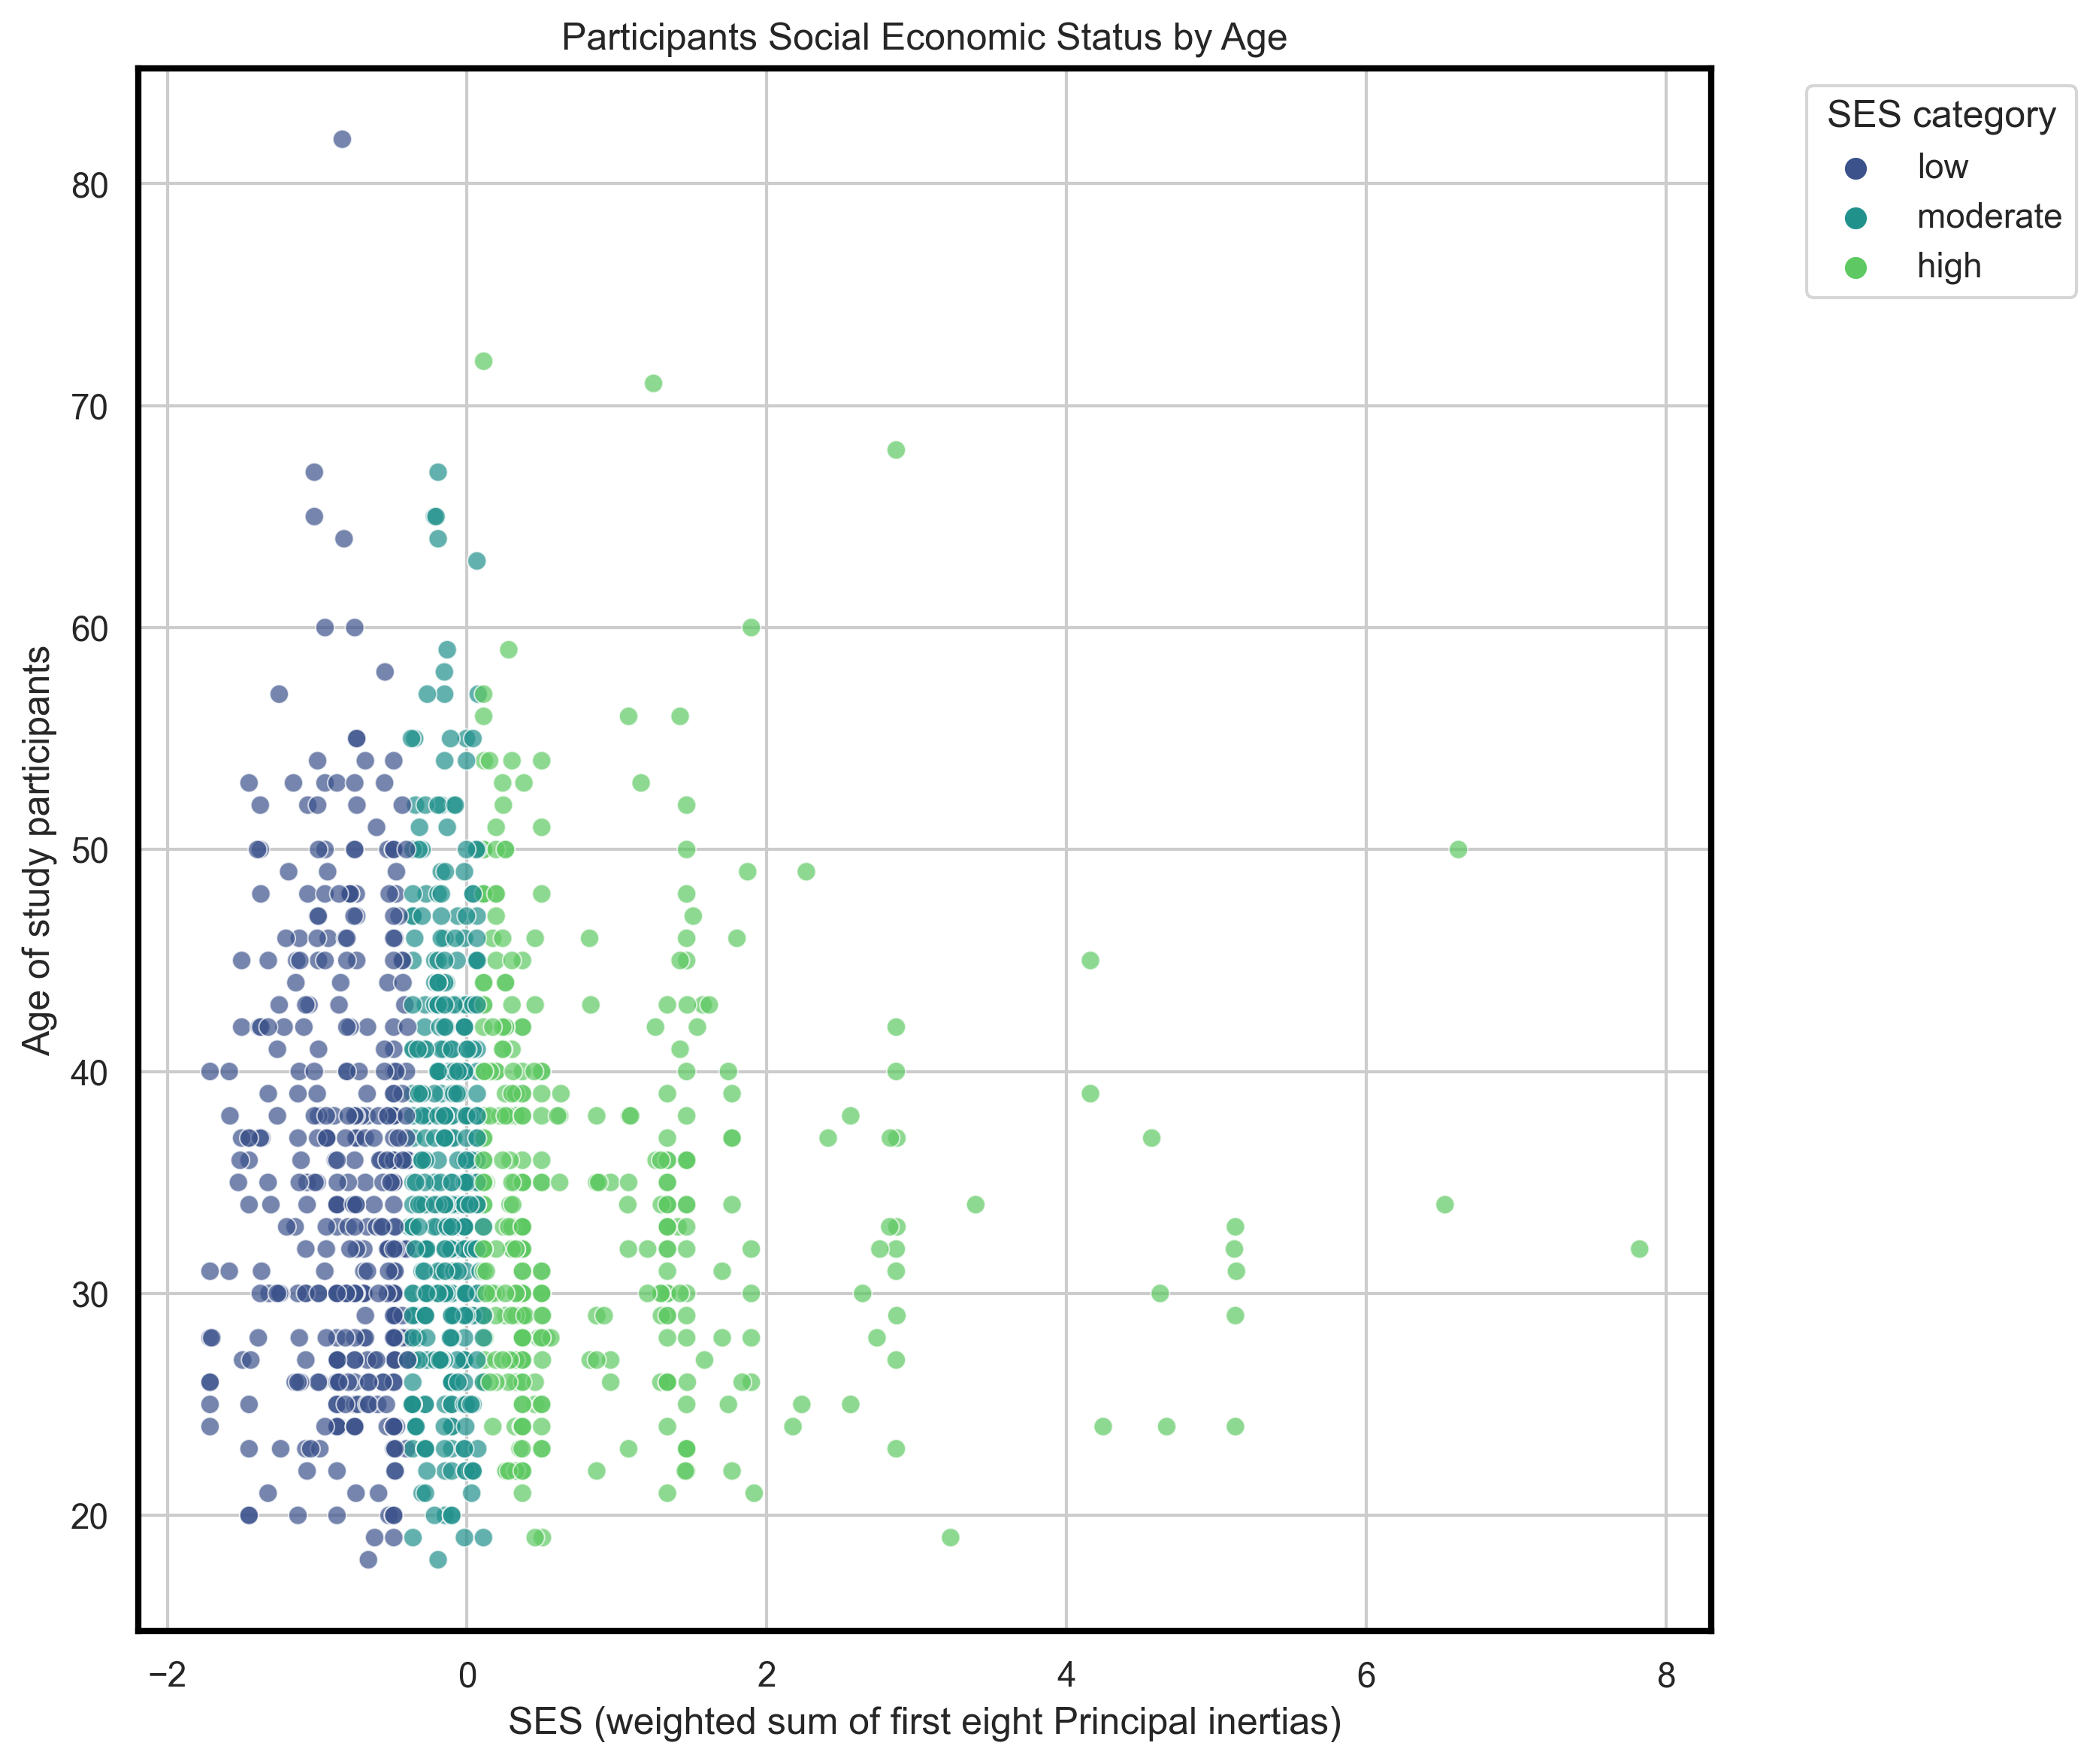

In [27]:
# Assign participants to 'Low', 'Moderate', and 'High'categories
tercile_df = pd.DataFrame({
    'SES': df_hiv['SES'],
    'SES_': pd.qcut(df_hiv['SES'], 3, labels=['low', 'moderate', 'high'])
})

# Concatenate categories to the original data frame
df_hiv = pd.concat([df_hiv, tercile_df[['SES_']]], axis=1)

# Plot SES against age, colored by SES tercile
plt.figure(figsize=(9, 9), dpi=300)
sns.scatterplot(x='SES', y='dobb', hue='SES_', palette='viridis', data=df_hiv, alpha=0.7)

# Customize plot appearance
plt.title('Participants Social Economic Status by Age')
plt.xlabel('SES (weighted sum of first eight Principal inertias)')
plt.ylabel('Age of study participants')
plt.grid(True)
plt.legend(title='SES category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add black frame to the plot
ax = plt.gca()  # Get the current axes
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)  # Adjust the thickness of the frame

# Show the plot
plt.show()


##### *Social impairment*

In [28]:
# Columns to convert to binary
columns_to_convert = ['disrupt', 'healthvisit', 'hospdays']

# Create a copy of the DataFrame for processing
df_hiv_copy = df_hiv.copy()

# Convert the specified columns to binary (0 or 1) in the copy
df_hiv_copy[columns_to_convert] = (df_hiv_copy[columns_to_convert] > 0).astype(int)

# Create the PsycSocImpairment variable by summing the values in the columns
df_hiv_copy['PsycSocImpairment'] = df_hiv_copy[columns_to_convert].sum(axis=1, skipna=True)

# Categorize participants into low, moderate, and high using vectorized operations
df_hiv_copy['impairment'] = pd.cut(
    df_hiv_copy['PsycSocImpairment'], 
    bins=[-1, 0, 1, float('inf')], 
    labels=['low', 'moderate', 'high']
)

# Add the new 'impairment' variable to the original DataFrame using pd.concat
df_hiv = pd.concat([df_hiv, df_hiv_copy['impairment']], axis=1)

print(df_hiv[[ 'impairment']].head())



  impairment
0        low
1       high
2       high
3        low
4        low


##### *Social support*

In [29]:
Soc_col = ['socneed', 'socjoy', 'socreal', 'socemot', 'soccomfo', 'socfriend',
           'socthing', 'socprob', 'socshare', 'soclife', 'socwill', 'soctalk']

# Compute SS_score without modifying the original DataFrame
SocSupport = pd.concat([df_hiv[col].fillna(0) for col in Soc_col], axis=1).sum(axis=1) / len(Soc_col)

# Compute SS_cat without modifying the original DataFrame
SSupport = pd.cut(SocSupport,
               bins=[-float('inf'), 2.9, 5, float('inf')],
               labels=['low','moderate','high'],
               include_lowest=True)

# Concatenate the new Series to the original DataFrame
df_hiv = pd.concat([df_hiv, SocSupport.rename('SocSupport'), SSupport.rename('Support')], axis=1)

##### *Adverse life events in past 6 months*

In [30]:

# List of columns related to negative life events
NE_col = ['father', 'mother', 'parentill', 'parmisunder', 'parneglect', 'brother',
          'sister', 'siblingill', 'siblingmis', 'siblingneg', 'spouse', 'lover',
          'spoloverill', 'spolovmis', 'spolovneg', 'child', 'childill', 'childmis',
          'childcare', 'ill', 'anymis', 'feelneg', 'famprov', 'jobloss', 'discrim',
          'cope', 'moneywor']

# Create a subset DataFrame df_NE containing only the specified columns for negative life events
df_NE = df_hiv[NE_col].copy()

# Calculate the number of negative life events (NE) for each participant by summing across rows where the response is 1
Neg_Events = np.nansum(df_NE.values == 1, axis=1)

# Create a DataFrame to hold the Neg_Events
df_neg_events = pd.DataFrame({'Neg_Events': Neg_Events})

# Define custom cutoff points for categories based on the new grouping criteria
custom_cutoffs_ne = [-1, 4, 9, float('inf')]

# Create categories for study participants based on custom cutoff points
category_labels_ne = ["low", "moderate", "high"]

# Create a temporary DataFrame with the categorized data
df_temp_ne = pd.DataFrame({'Neg_Events': Neg_Events, 'ALE': pd.cut(Neg_Events, bins=custom_cutoffs_ne, labels=category_labels_ne, include_lowest=True)})

# Concatenate the temporary DataFrame to the original DataFrame
df_hiv = pd.concat([df_hiv, df_temp_ne], axis=1)

print("\nThe number of Participants per Category:\n", df_temp_ne['ALE'].value_counts())



The number of Participants per Category:
 ALE
low         642
moderate    346
high        138
Name: count, dtype: int64


##### *Stress from Adverse life events*

In [31]:
# List of columns related to stress
list_b = ['fathst', 'mothst', 'parst', 'parmisst', 'parnegst', 'brost',
          'sisst', 'siblingst', 'sibmisst', 'sibnegst', 'spouset', 'loverst',
          'spolovillst', 'spolovmisst', 'spolovnegst', 'childst', 'childillst',
          'childmisst', 'childcarest', 'illst', 'anymisrelst', 'feelnegst', 'famprovst',
          'joblossst', 'discrimst', 'copest', 'moneyworst']

# Create a subset DataFrame df_b containing only the columns from list_b
df_b = df_hiv[list_b].copy()

# Sum values in each row for selected columns, handling NaN values appropriately
row_sums = np.nansum(df_b.values, axis=1)

# Create a DataFrame to hold the StressScore and avoid fragmentation
df_stress = pd.DataFrame({'StressScore': row_sums})

# Define custom cutoff points for stress categories (3 categories: low, moderate, high)
custom_cutoffs_ssi = [-1, 4, 9, float('inf')]

# Define labels for the stress categories
labels_ssi = ["low", "moderate", "high"]

# Create a new column for stress categories based on custom cutoff points
df_stress['Stress'] = pd.cut(df_stress['StressScore'], bins=custom_cutoffs_ssi, labels=labels_ssi, include_lowest=True)

# Concatenate the new columns back to the original DataFrame
df_hiv = pd.concat([df_hiv, df_stress], axis=1)

# Print the number of participants per category
print("\nNumber of Participants per Category:\n", df_hiv['Stress'].value_counts())



Number of Participants per Category:
 Stress
low         552
moderate    321
high        253
Name: count, dtype: int64


##### *Sheehan's Disability Score (SDS)*

In [32]:
# Create a copy of the DataFrame for processing
df_hiv_copy = df_hiv[['dayslost', 'daysunproductive']].copy()

# Calculate 'Sheehan's Disability Score' as the sum of 'dayslost' and 'daysunproductive'
df_hiv_copy['SDS_'] = df_hiv_copy.sum(axis=1, skipna=True, min_count=1)

# Define custom cutoff points for 'SDS'
custom_cutoffs_sds = [-float('inf'), 6, 12, float('inf')]
labels_sds = ["low", "moderate", "high"]

# Create a new column 'SDS' based on the custom cutoffs
df_hiv_copy['SDS'] = pd.cut(df_hiv_copy['SDS_'], bins=custom_cutoffs_sds, labels=labels_sds, include_lowest=True)

# Concatenate the new columns back to the original DataFrame
df_hiv = pd.concat([df_hiv, df_hiv_copy[['SDS_', 'SDS']]], axis=1)

# Display the first few rows of the relevant columns
print(df_hiv[['SDS_', 'SDS']].head())


   SDS_       SDS
0   0.0       low
1   9.0  moderate
2   6.0       low
3   0.0       low
4   0.0       low


##### *Previous psychiatric diagnosis*

In [33]:
from sklearn.impute import SimpleImputer
import numpy as np

# Replace 2 with 0, keep 1 as is, and convert 3 to NaN
df_hiv['prevpsyc'] = df_hiv['prevpsyc'].replace({2: 0, 3: np.nan})

# Impute missing values (NaN) with the most frequent value
imputer = SimpleImputer(strategy='most_frequent')
df_hiv['prevpsyc'] = imputer.fit_transform(df_hiv[['prevpsyc']])

# Check the result
print(df_hiv['prevpsyc'].value_counts())


prevpsyc
0.0    1044
1.0      82
Name: count, dtype: int64


##### *Baseline MDD diagnosis*

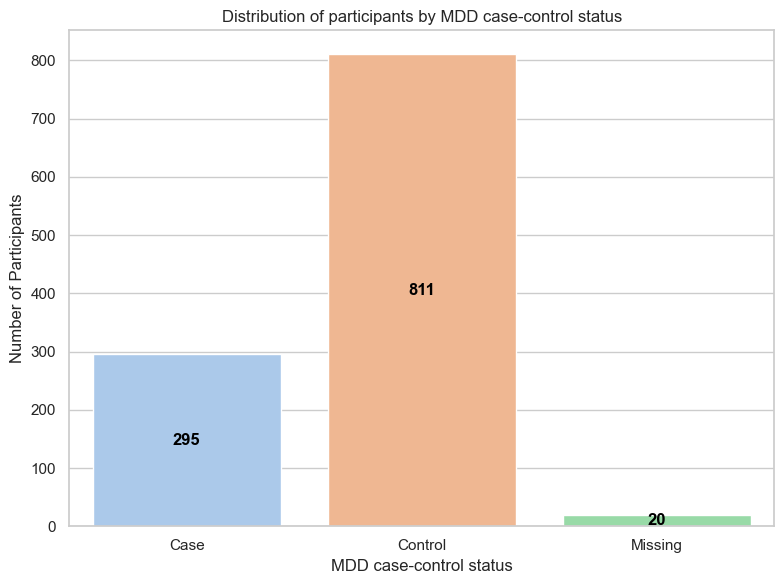

In [34]:
# Rename the 'mddcurdiag' column to 'MDD'
df_hiv = df_hiv.rename(columns={'mddcurdiag': 'MDD'})

# Count the number of participants diagnosed with MDD
mdd_counts = df_hiv['MDD'].value_counts(dropna=False).sort_index()

# Replace NaN with 'Missing' for better labeling
mdd_counts.index = mdd_counts.index.fillna('Missing')
mdd_counts.index = mdd_counts.index.map({1: 'Case', 2: 'Control', 'Missing': 'Missing'})

# Create a bar plot for the MDD diagnosis counts
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=mdd_counts.index, y=mdd_counts.values, palette='pastel')

# Add counts within each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height() / 2.),
                ha='center', va='center',
                color='black', fontsize=12, weight='bold')

plt.xlabel('MDD case-control status')
plt.ylabel('Number of Participants')
plt.title('Distribution of participants by MDD case-control status')

# Show the plot
plt.tight_layout()
plt.show()


##### *MDD*

In [35]:
# Initialize MDD1 column with 'no' (2)
df_hiv['MDD1'] = 2  # Default to 'no'

# Iterate over each row to apply the logic
def process_row(row):
    # If mddlifde (A1a) is no (2), skip to mddaily (A2a)
    if row['mddlifde'] == 2:
        # If mddaily (A2a) is no (2), skip and keep MDD1 as 'no'
        if row['mddaily'] == 2:
            return row
    # If mddlifde (A1a) is yes (1), continue processing
    else:
        pass

    # sum up 'yes' responses in mddlifde, mddaily, mddlifint, and the A3 questions exclude mdinterest from summation
    yes_count = sum(
        row[col] == 1 for col in ['mddlifde', 'mddaily', 'mddlifint', 'mdweight',
                                  'mdsleep', 'mdfidget', 'mdtired', 'mdguilt', 'mddec', 'mdsuic']
    )

    # If 5 or more responses are 'yes' and mdprobs (A4) is 'yes', mark MDD1 as 'yes' (1)
    if yes_count >= 5 and row['mdprobs'] == 1:
        row['MDD1'] = 1

    return row

# Apply the logic to the DataFrame
df_hiv = df_hiv.apply(process_row, axis=1)

# Display only the relevant columns: MDD and MDD1
print(df_hiv[['MDD', 'MDD1']].head())


   MDD  MDD1
0  2.0     2
1  2.0     2
2  2.0     2
3  2.0     2
4  2.0     2


##### *Suicidality diagnosis*


 There are 207 participants with a positive diagnosis of suicidality


C:\Users\Mutema\AppData\Local\Temp\ipykernel_18652\3096163068.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_hiv['mhsdiag'] = np.where(df_hiv[diagnostic].eq(1).any(axis=1), 1, 2)


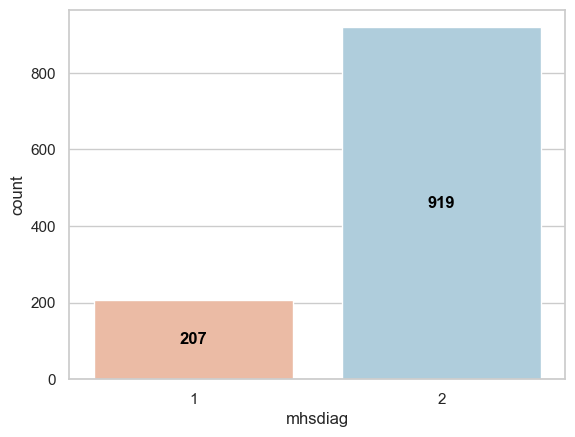

In [36]:
# Select columns for computing severity of suicidality diagnosis
ms_columns = ['msacc', 'mshurt', 'msdie', 'mshope', 'msdead', 'mswharm', 'mssuic', 'msplan',
              'mssteps', 'msharm', 'msattempt', 'msrescue', 'msattdie', 'msattever']

# Select columns for computing suicidality diagnosis
diagnostic = ['mshope', 'msdead', 'mswharm', 'mssuic', 'msplan', 'mssteps', 'msharm',
                      'msattempt', 'msrescue', 'msattdie', 'msattever']

# Set mhsdiag to 1 if any item in sublist_ms_columns is 1, otherwise set it to 2
df_hiv['mhsdiag'] = np.where(df_hiv[diagnostic].eq(1).any(axis=1), 1, 2)

# Count the number of participants with a positive diagnosis of suicidality (mhsdiag=1)
count_mhsdiag = df_hiv['mhsdiag'].eq(1).sum()

print(f"\n There are {count_mhsdiag} participants with a positive diagnosis of suicidality")

ax=sns.countplot(x='mhsdiag', data=df_hiv, palette='RdBu')
# Add counts within each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height() / 2.),
                ha='center', va='center',
                color='black', fontsize=12, weight='bold')


##### *Suicidality severity*


There are 207 participants with a positive diagnosis of suicidality


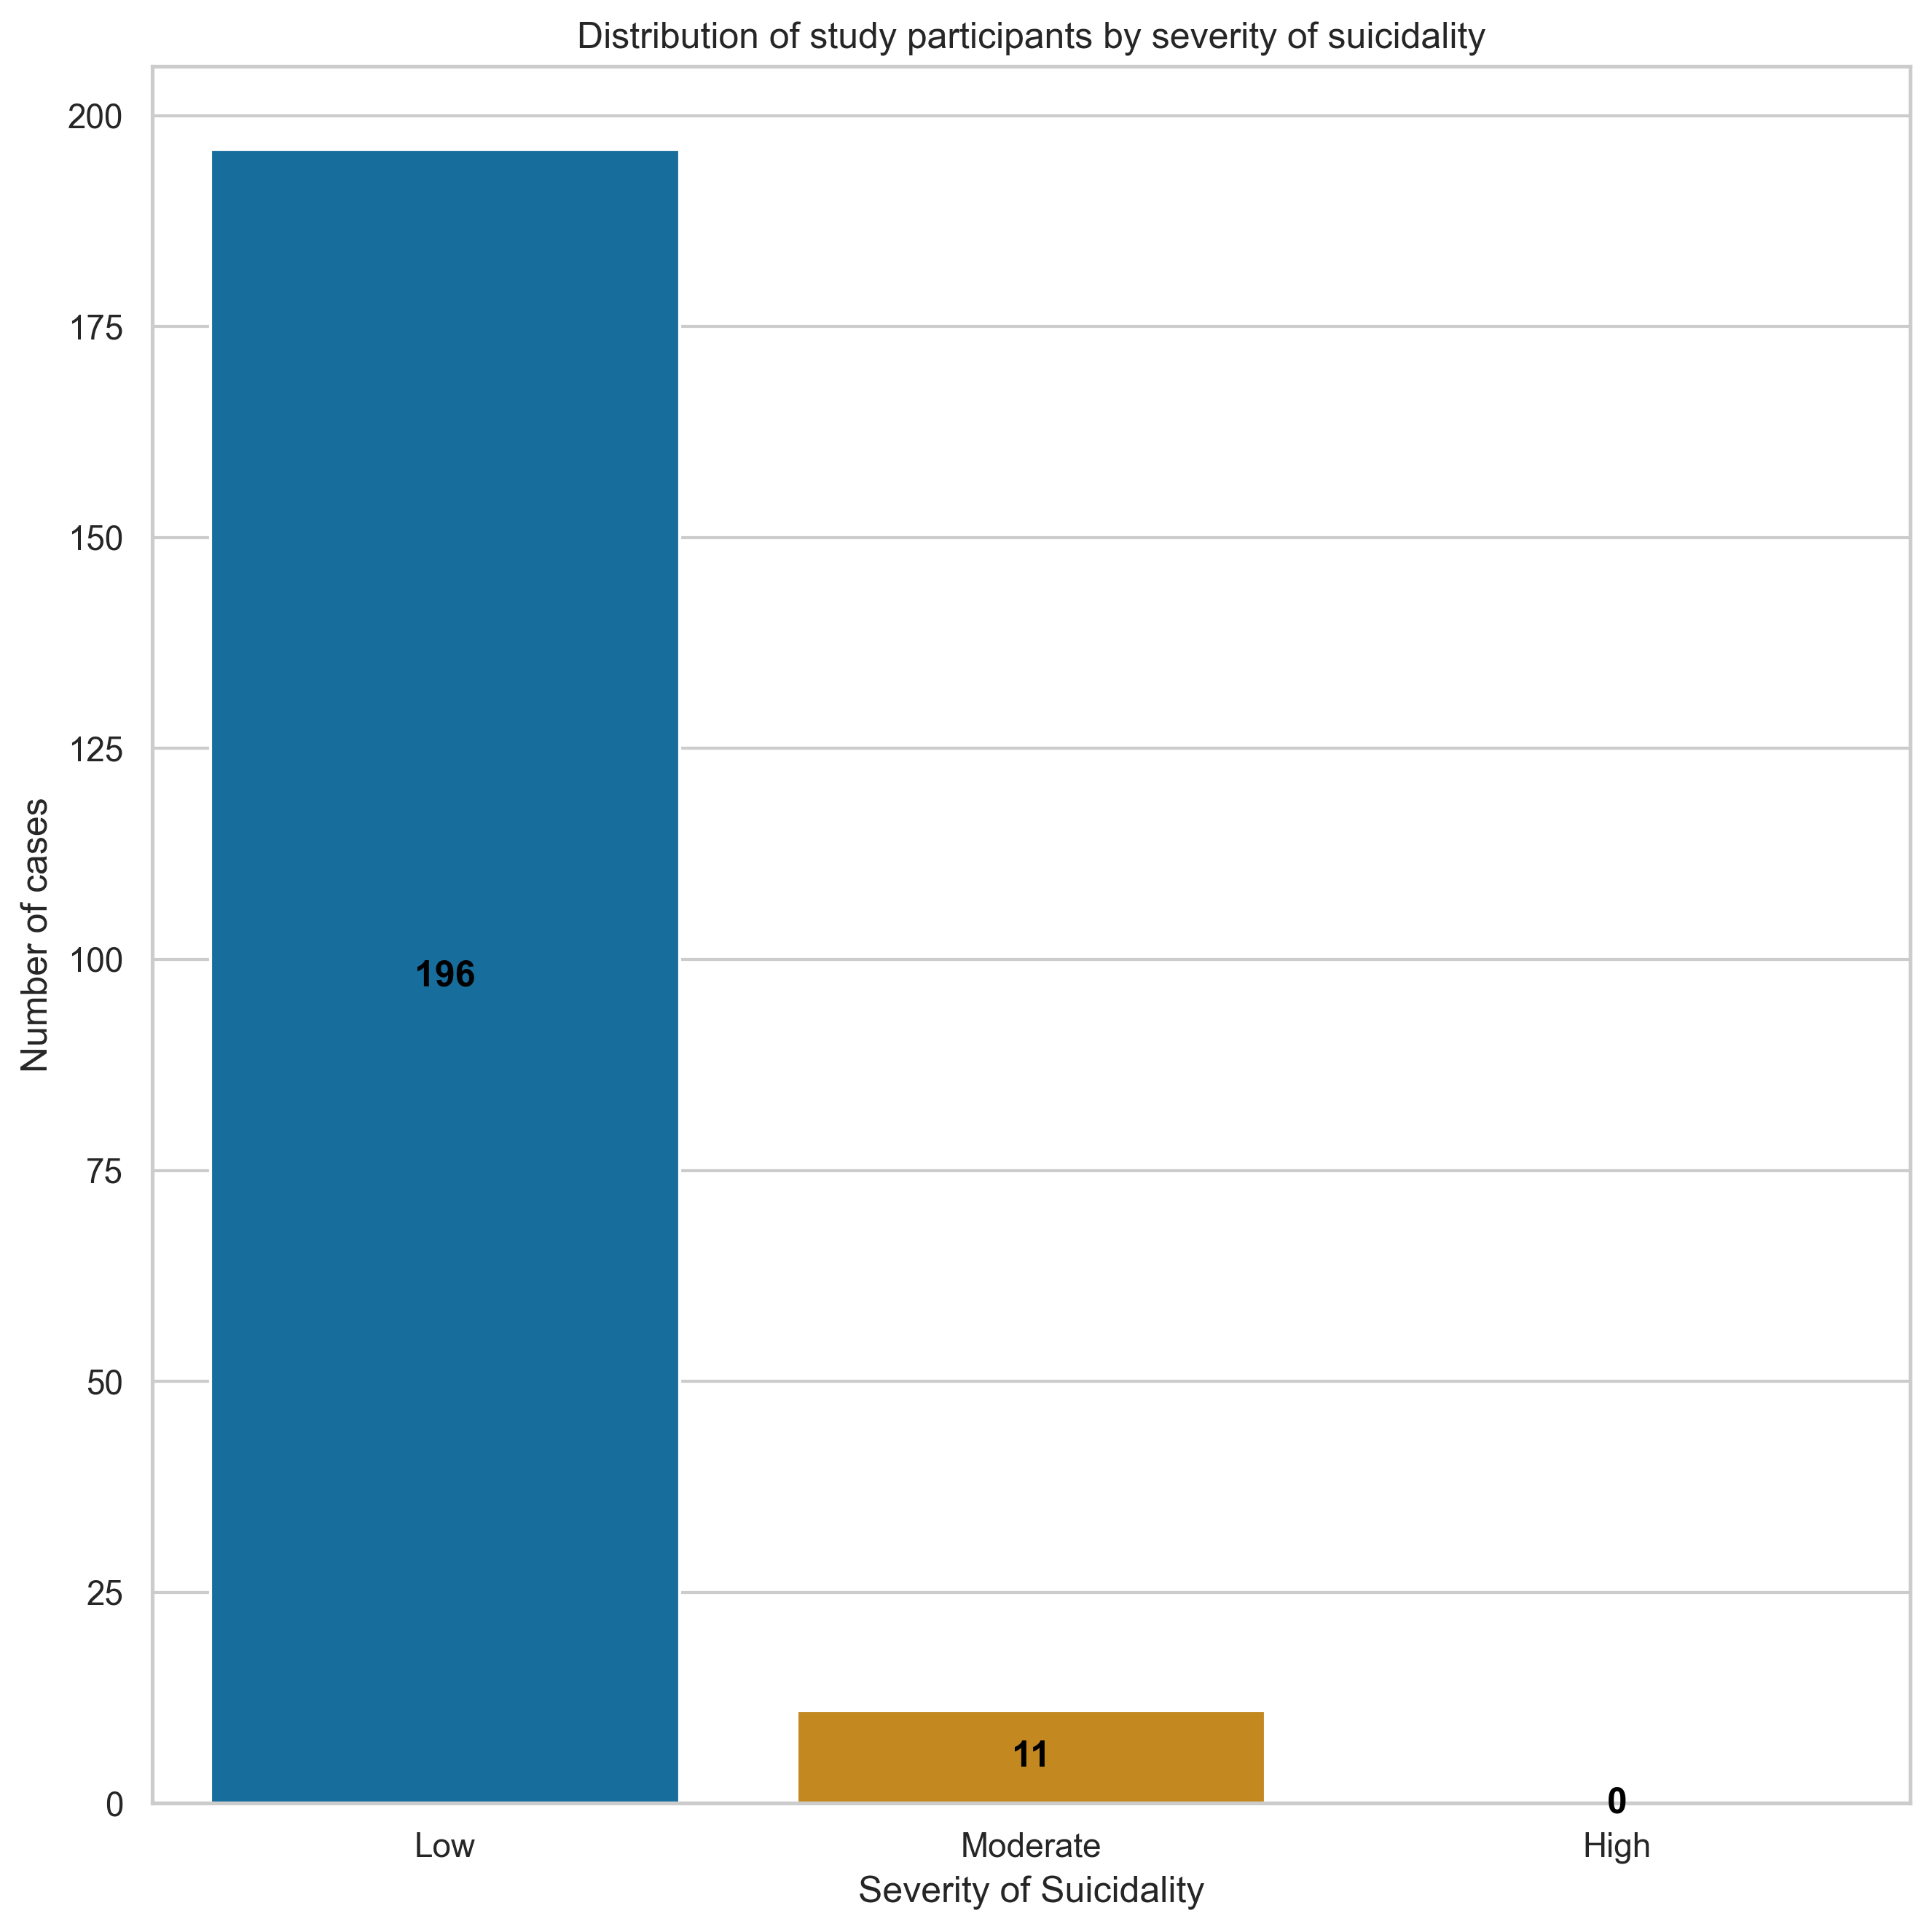

In [37]:
# Select columns for computing severity of suicidality diagnosis
ms_columns = ['msacc', 'mshurt', 'msdie', 'mshope', 'msdead', 'mswharm', 'mssuic', 'msplan',
              'mssteps', 'msharm', 'msattempt', 'msrescue', 'msattdie', 'msattever']

# Select columns for computing suicidality diagnosis
sublist_ms_columns = ['mshope', 'msdead', 'mswharm', 'mssuic', 'msplan', 'mssteps', 'msharm',
                      'msattempt', 'msrescue', 'msattdie', 'msattever']

# Set mhsdiag to 1 if any item in sublist_ms_columns is 1, otherwise set it to 2
df_hiv['mhsdiag'] = np.where(df_hiv[sublist_ms_columns].eq(1).any(axis=1), 1, 2)

# Count the number of participants with a positive diagnosis of suicidality (mhsdiag=1)
count_mhsdiag = df_hiv['mhsdiag'].eq(1).sum()

print(f"\nThere are {count_mhsdiag} participants with a positive diagnosis of suicidality")

# Function to compute severity and categorize if mhsdiag is equal to 1
def compute_mhsseverity(df, ms_columns, mhsdiag_column):
    df_temp = pd.DataFrame(index=df.index)
    if mhsdiag_column in df.columns:
        # Calculate severity for participants with mhsdiag == 1
        df_temp['mhsseverity'] = df.loc[df[mhsdiag_column] == 1, ms_columns].eq(1).sum(axis=1)
        df_temp['mhsseverity'] = df_temp['mhsseverity'].fillna(0)
        
        # Define cutoffs for severity categories
        severity_cutoffs = [1, 8, 16, float('inf')]
        df_temp['mhs_cat1'] = pd.cut(df_temp['mhsseverity'], bins=severity_cutoffs, labels=['Low', 'Moderate', 'High'], include_lowest=True)
    return df_temp

# Apply function to compute severity
df_severity = compute_mhsseverity(df_hiv, ms_columns, 'mhsdiag')

# Concatenate the temporary DataFrame to the original DataFrame
df_hiv = pd.concat([df_hiv, df_severity], axis=1)

# Plot the countplot for the suicidality severity categories
plt.figure(figsize=(9, 9), dpi=300)
ax2 = sns.countplot(x='mhs_cat1', data=df_hiv, palette='colorblind', order=[ 'Low', 'Moderate', 'High'])

# Add counts within each bar
for p in ax2.patches:
    ax2.annotate(format(p.get_height(), '.0f'),
                 (p.get_x() + p.get_width() / 2., p.get_height() / 2.),
                 ha='center', va='center',
                 color='black', fontsize=12, weight='bold')

# Modify x-axis labels and title
ax2.set_xlabel('Severity of Suicidality')
ax2.set_ylabel('Number of cases')
ax2.set_title('Distribution of study participants by severity of suicidality')

# Show plot
plt.tight_layout()
plt.show()


In [38]:
# Count the number of occurrences of MDD and MDD1 per site
mdd_counts = df_hiv.groupby('studsite')[['MDD','msdiag', 'MDD1','mhsdiag']].apply(lambda x: (x == 1).sum())

# Rename columns for clarity
mdd_counts.columns = ['MDD','msdiag', 'MDD1','mhsdiag']

# Display the counts per site
print(mdd_counts)


          MDD  msdiag  MDD1  mhsdiag
studsite                            
1         103      44    56      105
2         192      92   120      102


##### *Age*

In [39]:
# Generate descriptive statistics for age
Age = df_hiv['dobb'].describe()
print("\nDescriptive Statistics:\n", Age)


Descriptive Statistics:
 count    1121.000000
mean       35.160571
std         9.272612
min        18.000000
25%        28.000000
50%        34.000000
75%        40.000000
max        82.000000
Name: dobb, dtype: float64


In [40]:
min_age = df_hiv['dobb'].min()
max_age = df_hiv['dobb'].max()

# Create bin edges with a 10-year interval
bin_edges = list(range(int(min_age), int(max_age) + 10, 10))

# Define bin labels for 10-year intervals
bin_labels = [f'{i}-{i+9}' for i in bin_edges[:-1]]

# Bin the data and create a new DataFrame with the binned data
df_filtered = df_hiv[['dobb']].copy()
df_filtered['Age-group'] = pd.cut(df_filtered['dobb'], bins=bin_edges, include_lowest=True, labels=bin_labels)

# Concatenate the binned data back to the original DataFrame
df_hiv = pd.concat([df_hiv, df_filtered[['Age-group']]], axis=1)

# Display the counts of each bin
print(df_hiv['Age-group'].value_counts())


Age-group
28-37    493
18-27    285
38-47    241
48-57     85
58-67     14
68-77      2
78-87      1
Name: count, dtype: int64


##### *Identify and exclude outliers*

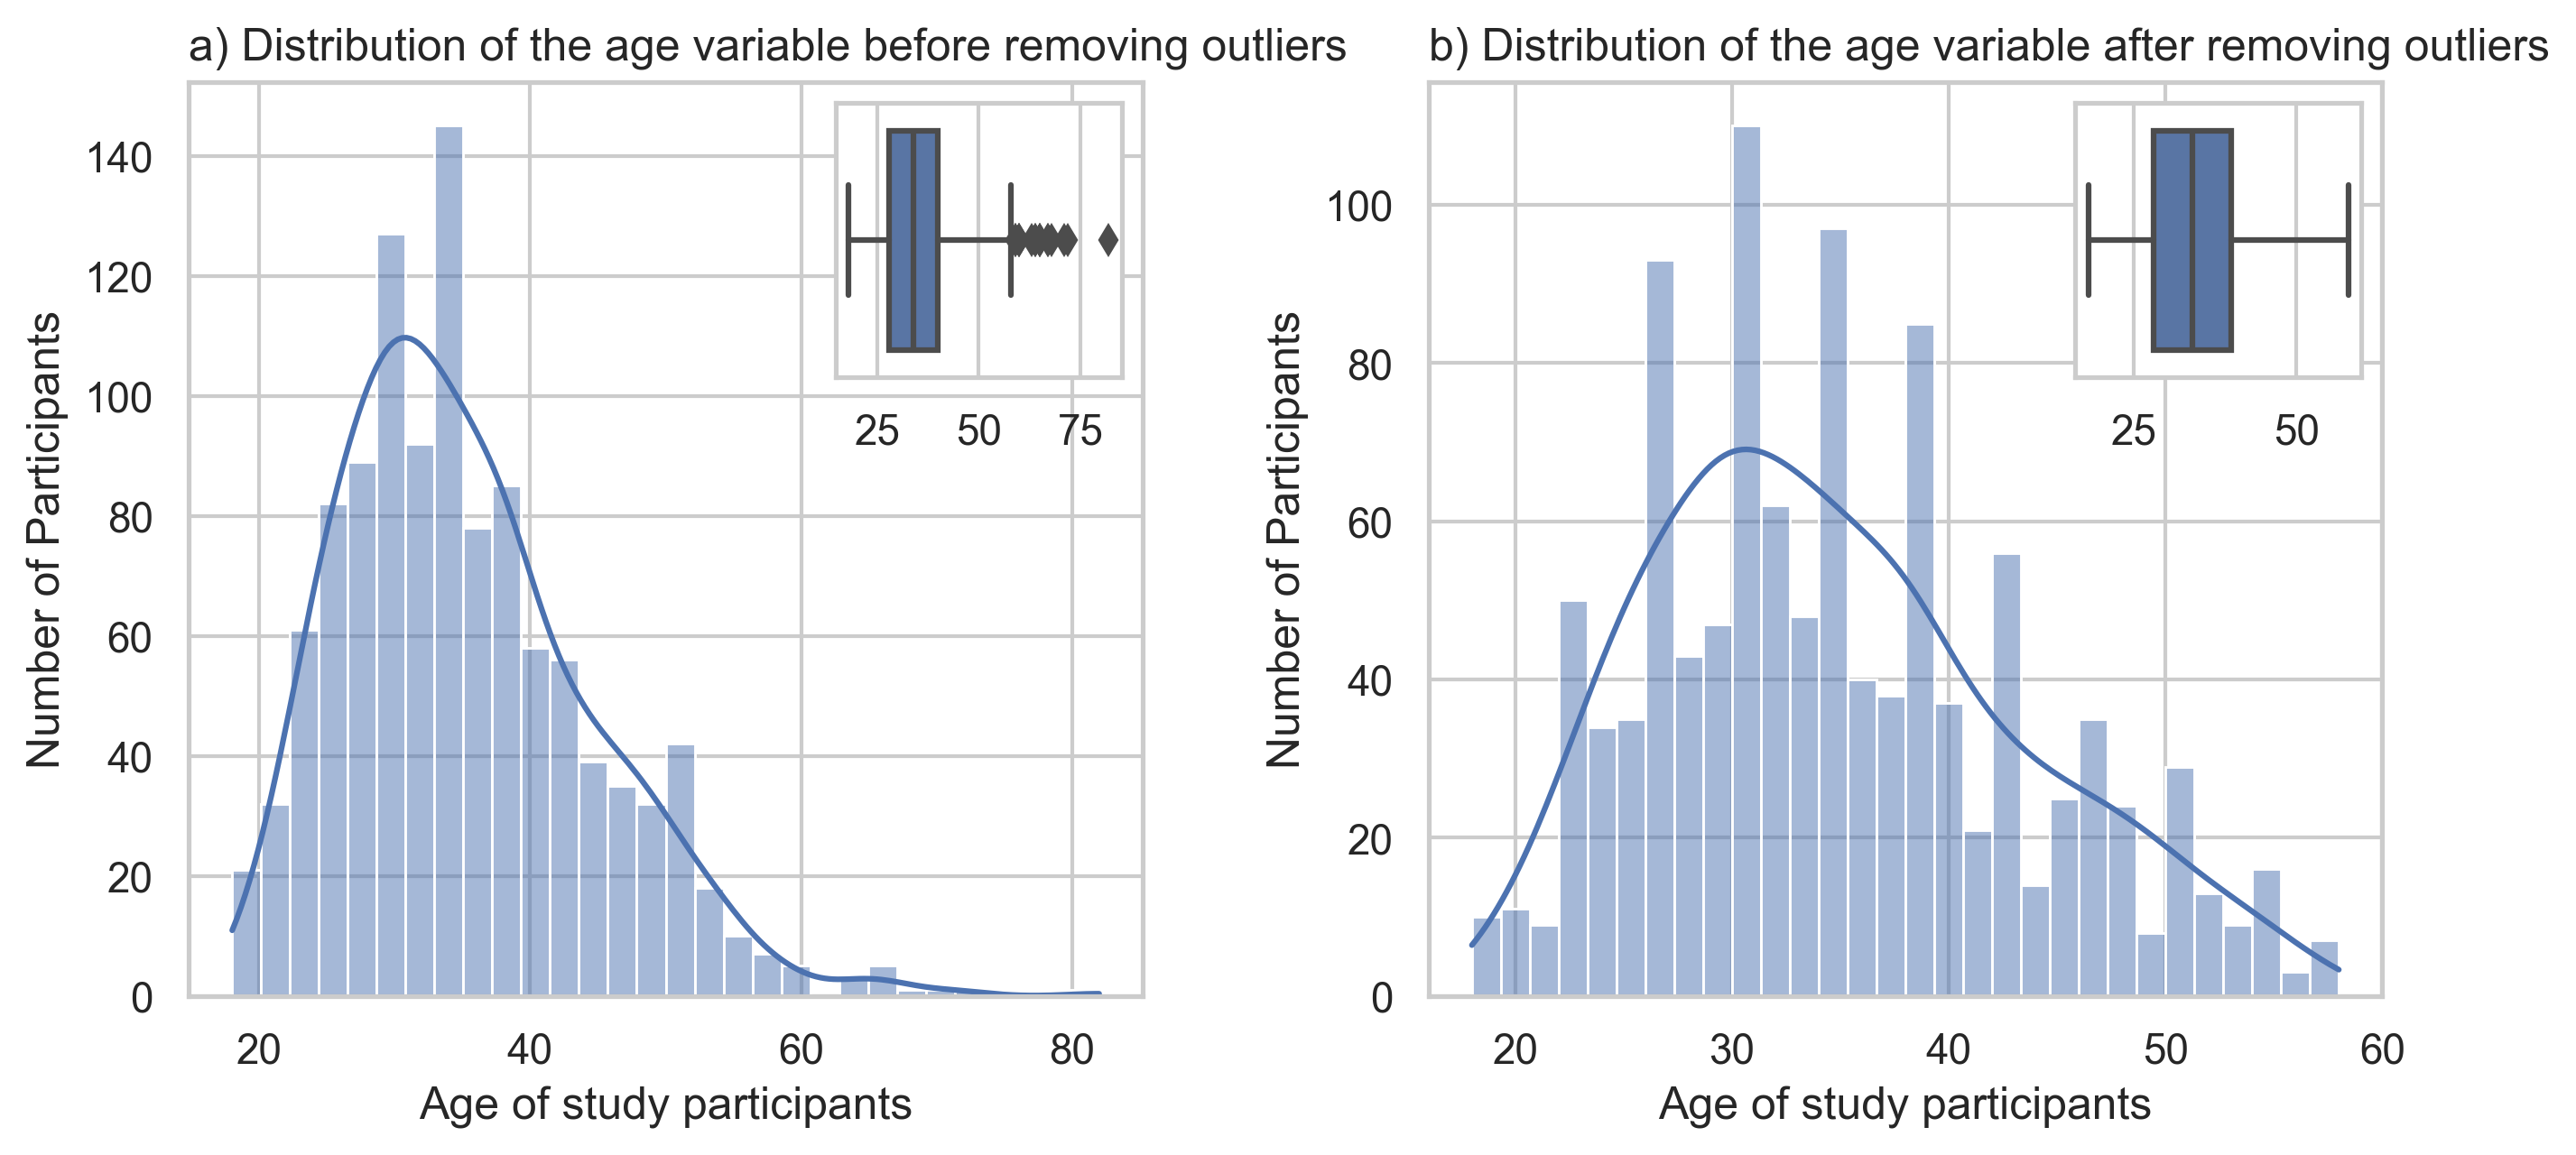

In [41]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import matplotlib.pyplot as plt

# Assign the median age to participants with missing 'dobb'
median_age = df_hiv['dobb'].median()
df_hiv['dobb'].fillna(median_age, inplace=True)

# Plotting
plt.figure(figsize=(9, 9), dpi=300)

# Subplot 1: Histogram before removing outliers with inset boxplot
plt.subplot(2, 2, 1)
sns.histplot(data=df_hiv, x='dobb', kde=True, bins=30, fill=True)
plt.title('a) Distribution of the age variable before removing outliers', loc='left', fontsize=12)
plt.xlabel('Age of study participants')
plt.ylabel('Number of Participants')

# Inset for boxplot
ax_inset1 = inset_axes(plt.gca(), width="30%", height="30%", loc='upper right')
sns.boxplot(data=df_hiv, x='dobb', ax=ax_inset1)
ax_inset1.set_xlabel('')
ax_inset1.set_ylabel('')

# Removing outliers using IQR method
Q1 = df_hiv['dobb'].quantile(0.25)
Q3 = df_hiv['dobb'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Select only participants within the inter-quartile range
df_hiv1 = df_hiv[(df_hiv['dobb'] >= lower_bound) & (df_hiv['dobb'] <= upper_bound)]

# Subplot 2: Histogram after removing outliers with inset boxplot
plt.subplot(2, 2, 2)
sns.histplot(data=df_hiv1, x='dobb', kde=True, bins=30, fill=True)
plt.title('b) Distribution of the age variable after removing outliers', loc='left', fontsize=12)
plt.xlabel('Age of study participants')
plt.ylabel('Number of Participants')

# Inset for boxplot after removing outliers
ax_inset2 = inset_axes(plt.gca(), width="30%", height="30%", loc='upper right')
sns.boxplot(data=df_hiv1, x='dobb', ax=ax_inset2)
ax_inset2.set_xlabel('')
ax_inset2.set_ylabel('')

# Adjust the layout to avoid overlapping
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.4, wspace=0.3)

# Show the plot
plt.show()


##### *Convert age to categorical variables*

In [42]:
min_age = df_hiv1['dobb'].min()
max_age = df_hiv1['dobb'].max()

# Create bin edges with a 10-year interval
bin_edges = list(range(int(min_age), int(max_age) + 10, 10))

# Define bin labels for 10-year intervals
bin_labels = [f'{i}-{i+9}' for i in bin_edges[:-1]]

# Bin the data and create a new DataFrame with the binned data
df_filtered = df_hiv1[['dobb']].copy()
df_filtered['Age_group'] = pd.cut(df_filtered['dobb'], bins=bin_edges, include_lowest=True, labels=bin_labels)

# Concatenate the binned data back to the original DataFrame
df_hiv1 = pd.concat([df_hiv1, df_filtered[['Age_group']]], axis=1)

# Display the counts of each bin
print(df_hiv1['Age_group'].value_counts())


Age_group
28-37    498
18-27    285
38-47    241
48-57     85
Name: count, dtype: int64


In [43]:
mhs =df_hiv1.groupby('studsite')[['msdiag']].value_counts().unstack(fill_value=0)
print(mhs)

msdiag    1.0  2.0
studsite          
1          44  497
2          91  455


In [44]:
mhs1 =df_hiv1.groupby('studsite')[['mhsdiag']].value_counts().unstack(fill_value=0)
print(mhs1)

mhsdiag     1    2
studsite          
1         104  455
2         101  449


In [45]:
education = df_hiv1.groupby('educat').size()
print(education)

educat
missing        3
none         120
primary      685
secondary    275
tertiary      26
dtype: int64


#### *Features selection* 

In [46]:
from tabulate import tabulate

# List of continuous variables and outcome
num_var = ['dobb', 'CD4_worst', 'CD4_6mths', 'HIV_Dementia', 'WAIS', 'SES', 'SocSupport',
           'Neg_Events', 'StressScore', 'SDS_', 'mhsdiag']

# Select and copy relevant columns
df_corr = df_hiv1[num_var].copy()

# Impute missing values with the median
df_corr.fillna(df_corr.median(), inplace=True)

# Apply log transformation to non-negative values (excluding 'mhsdiag')
for var in num_var[:-1]:  # Exclude 'mhsdiag'
    df_corr[var] = np.log1p(df_corr[var].clip(lower=0))  # Clip ensures values are non-negative

# Calculate correlations with 'mhsdiag' and store results
correlation_results = [
    [var, round(df_corr[var].corr(df_corr['mhsdiag']), 2)] for var in num_var[:-1]
]

# Sort results by correlation in descending order
correlation_results.sort(key=lambda x: x[1], reverse=True)

# Print the correlation table
print(tabulate(correlation_results, headers=["Variable", "Correlation with mhsdiag"], tablefmt="pretty"))


+--------------+--------------------------+
|   Variable   | Correlation with mhsdiag |
+--------------+--------------------------+
|  SocSupport  |           0.11           |
| HIV_Dementia |           0.1            |
|     SES      |           0.07           |
|     WAIS     |           0.05           |
|     dobb     |           0.04           |
|  CD4_worst   |           0.02           |
|  CD4_6mths   |           -0.0           |
|     SDS_     |           -0.1           |
|  Neg_Events  |          -0.24           |
| StressScore  |          -0.25           |
+--------------+--------------------------+


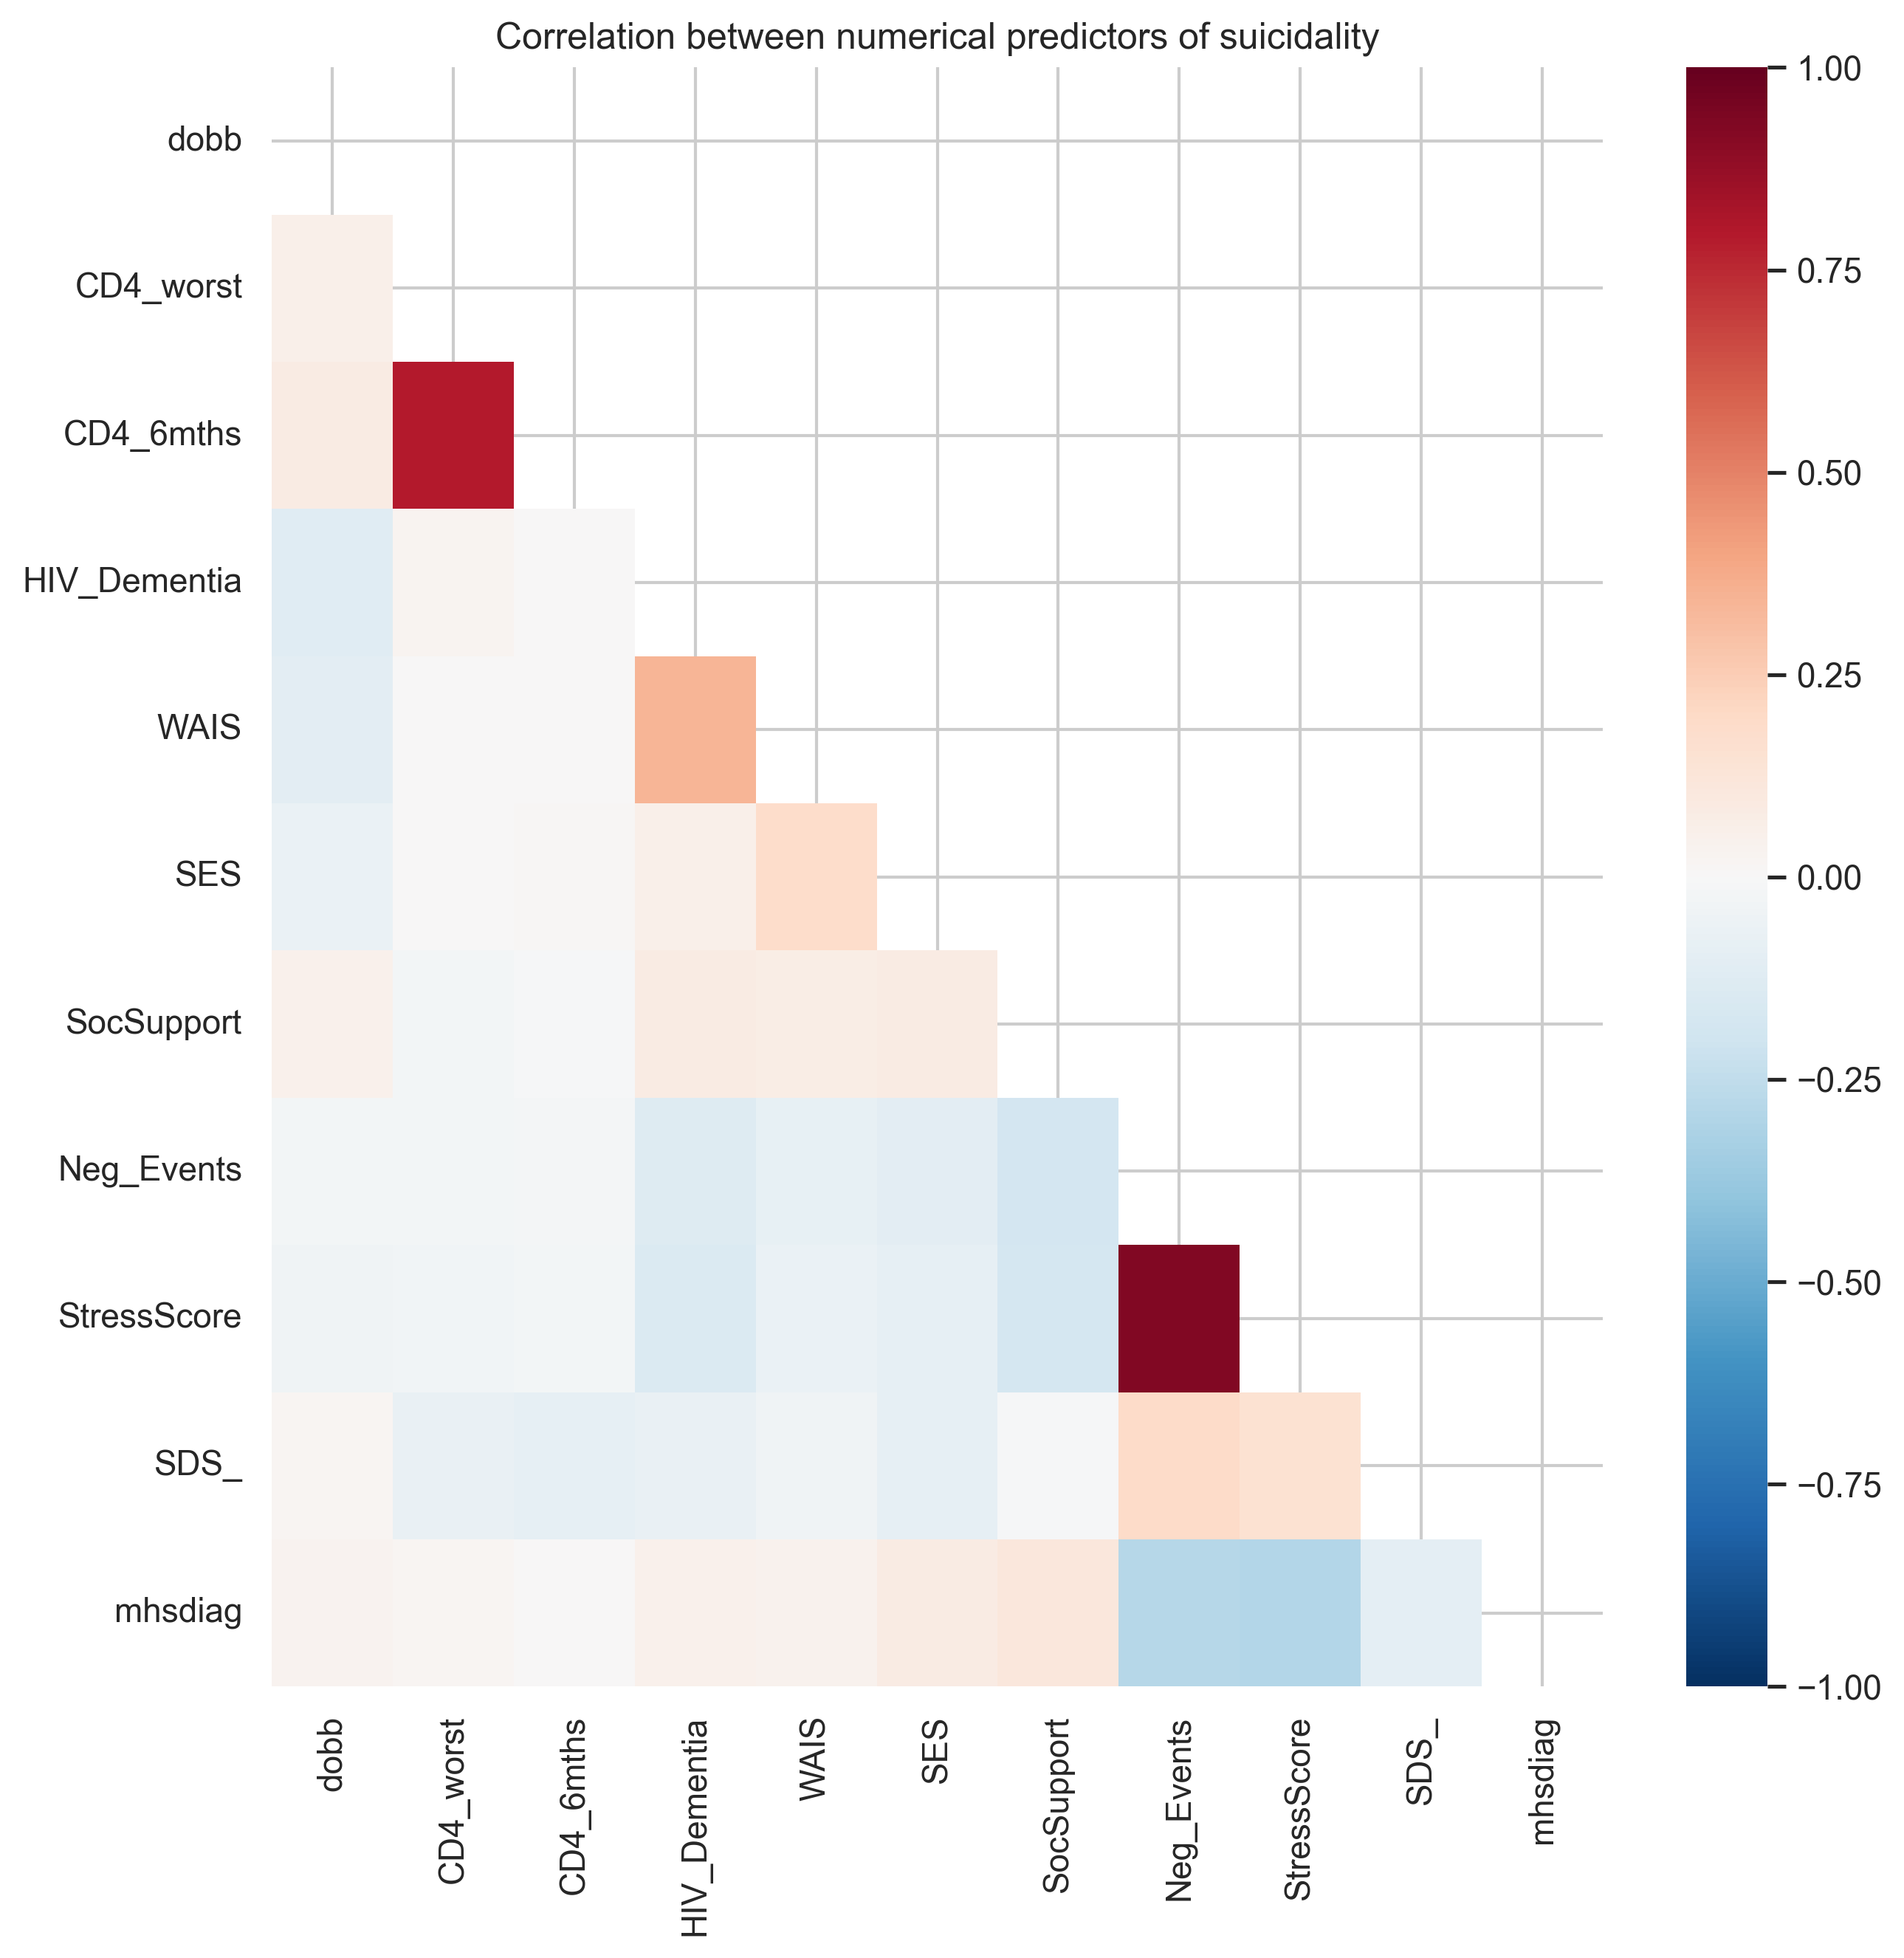

In [47]:

# List of numerical variables
num_var = ['dobb', 'CD4_worst', 'CD4_6mths', 'HIV_Dementia', 'WAIS', 'SES', 'SocSupport',
           'Neg_Events', 'StressScore', 'SDS_', 'mhsdiag']
# Select relevant columns from the dataframe
df_corr1 = df_hiv1[num_var].copy()

# Check for missing values and impute if needed
if df_corr1.isnull().values.any():
    # Impute missing values
    df_corr1[num_var] = df_corr1[num_var].fillna(df_corr1[num_var].median())

# Generate a correlation matrix including the binary outcome variable
corr_matrix = df_corr1.corr(method='pearson')

# Create a mask to hide the upper triangular part of the matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(9,9), dpi=300)

# Create a heatmap with the mask applied
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap="RdBu_r", mask=mask, vmin=-1, vmax=1)

#add title
plt.title('Correlation between numerical predictors of suicidality')

# Show the plot
plt.tight_layout()
plt.show()

In [48]:
# Find highly correlated variables in the data and prune one of the correlated variables
highly_correlated_tuples = []
variables_to_prune = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        correlation = corr_matrix.iloc[i, j]
        if abs(correlation) >= 0.5:
            col_name_1, col_name_2 = corr_matrix.columns[i], corr_matrix.columns[j]
            highly_correlated_tuples.append((col_name_1, col_name_2, correlation))
            # Prune the second variable in the pair
            variables_to_prune.add(col_name_2)  

# Print the final set of highly correlated variables
for col1, col2, correlation in highly_correlated_tuples:
    print(f"'{col1}' and '{col2}' have a correlation of {correlation:.2f}")

# Print out the set of variables to be dropped
print("Variables to prune:", variables_to_prune)

# Drop columns in the set of variables_to_prune
df_cleaned = df_corr1.drop(columns=variables_to_prune)

'CD4_6mths' and 'CD4_worst' have a correlation of 0.79
'StressScore' and 'Neg_Events' have a correlation of 0.92
Variables to prune: {'CD4_worst', 'Neg_Events'}


In [49]:
# Drop columns in the set of variables_to_prune
df_cleaned = df_corr1.drop(columns=variables_to_prune)

# Print the new list of remaining variables
print("Remaining variables after pruning:")
print(df_cleaned.columns.tolist())


Remaining variables after pruning:
['dobb', 'CD4_6mths', 'HIV_Dementia', 'WAIS', 'SES', 'SocSupport', 'StressScore', 'SDS_', 'mhsdiag']


##### *Relationship between categorical variables and the outcome*

In [50]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from tabulate import tabulate
outcome = 'mhsdiag'

# Set p-value threshold
p_value_threshold = 0.5  

# Select categorical variables of interest
categorical_columns=['studsite','sex', 'educat','religion','mstatus','food', 
                     'yemploy', 'prevpsyc','psycfam','MDD','Support','ALE',
                     'Stress','SDS','SES_','Age_group', 'whostagetwo','hivdate',
                     'clinictime','impairment']


# Create a copy of the DataFrame to avoid modifying the original data
df_chi2 = df_hiv1.copy()

# Impute missing values in the target variable 'msdiag'
y_imputer = SimpleImputer(strategy='most_frequent')
df_chi2['mhsdiag'] = y_imputer.fit_transform(df_chi2[['mhsdiag']])

# Apply label encoding to categorical variables
label_encoder = LabelEncoder()
df_chi2[categorical_columns] = df_chi2[categorical_columns].apply(lambda col: label_encoder.fit_transform(col))

# Perform Chi-square test
chi2_stat, p_values = chi2(df_chi2[categorical_columns], df_chi2[outcome])

# Create a DataFrame to store the results
chi2_results = pd.DataFrame({'Variable': categorical_columns, 'Chi2_Statistic': chi2_stat, 'P-Value': p_values})

# Format the Chi-square statistics and p-values in exponential format
chi2_results['Chi2_Statistic'] = chi2_results['Chi2_Statistic'].apply(lambda x: f"{x:.2e}")
chi2_results['P-Value'] = chi2_results['P-Value'].apply(lambda x: f"{x:.2e}")

# Filter variables based on the p-value threshold
significant_variables = chi2_results[chi2_results['P-Value'].astype(float) < p_value_threshold]

# Sort variables by p-value in ascending order (most significant at the top)
significant_variables = significant_variables.sort_values(by='P-Value', key=lambda x: x.astype(float))

# Print results in a neat table format
print(tabulate(significant_variables, headers='keys', tablefmt='pretty'))


+----+------------+----------------+----------+
|    |  Variable  | Chi2_Statistic | P-Value  |
+----+------------+----------------+----------+
| 9  |    MDD     |    3.44e+01    | 4.49e-09 |
| 12 |   Stress   |    1.17e+01    | 6.22e-04 |
| 5  |    food    |    8.38e+00    | 3.79e-03 |
| 7  |  prevpsyc  |    6.68e+00    | 9.77e-03 |
| 10 |  Support   |    4.07e+00    | 4.37e-02 |
| 4  |  mstatus   |    3.84e+00    | 5.00e-02 |
| 11 |    ALE     |    2.40e+00    | 1.22e-01 |
| 6  |  yemploy   |    2.02e+00    | 1.56e-01 |
| 8  |  psycfam   |    1.68e+00    | 1.95e-01 |
| 19 | impairment |    1.63e+00    | 2.02e-01 |
| 15 | Age_group  |    1.10e+00    | 2.95e-01 |
| 14 |    SES_    |    9.53e-01    | 3.29e-01 |
| 3  |  religion  |    5.57e-01    | 4.55e-01 |
+----+------------+----------------+----------+


##### *Cross tabulation of categorical variables*

In [51]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# List of categorical variables
categorical_columns = ['studsite', 'sex', 'educat', 'religion', 'mstatus', 'food', 
                       'yemploy', 'prevpsyc', 'psycfam', 'MDD', 'Support', 'ALE',
                       'Stress', 'SDS', 'SES_', 'Age_group', 'whostagetwo', 'hivdate',
                       'clinictime', 'impairment']

# Create a copy of the DataFrame to avoid modifying the original data
df_crosstab = df_hiv1[categorical_columns].copy()

# Function to compute Cramér's V for categorical data
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    return np.sqrt(chi2_stat / (n * (min(contingency_table.shape) - 1)))

# Cross-tabulate all pairs of categorical variables and compute correlations
highly_correlated_pairs = []

# Compute pairwise Cramér's V correlation and collect high correlations
for i in range(len(categorical_columns)):
    for j in range(i+1, len(categorical_columns)):
        col1 = categorical_columns[i]
        col2 = categorical_columns[j]
        corr_value = cramers_v(df_crosstab[col1], df_crosstab[col2])
        if corr_value >= 0.5:
            highly_correlated_pairs.append((col1, col2, corr_value))

# Print highly correlated pairs (Cramér's V >= 0.5)
if highly_correlated_pairs:
    print("\nHighly correlated variable pairs (Cramér's V >= 0.5):")
    for var1, var2, corr_value in highly_correlated_pairs:
        print(f"{var1} and {var2} have Cramér's V of {corr_value:.2f}")
else:
    print("\nNo pairs with Cramér's V >= 0.5 found.")



Highly correlated variable pairs (Cramér's V >= 0.5):
ALE and Stress have Cramér's V of 0.68
hivdate and clinictime have Cramér's V of 0.80


##### *Feature selection using Lasso regression*

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
import pandas as pd

# List variables for selection
cat_var = ['studsite', 'sex', 'educat', 'religion', 'mstatus', 'food',
           'yemploy', 'prevpsyc', 'psycfam', 'MDD', 'Support', 'Stress',
           'SDS', 'SES_', 'Age_group',  'hivdate', 'impairment']

num_var = ['CD4_6mths', 'HIV_Dementia']

# Create DataFrame with selected variables
df_select = df_hiv1[['mhsdiag'] + cat_var + num_var].copy()

# Impute missing values in the target variable 'msdiag'
y_imputer = SimpleImputer(strategy='most_frequent')
df_select['mhsdiag'] = y_imputer.fit_transform(df_select[['mhsdiag']])

# Split the data into features and target variable
X = df_select.drop(columns=['mhsdiag'])
y = df_select['mhsdiag']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps for numerical and categorical variables
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_var),
        ('cat', categorical_transformer, cat_var)
    ])

# Append Lasso regression model to preprocessing pipeline for feature selection
lasso_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso', Lasso(alpha=0.0001))  
])

# Fit Lasso regression model 
lasso_model.fit(X_train, y_train)

# Get selected features based on Lasso regression
select_from_model = SelectFromModel(lasso_model.named_steps['lasso'], prefit=True)
selected_features = select_from_model.get_support()

# Print selected features
print("Selected Features:")
for feature, selected in zip(X.columns, selected_features):
    if selected:
        print(feature)


Selected Features:
studsite
sex
educat
mstatus
yemploy
prevpsyc
MDD
Support
Stress
SES_
Age_group
hivdate
impairment
HIV_Dementia


##### *Features transformation* 

In [53]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Set random seed
np.random.seed(42)
selected=['studsite','sex','educat','mstatus','yemploy','prevpsyc',
          'MDD','Support','Stress','SES_','Age_group','hivdate',
          'impairment','HIV_Dementia','mhsdiag']

# Subset the DataFrame with selected columns
df_baseline = df_hiv1[selected]

# Separate features and target
X = df_baseline.drop('mhsdiag', axis=1)
y = df_baseline['mhsdiag']

# Impute missing values in the target variable 'mhsdiag'
y_imputer = SimpleImputer(strategy='most_frequent')
y = pd.Series(y_imputer.fit_transform(y.values.reshape(-1, 1)).ravel())

# Apply label encoding to the target variable 'y'
y = y.map({1: 1, 2: 0})

# Define numeric and categorical variables
num_var = ['HIV_Dementia', ]

cat_var =['studsite','sex','educat','mstatus','yemploy','prevpsyc',
          'MDD','Support','Stress','SES_','Age_group','hivdate',
          'impairment'] 

# Define transformers
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
    # No scaler, as the data is already standardized
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Apply transformations
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_var),
    ("cat", categorical_transformer, cat_var)
])

# Create the final pipeline with preprocessing 
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit and transform the training data 
X_train_transformed = pipeline.fit_transform(X_train)

# Apply transformations to the test data using the preprocessor
X_test_transformed = pipeline.transform(X_test)


##### *Initialize models with default parameters* 

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import (roc_auc_score, matthews_corrcoef, accuracy_score, recall_score, 
                             f1_score, confusion_matrix, average_precision_score)
# Set random seed
np.random.seed(42)

classifiers = {
    'LR': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'NB': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'DT': DecisionTreeClassifier(random_state=42),
    'RF': RandomForestClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'GBM': GradientBoostingClassifier(random_state=42),
}

# Storage for results
results = {'Classifier': [], 'AUC': [], 'AUPRC': [], 'MCC': [], 'Accuracy': [], 'Sensitivity': [], 'Specificity': [], 'F1-score': []}

# Fit classifiers and evaluate
for name, clf in classifiers.items():
    print(f"Training {name}...")

    # Train the classifier on the training set
    clf.fit(X_train_transformed, y_train)
    
    # Make predictions and predict probabilities
    predictions = clf.predict(X_test_transformed)
    probabilities = clf.predict_proba(X_test_transformed)[:, 1]

    # Compute AUC on the test set
    auc = roc_auc_score(y_test, probabilities)

    # Compute AUPRC on the test set
    auprc = average_precision_score(y_test, probabilities)

    # Compute MCC on the test set
    mcc = matthews_corrcoef(y_test, predictions)
    
    # Compute accuracy
    accuracy = accuracy_score(y_test, predictions)
    
    # Compute sensitivity (recall)
    sensitivity = recall_score(y_test, predictions)

    # Compute specificity
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    specificity = tn / (tn + fp)

    # Compute F1-score
    f1 = f1_score(y_test, predictions)

    # Store results
    results['Classifier'].append(name)
    results['AUC'].append(round(auc, 2))
    results['AUPRC'].append(round(auprc, 2))
    results['MCC'].append(round(mcc, 2))
    results['Accuracy'].append(round(accuracy, 2))
    results['Sensitivity'].append(round(sensitivity, 2))
    results['Specificity'].append(round(specificity, 2))
    results['F1-score'].append(round(f1, 2))

# Convert results to DataFrame for easier display
results_df = pd.DataFrame(results)

# Sort models by MCC from best to worst
results_df = results_df.sort_values(by='AUC', ascending=False)

# Display the dataframe
print(results_df)


Training LR...
Training SVM...
Training NB...
Training KNN...
Training DT...
Training RF...
Training AdaBoost...
Training GBM...
  Classifier   AUC  AUPRC   MCC  Accuracy  Sensitivity  Specificity  F1-score
7        GBM  0.78   0.46  0.33      0.83         0.27         0.96      0.37
6   AdaBoost  0.77   0.49  0.27      0.81         0.29         0.93      0.36
0         LR  0.76   0.44  0.22      0.81         0.22         0.94      0.30
5         RF  0.73   0.48  0.37      0.84         0.29         0.97      0.41
2         NB  0.72   0.32  0.24      0.75         0.44         0.82      0.40
1        SVM  0.69   0.43  0.16      0.82         0.07         0.99      0.13
3        KNN  0.64   0.28  0.21      0.82         0.15         0.97      0.23
4         DT  0.59   0.23  0.18      0.76         0.32         0.86      0.33


#### *Comparison of models based on AUC*

Processing LR...
Fitting 10 folds for each of 9 candidates, totalling 90 fits

LR Results:
Mean CV AUC: 0.75
95% CI: (0.67, 0.83)
Best Parameters: {'C': 0.1, 'solver': 'liblinear'}

Processing SVM...
Fitting 10 folds for each of 6 candidates, totalling 60 fits

SVM Results:
Mean CV AUC: 0.69
95% CI: (0.59, 0.78)
Best Parameters: {'C': 1, 'kernel': 'rbf'}

Processing NB...
Fitting 10 folds for each of 5 candidates, totalling 50 fits

NB Results:
Mean CV AUC: 0.71
95% CI: (0.61, 0.81)
Best Parameters: {'var_smoothing': 1e-09}

Processing KNN...
Fitting 10 folds for each of 6 candidates, totalling 60 fits

KNN Results:
Mean CV AUC: 0.66
95% CI: (0.57, 0.74)
Best Parameters: {'n_neighbors': 7, 'weights': 'distance'}

Processing DT...
Fitting 10 folds for each of 6 candidates, totalling 60 fits

DT Results:
Mean CV AUC: 0.75
95% CI: (0.66, 0.84)
Best Parameters: {'max_depth': 3, 'min_samples_split': 2}

Processing AdaBoost...
Fitting 10 folds for each of 4 candidates, totalling 40 fits

Ada

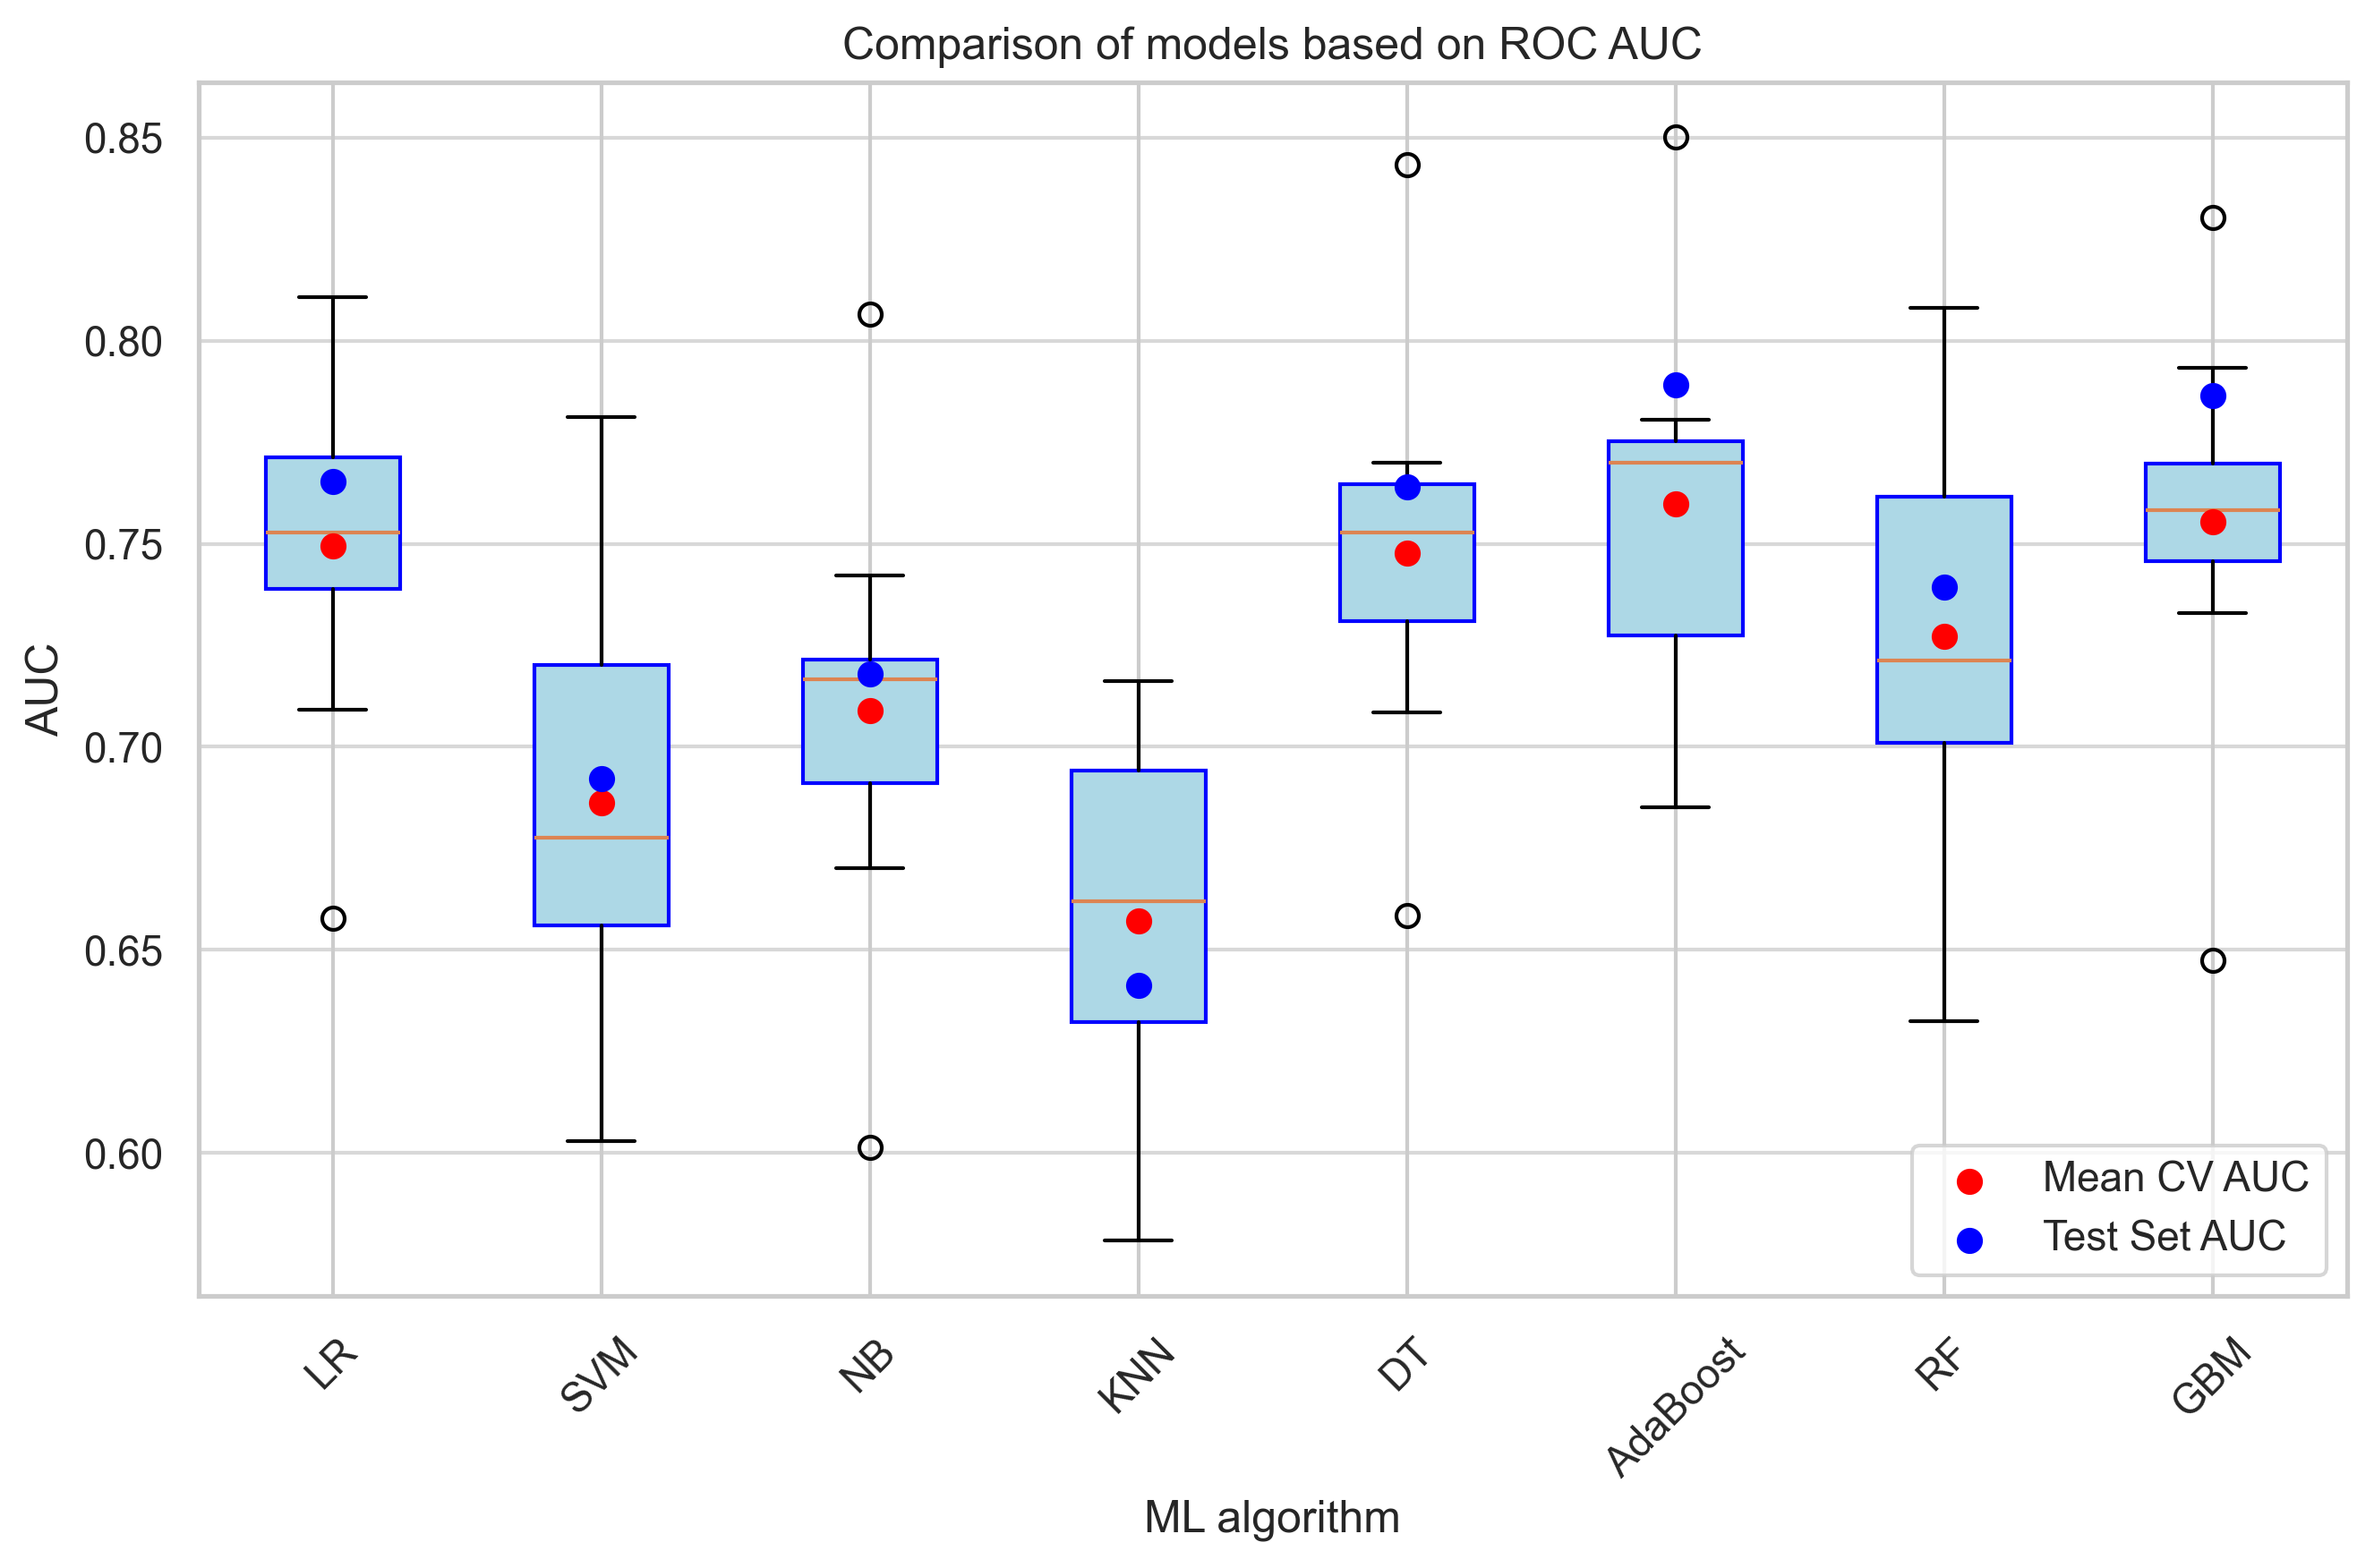


Best Model: AdaBoost
Test Set AUC: 0.79

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       181
           1       0.67      0.15      0.24        41

    accuracy                           0.83       222
   macro avg       0.75      0.56      0.57       222
weighted avg       0.80      0.83      0.78       222



In [55]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report

# Define classifiers and their hyperparameter grids
classifiers = {
    'LR': LogisticRegression(max_iter=1000, random_state=123),
    'SVM': SVC(probability=True, random_state=123),
    'NB': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'DT': DecisionTreeClassifier(random_state=123),
    'AdaBoost': AdaBoostClassifier(random_state=123),
    'RF': RandomForestClassifier(random_state=123),
    'GBM': GradientBoostingClassifier(random_state=123),
}

# Define hyperparameter grids for each classifier
param_grids = {
    'LR': {
        "C": [0.1, 1, 10],
        "solver": ['newton-cg', 'lbfgs', 'liblinear'],
    },
    'NB': {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5] 
        },  
    'RF': {
        "n_estimators": [50, 100, 150],
        "max_depth": [10, 15],
        "min_samples_split": [2, 5],
    },
    'AdaBoost': {
        "n_estimators": [50, 100],
        "learning_rate": [0.01, 0.1],
    },
    'GBM': {
        "n_estimators": [50, 100],
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 5],
    },
    
    'KNN': {
        "n_neighbors": [3, 5, 7],
        "weights": ['uniform', 'distance'],
    },
    'SVM': {
        "C": [0.1, 1, 10],
        "kernel": ['linear', 'rbf'],
    },
    'DT': {
        "max_depth": [3, 5, 10],
        "min_samples_split": [2, 5],
    },
}

# Initialize StratifiedKFold for cross-validation
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

# Placeholder for results
model_results = {}
mean_auc_results = {}
best_params_results = {}
test_auc_results = {}

# Loop through each classifier and perform GridSearchCV
for model_name, model in classifiers.items():
    if model_name not in param_grids:
        print(f"Skipping {model_name} (no parameter grid defined).")
        continue
    
    print(f"Processing {model_name}...")
    
    # Perform GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        scoring="roc_auc",
        cv=stratified_kfold,
        n_jobs=-1,
        verbose=1,
    )
    
    try:
        # Fit GridSearchCV
        grid_search.fit(X_train_transformed, y_train)
        
        # Get best model and parameters
        best_model = grid_search.best_estimator_
        best_params_results[model_name] = grid_search.best_params_
        
        # Compute cross-validated AUC scores
        cv_auc_scores = cross_val_score(
            best_model, X_train_transformed, y_train, cv=stratified_kfold, scoring="roc_auc"
        )
        
        # Store results
        model_results[model_name] = cv_auc_scores
        mean_auc_results[model_name] = np.mean(cv_auc_scores)
        std_auc = np.std(cv_auc_scores)
        ci_lower = mean_auc_results[model_name] - 1.96 * std_auc
        ci_upper = mean_auc_results[model_name] + 1.96 * std_auc
        
        # Print results for each model
        print(f"\n{model_name} Results:")
        print(f"Mean CV AUC: {mean_auc_results[model_name]:.2f}")
        print(f"95% CI: ({ci_lower:.2f}, {ci_upper:.2f})")
        print(f"Best Parameters: {grid_search.best_params_}\n")
    
        # Evaluate on the test set
        best_model.fit(X_train_transformed, y_train)
        y_test_pred_proba = best_model.predict_proba(X_test_transformed)[:, 1]
        test_auc = roc_auc_score(y_test, y_test_pred_proba)
        test_auc_results[model_name] = test_auc
    
    except Exception as e:
        print(f"Error processing {model_name}: {e}")
        continue

# Plot box plots comparing AUC across all models
plt.figure(figsize=(9, 6), dpi=300)
plt.boxplot(model_results.values(), labels=model_results.keys(), patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'))

# Add red dot for mean cross-validation AUC and blue dot for test set AUC
for i, model_name in enumerate(model_results.keys(), start=1):
    plt.scatter(i, mean_auc_results[model_name], color='red', zorder=5, label="Mean CV AUC" if i == 1 else "")
    if model_name in test_auc_results:
        plt.scatter(i, test_auc_results[model_name], color='blue', zorder=5, label="Test Set AUC" if i == 1 else "")

# Customize plot
plt.xlabel("ML algorithm")
plt.ylabel("AUC")
plt.title("Comparison of models based on ROC AUC")
plt.legend(loc="lower right")
plt.grid(axis="y", alpha=0.75)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the best model and its test set performance
best_model_name = max(test_auc_results, key=test_auc_results.get)
best_model = classifiers[best_model_name]  # Retrieve the corresponding classifier
best_model.set_params(**best_params_results[best_model_name])  # Set the best parameters
best_model.fit(X_train_transformed, y_train)  # Refit with training data

# Generate predictions and classification report
y_test_pred = best_model.predict(X_test_transformed)
y_test_pred_proba = best_model.predict_proba(X_test_transformed)[:, 1]

print(f"\nBest Model: {best_model_name}")
print(f"Test Set AUC: {roc_auc_score(y_test, y_test_pred_proba):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))


##### *RF model using imbalanced data*

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
The best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
AUC: 0.74


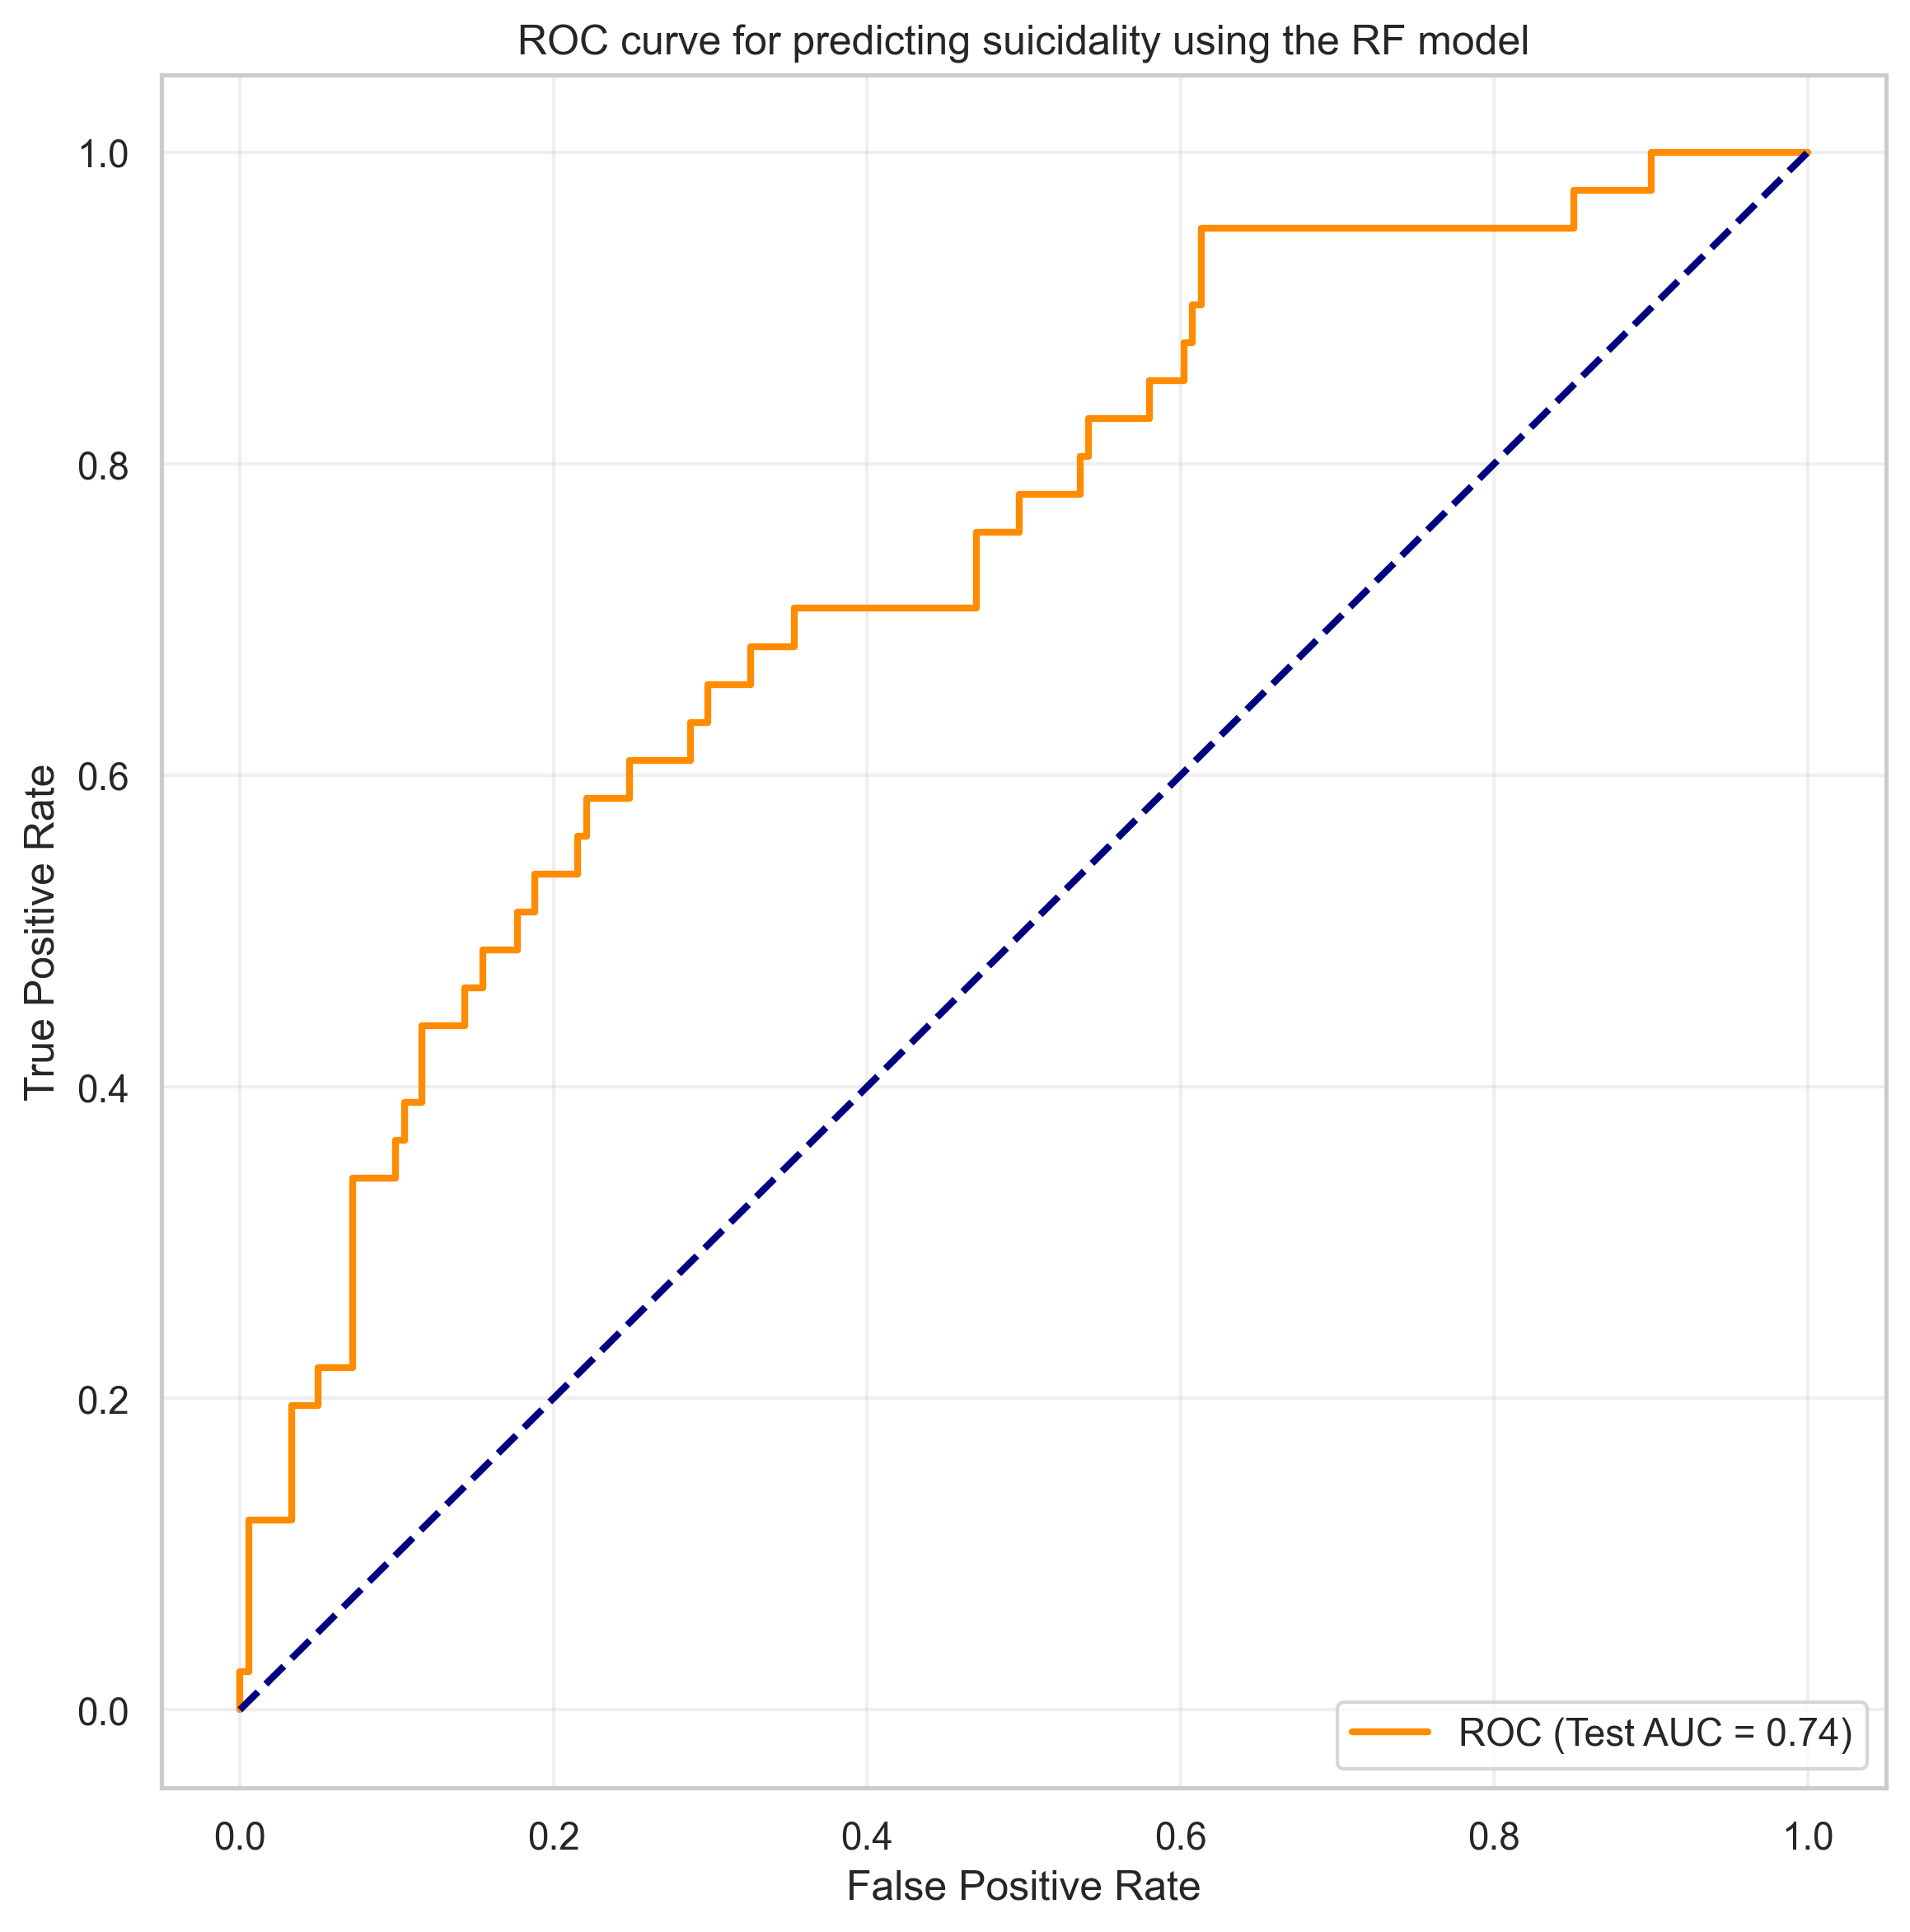

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.97      0.90       181
           1       0.50      0.12      0.20        41

    accuracy                           0.82       222
   macro avg       0.67      0.55      0.55       222
weighted avg       0.77      0.82      0.77       222

Confusion Matrix:
 [[176   5]
 [ 36   5]]
Kappa: 0.13
MCC: 0.18


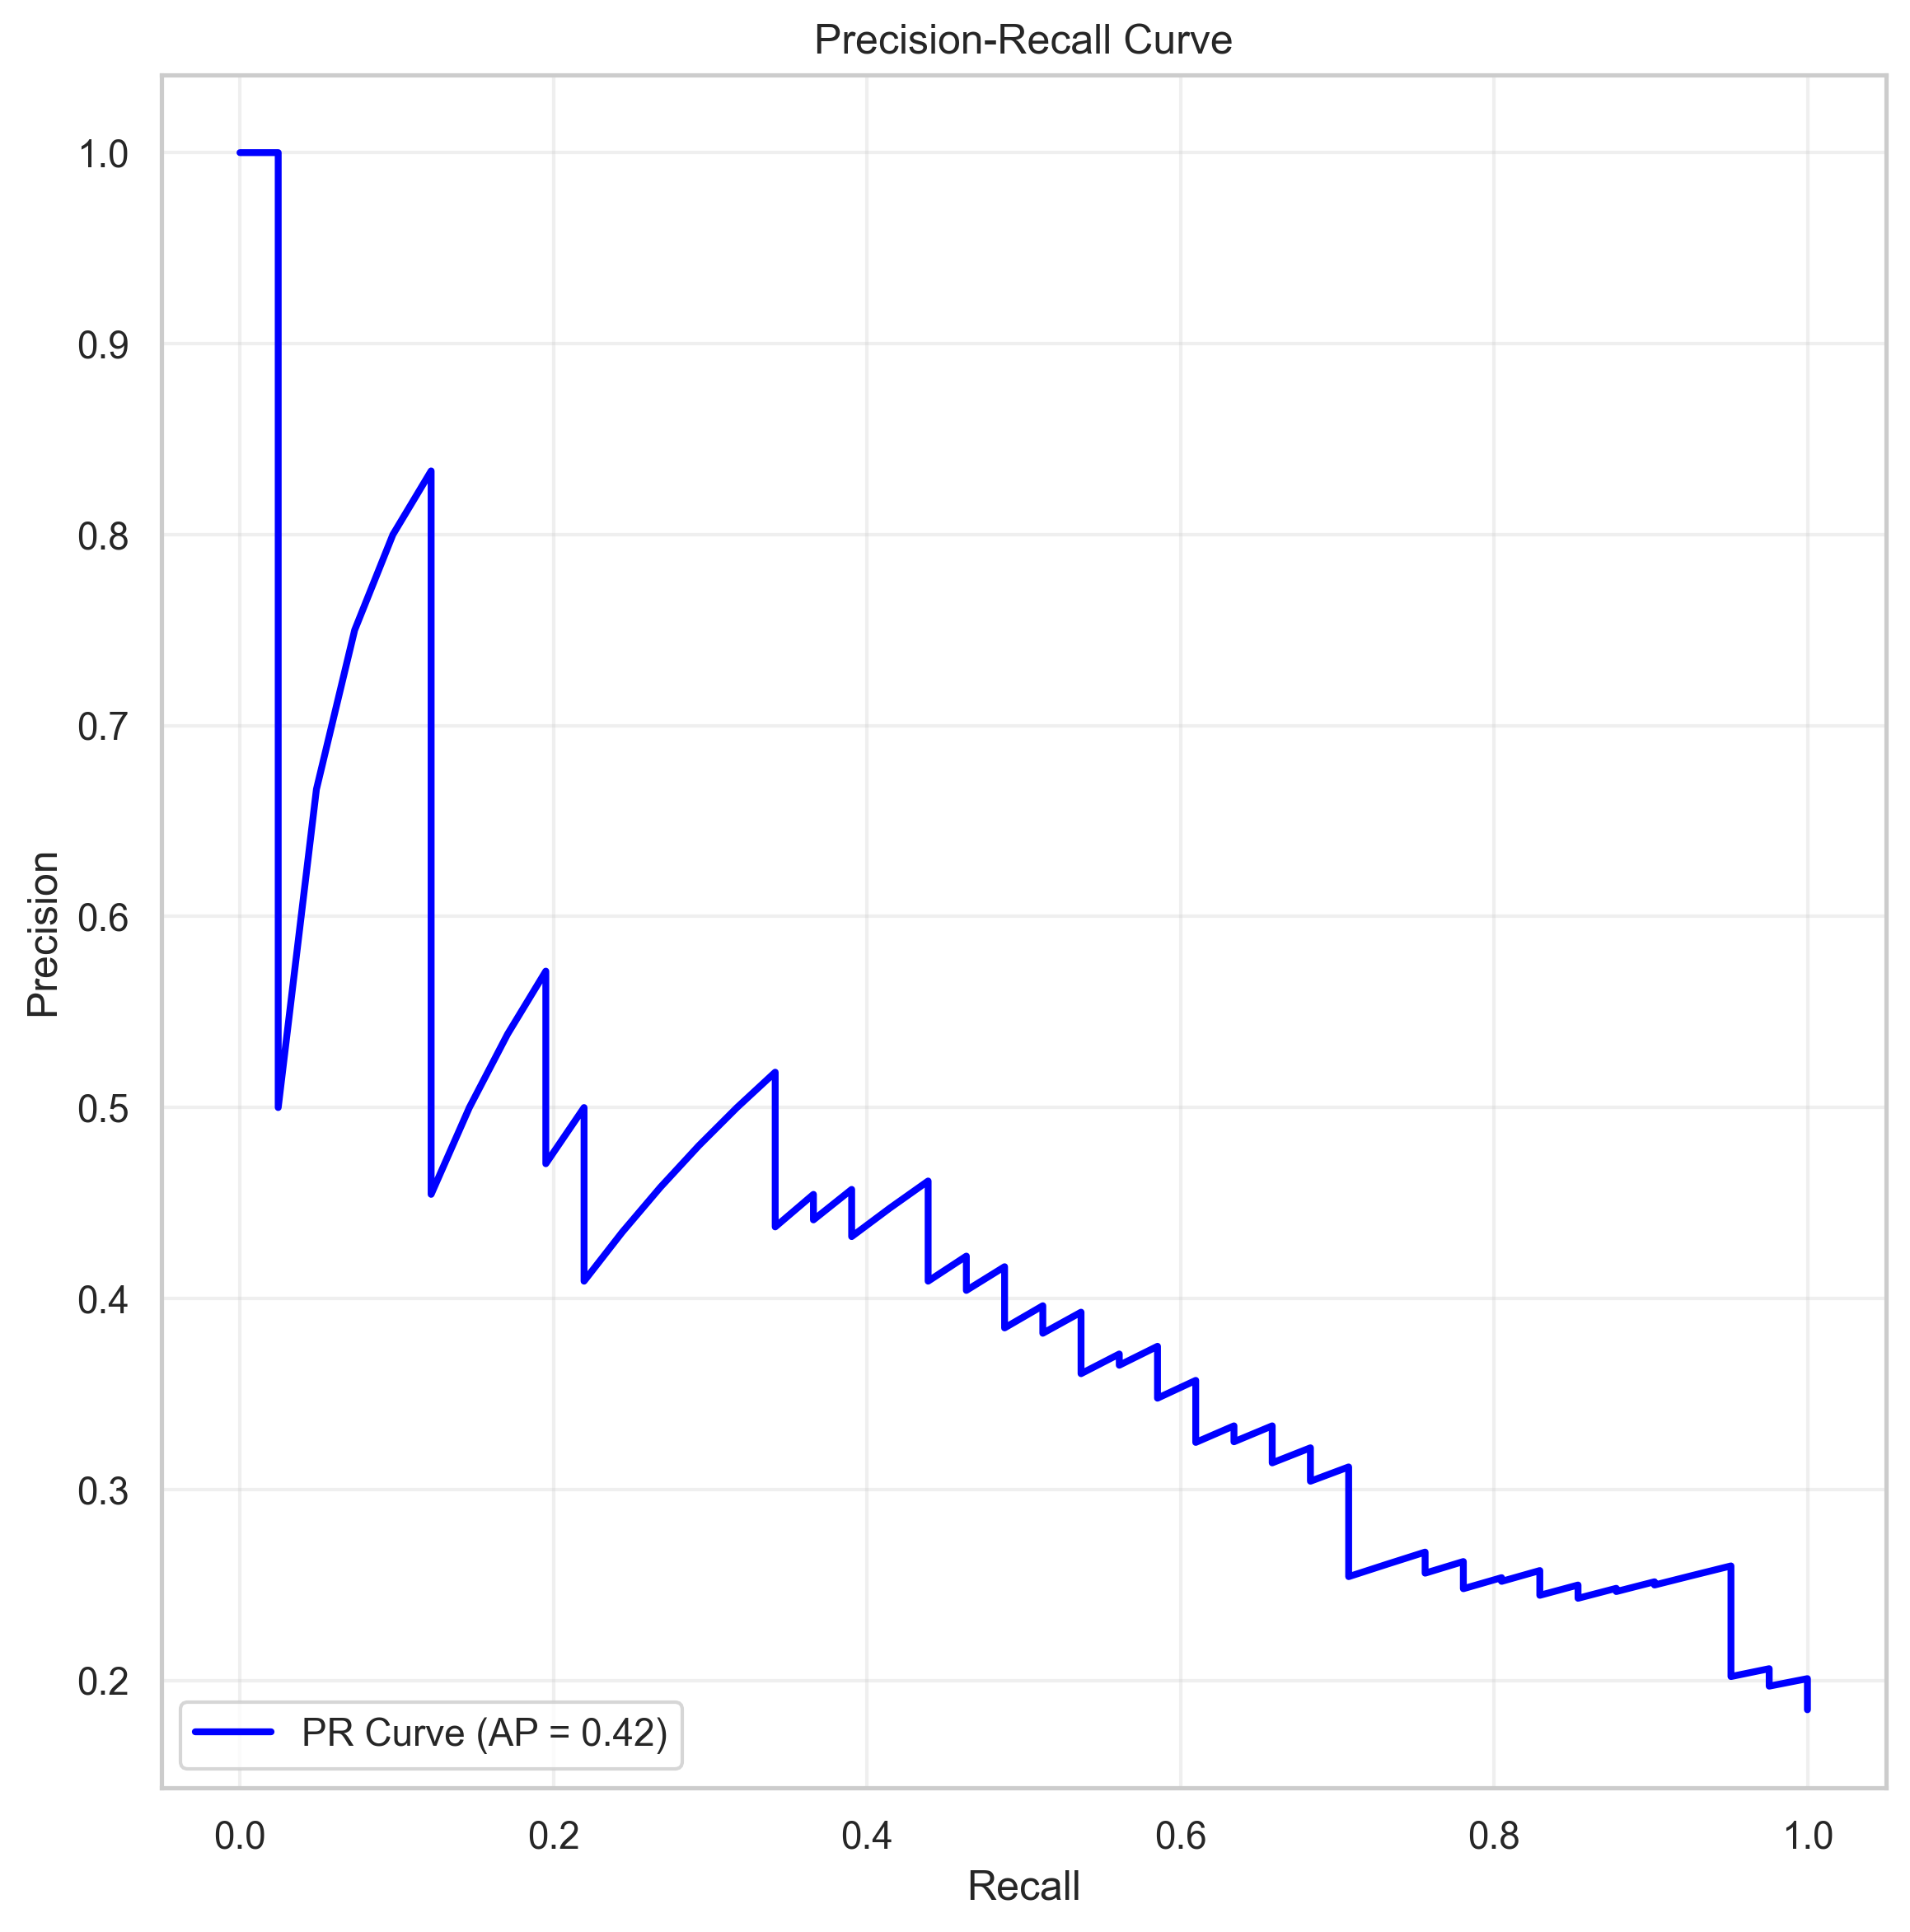

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    cohen_kappa_score,
    matthews_corrcoef,
    precision_recall_curve,
    average_precision_score,
)

# Define the hyperparameters grid for RF
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=123),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=stratified_kfold,
    n_jobs=-1,
    verbose=1
)

# Ensure inputs are numpy arrays
X_train_transformed = np.array(X_train_transformed)
y_train = np.array(y_train)

# Perform grid search on the training data
grid_search.fit(X_train_transformed, y_train)

# Extract the best hyperparameters and model
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_
print("The best parameters:", best_params)

# Evaluate on the test set
rf_predictions = best_rf_model.predict(X_test_transformed)
rf_probabilities = best_rf_model.predict_proba(X_test_transformed)[:, 1]

# Calculate test AUC
test_auc = roc_auc_score(y_test, rf_probabilities)
print(f"AUC: {test_auc:.2f}")

# Generate ROC curve using test data
fpr_test, tpr_test, _ = roc_curve(y_test, rf_probabilities)

# Plot the ROC curve for the test data
plt.figure(figsize=(9, 9), dpi=300)
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC (Test AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for predicting suicidality using the RF model')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Print evaluation metrics
print("Classification Report:\n", classification_report(y_test, rf_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_predictions))
print(f"Kappa: {cohen_kappa_score(y_test, rf_predictions):.2f}")
print(f"MCC: {matthews_corrcoef(y_test, rf_predictions):.2f}")

# Generate and plot the Precision-Recall curve for the test data
precision, recall, _ = precision_recall_curve(y_test, rf_probabilities)
average_precision = average_precision_score(y_test, rf_probabilities)

# Plot the Precision-Recall curve for the test data
plt.figure(figsize=(9, 9), dpi=300)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.show()


##### *RF Model explanation*

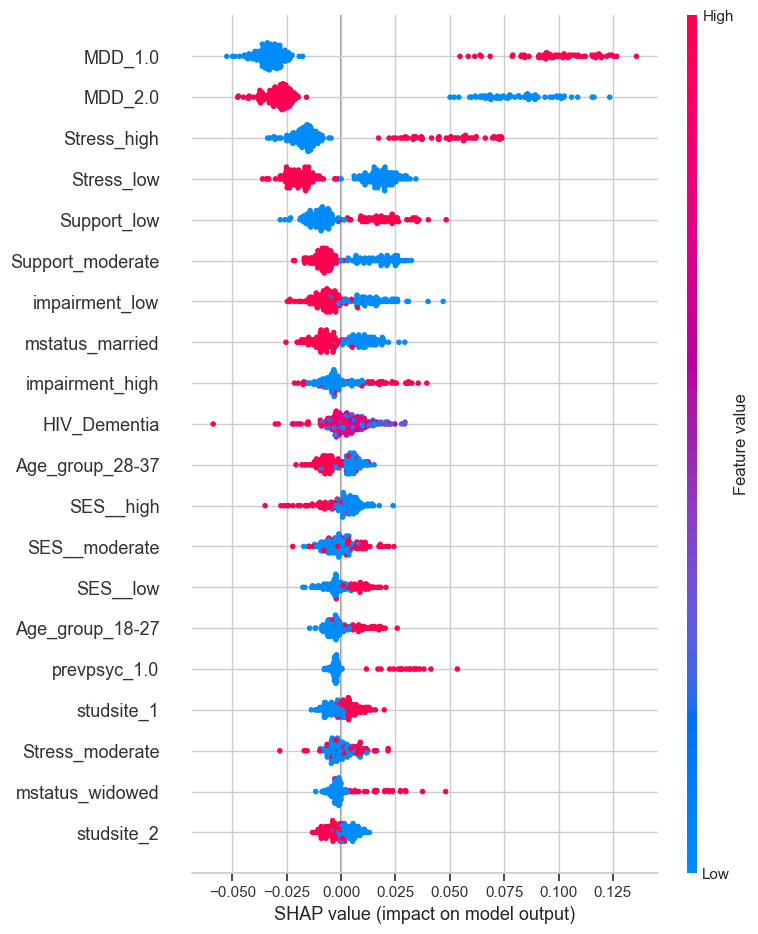

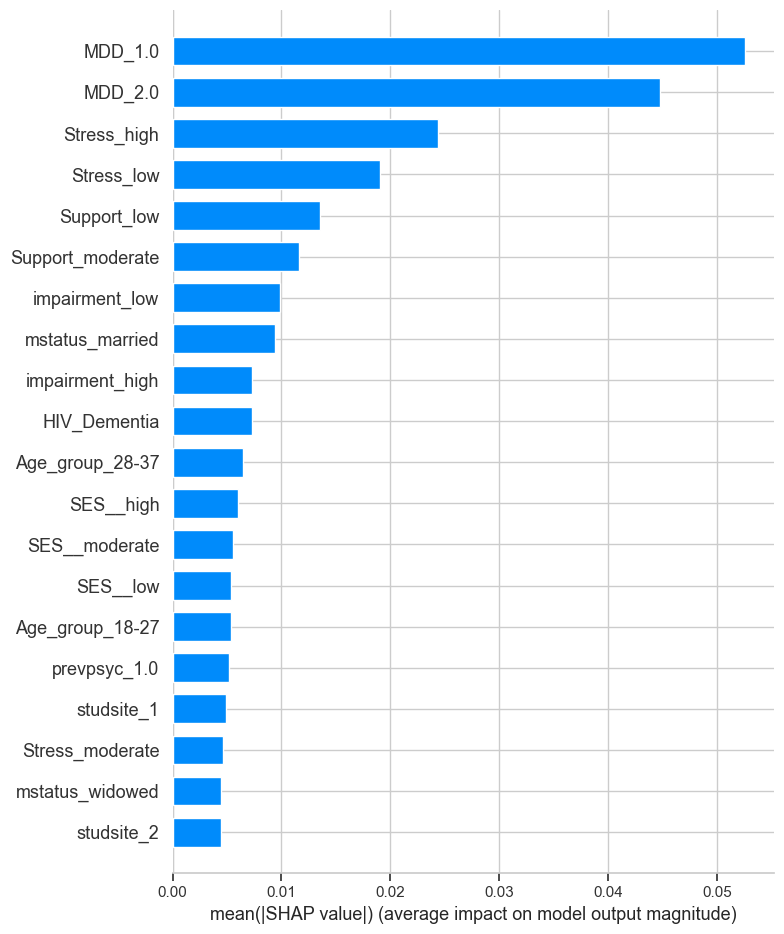

In [57]:
import shap
# Initialize the SHAP TreeExplainer for the RF model
explainer_rf = shap.TreeExplainer(best_rf_model)

# Compute SHAP values for the test set
shap_values_rf = explainer_rf.shap_values(X_test_transformed)

# Define feature names (combine numeric and encoded categorical features)
num_var = ['HIV_Dementia']
cat_var = ['studsite', 'sex', 'educat', 'mstatus', 'yemploy', 'prevpsyc', 
           'MDD', 'Support', 'Stress', 'SES_', 'Age_group', 'hivdate', 
           'impairment']

# Extract and combine feature names
feature_names = np.concatenate([num_var, 
                                 preprocessor.named_transformers_['cat']['encoder']
                                 .get_feature_names_out(input_features=cat_var)])

# Generate SHAP summary plots
shap.summary_plot(shap_values_rf[1], X_test_transformed, feature_names=feature_names, plot_type='dot')
shap.summary_plot(shap_values_rf[1], X_test_transformed, feature_names=feature_names, plot_type='bar')


##### *Correcting for class imbalance with RF*

Fitting 10 folds for each of 288 candidates, totalling 2880 fits
The best parameters: {'class_weight': 'balanced_subsample', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}
AUC: 0.77


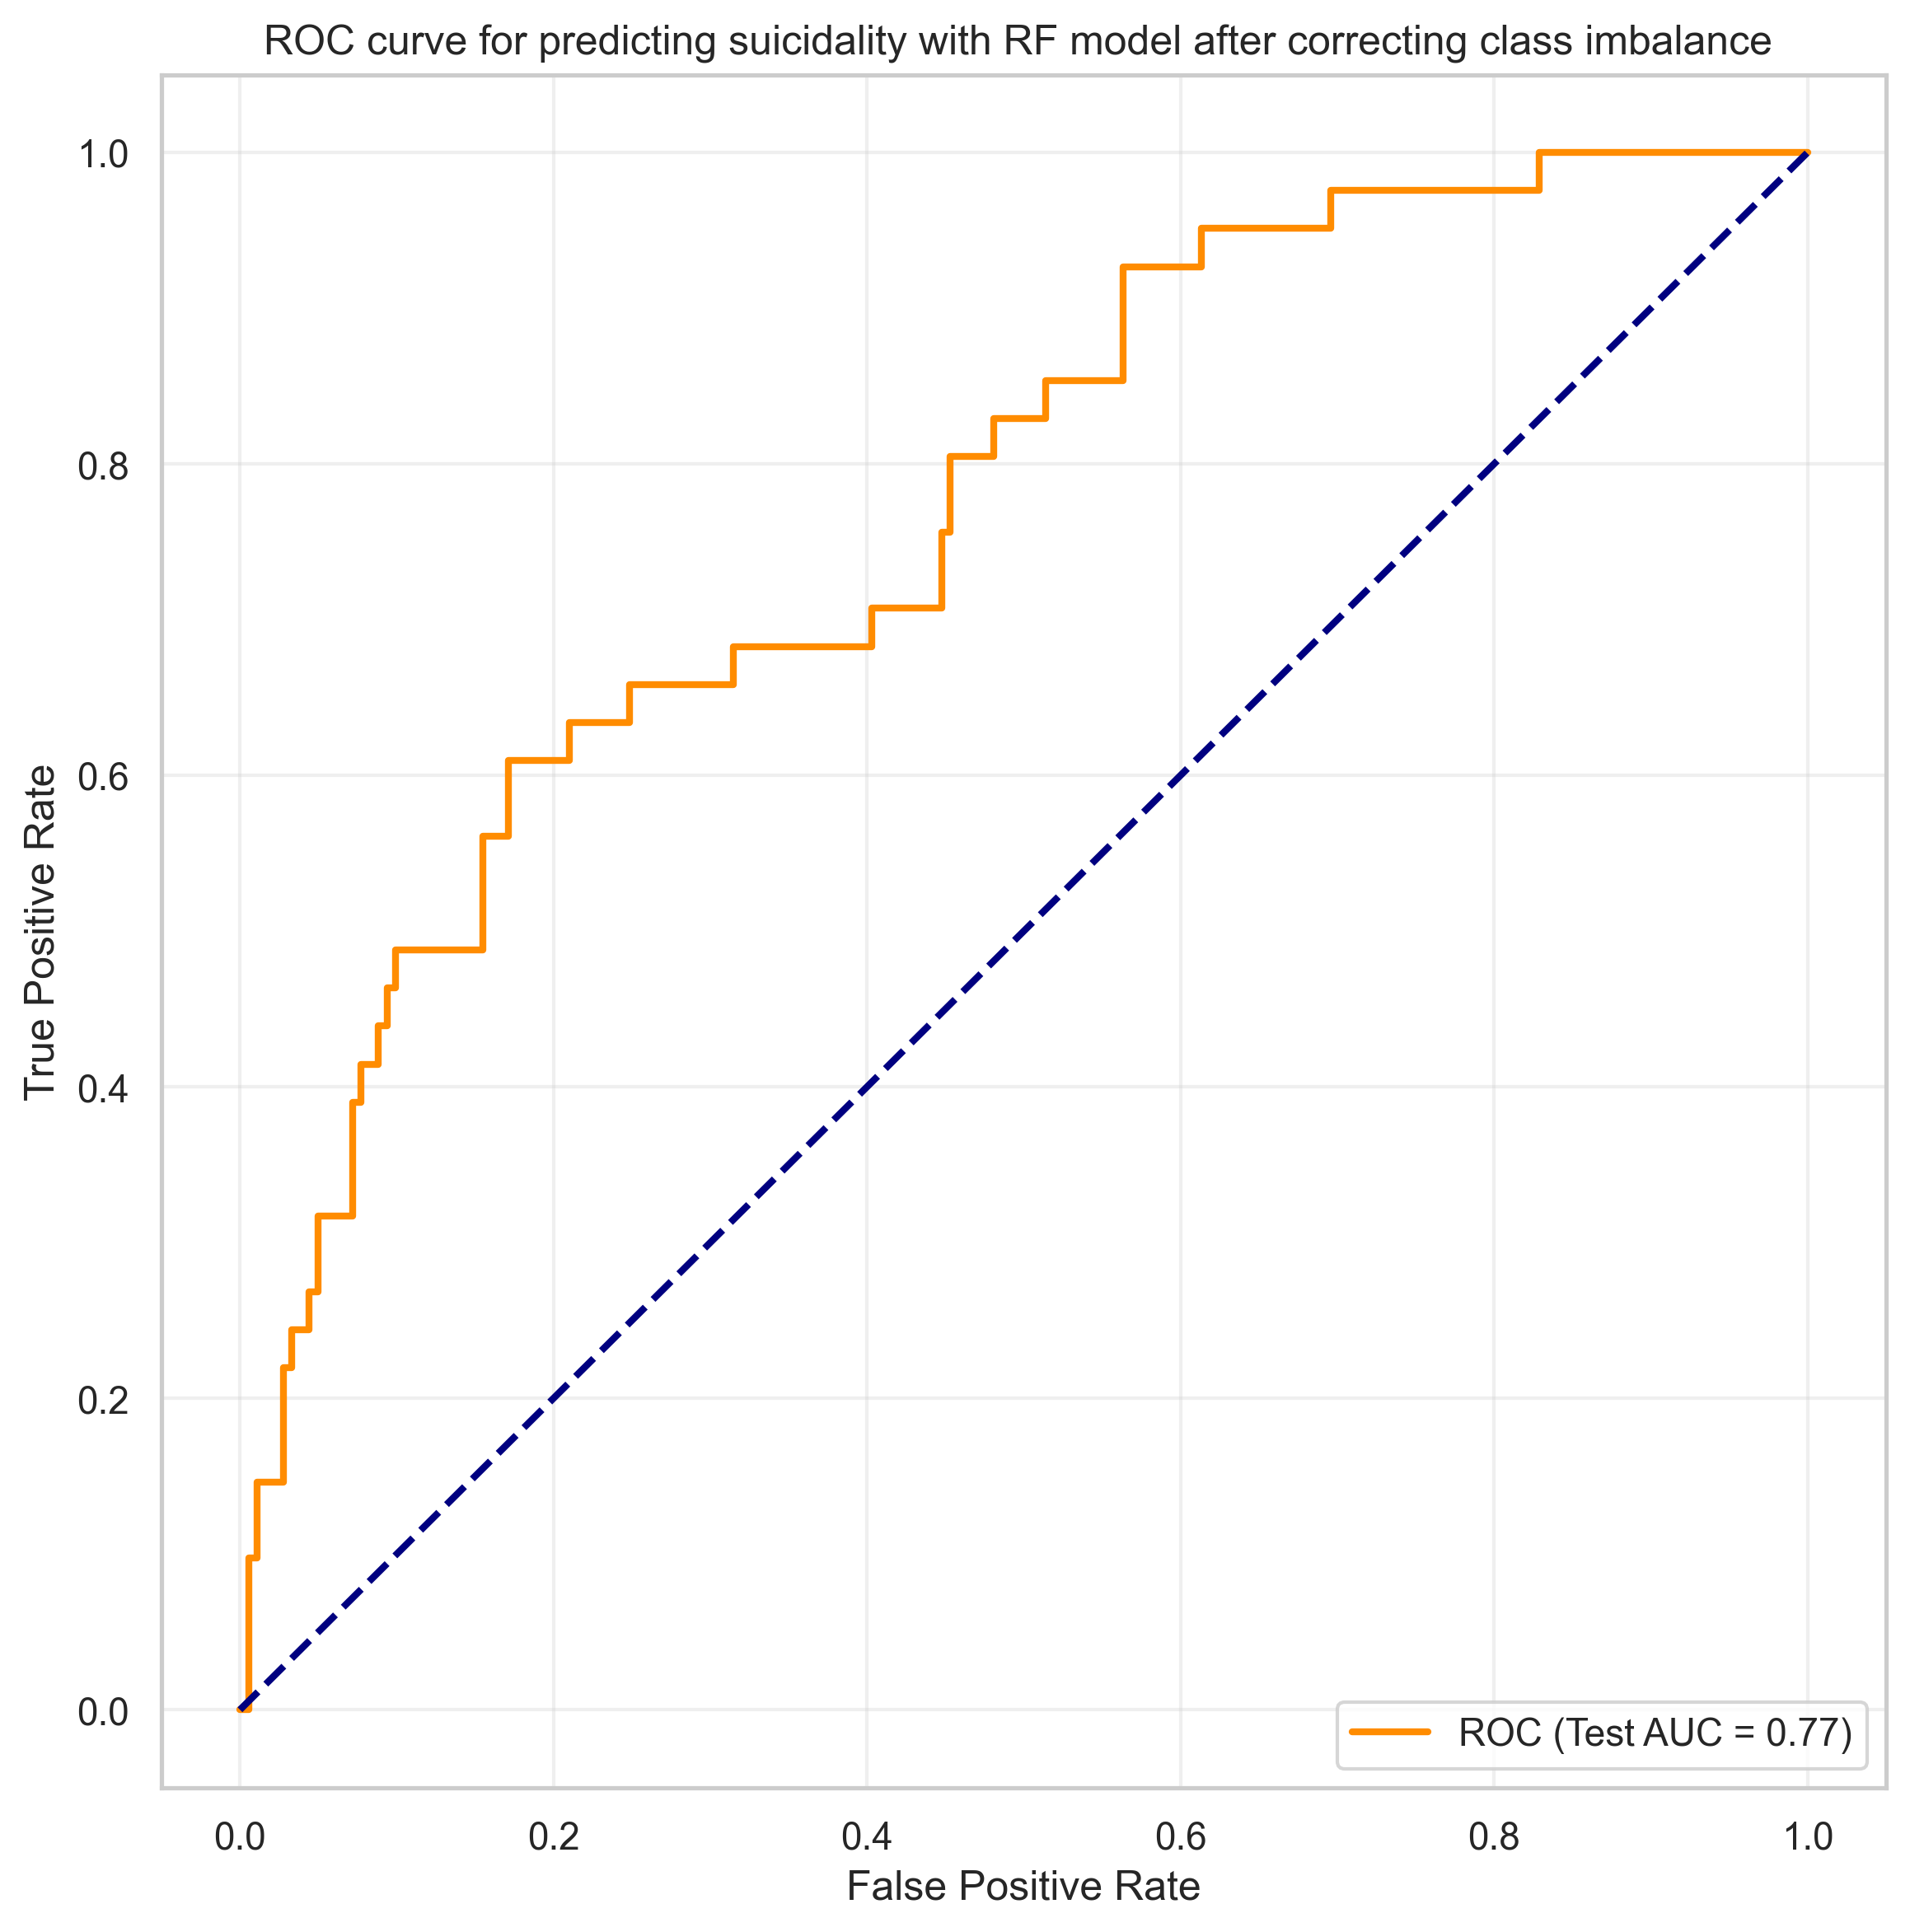

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.78      0.84       181
           1       0.39      0.63      0.49        41

    accuracy                           0.75       222
   macro avg       0.65      0.71      0.66       222
weighted avg       0.81      0.75      0.77       222

Confusion Matrix:
 [[141  40]
 [ 15  26]]
Kappa: 0.33
MCC: 0.35


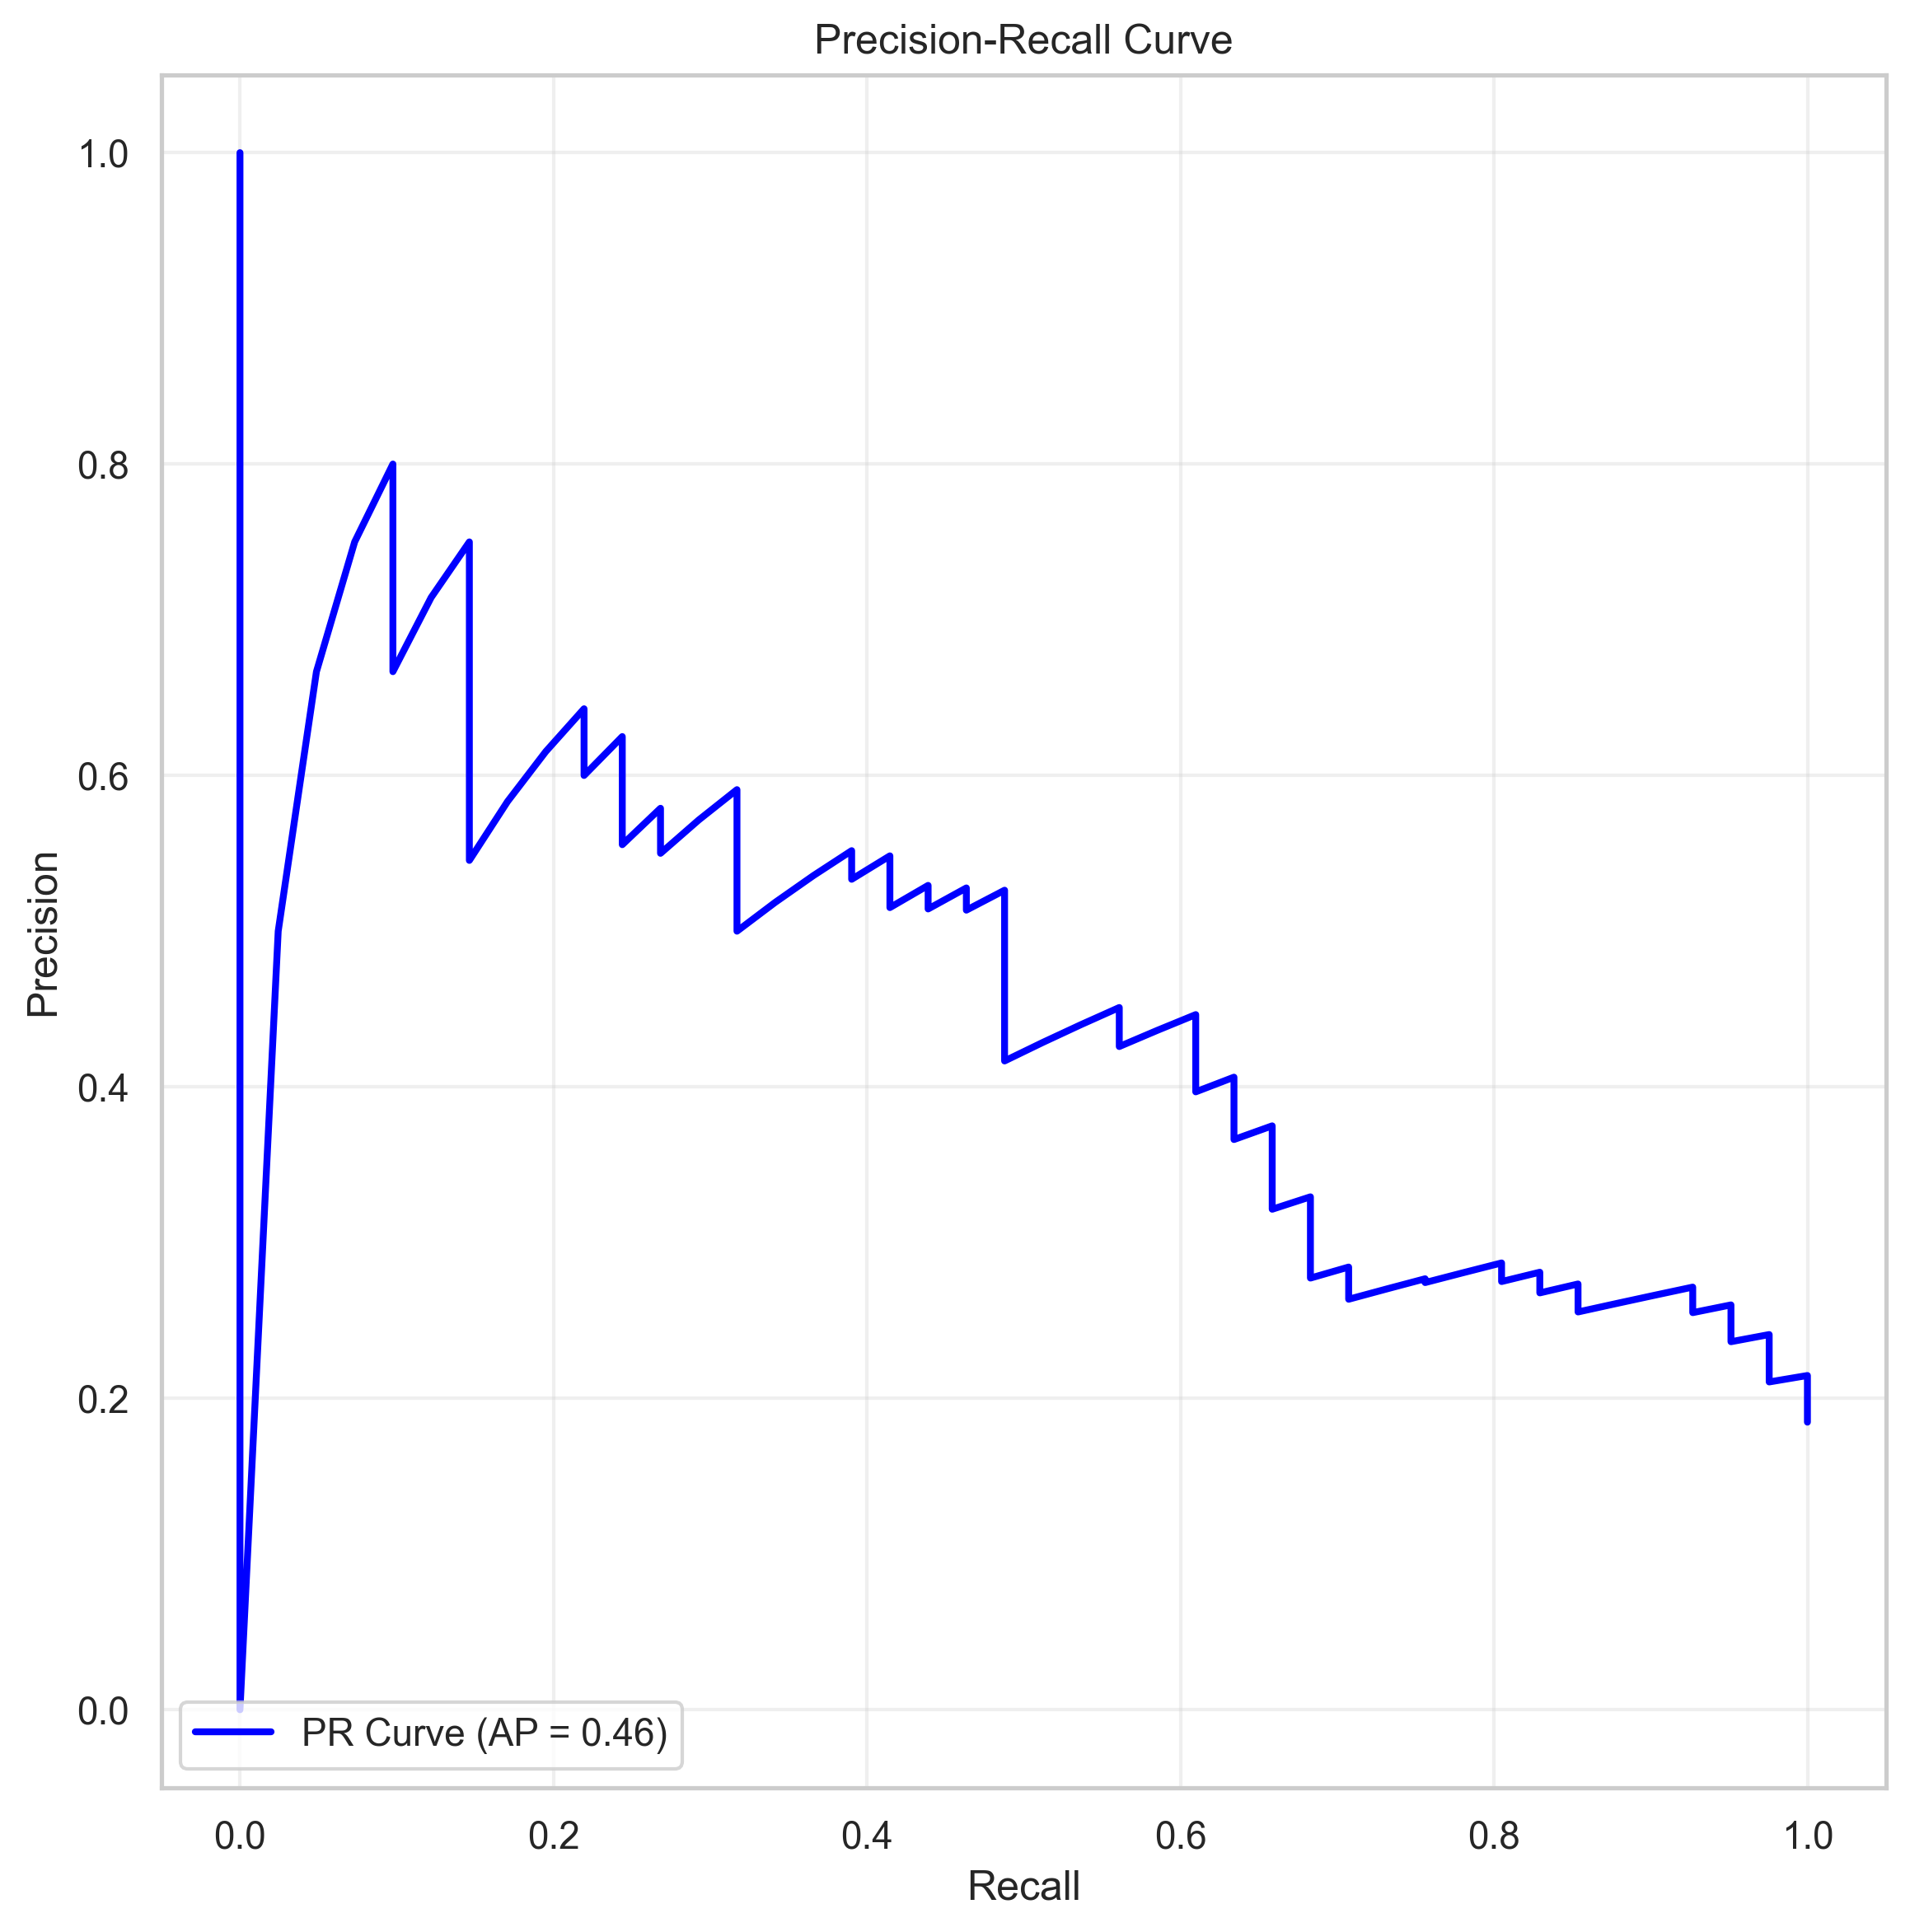

In [58]:
# Define the hyperparameters grid for RF
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Initialize StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=123),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=stratified_kfold,
    n_jobs=-1,
    verbose=1
)

# Ensure inputs are numpy arrays
X_train_transformed = np.array(X_train_transformed)
y_train = np.array(y_train)

# Perform grid search on the training data
grid_search.fit(X_train_transformed, y_train)

# Extract the best hyperparameters and model
best_params = grid_search.best_params_
bal_rf_model = grid_search.best_estimator_
print("The best parameters:", best_params)

# Evaluate on the test set
rf_predictions = bal_rf_model.predict(X_test_transformed)
rf_probabilities = bal_rf_model.predict_proba(X_test_transformed)[:, 1]

# Calculate test AUC
test_auc = roc_auc_score(y_test, rf_probabilities)
print(f"AUC: {test_auc:.2f}")

# Generate ROC curve using test data
fpr_test, tpr_test, _ = roc_curve(y_test, rf_probabilities)

# Plot the ROC curve for the test data
plt.figure(figsize=(9, 9), dpi=300)
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC (Test AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for predicting suicidality with RF model after correcting class imbalance ')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Print evaluation metrics
print("Classification Report:\n", classification_report(y_test, rf_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_predictions))
print(f"Kappa: {cohen_kappa_score(y_test, rf_predictions):.2f}")
print(f"MCC: {matthews_corrcoef(y_test, rf_predictions):.2f}")

# Generate and plot the Precision-Recall curve for the test data
precision, recall, _ = precision_recall_curve(y_test, rf_probabilities)
average_precision = average_precision_score(y_test, rf_probabilities)

# Plot the Precision-Recall curve for the test data
plt.figure(figsize=(9, 9), dpi=300)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.show()


##### *Gradient Boosting model*

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
AUC: 0.79


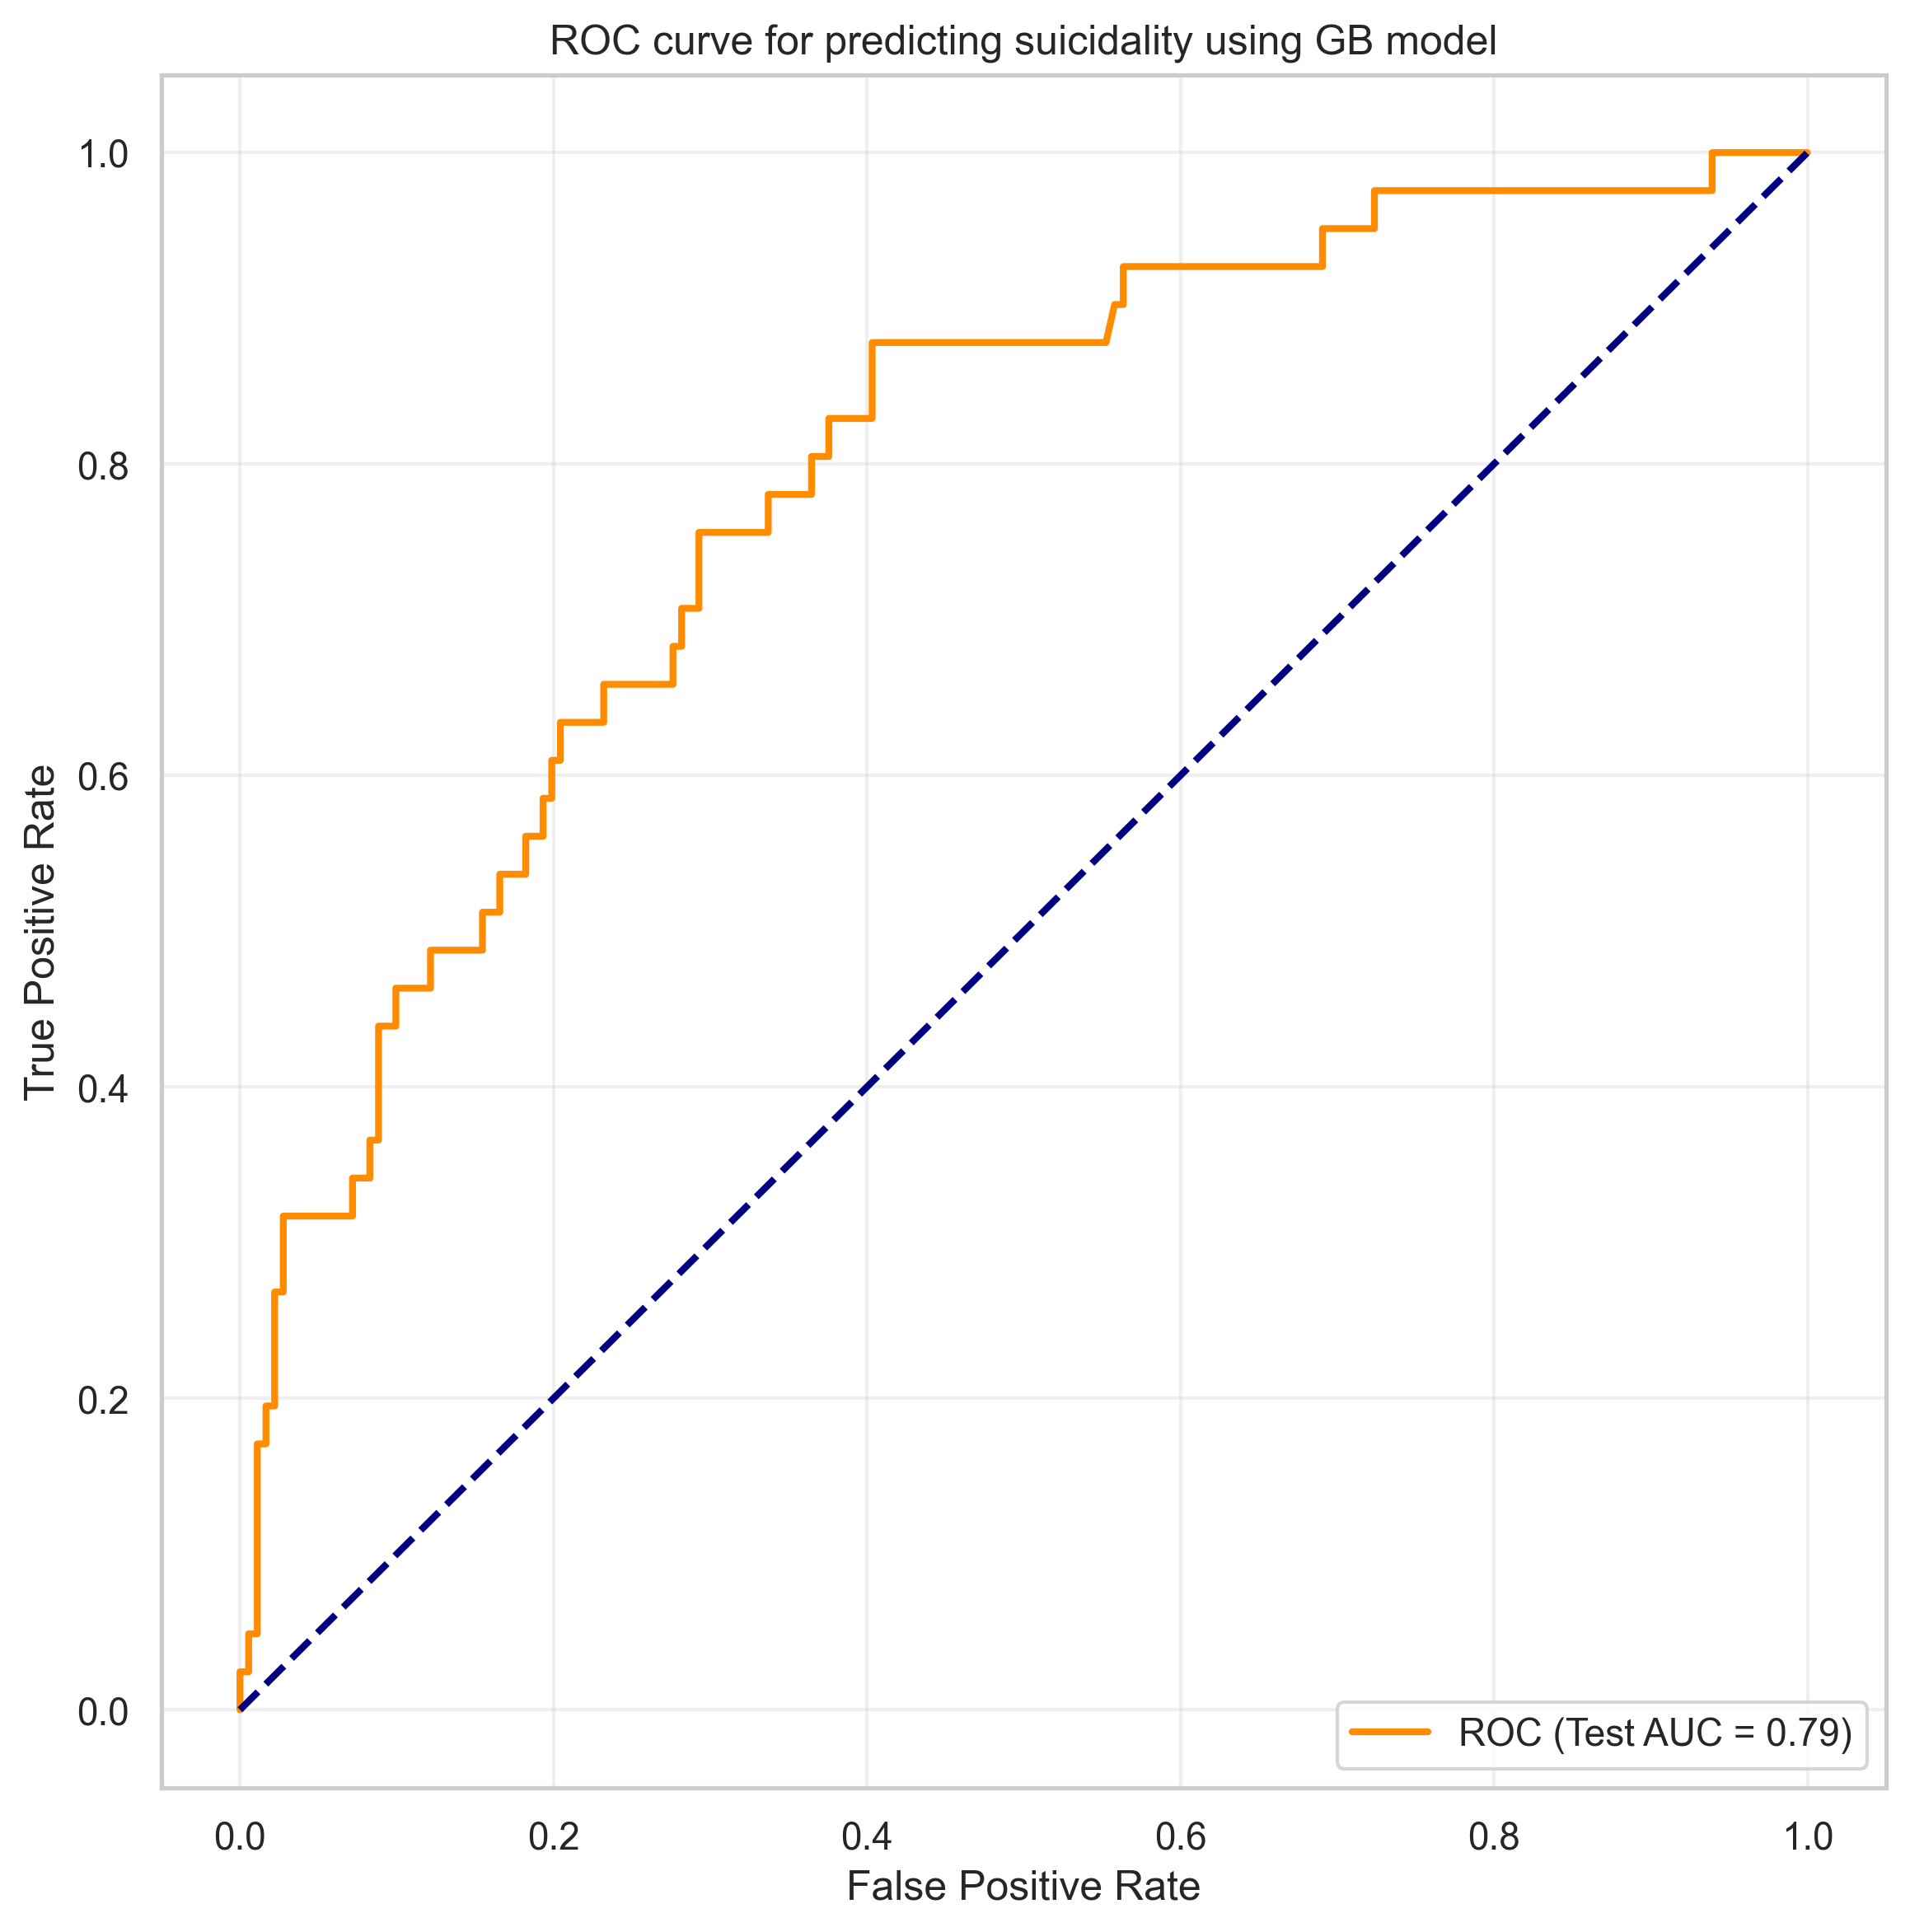

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.99      0.90       181
           1       0.71      0.12      0.21        41

    accuracy                           0.83       222
   macro avg       0.77      0.56      0.56       222
weighted avg       0.81      0.83      0.78       222

Confusion Matrix:
 [[179   2]
 [ 36   5]]
Kappa: 0.16
MCC: 0.25


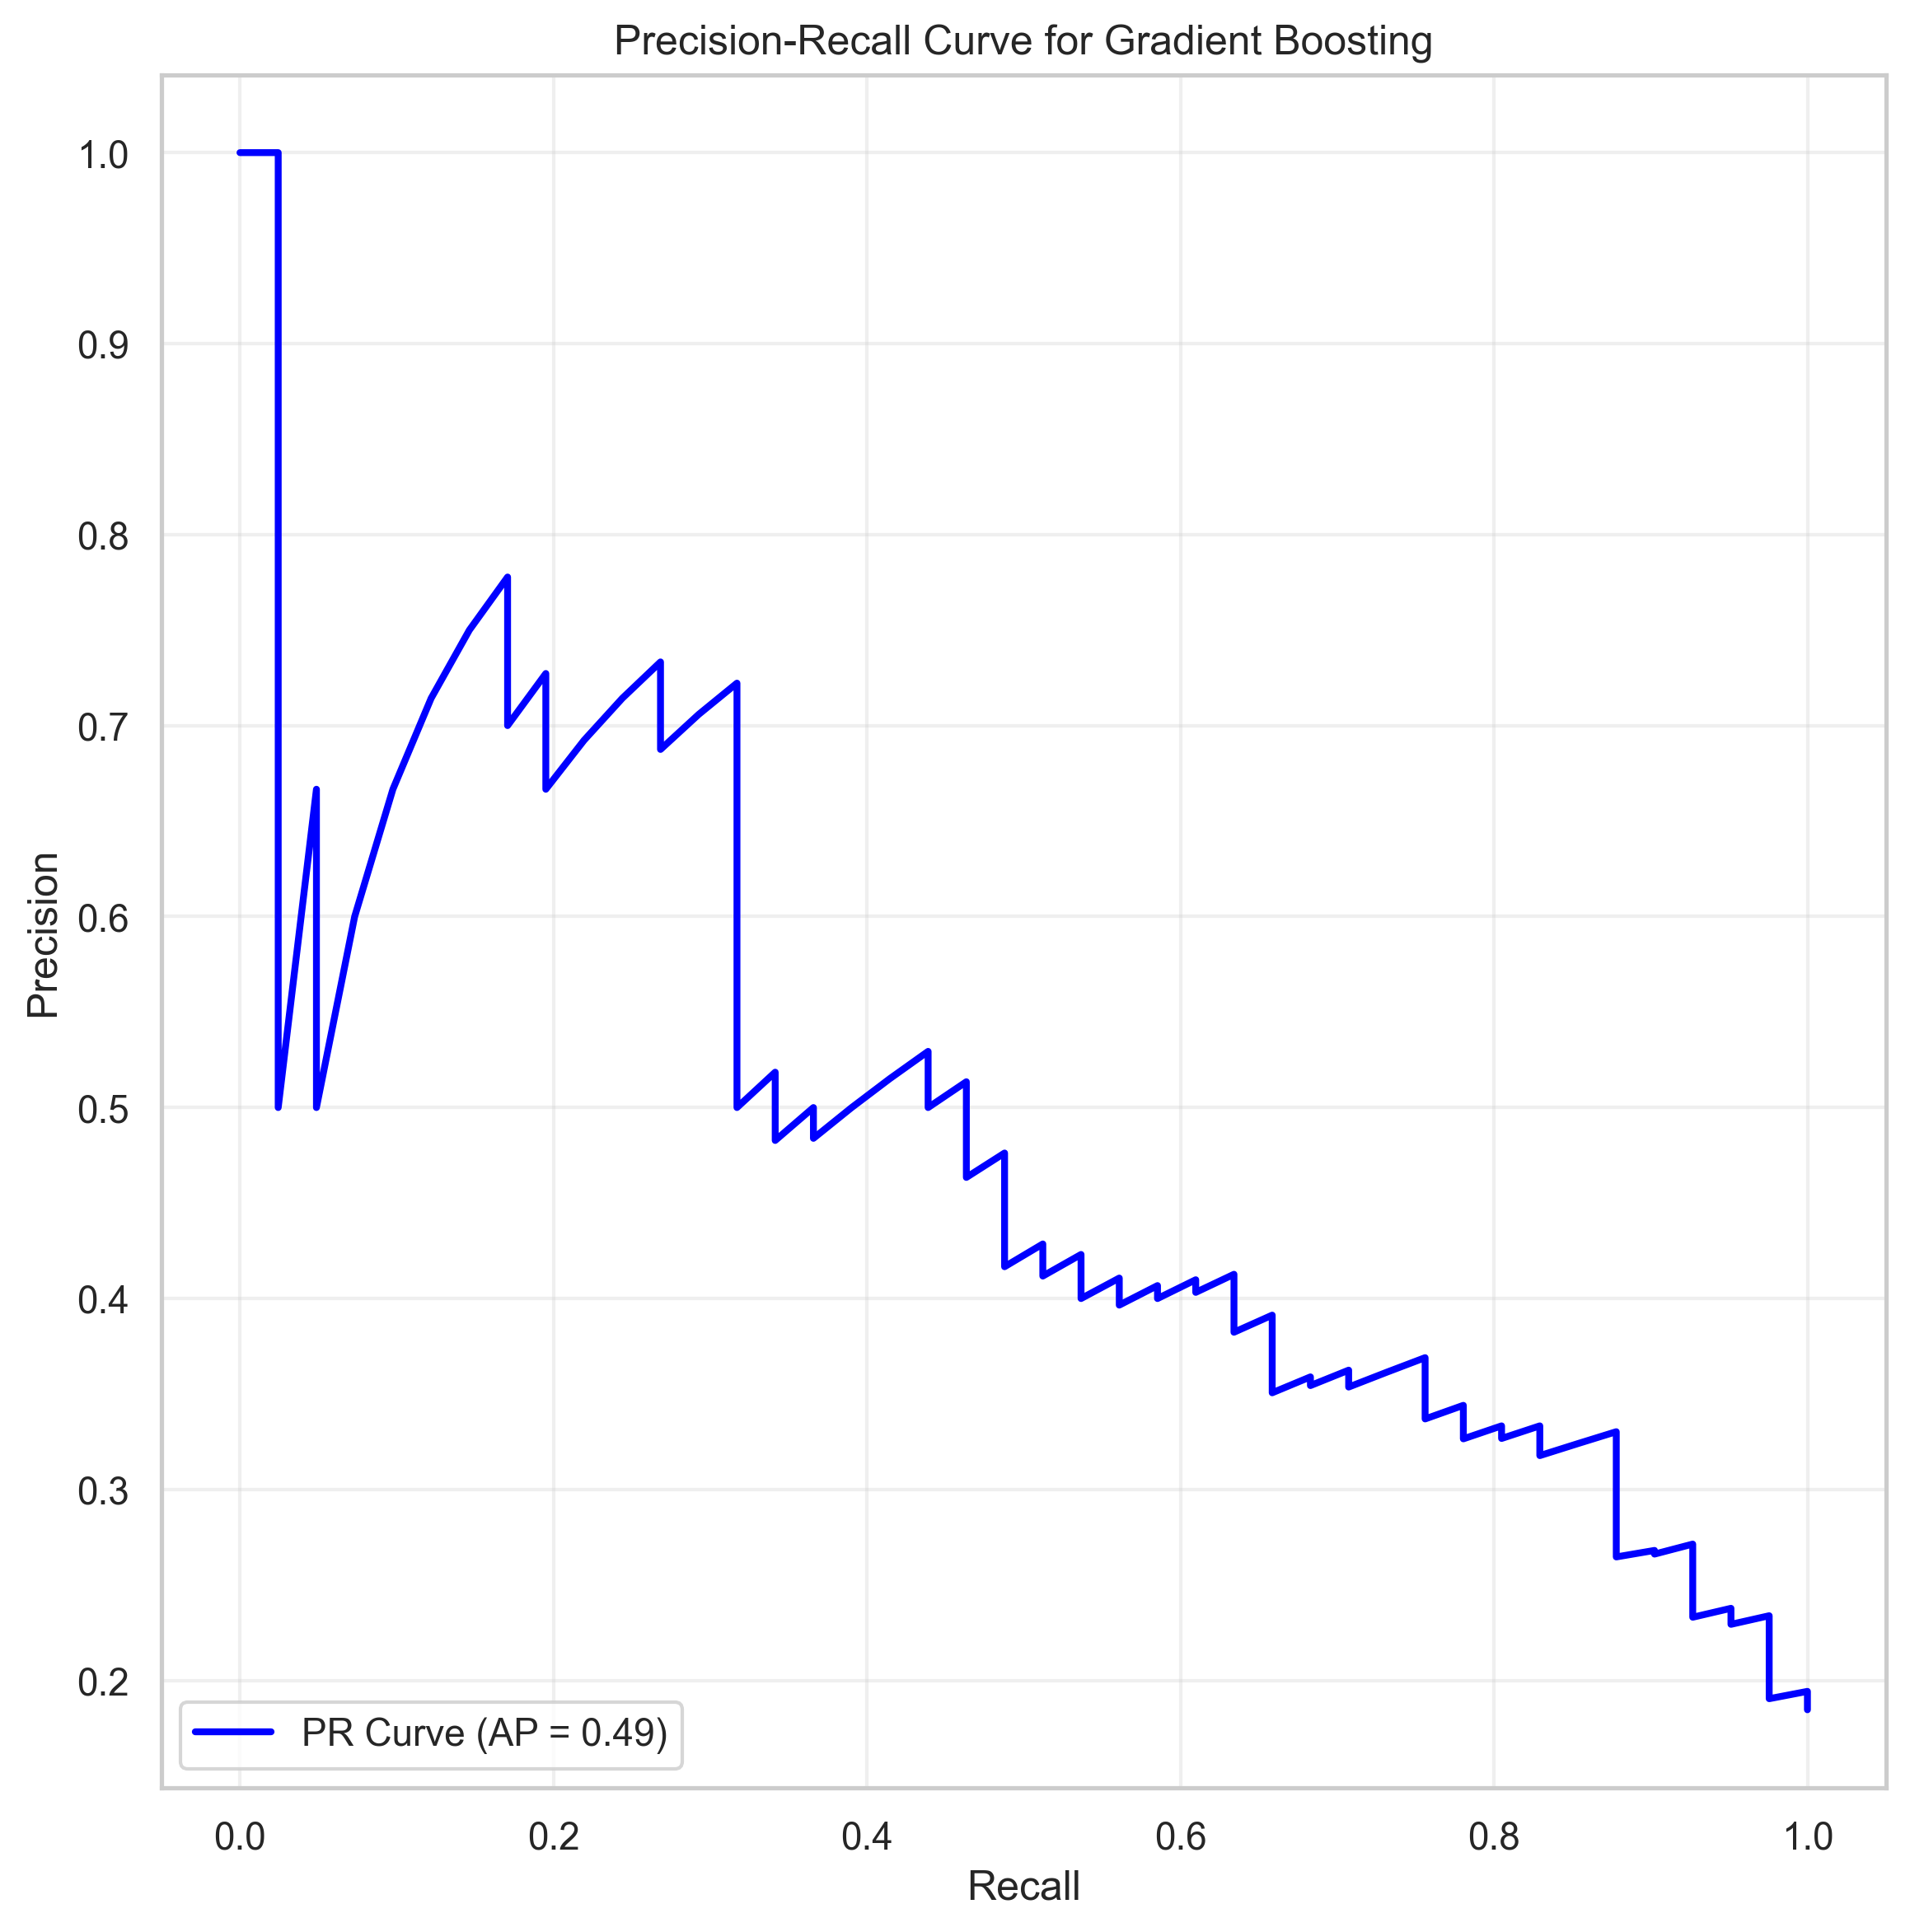

In [59]:
# Define the hyperparameters grid for Gradient Boosting
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
}

# Initialize StratifiedKFold for cross-validation
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=123),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=stratified_kfold,
    n_jobs=-1,
    verbose=1
)

# Ensure inputs are numpy arrays
X_train_transformed = np.array(X_train_transformed)
y_train = np.array(y_train)

# Perform grid search on the training data
grid_search.fit(X_train_transformed, y_train)

# Extract the best hyperparameters and model
best_params = grid_search.best_params_
best_gb_model = grid_search.best_estimator_
print("Best Hyperparameters:", best_params)

# Evaluate on the test set
gb_predictions = best_gb_model.predict(X_test_transformed)
gb_probabilities = best_gb_model.predict_proba(X_test_transformed)[:, 1]

# Calculate test AUC
test_auc = roc_auc_score(y_test, gb_probabilities)
print(f"AUC: {test_auc:.2f}")

# Generate ROC curve using test data
fpr_test, tpr_test, _ = roc_curve(y_test, gb_probabilities)

# Plot the ROC curve for the test data
plt.figure(figsize=(9, 9), dpi=300)
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC (Test AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for predicting suicidality using GB model')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Print evaluation metrics
print("Classification Report:\n", classification_report(y_test, gb_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, gb_predictions))
print(f"Kappa: {cohen_kappa_score(y_test, gb_predictions):.2f}")
print(f"MCC: {matthews_corrcoef(y_test, gb_predictions):.2f}")

# Generate and plot the Precision-Recall curve for the test data
precision, recall, _ = precision_recall_curve(y_test, gb_probabilities)
average_precision = average_precision_score(y_test, gb_probabilities)

# Plot the Precision-Recall curve for the test data
plt.figure(figsize=(9, 9), dpi=300)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Gradient Boosting')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.show()


##### *GB model explanation*

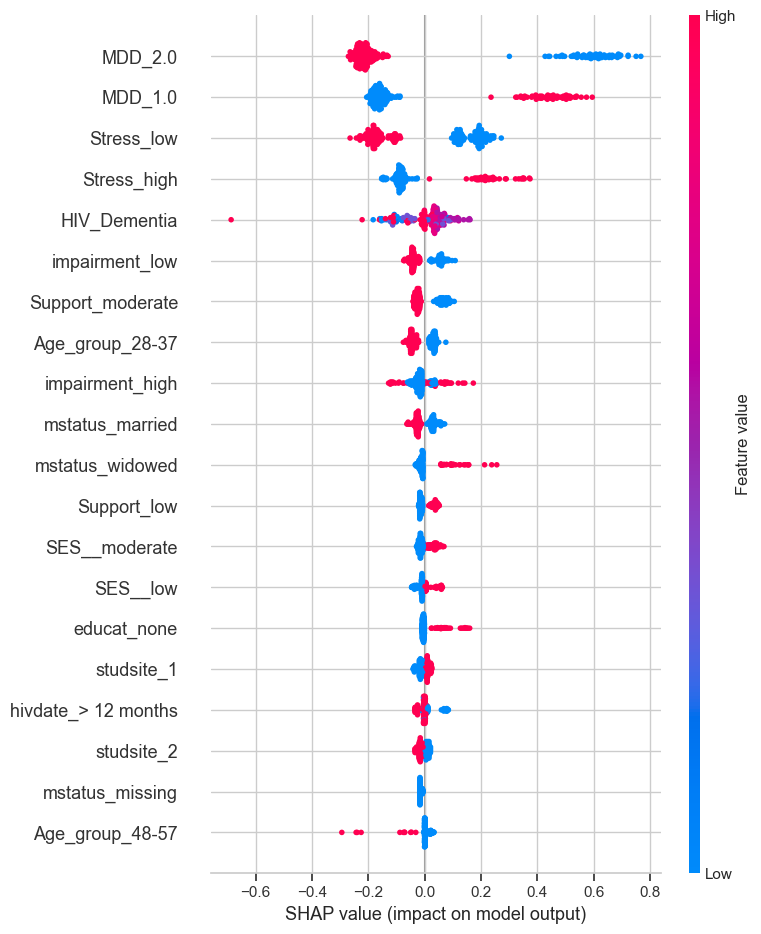

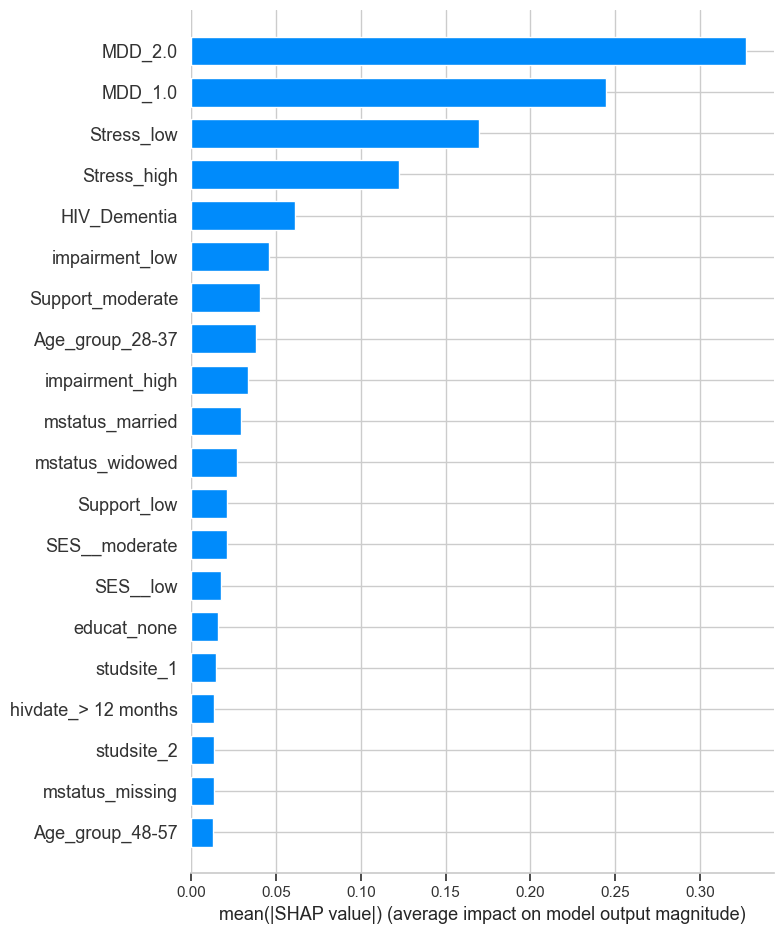

In [60]:
explainer = shap.Explainer(best_gb_model, X_train_transformed)
shap_values = explainer(X_test_transformed)

# Plot summary of SHAP values
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

# Plot feature importance as a bar chart
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names,plot_type="bar")


#### *Correcting for class imbalance in the GB model*

Fitting 10 folds for each of 486 candidates, totalling 4860 fits
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8}
AUC: 0.79


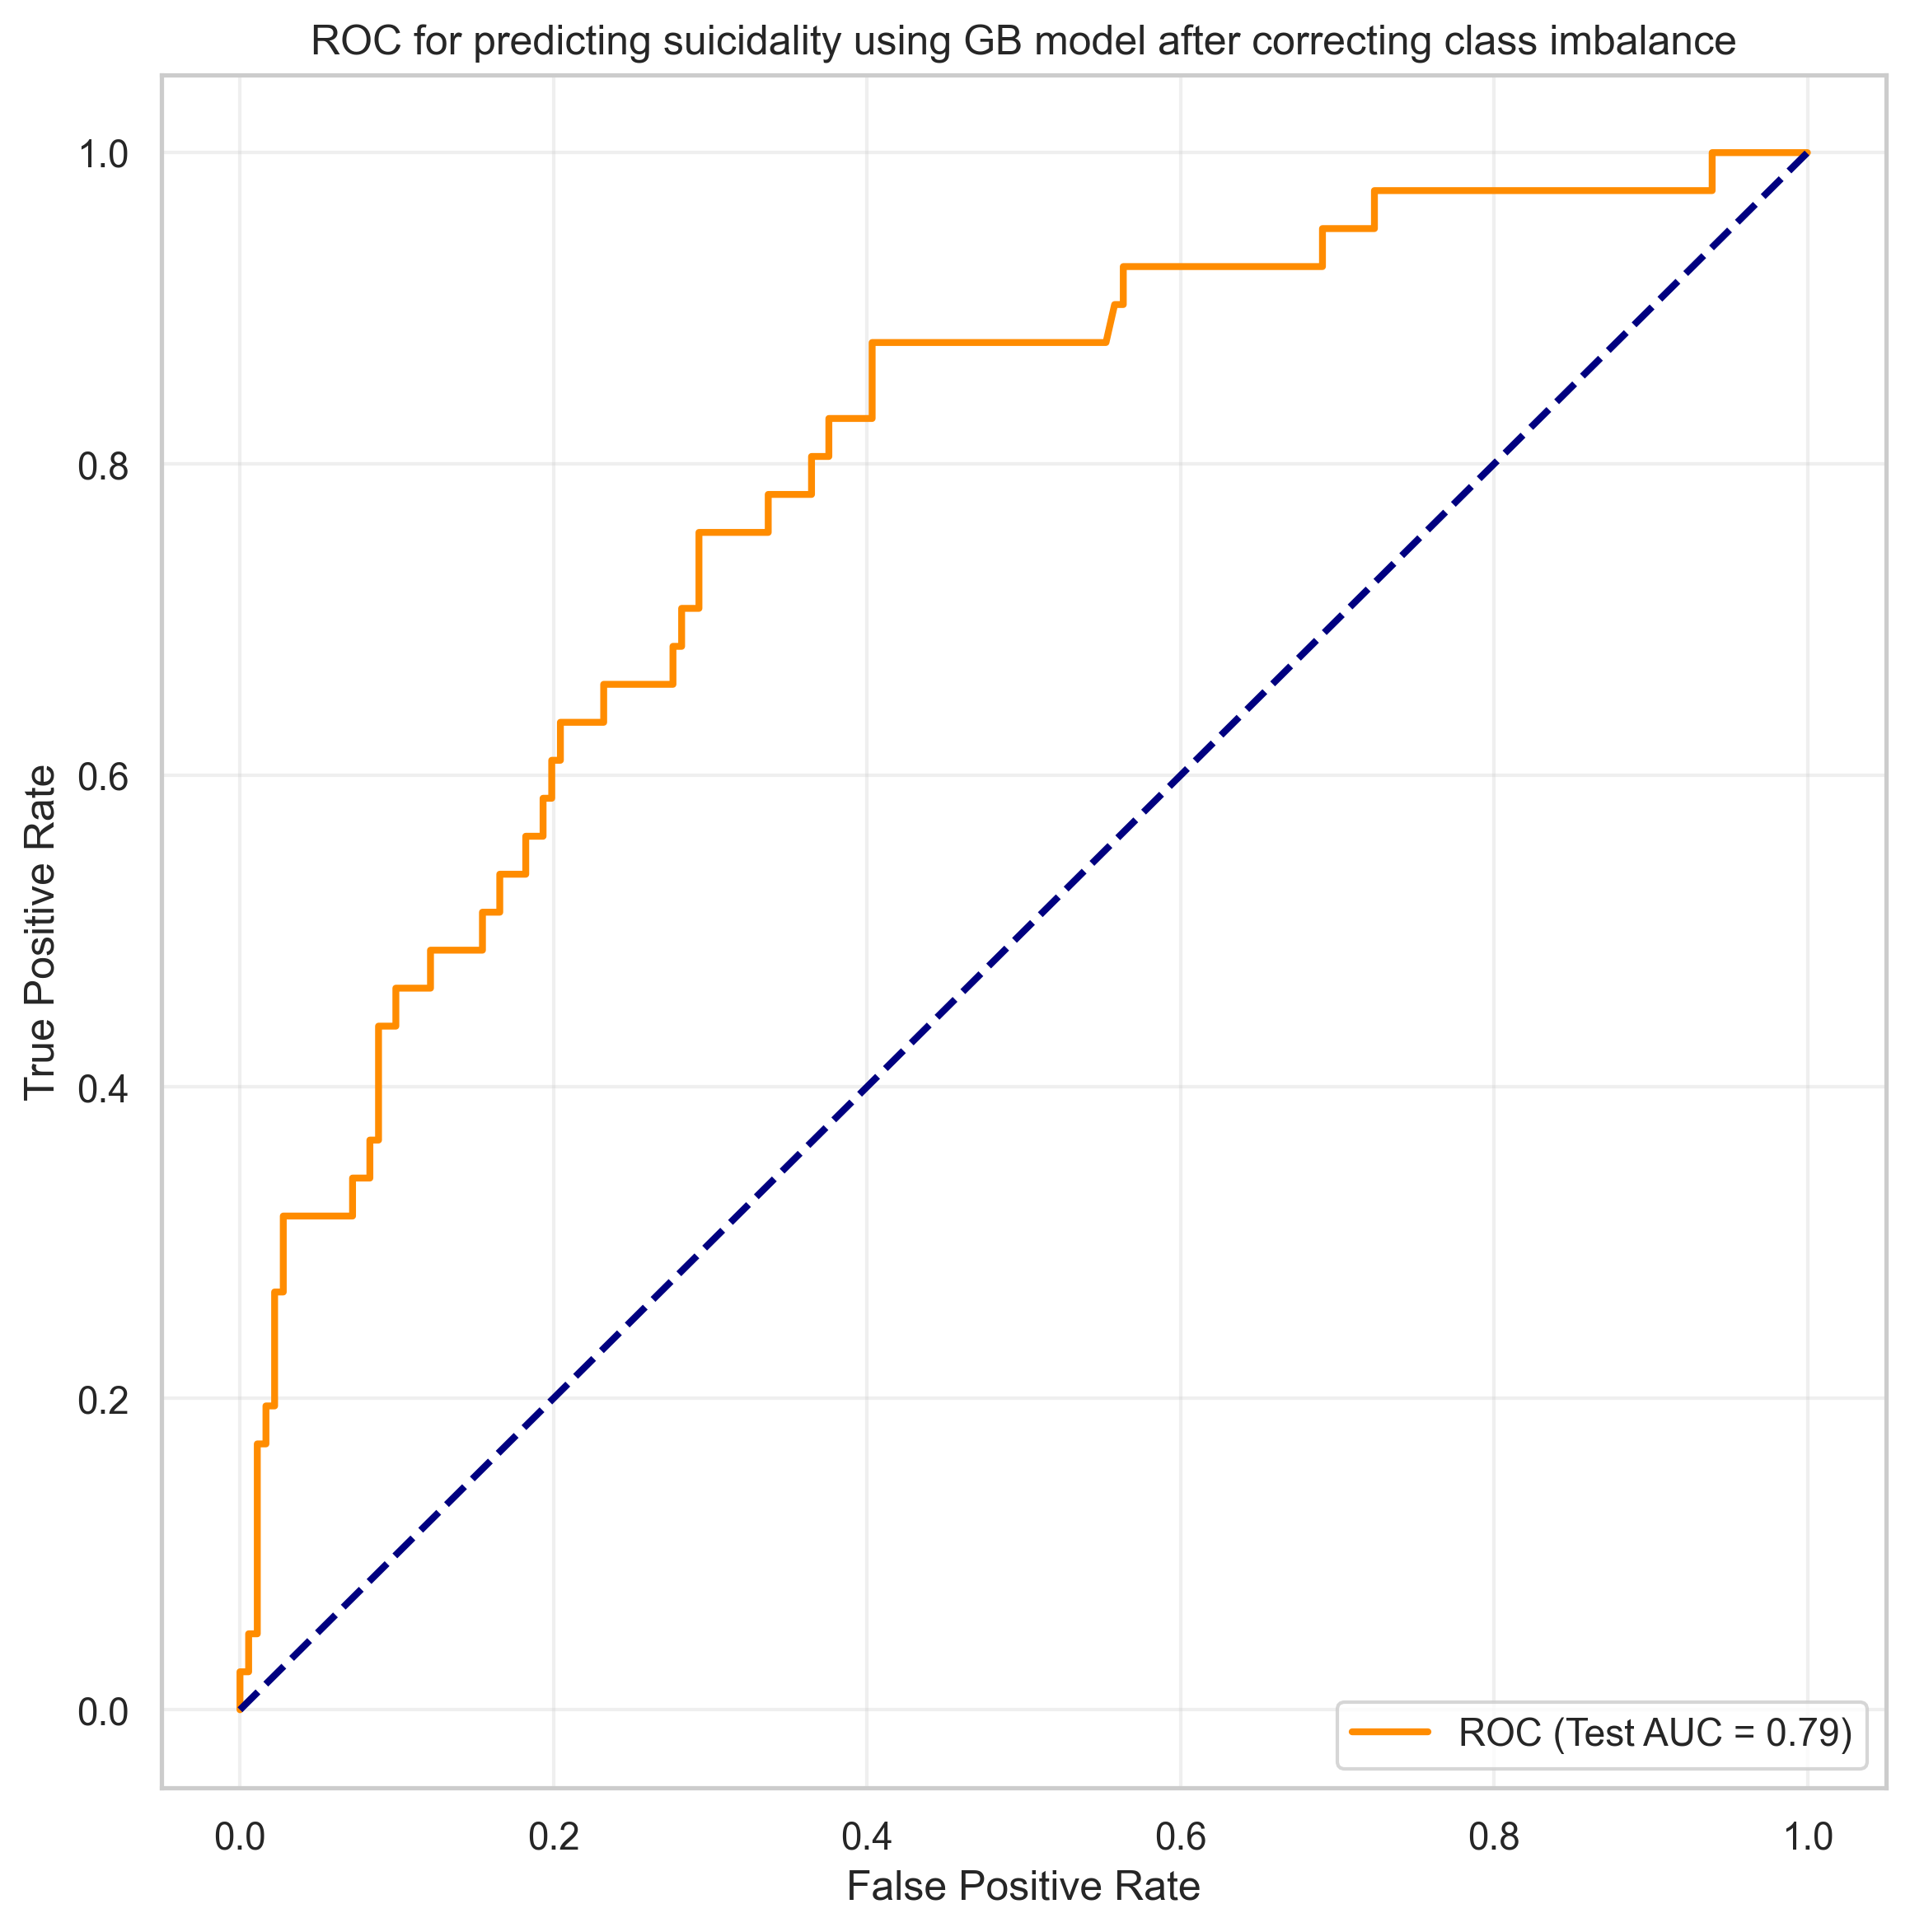

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.99      0.90       181
           1       0.71      0.12      0.21        41

    accuracy                           0.83       222
   macro avg       0.77      0.56      0.56       222
weighted avg       0.81      0.83      0.78       222

Confusion Matrix:
 [[179   2]
 [ 36   5]]
Kappa: 0.16
MCC: 0.25


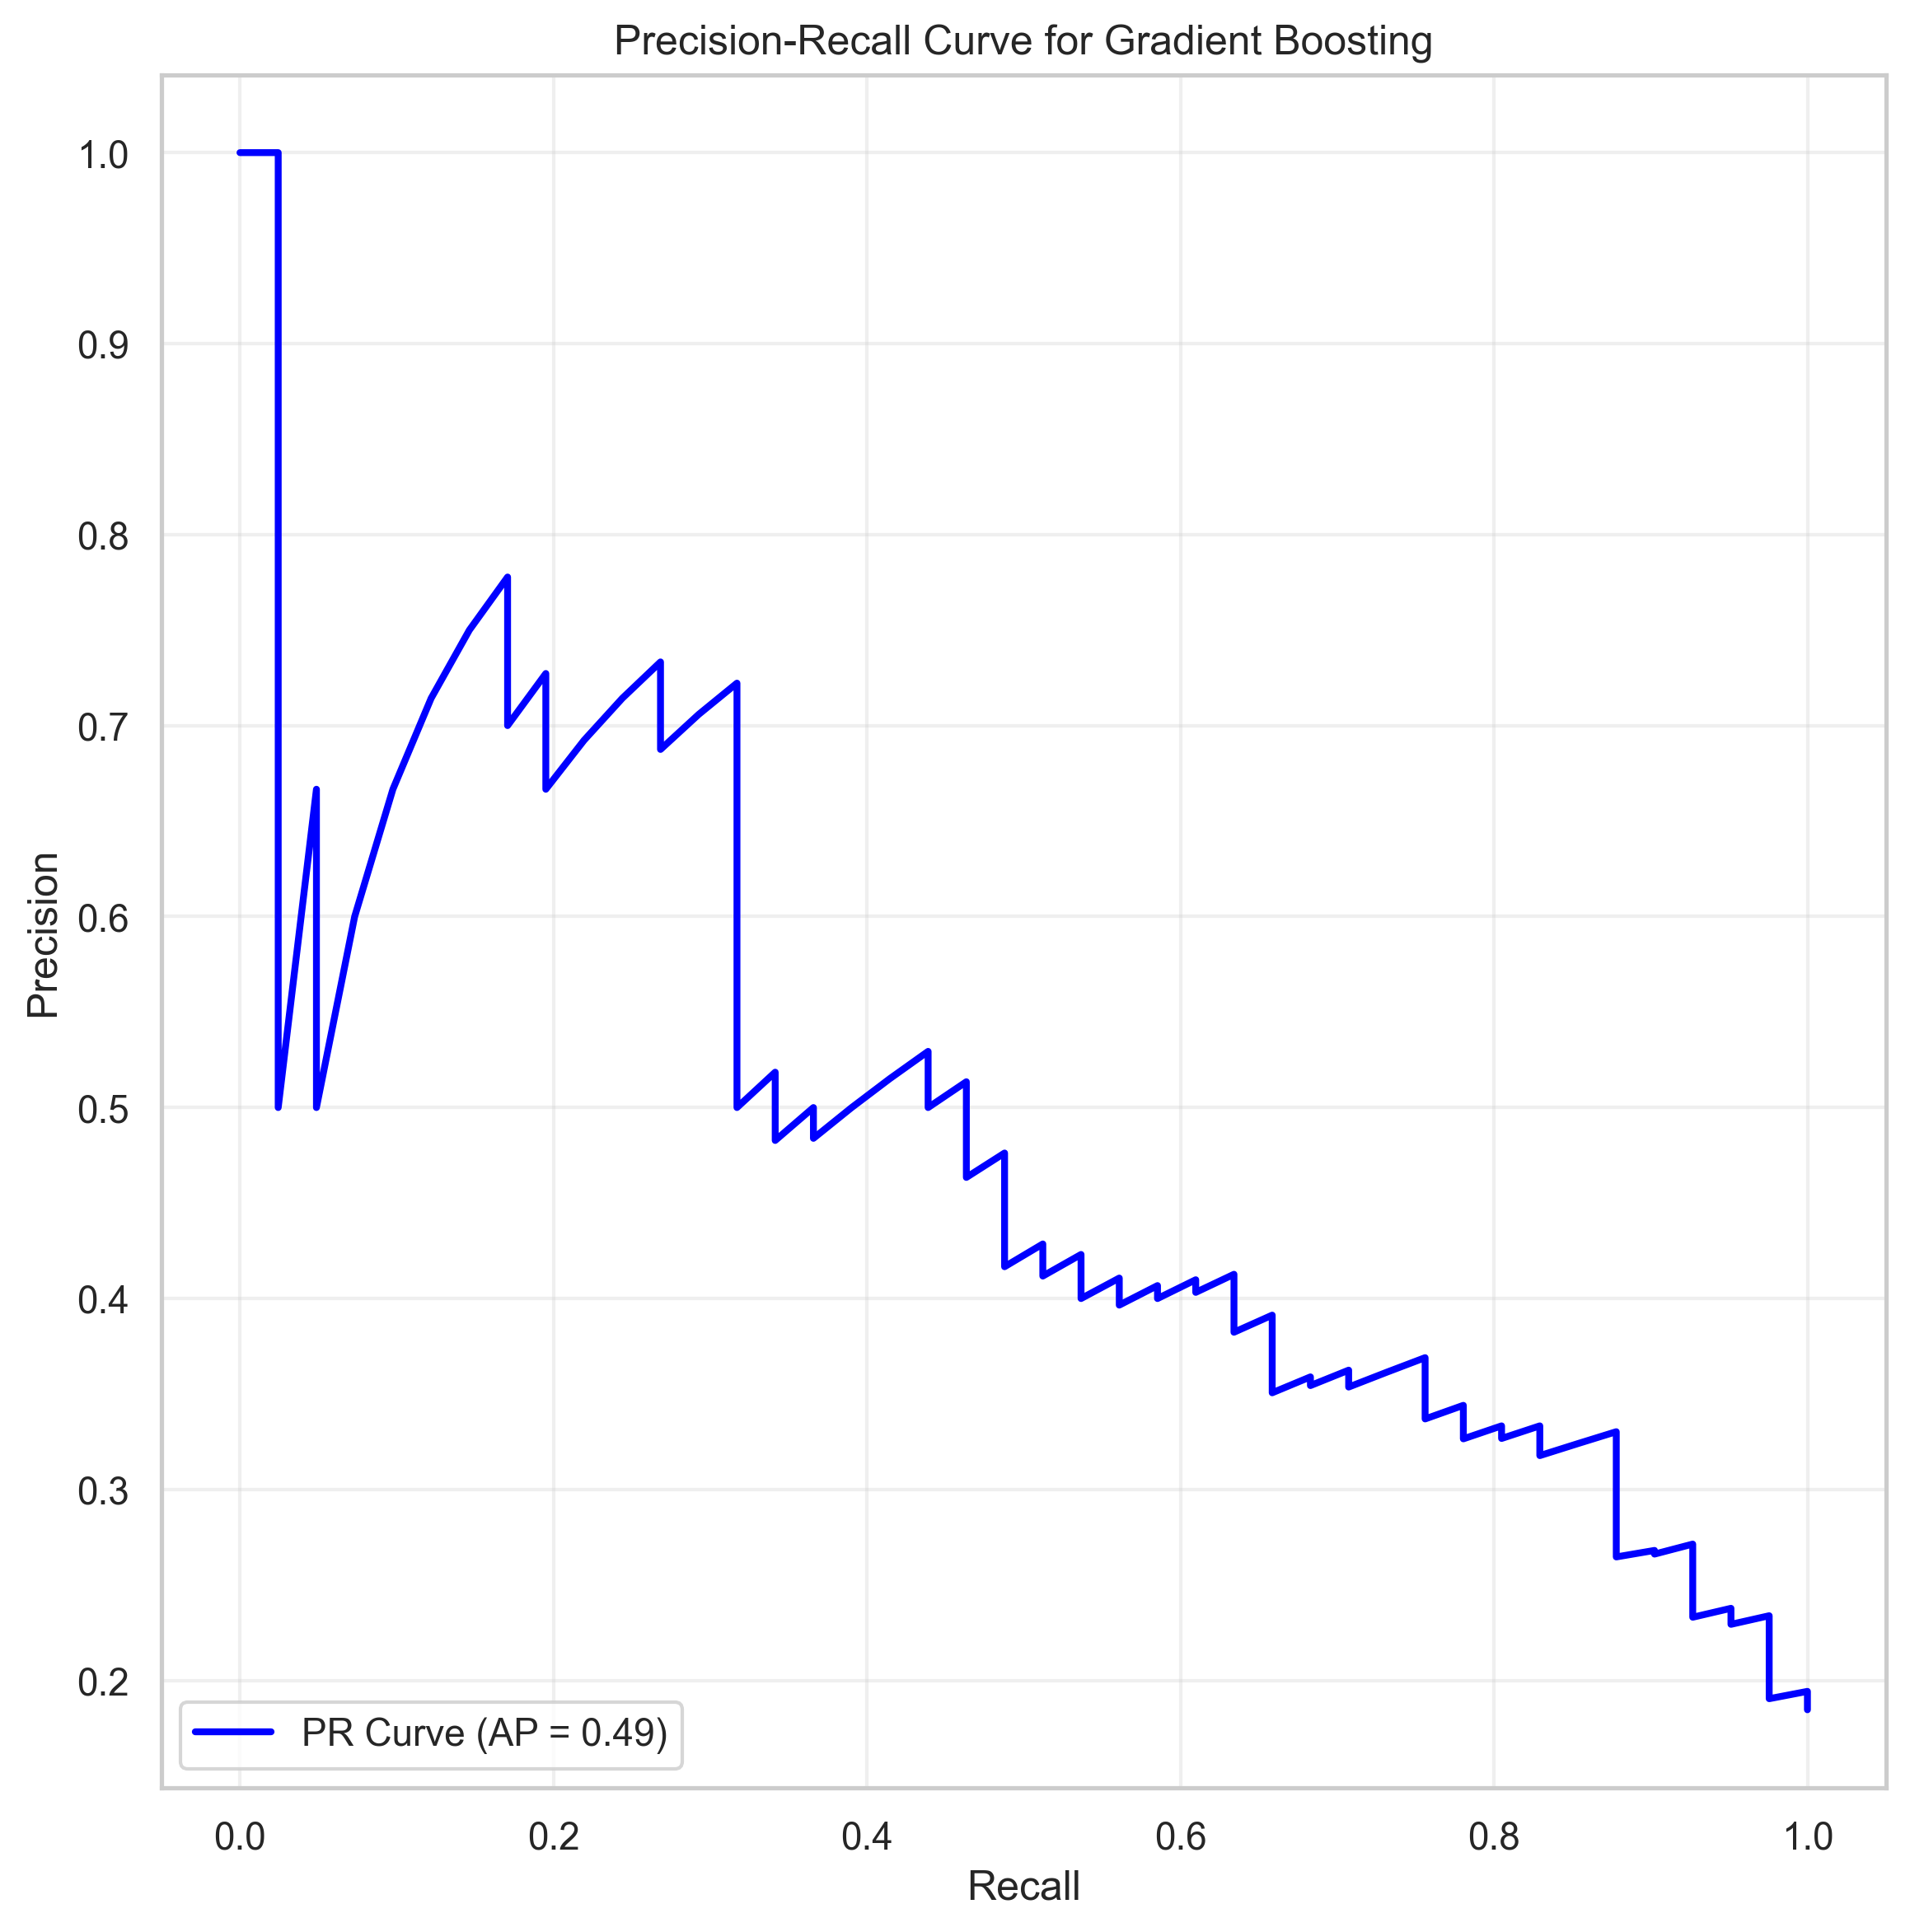

In [61]:
# Define the hyperparameters grid for Gradient Boosting
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Initialize StratifiedKFold for cross-validation
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=123),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=stratified_kfold,
    n_jobs=-1,
    verbose=1
)

# Ensure inputs are numpy arrays
X_train_transformed = np.array(X_train_transformed)
y_train = np.array(y_train)

# Perform grid search on the training data
grid_search.fit(X_train_transformed, y_train)

# Extract the best hyperparameters and model
best_params = grid_search.best_params_
best_gb_model = grid_search.best_estimator_
print("Best Hyperparameters:", best_params)

# Evaluate on the test set
gb_predictions = best_gb_model.predict(X_test_transformed)
gb_probabilities = best_gb_model.predict_proba(X_test_transformed)[:, 1]

# Calculate test AUC
test_auc = roc_auc_score(y_test, gb_probabilities)
print(f"AUC: {test_auc:.2f}")

# Generate ROC curve using test data
fpr_test, tpr_test, _ = roc_curve(y_test, gb_probabilities)

# Plot the ROC curve for the test data
plt.figure(figsize=(9, 9), dpi=300)
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC (Test AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for predicting suicidality using GB model after correcting class imbalance')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Print evaluation metrics
print("Classification Report:\n", classification_report(y_test, gb_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, gb_predictions))
print(f"Kappa: {cohen_kappa_score(y_test, gb_predictions):.2f}")
print(f"MCC: {matthews_corrcoef(y_test, gb_predictions):.2f}")

# Generate and plot the Precision-Recall curve for the test data
precision, recall, _ = precision_recall_curve(y_test, gb_probabilities)
average_precision = average_precision_score(y_test, gb_probabilities)

# Plot the Precision-Recall curve for the test data
plt.figure(figsize=(9, 9), dpi=300)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Gradient Boosting')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.show()


##### *Adaboost model*

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Best Hyperparameters: {'learning_rate': 0.1, 'n_estimators': 50}
AUC: 0.79


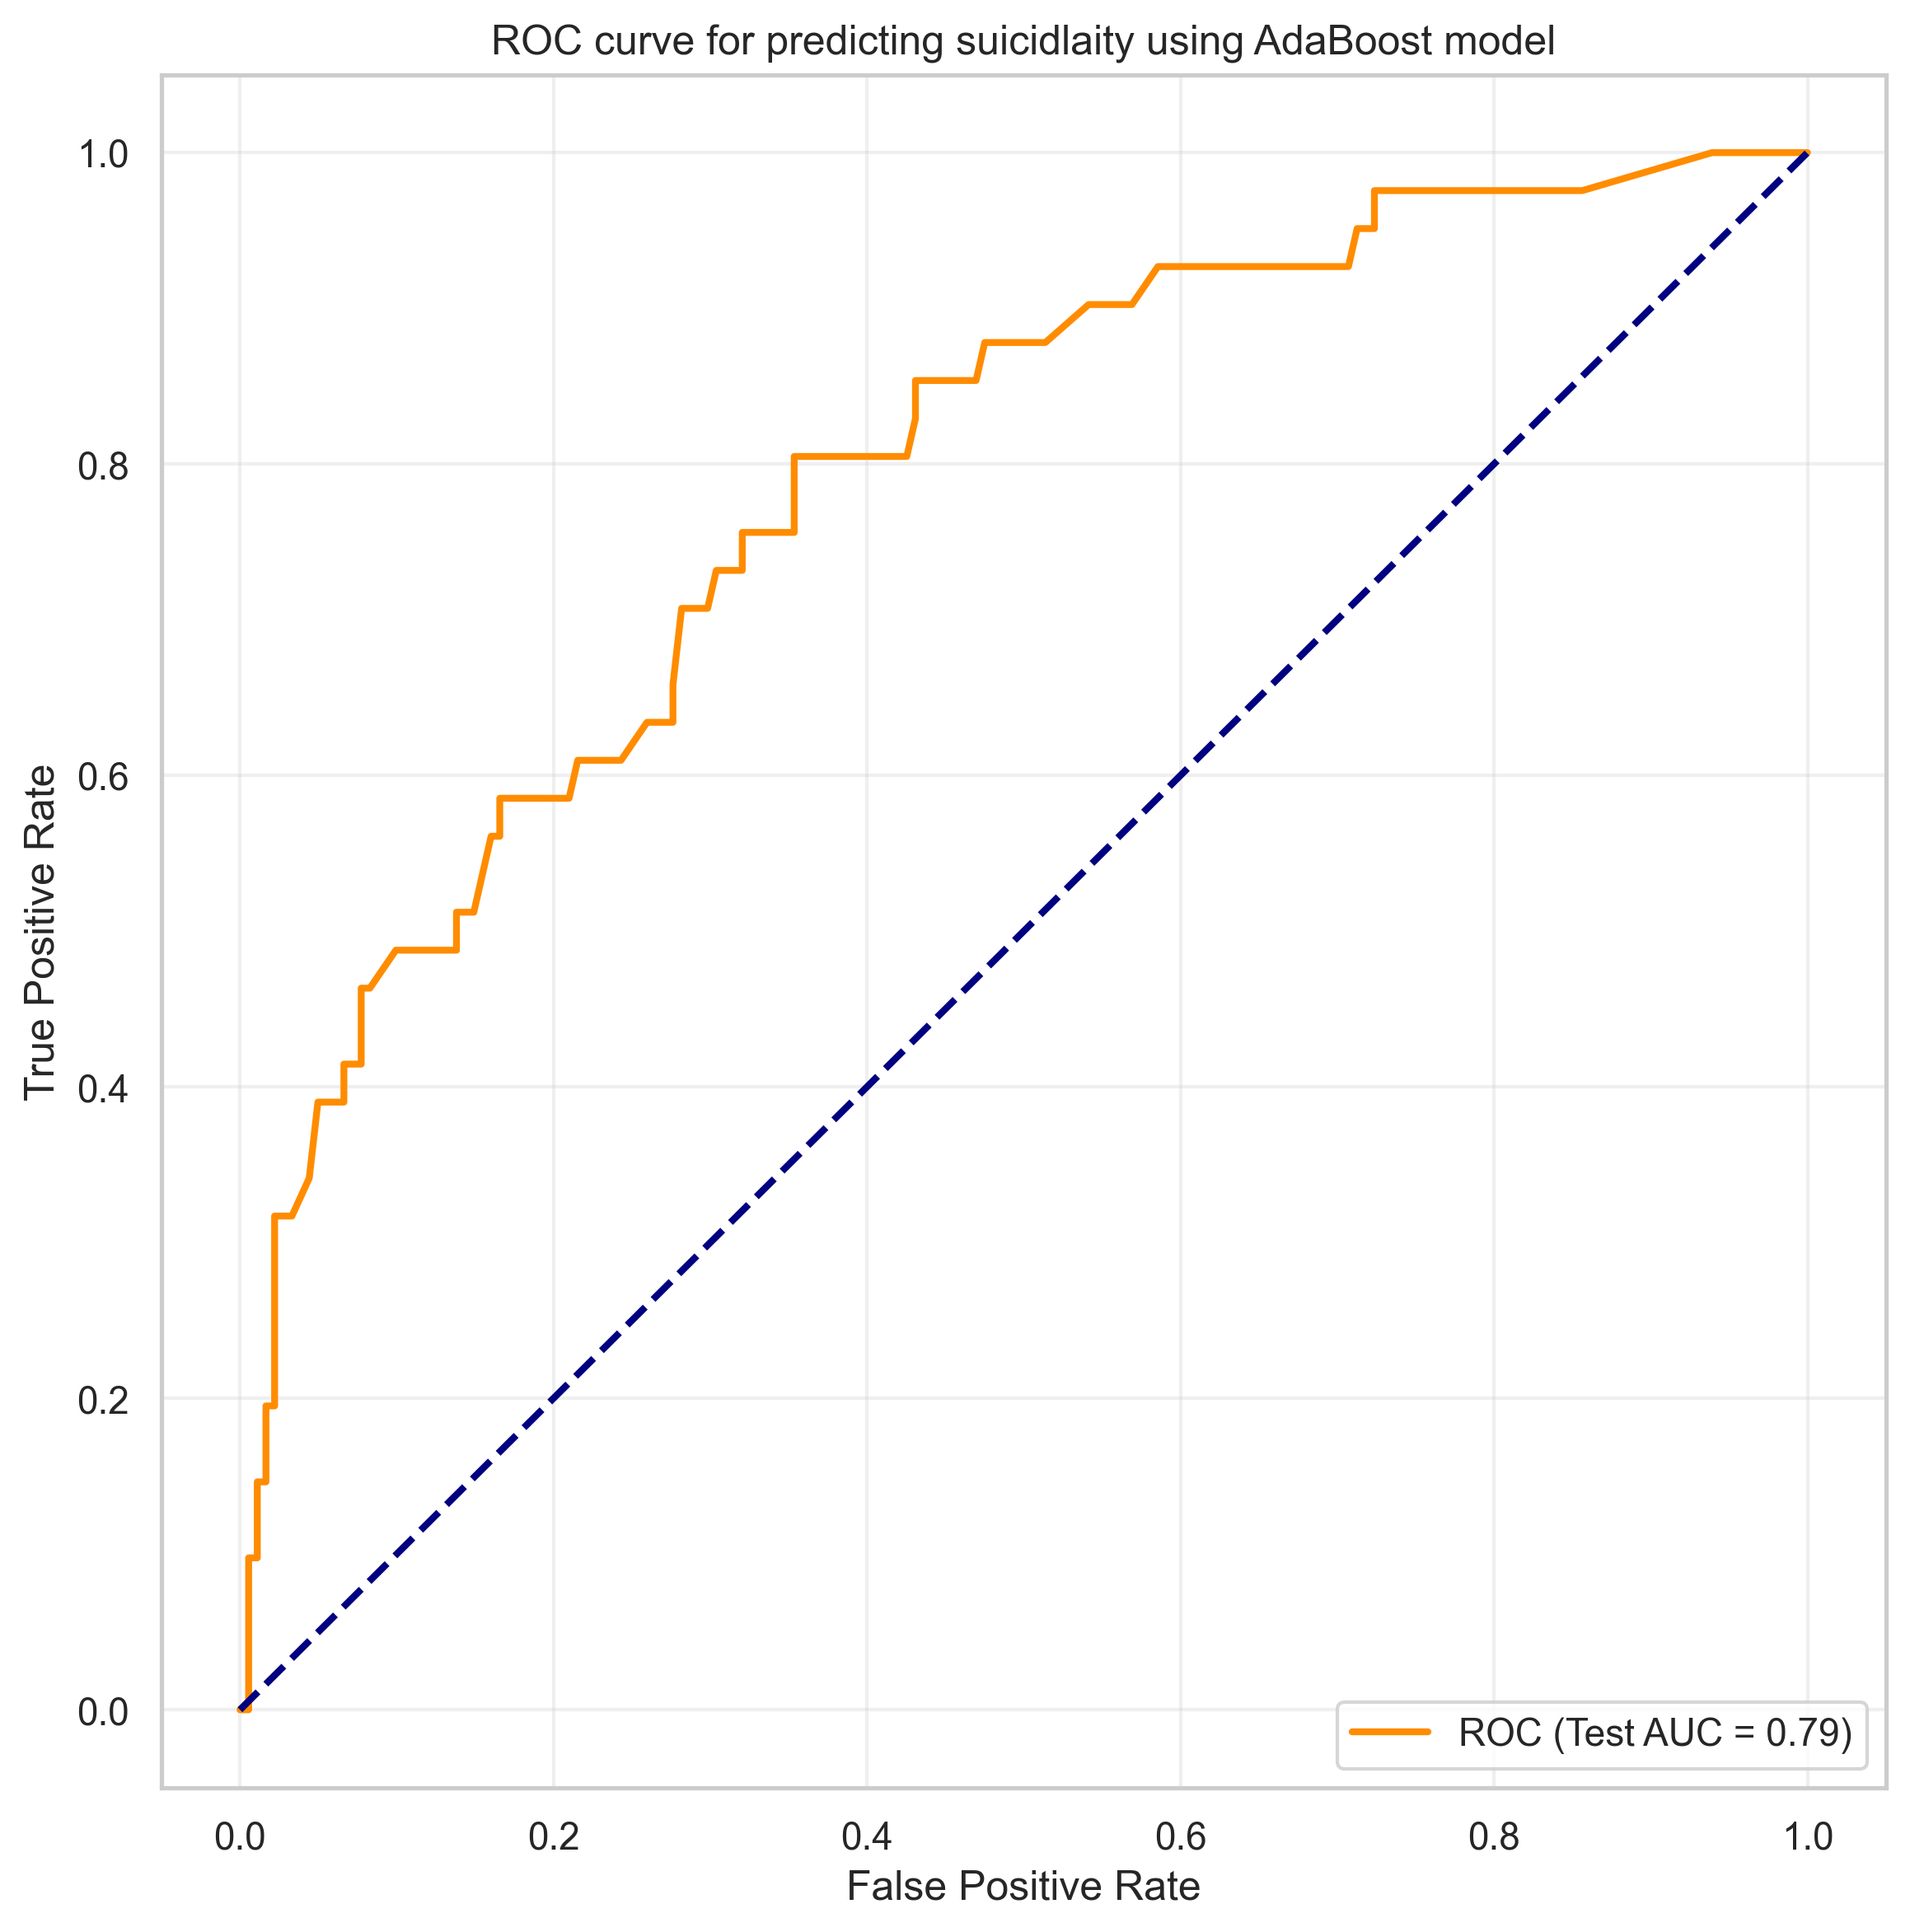

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.98      0.90       181
           1       0.67      0.15      0.24        41

    accuracy                           0.83       222
   macro avg       0.75      0.56      0.57       222
weighted avg       0.80      0.83      0.78       222

Confusion Matrix:
 [[178   3]
 [ 35   6]]
Kappa: 0.19
MCC: 0.26


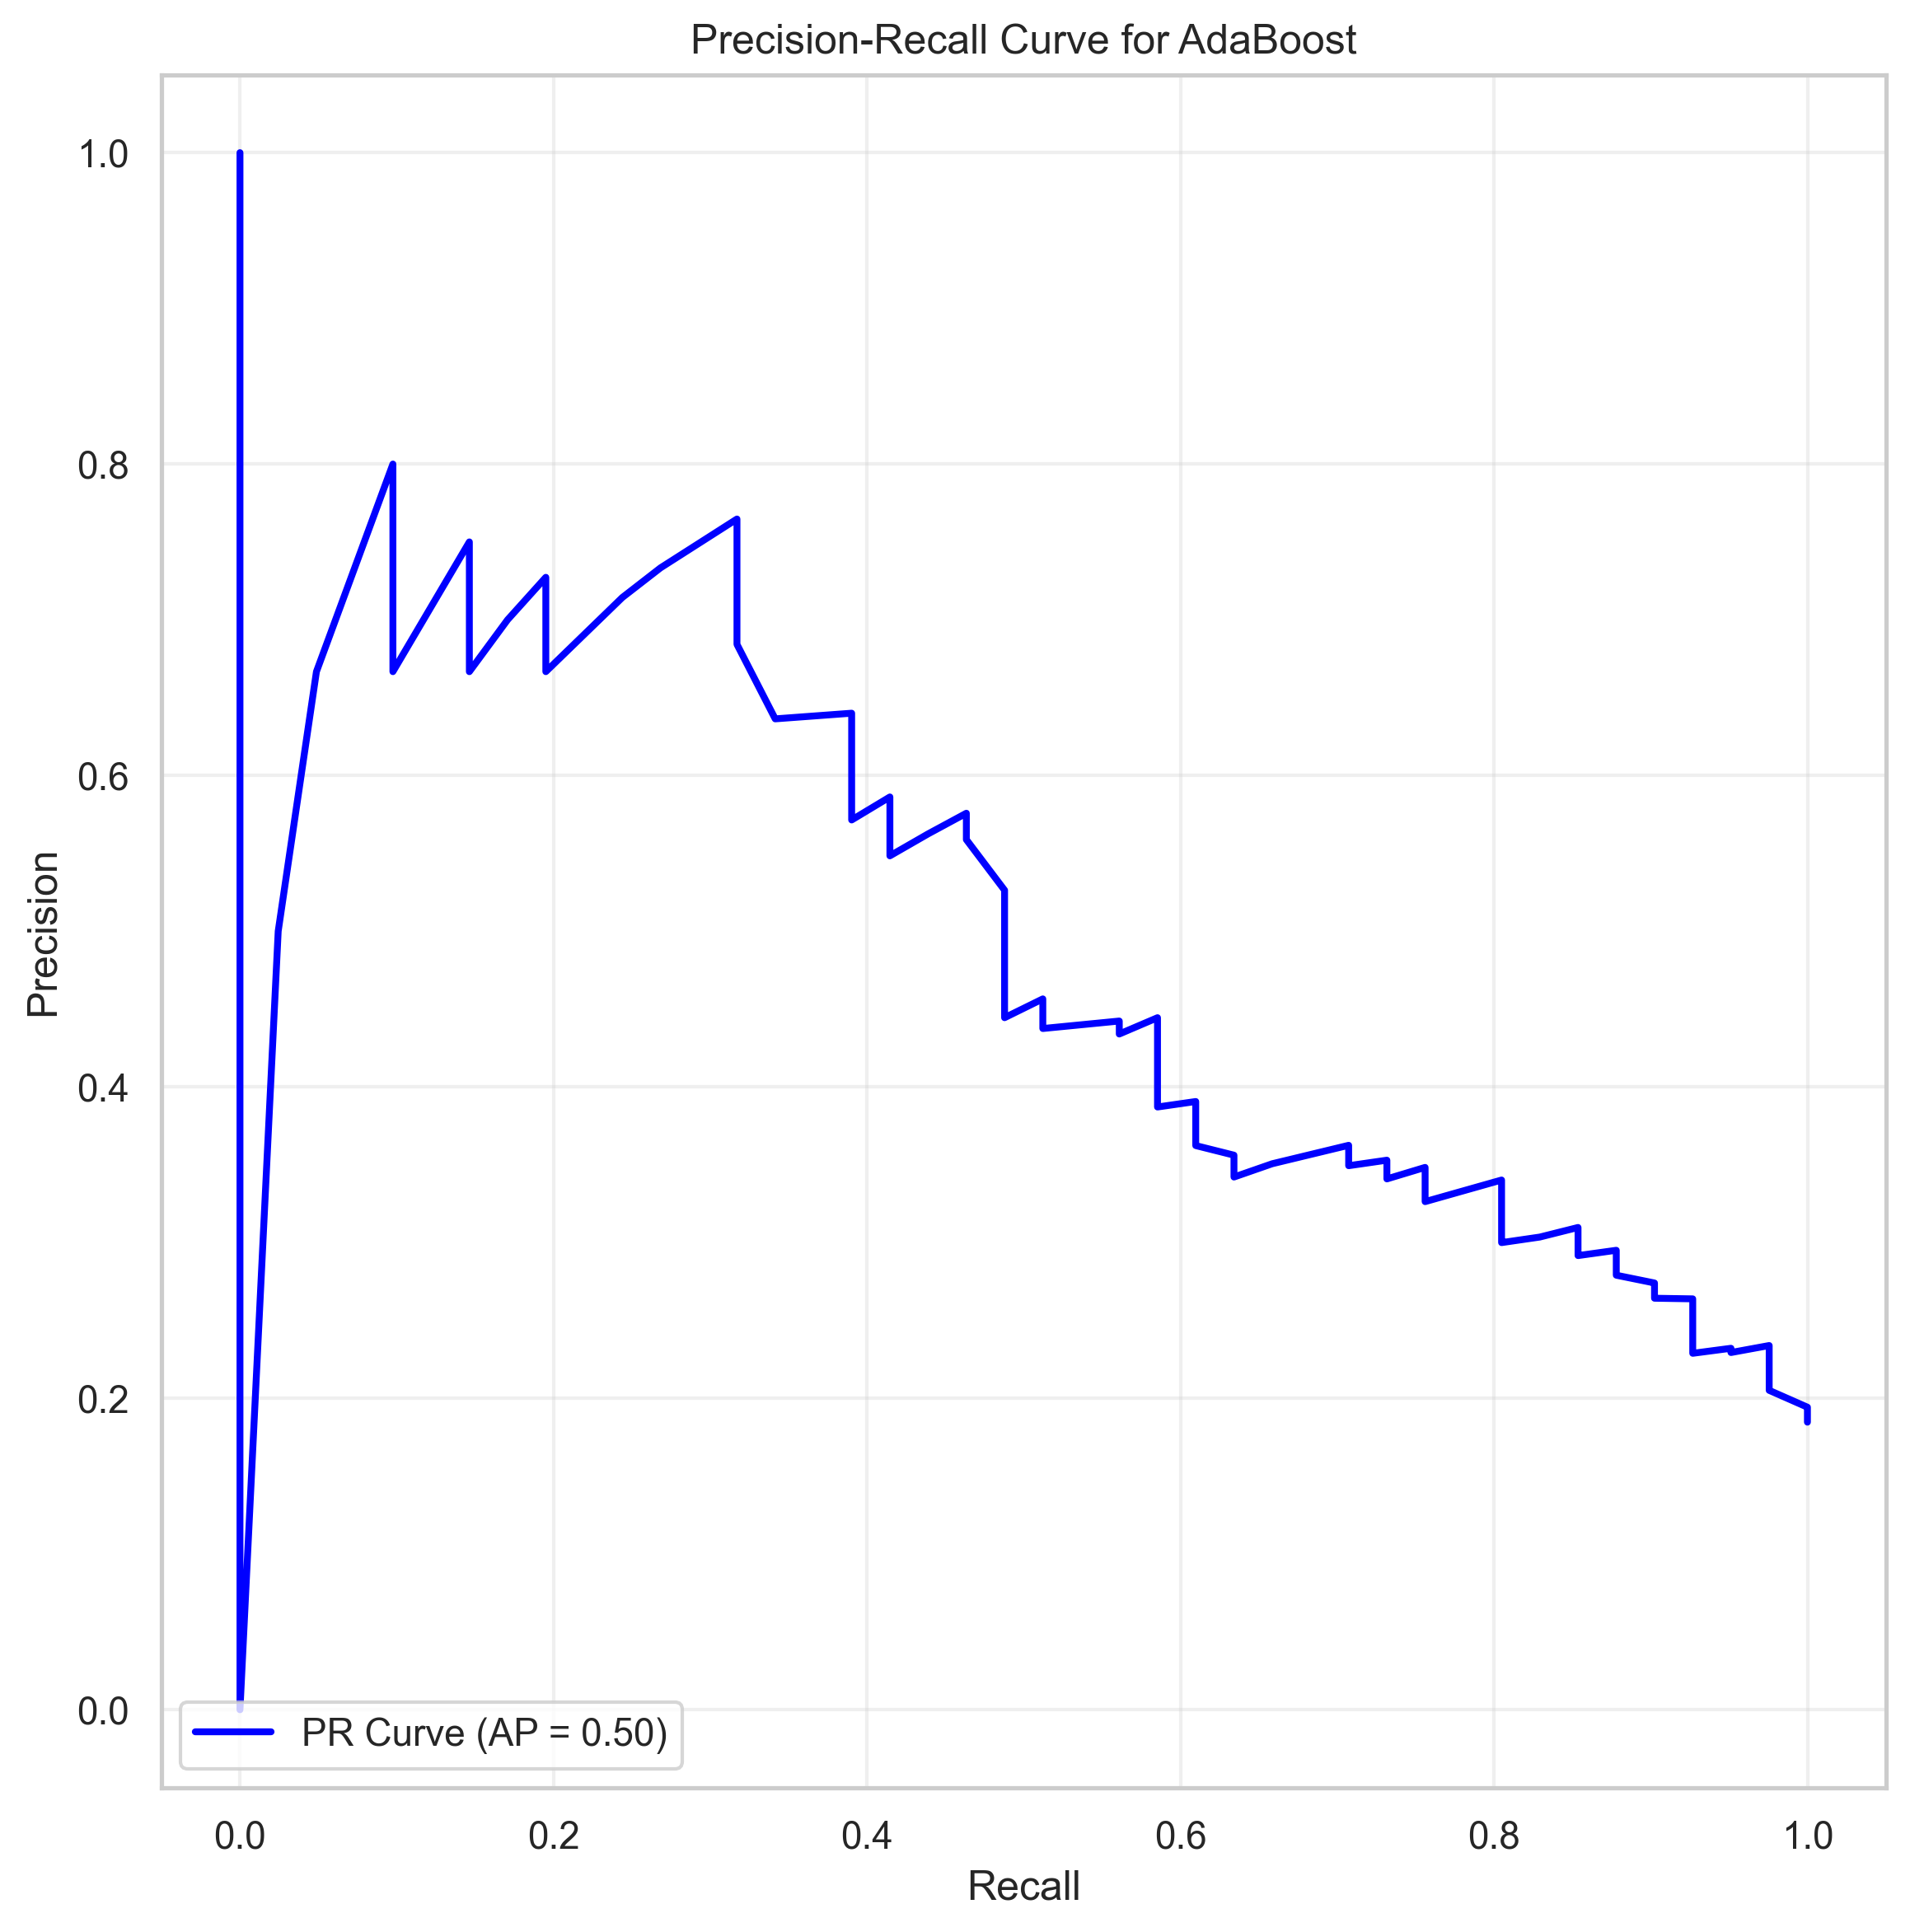

In [62]:
# Define the hyperparameters grid for AdaBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
}

# Initialize StratifiedKFold for cross-validation
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=AdaBoostClassifier(random_state=123),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=stratified_kfold,
    n_jobs=-1,
    verbose=1
)

# Ensure inputs are numpy arrays
X_train_transformed = np.array(X_train_transformed)
y_train = np.array(y_train)

# Perform grid search on the training data
grid_search.fit(X_train_transformed, y_train)

# Extract the best hyperparameters and model
best_params = grid_search.best_params_
best_ad_model = grid_search.best_estimator_
print("Best Hyperparameters:", best_params)

# Evaluate on the test set
ada_predictions = best_ad_model.predict(X_test_transformed)
ada_probabilities = best_ad_model.predict_proba(X_test_transformed)[:, 1]

# Calculate test AUC
test_auc = roc_auc_score(y_test, ada_probabilities)
print(f"AUC: {test_auc:.2f}")

# Generate ROC curve using test data
fpr_test, tpr_test, _ = roc_curve(y_test, ada_probabilities)

# Plot the ROC curve for the test data
plt.figure(figsize=(9, 9), dpi=300)
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC (Test AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for predicting suicidlaity using AdaBoost model')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Print evaluation metrics
print("Classification Report:\n", classification_report(y_test, ada_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, ada_predictions))
print(f"Kappa: {cohen_kappa_score(y_test, ada_predictions):.2f}")
print(f"MCC: {matthews_corrcoef(y_test, ada_predictions):.2f}")

# Generate and plot the Precision-Recall curve for the test data
precision, recall, _ = precision_recall_curve(y_test, ada_probabilities)
average_precision = average_precision_score(y_test, ada_probabilities)

# Plot the Precision-Recall curve for the test data
plt.figure(figsize=(9, 9), dpi=300)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for AdaBoost')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.show()

#### *Model explanation*

  0%|          | 0/222 [00:00<?, ?it/s]

Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=2.201e-07, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.


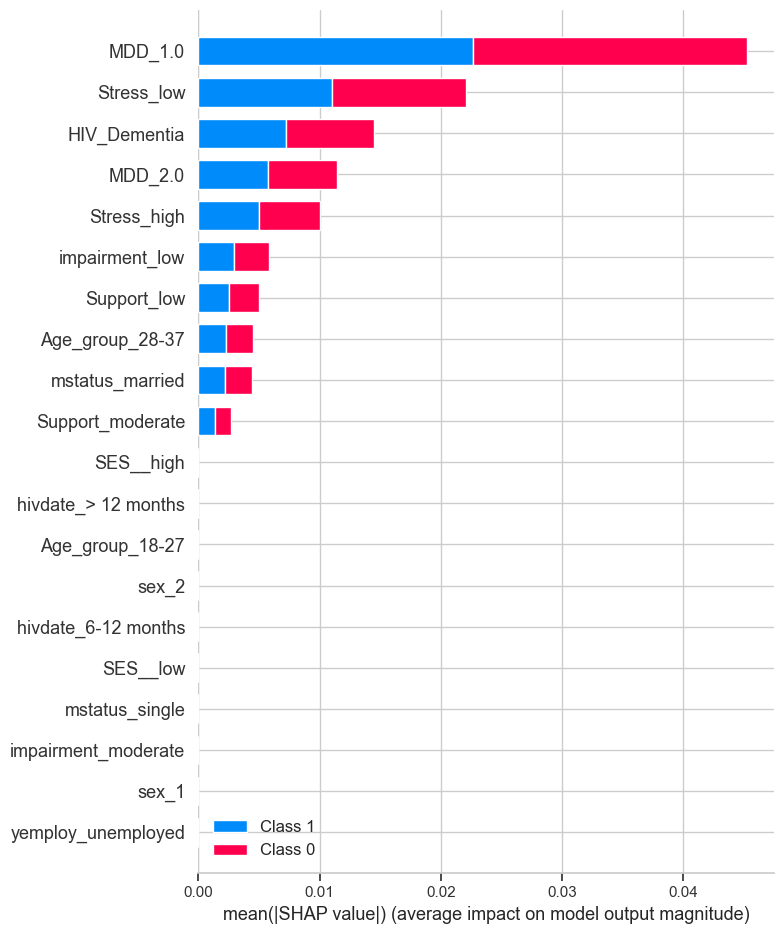

In [63]:
#Define a wrapper function for the AdaBoost model's predict_proba method
def model_predict(data):
    return best_ad_model.predict_proba(data)

# Use shap.kmeans to reduce the background data 
background_data = shap.kmeans(X_train_transformed, 100)

# Initialize SHAP explainer using KernelExplainer with the k-means reduced background data
explainer = shap.KernelExplainer(model_predict, background_data)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_transformed, nsamples=100)

# Generate a bar plot for SHAP values
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, plot_type='bar')


#### *Correcting for class imbalance in Adaboost*

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Best Hyperparameters: {'learning_rate': 0.1, 'n_estimators': 50}
AUC: 0.79


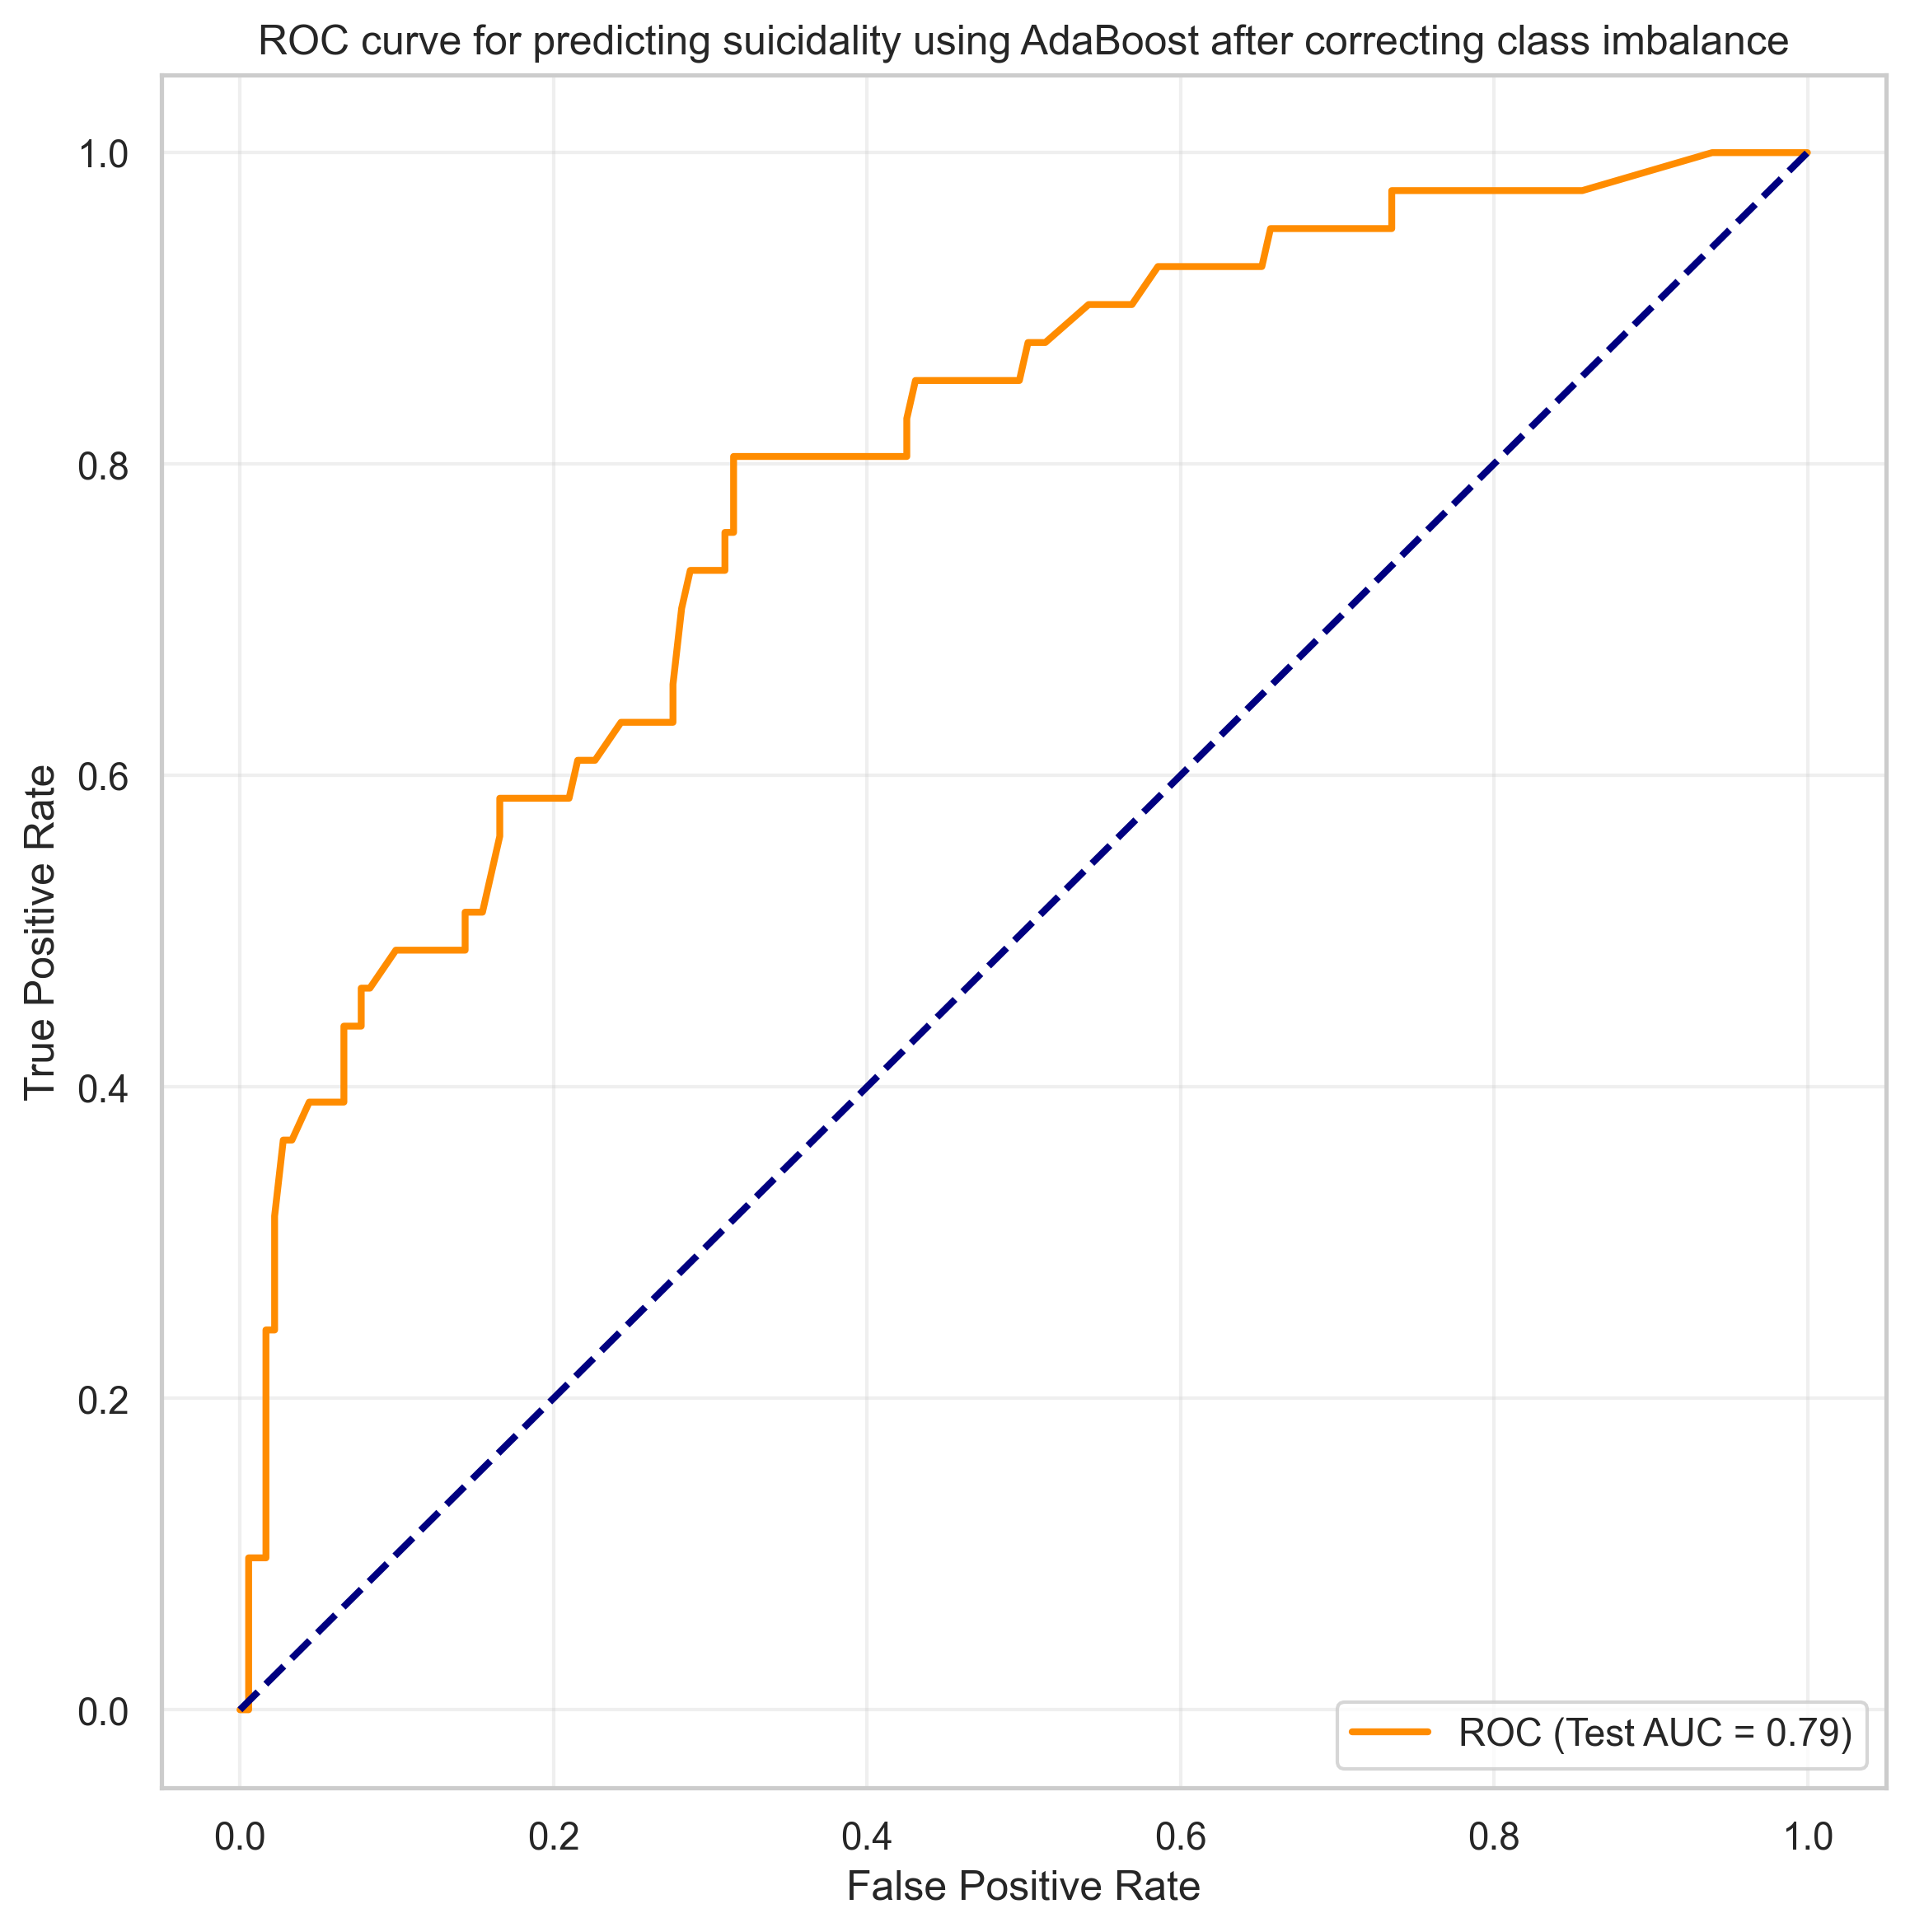

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.80      0.84       181
           1       0.39      0.59      0.47        41

    accuracy                           0.76       222
   macro avg       0.64      0.69      0.66       222
weighted avg       0.80      0.76      0.77       222

Confusion Matrix:
 [[144  37]
 [ 17  24]]
Kappa: 0.32
MCC: 0.33


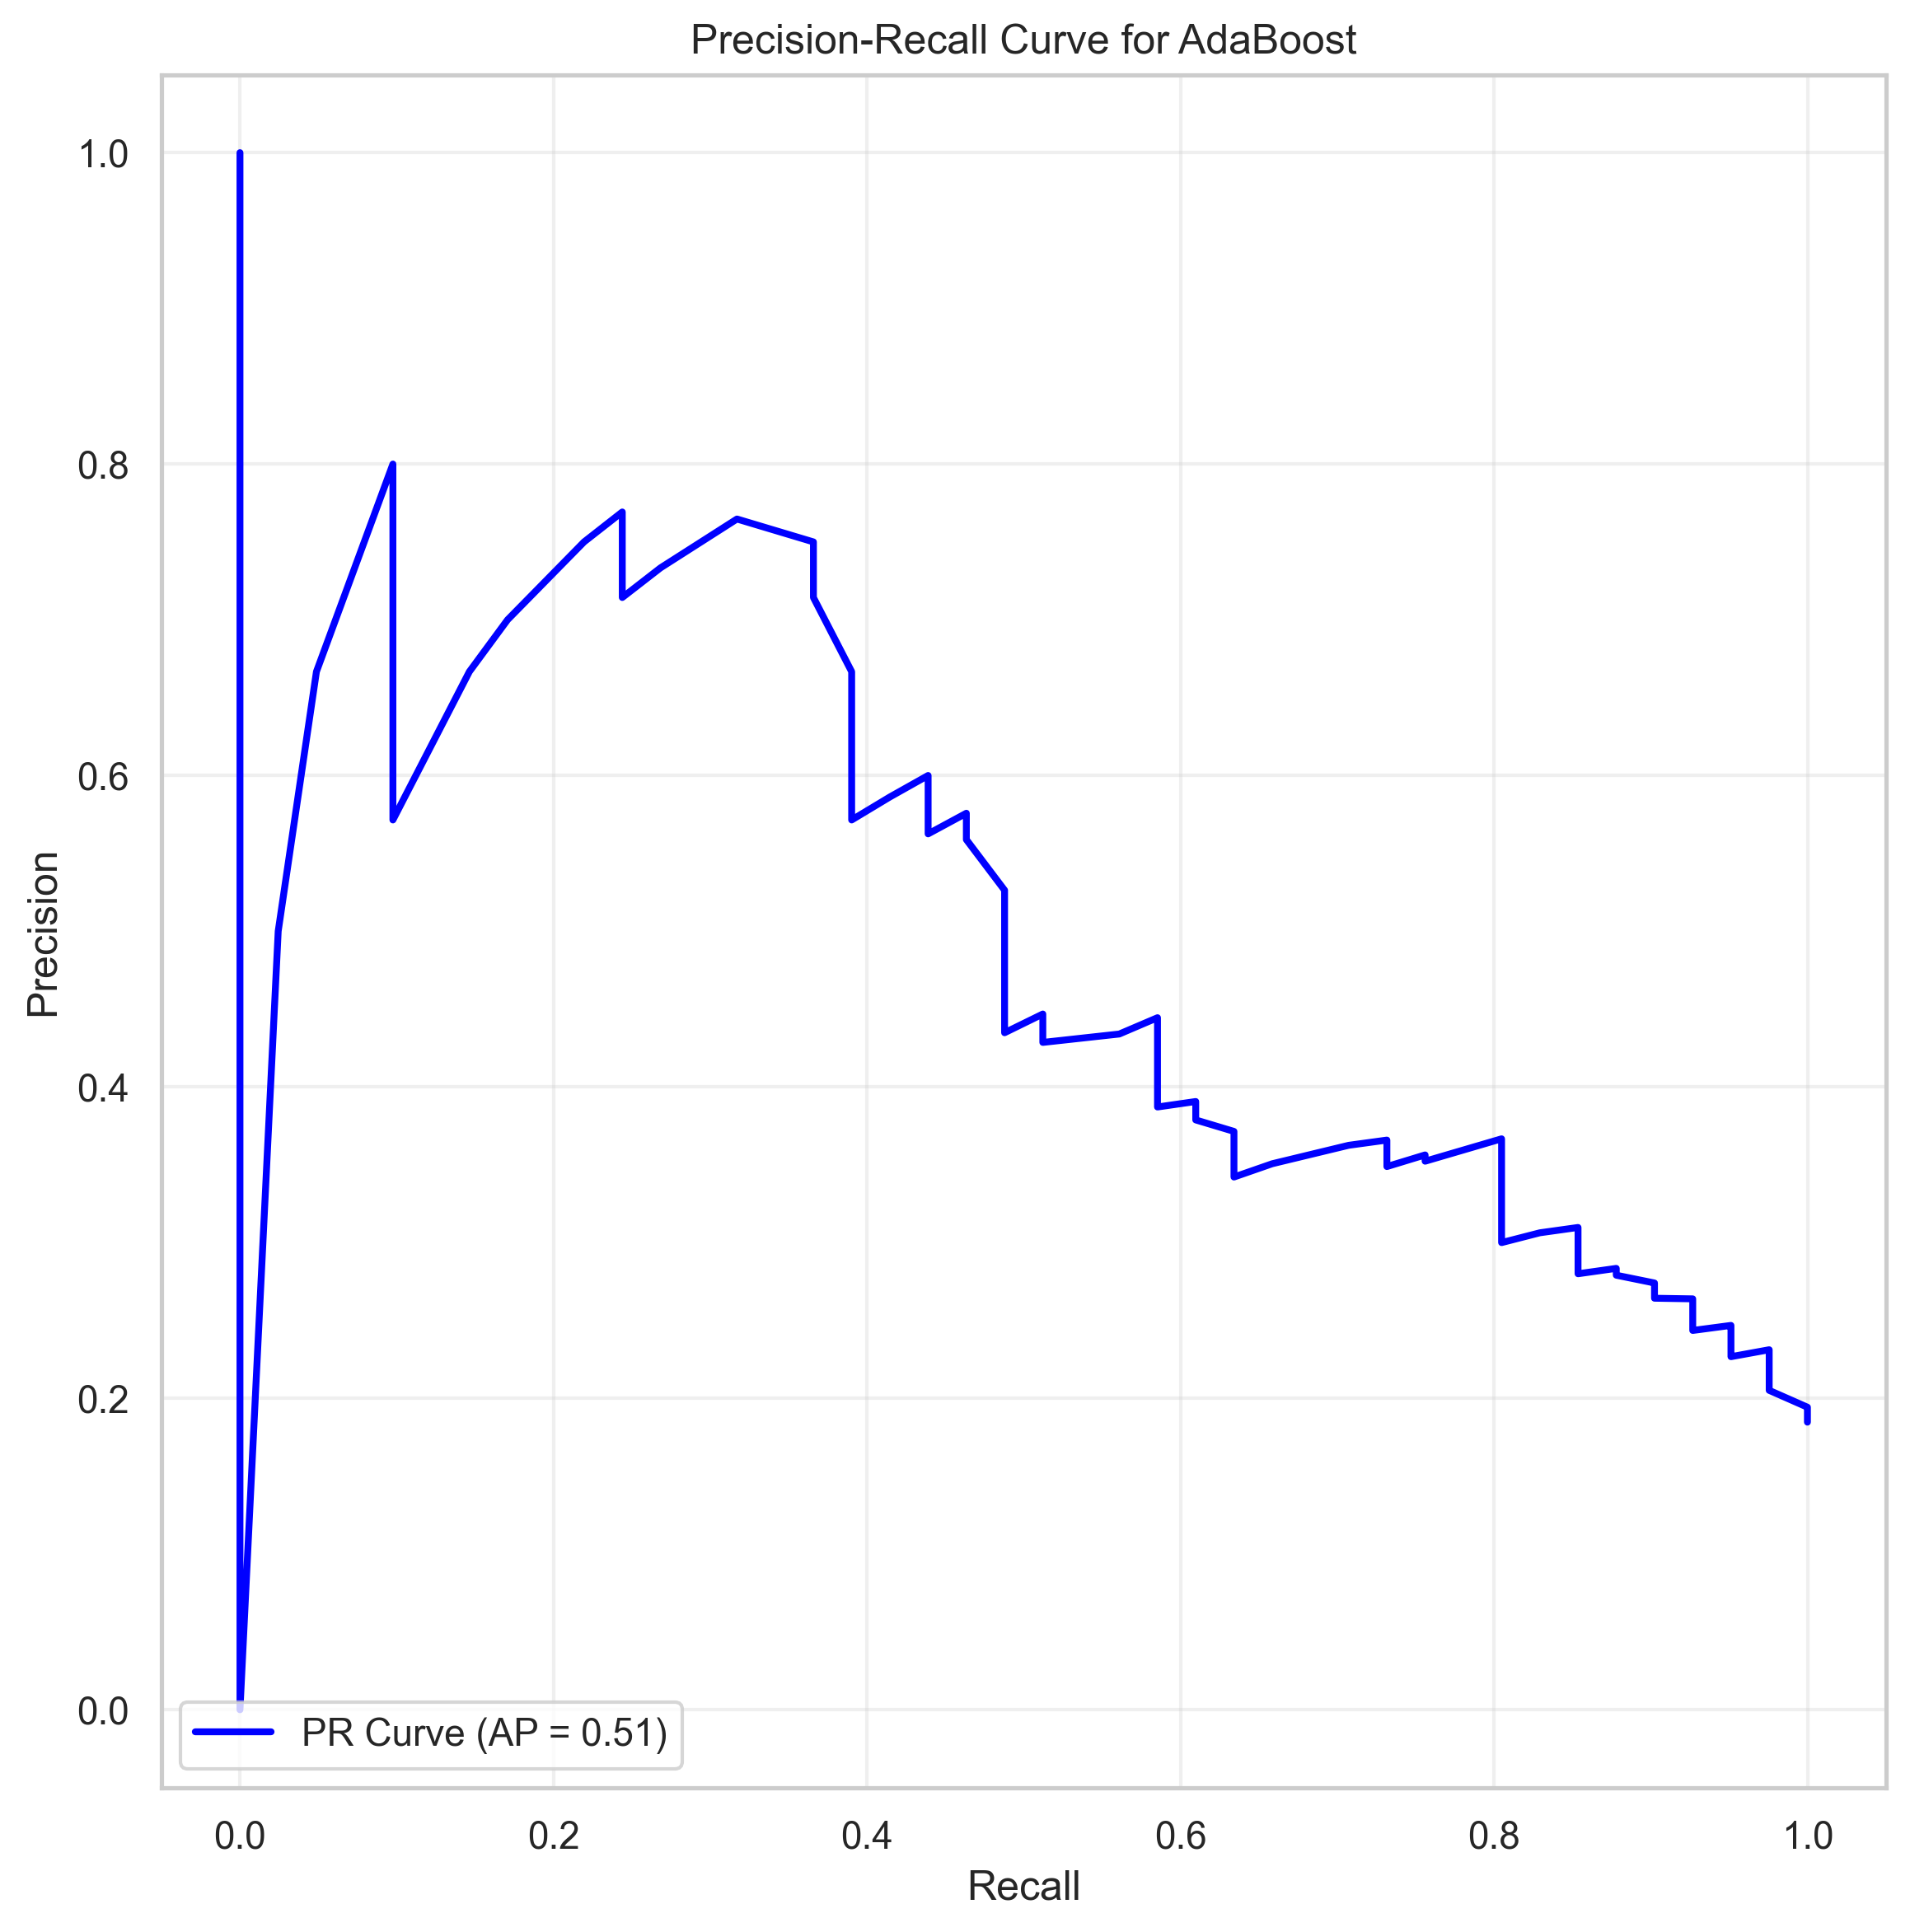

In [64]:
# Define the hyperparameters grid for AdaBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
}

# Define class weights for sample_weight
class_weights = {0: 1, 1: len(y_train) / (2 * np.sum(y_train == 1))}
sample_weights = np.array([class_weights[label] for label in y_train])

# Initialize StratifiedKFold for cross-validation
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=AdaBoostClassifier(random_state=123),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=stratified_kfold,
    n_jobs=-1,
    verbose=1
)

# Ensure inputs are numpy arrays
X_train_transformed = np.array(X_train_transformed)
y_train = np.array(y_train)

# Perform grid search on the training data
grid_search.fit(X_train_transformed, y_train,sample_weight=sample_weights)

# Extract the best hyperparameters and model
best_params = grid_search.best_params_
best_ad_model = grid_search.best_estimator_
print("Best Hyperparameters:", best_params)

# Evaluate on the test set
ada_predictions = best_ad_model.predict(X_test_transformed)
ada_probabilities = best_ad_model.predict_proba(X_test_transformed)[:, 1]

# Calculate test AUC
test_auc = roc_auc_score(y_test, ada_probabilities)
print(f"AUC: {test_auc:.2f}")

# Generate ROC curve using test data
fpr_test, tpr_test, _ = roc_curve(y_test, ada_probabilities)

# Plot the ROC curve for the test data
plt.figure(figsize=(9, 9), dpi=300)
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC (Test AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for predicting suicidality using AdaBoost after correcting class imbalance')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Print evaluation metrics
print("Classification Report:\n", classification_report(y_test, ada_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, ada_predictions))
print(f"Kappa: {cohen_kappa_score(y_test, ada_predictions):.2f}")
print(f"MCC: {matthews_corrcoef(y_test, ada_predictions):.2f}")

# Generate and plot the Precision-Recall curve for the test data
precision, recall, _ = precision_recall_curve(y_test, ada_probabilities)
average_precision = average_precision_score(y_test, ada_probabilities)

# Plot the Precision-Recall curve for the test data
plt.figure(figsize=(9, 9), dpi=300)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for AdaBoost')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.show()

##### *LR model*

Fitting 10 folds for each of 12 candidates, totalling 120 fits


Setting penalty=None will ignore the C and l1_ratio parameters



Best Hyperparameters: {'clf__C': 0.01, 'clf__solver': 'saga'}

Test AUC: 0.76


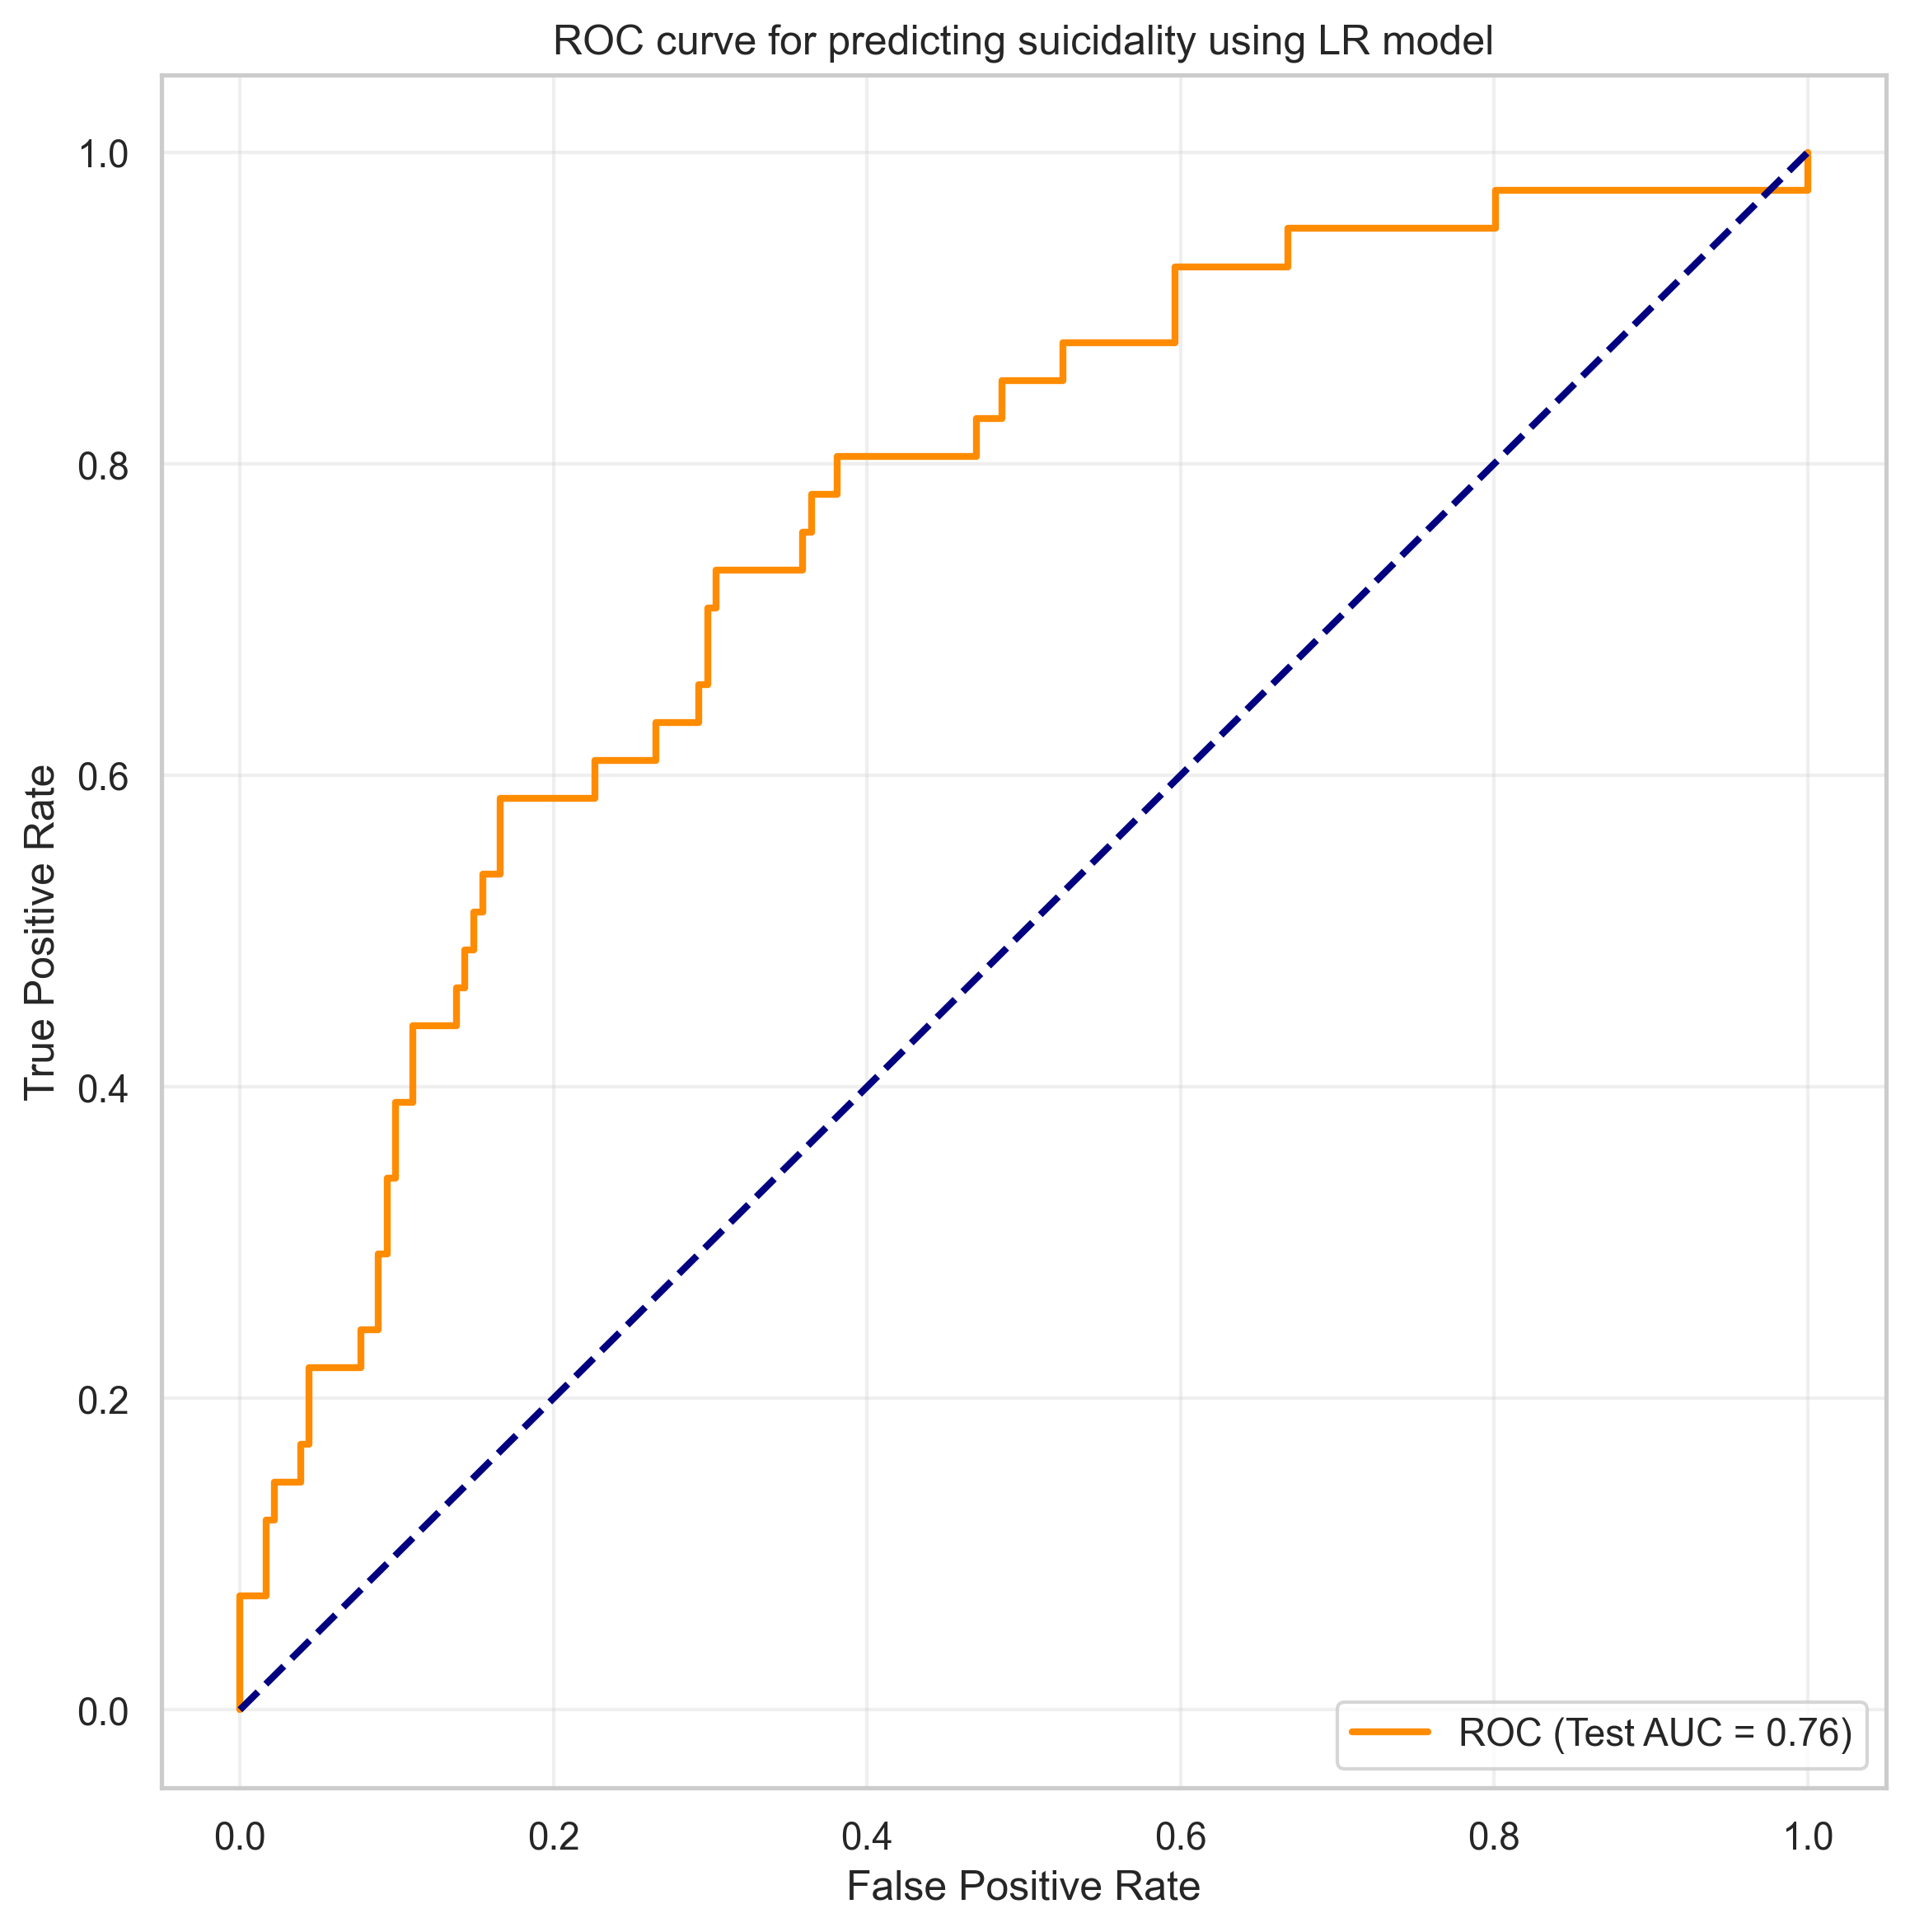


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       181
           1       0.41      0.22      0.29        41

    accuracy                           0.80       222
   macro avg       0.62      0.57      0.58       222
weighted avg       0.76      0.80      0.77       222


Confusion Matrix:
[[168  13]
 [ 32   9]]

Cohen's Kappa: 0.18
MCC: 0.19


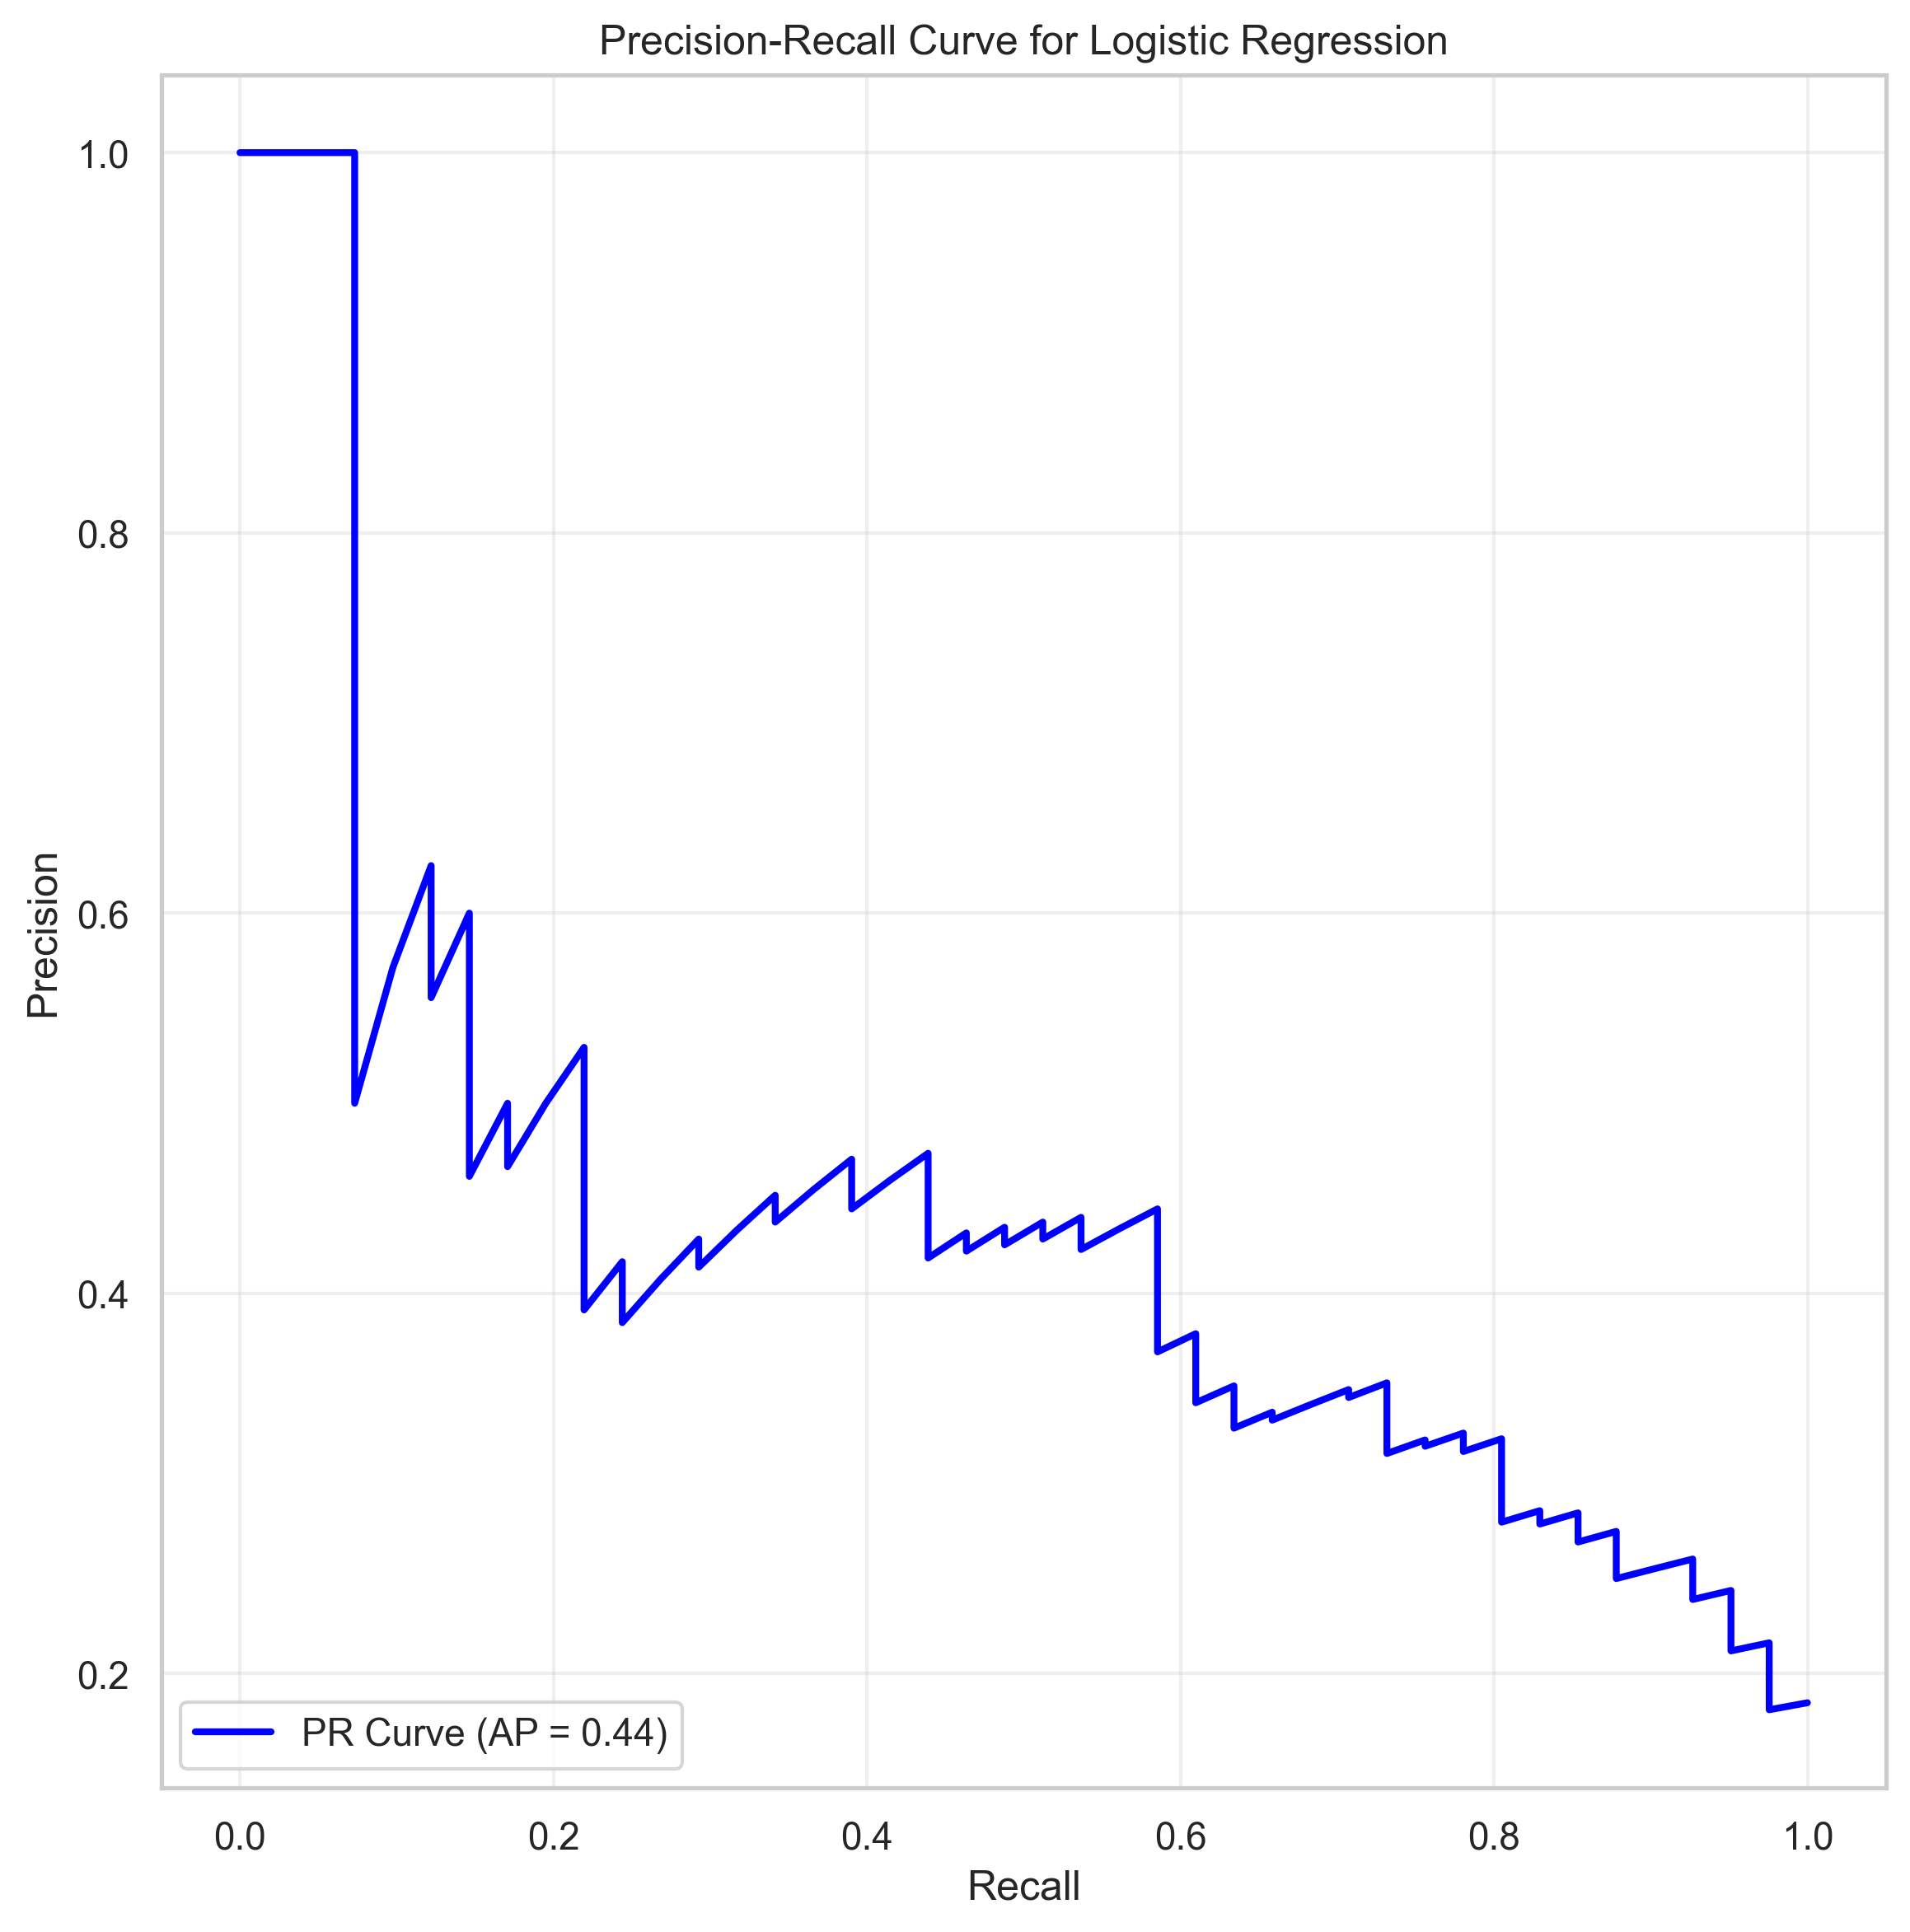

In [65]:
from sklearn.pipeline import Pipeline

# Define pipeline with Logistic Regression
pipeline = Pipeline([
    ('clf', LogisticRegression(max_iter=1000, penalty=None, random_state=42))
])

# Define hyperparameter grid for Logistic Regression (no regularization)
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],  
    'clf__solver': ['newton-cg', 'lbfgs', 'saga']  # These solvers can handle no penalty
}

# Perform GridSearchCV to maximize AUC
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train_transformed, y_train)

# Get the best model
best_lr_model = grid_search.best_estimator_
print("\nBest Hyperparameters:", grid_search.best_params_)

# Evaluate the model on the test set
test_predictions = best_lr_model.predict(X_test_transformed)
test_probabilities = best_lr_model.predict_proba(X_test_transformed)[:, 1]

# Calculate test AUC
test_auc = roc_auc_score(y_test, test_probabilities)
print(f"\nTest AUC: {test_auc:.2f}")

# Generate ROC curve for the test set
fpr_test, tpr_test, _ = roc_curve(y_test, test_probabilities)

# Plot the ROC curve for the test set
plt.figure(figsize=(9, 9), dpi=300)
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC (Test AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for predicting suicidality using LR model')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Print classification metrics
print("\nClassification Report:")
print(classification_report(y_test, test_predictions))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, test_predictions))
print(f"\nCohen's Kappa: {cohen_kappa_score(y_test, test_predictions):.2f}")
print(f"MCC: {matthews_corrcoef(y_test, test_predictions):.2f}")

# Generate and plot the Precision-Recall curve for the test set
precision, recall, _ = precision_recall_curve(y_test, test_probabilities)
average_precision = average_precision_score(y_test, test_probabilities)

plt.figure(figsize=(9, 9), dpi=300)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.show()


##### *LR Model explanation*

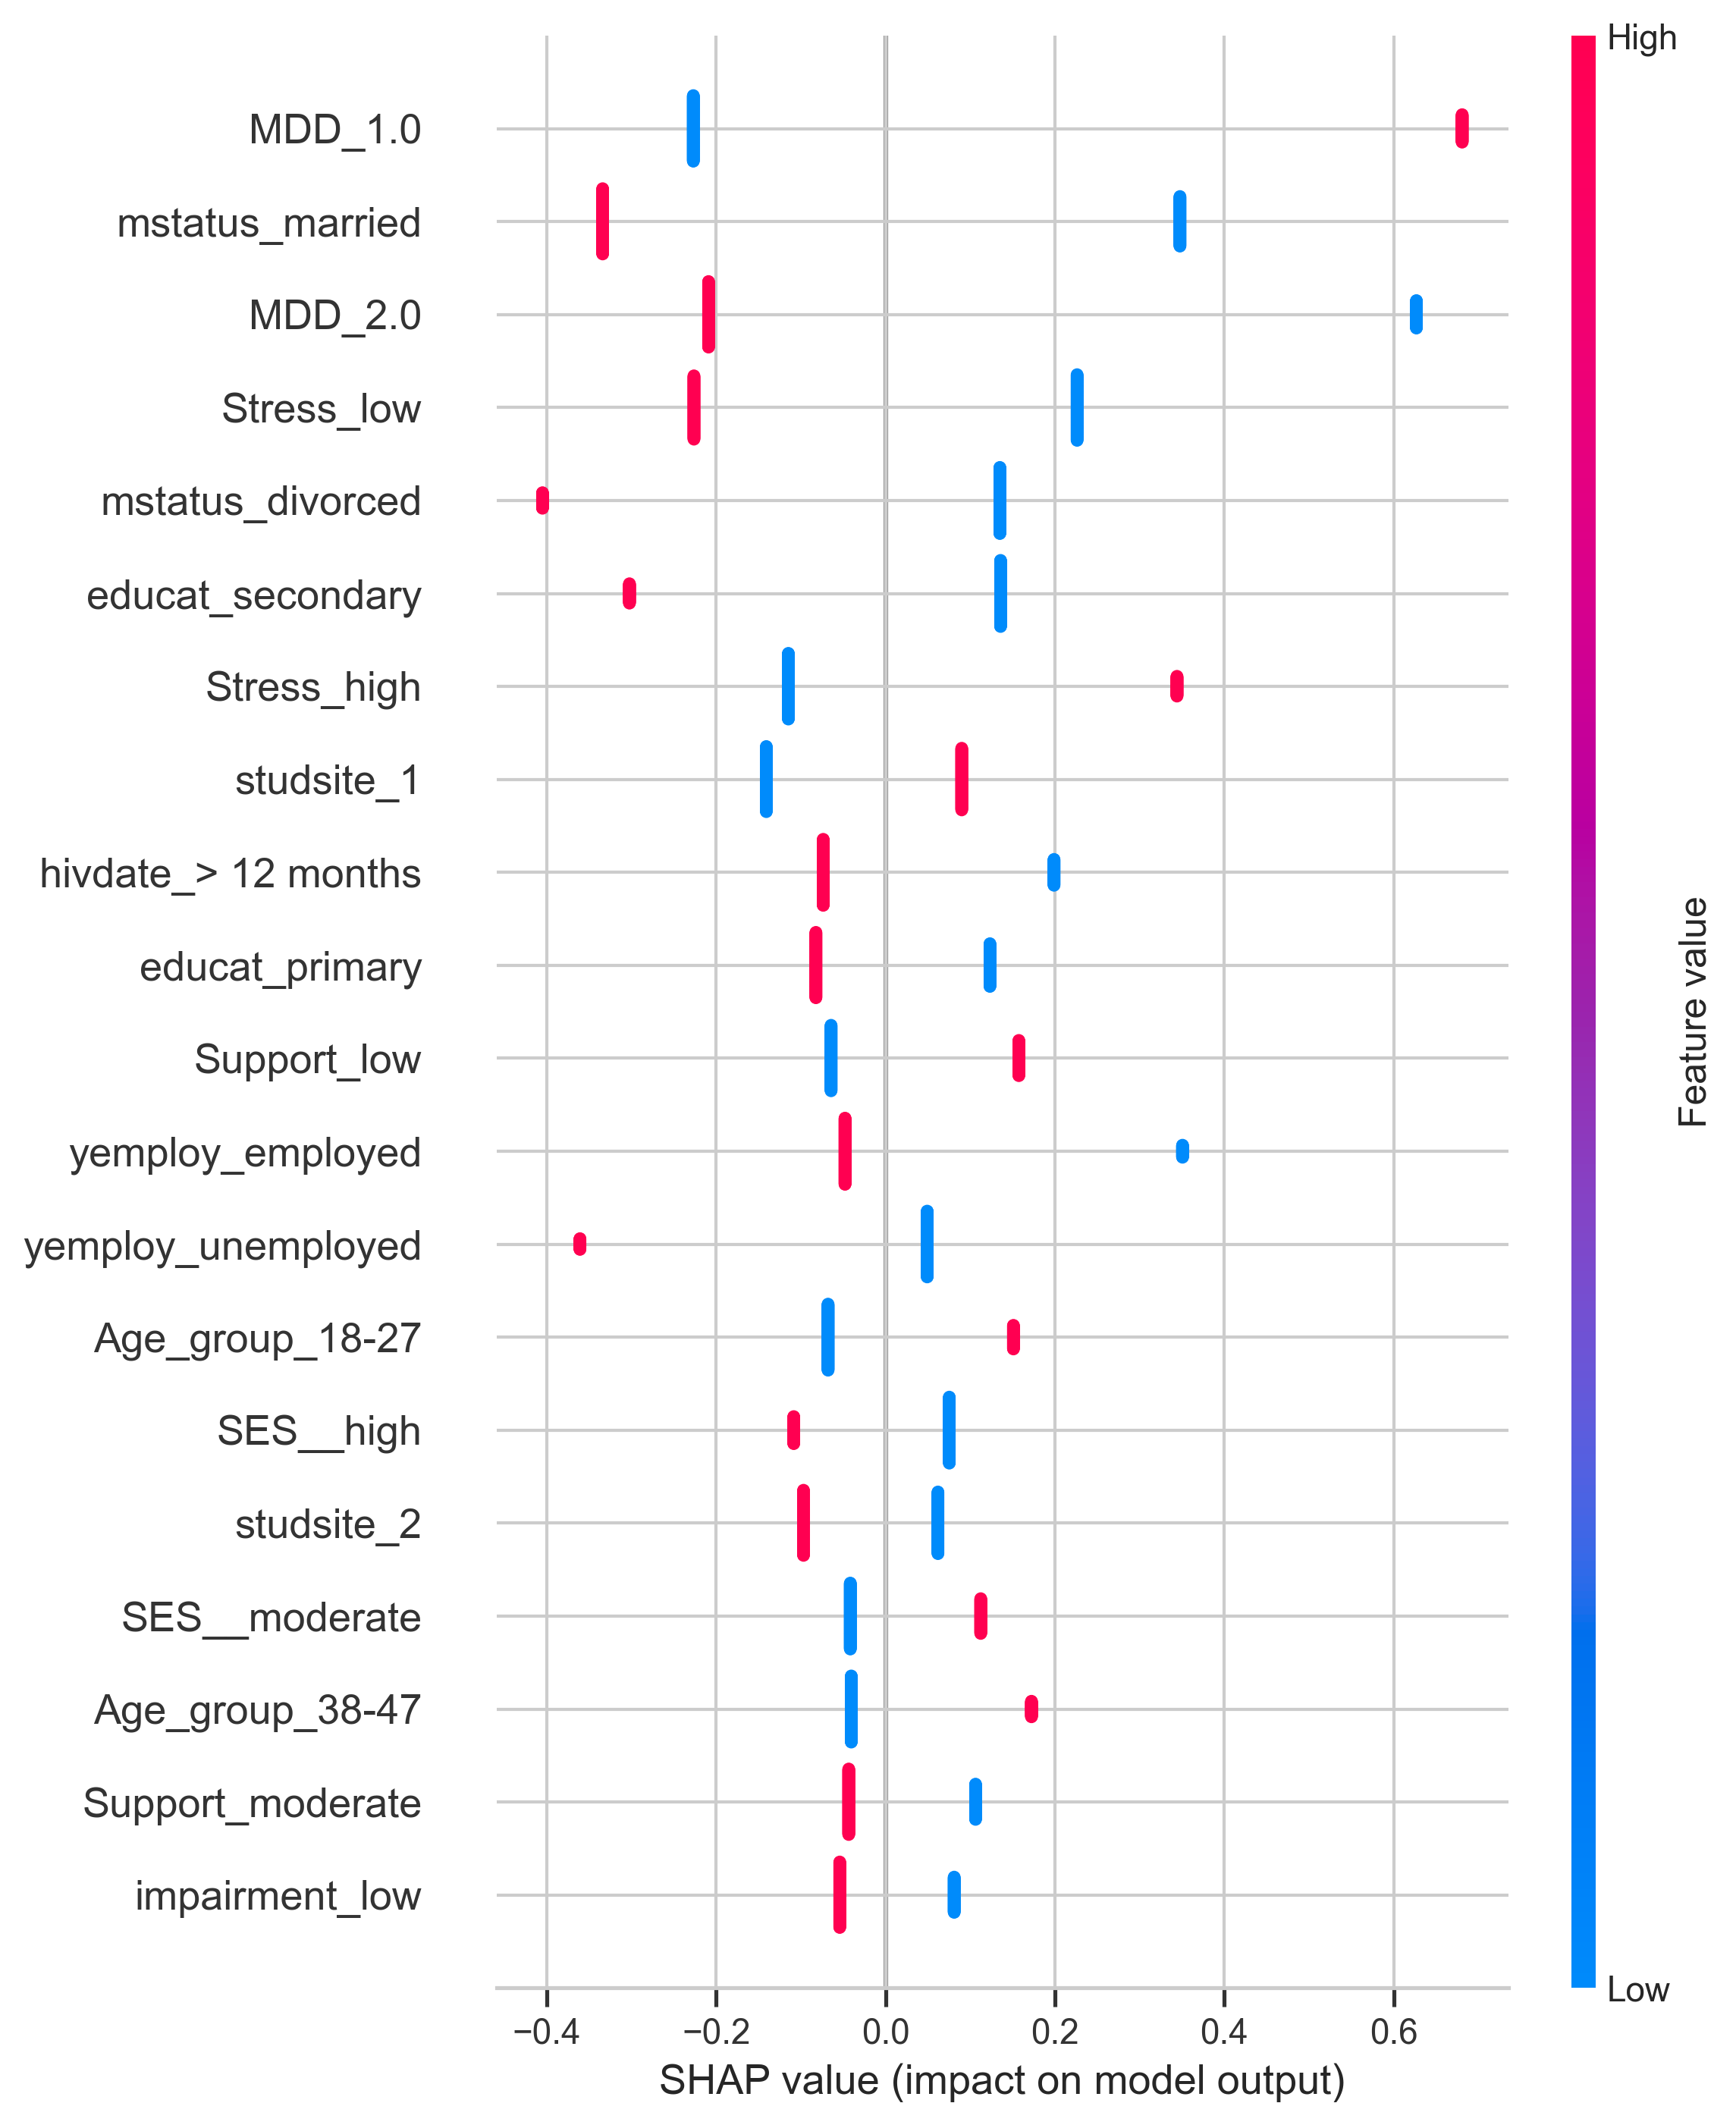

In [66]:

lr_model = best_lr_model.named_steps['clf']

# Initialize SHAP explainer for the Logistic Regression model
explainer_lr = shap.Explainer(lr_model, X_train_transformed)

# Compute SHAP values for the test set
shap_values_lr = explainer_lr(X_test_transformed)

# Define feature names (numeric and categorical variables combined)
num_var = ['HIV_Dementia', ]

cat_var = ['studsite', 'sex', 'educat', 'mstatus', 'yemploy', 'prevpsyc',
           'MDD', 'Support', 'Stress', 'SES_', 'Age_group', 'hivdate',
           'impairment']

# Extract the feature names for categorical variables after encoding
categorical_feature_names = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(input_features=cat_var)

# Combine numeric and encoded categorical feature names
feature_names = np.concatenate([num_var, categorical_feature_names])

# Plot the SHAP summary plot
plt.figure(figsize=(9, 9), dpi=300)
shap.summary_plot(shap_values_lr, X_test_transformed, feature_names=feature_names)


#### *Correcting for class imbalance in the LR model*

Fitting 10 folds for each of 12 candidates, totalling 120 fits


Setting penalty=None will ignore the C and l1_ratio parameters



Best Hyperparameters: {'clf__C': 0.01, 'clf__solver': 'newton-cg'}

Test AUC: 0.76


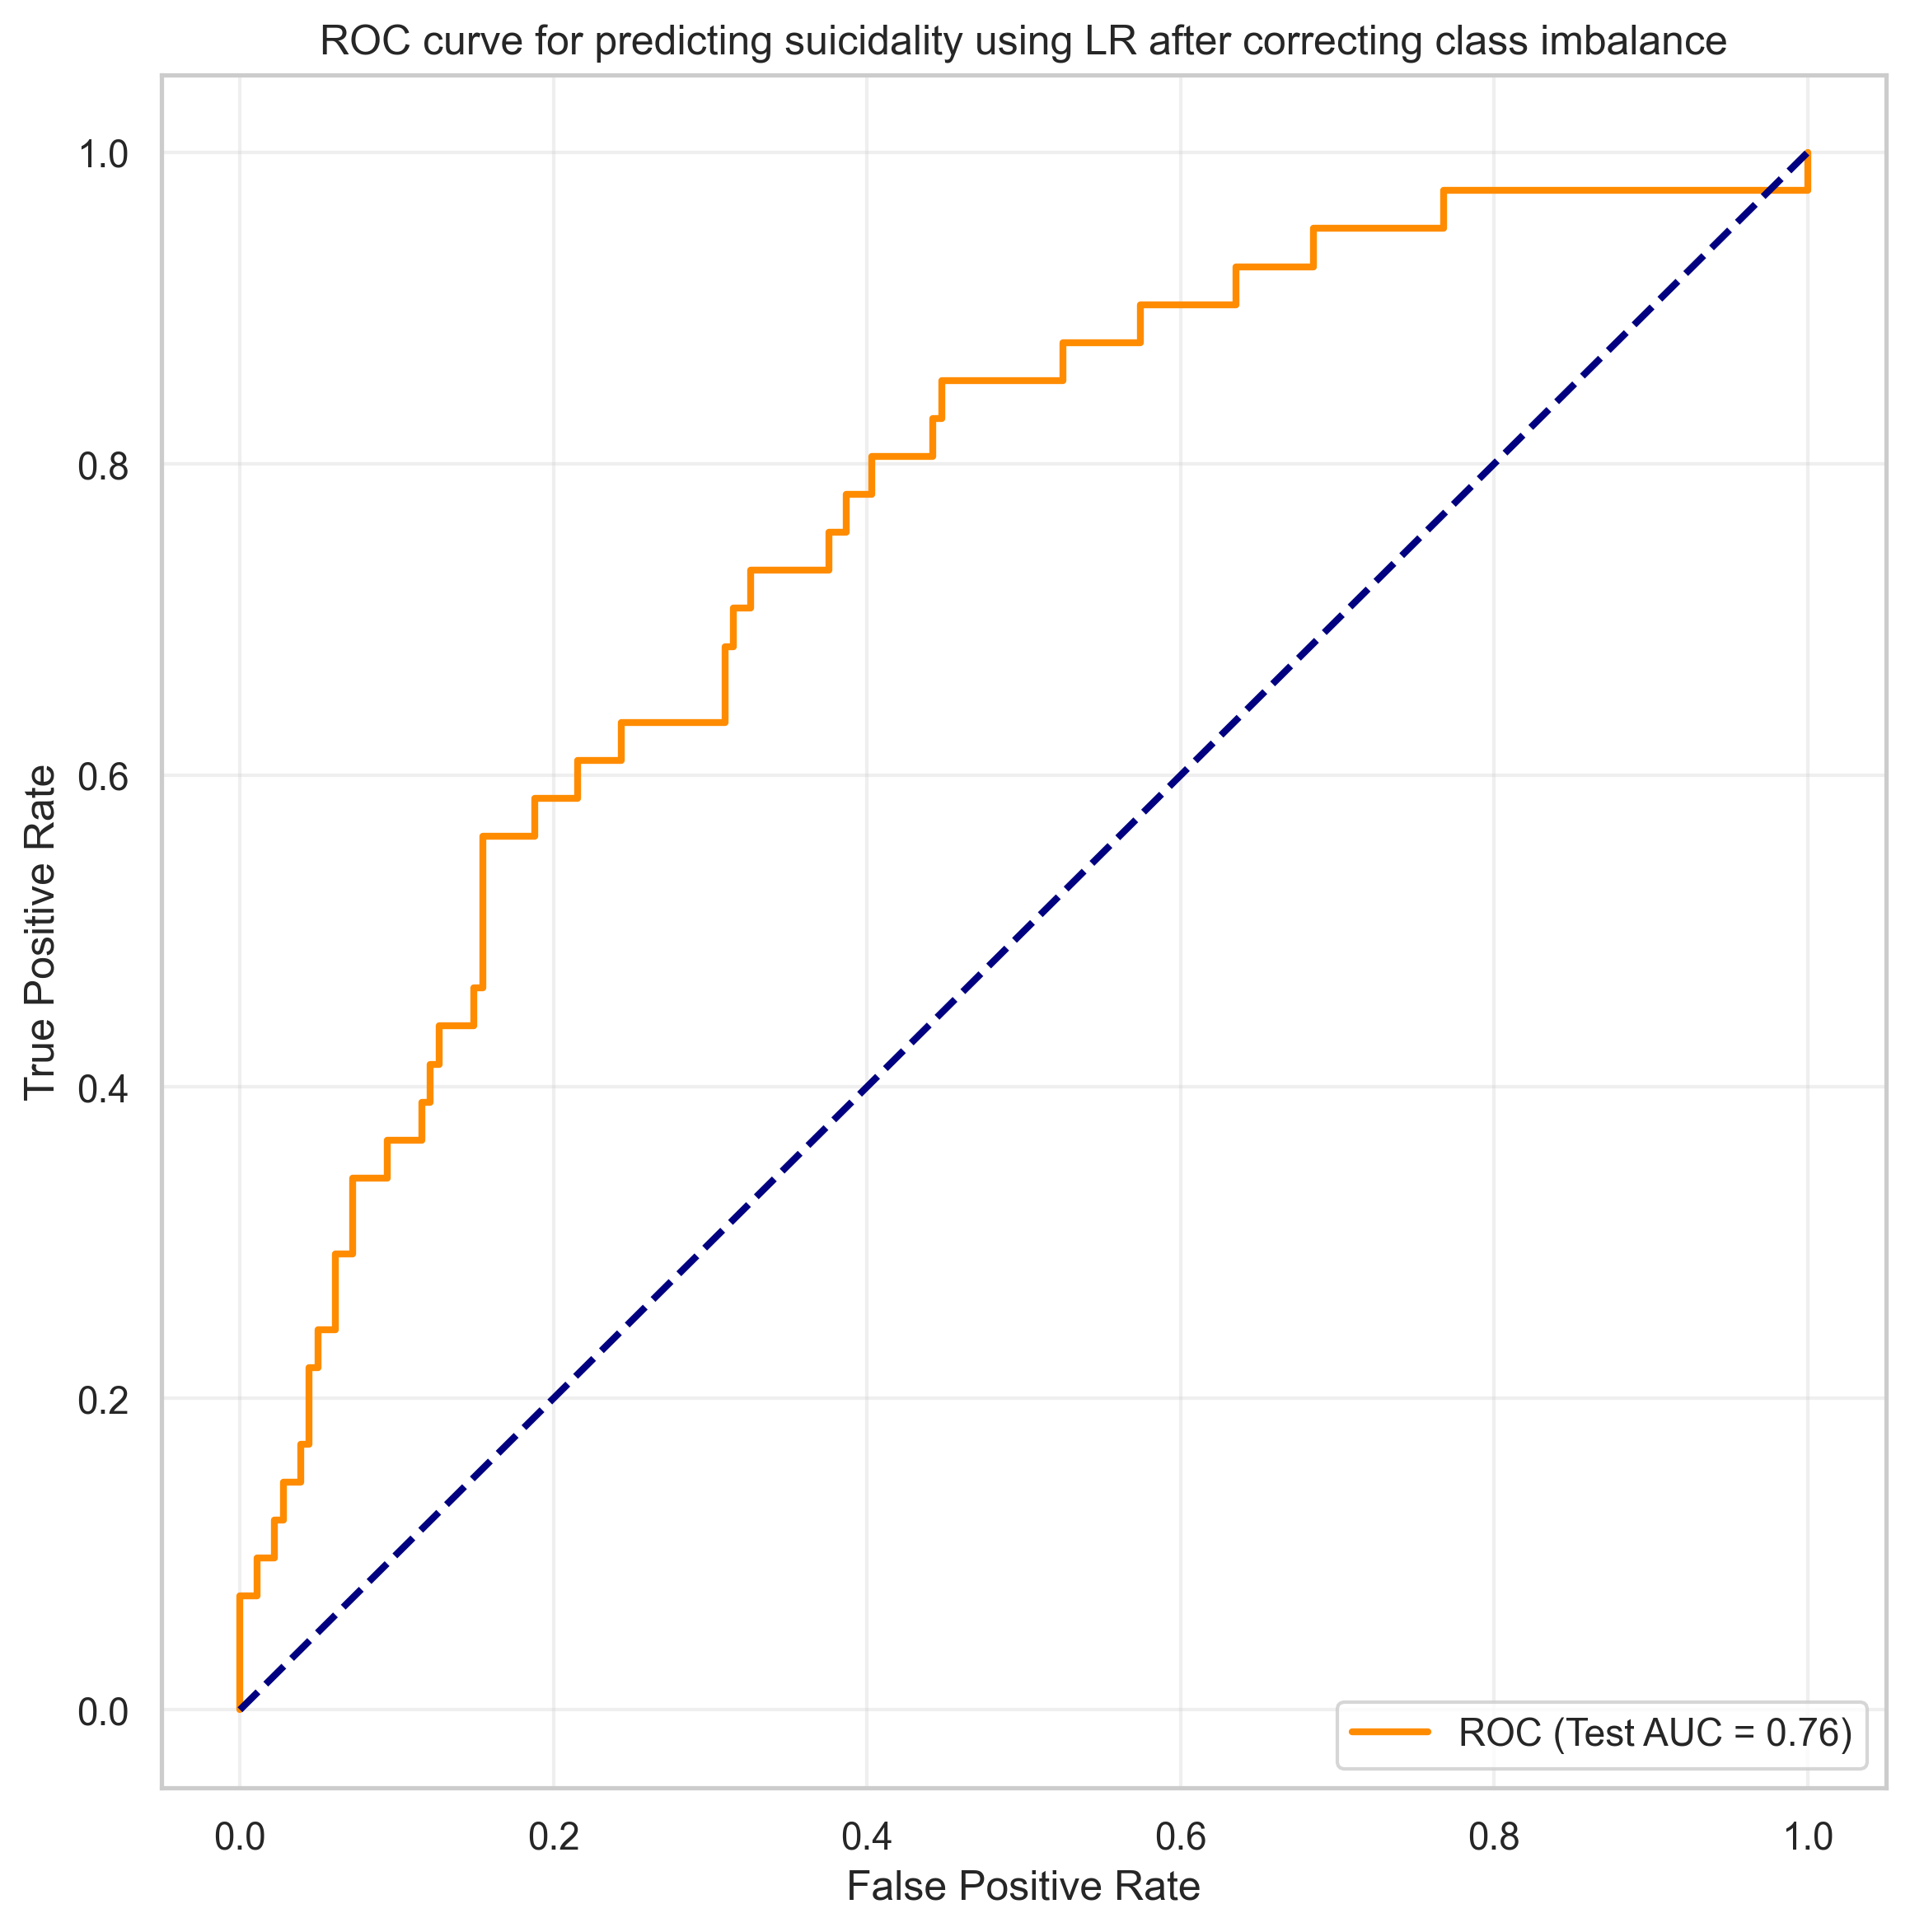


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.70      0.78       181
           1       0.32      0.63      0.43        41

    accuracy                           0.68       222
   macro avg       0.61      0.67      0.60       222
weighted avg       0.79      0.68      0.72       222


Confusion Matrix:
[[126  55]
 [ 15  26]]

Cohen's Kappa: 0.24
MCC: 0.27


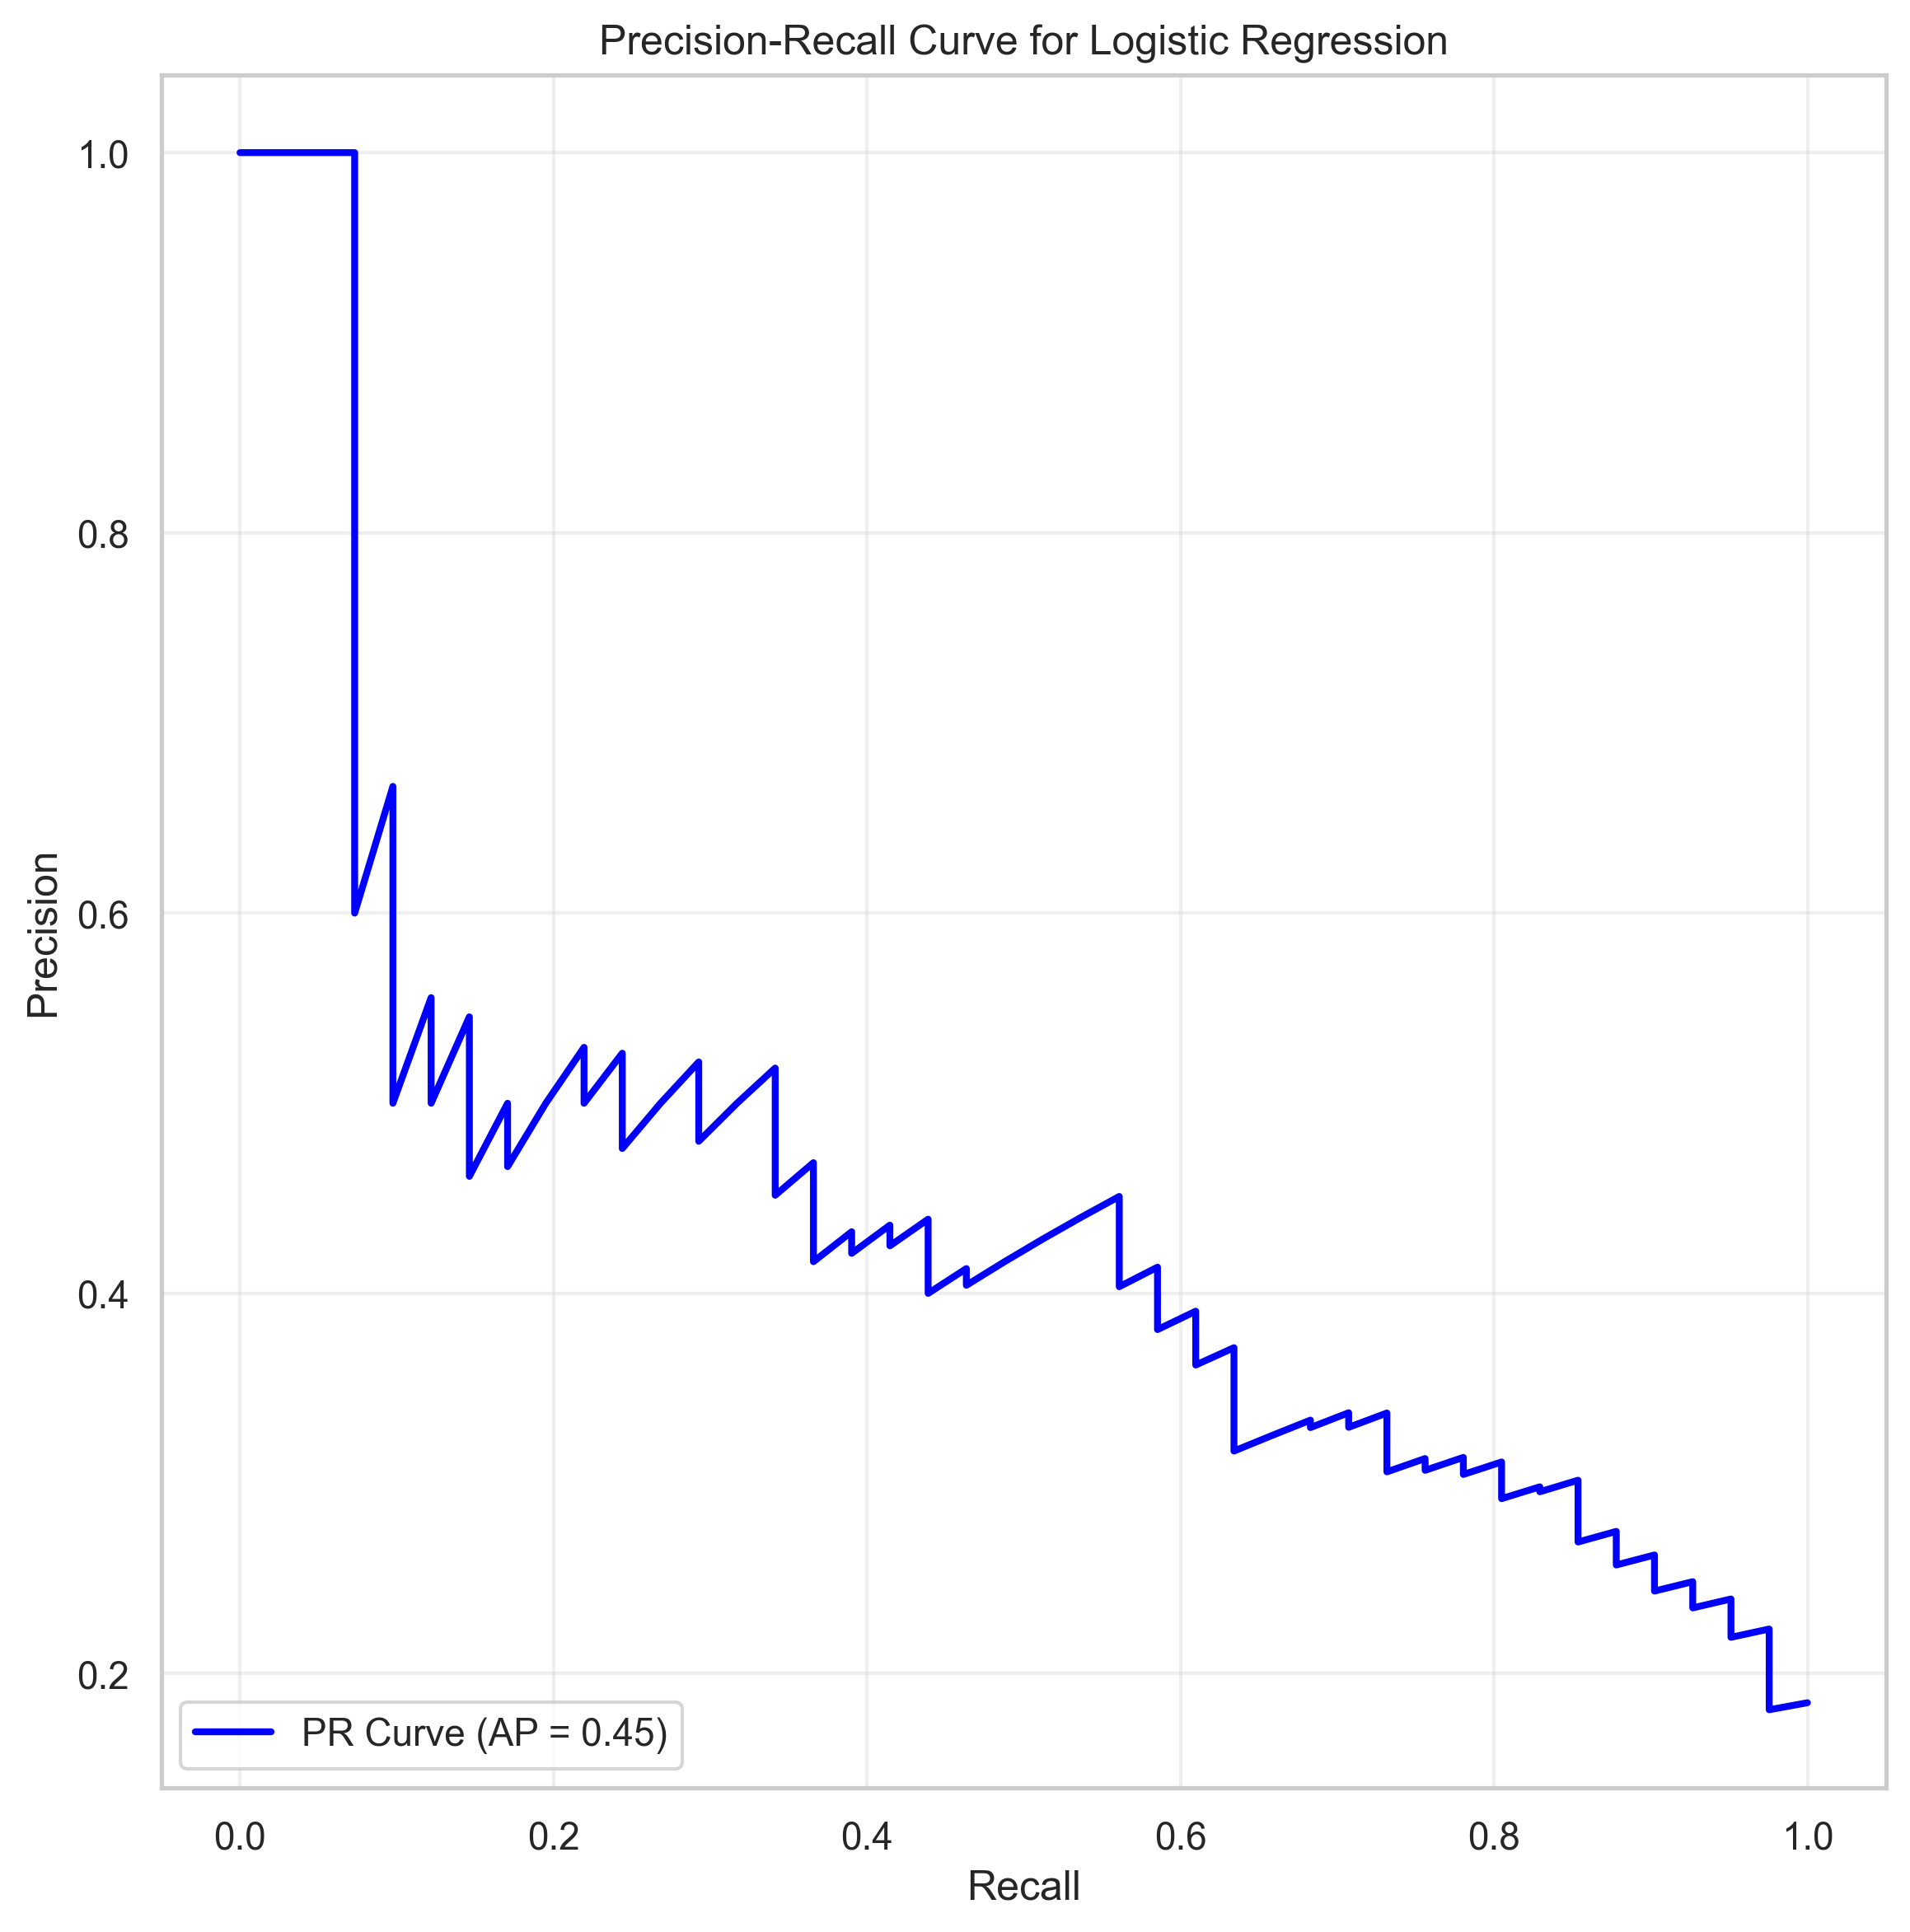

In [67]:
from sklearn.pipeline import Pipeline

# Define pipeline with Logistic Regression
pipeline = Pipeline([
    ('clf', LogisticRegression(max_iter=1000, penalty=None, random_state=42, class_weight='balanced'))
])

# Define hyperparameter grid for Logistic Regression (no regularization)
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],  
    'clf__solver': ['newton-cg', 'lbfgs', 'saga']  # These solvers can handle no penalty
}

# Perform GridSearchCV to maximize AUC
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train_transformed, y_train)

# Get the best model
best_lr_model = grid_search.best_estimator_
print("\nBest Hyperparameters:", grid_search.best_params_)

# Evaluate the model on the test set
test_predictions = best_lr_model.predict(X_test_transformed)
test_probabilities = best_lr_model.predict_proba(X_test_transformed)[:, 1]

# Calculate test AUC
test_auc = roc_auc_score(y_test, test_probabilities)
print(f"\nTest AUC: {test_auc:.2f}")

# Generate ROC curve for the test set
fpr_test, tpr_test, _ = roc_curve(y_test, test_probabilities)

# Plot the ROC curve for the test set
plt.figure(figsize=(9, 9), dpi=300)
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC (Test AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for predicting suicidality using LR after correcting class imbalance')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Print classification metrics
print("\nClassification Report:")
print(classification_report(y_test, test_predictions))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, test_predictions))
print(f"\nCohen's Kappa: {cohen_kappa_score(y_test, test_predictions):.2f}")
print(f"MCC: {matthews_corrcoef(y_test, test_predictions):.2f}")

# Generate and plot the Precision-Recall curve for the test set
precision, recall, _ = precision_recall_curve(y_test, test_probabilities)
average_precision = average_precision_score(y_test, test_probabilities)

plt.figure(figsize=(9, 9), dpi=300)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.show()


##### *NB model*

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best Hyperparameters: {'var_smoothing': 1e-06}
AUC: 0.72


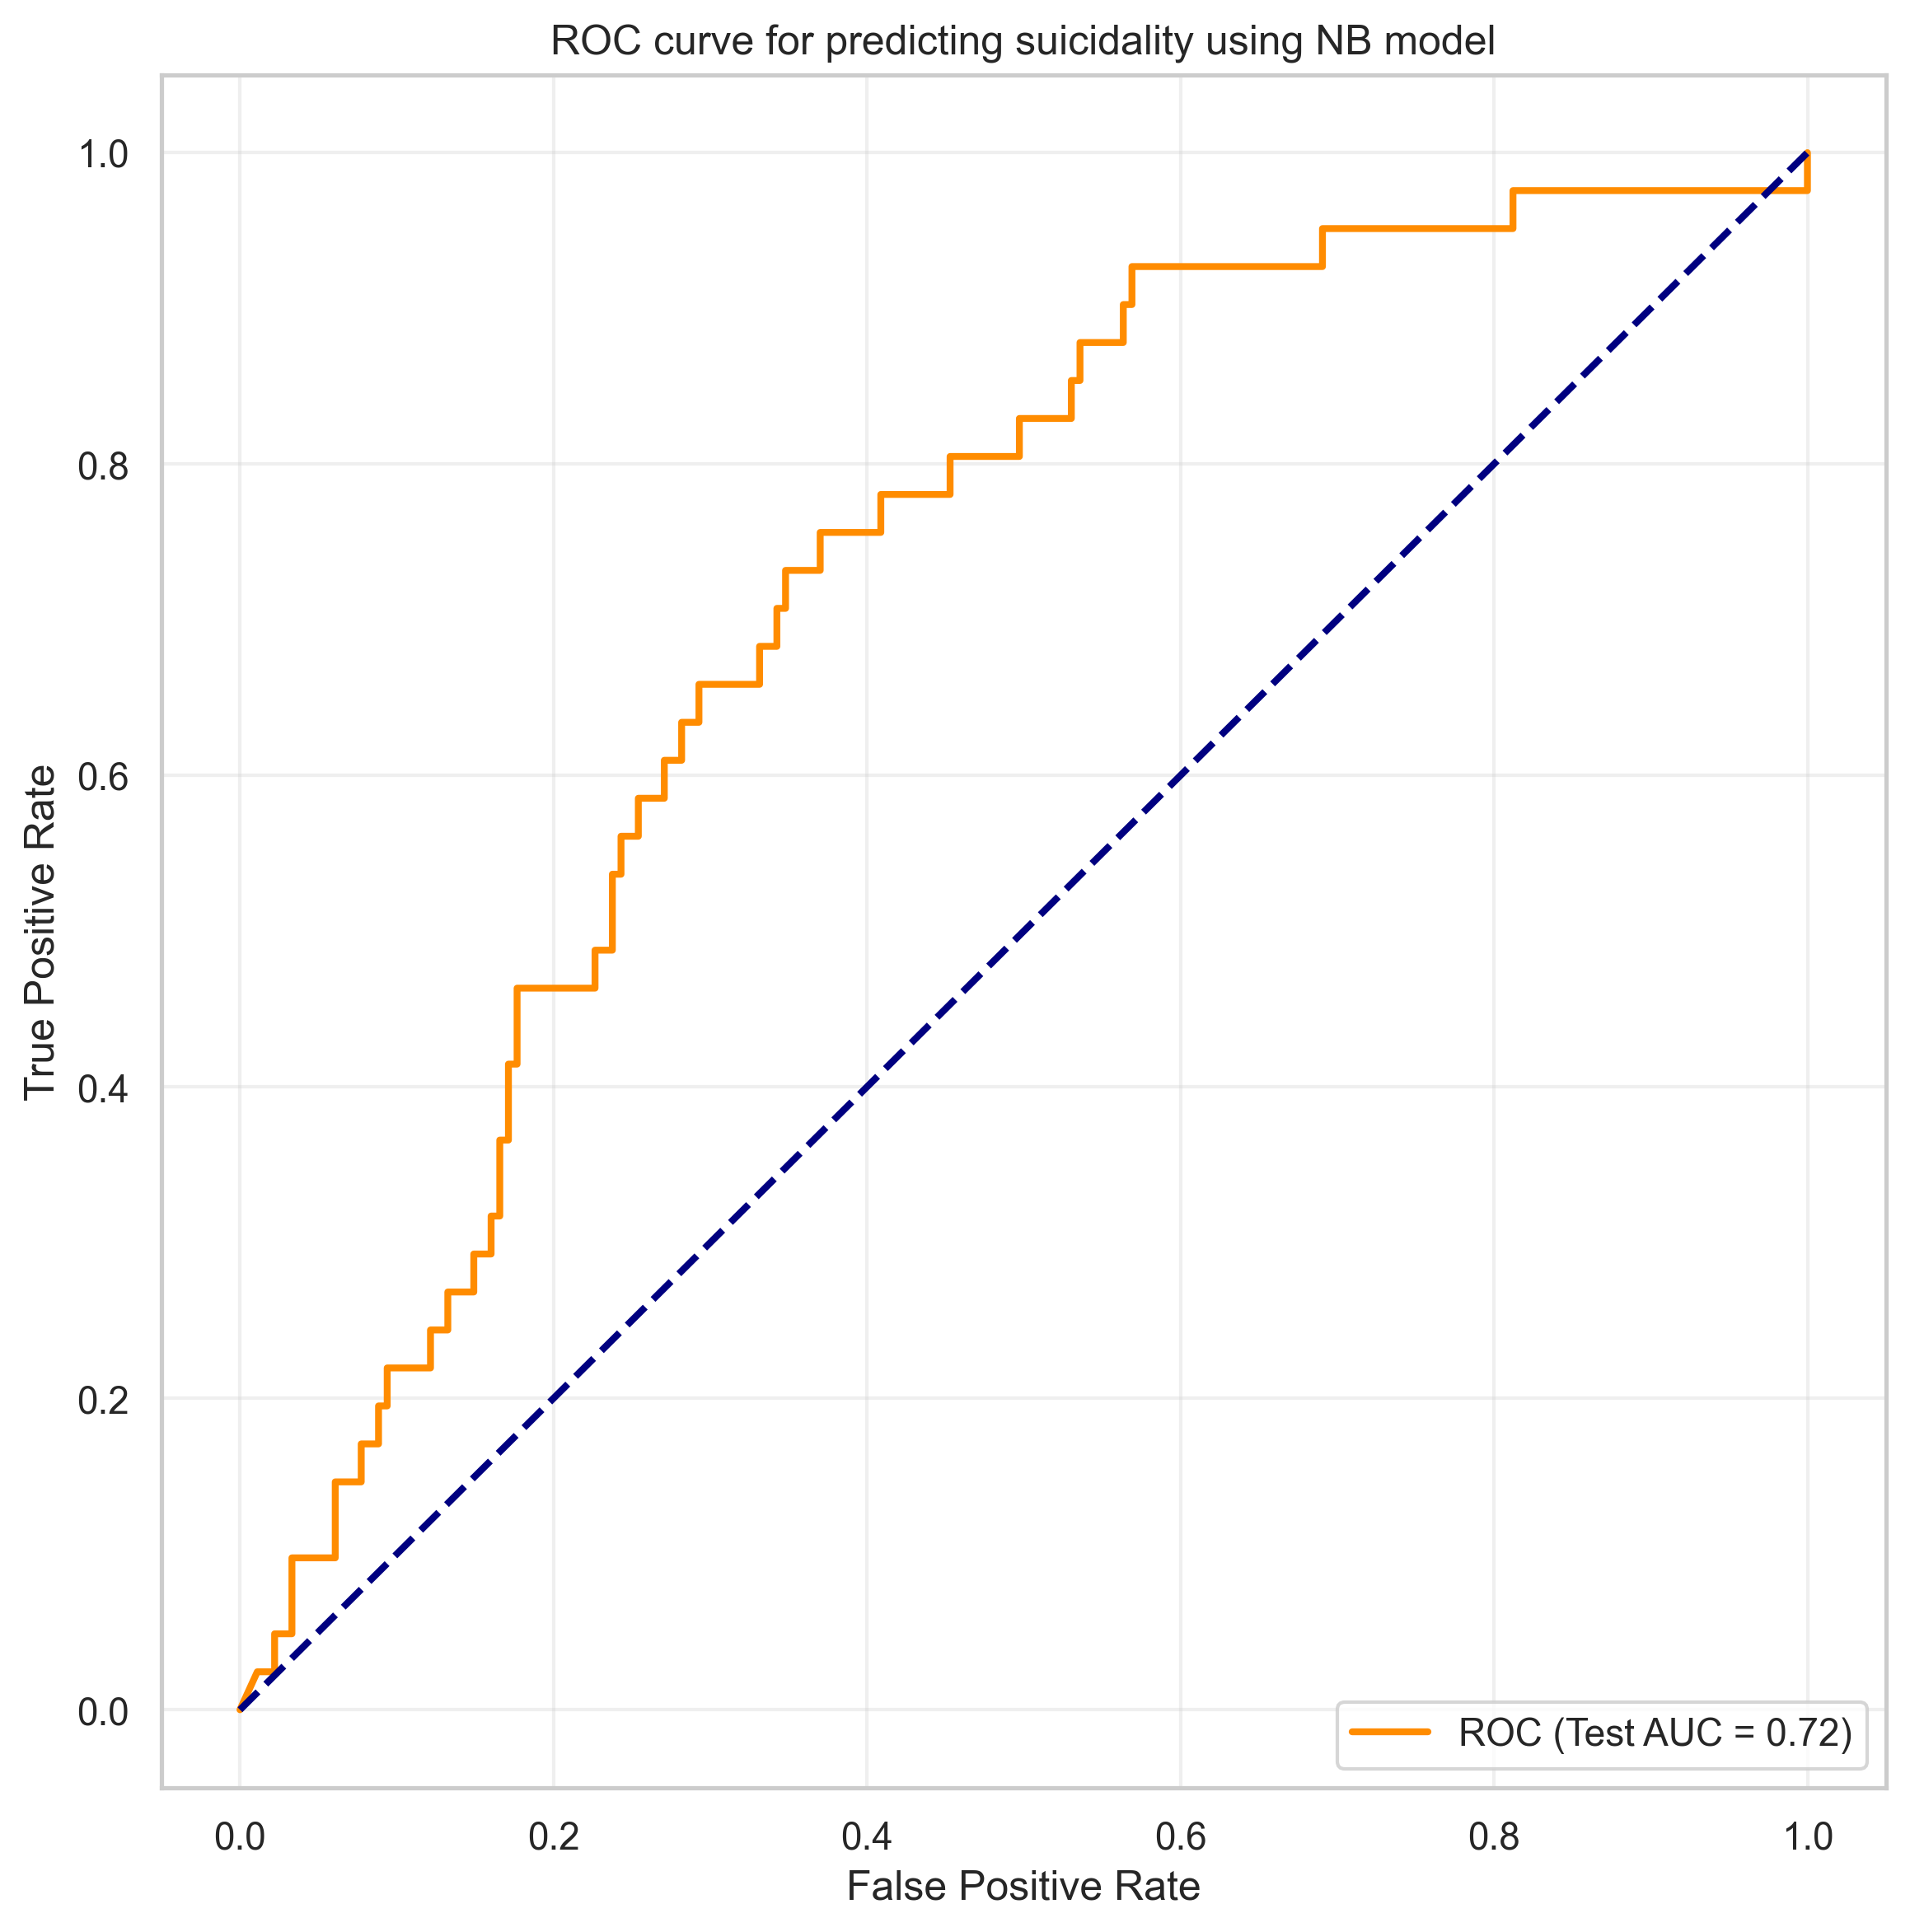

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.82      0.84       181
           1       0.36      0.44      0.40        41

    accuracy                           0.75       222
   macro avg       0.61      0.63      0.62       222
weighted avg       0.77      0.75      0.76       222

Confusion Matrix:
 [[149  32]
 [ 23  18]]
Kappa: 0.24
MCC: 0.24


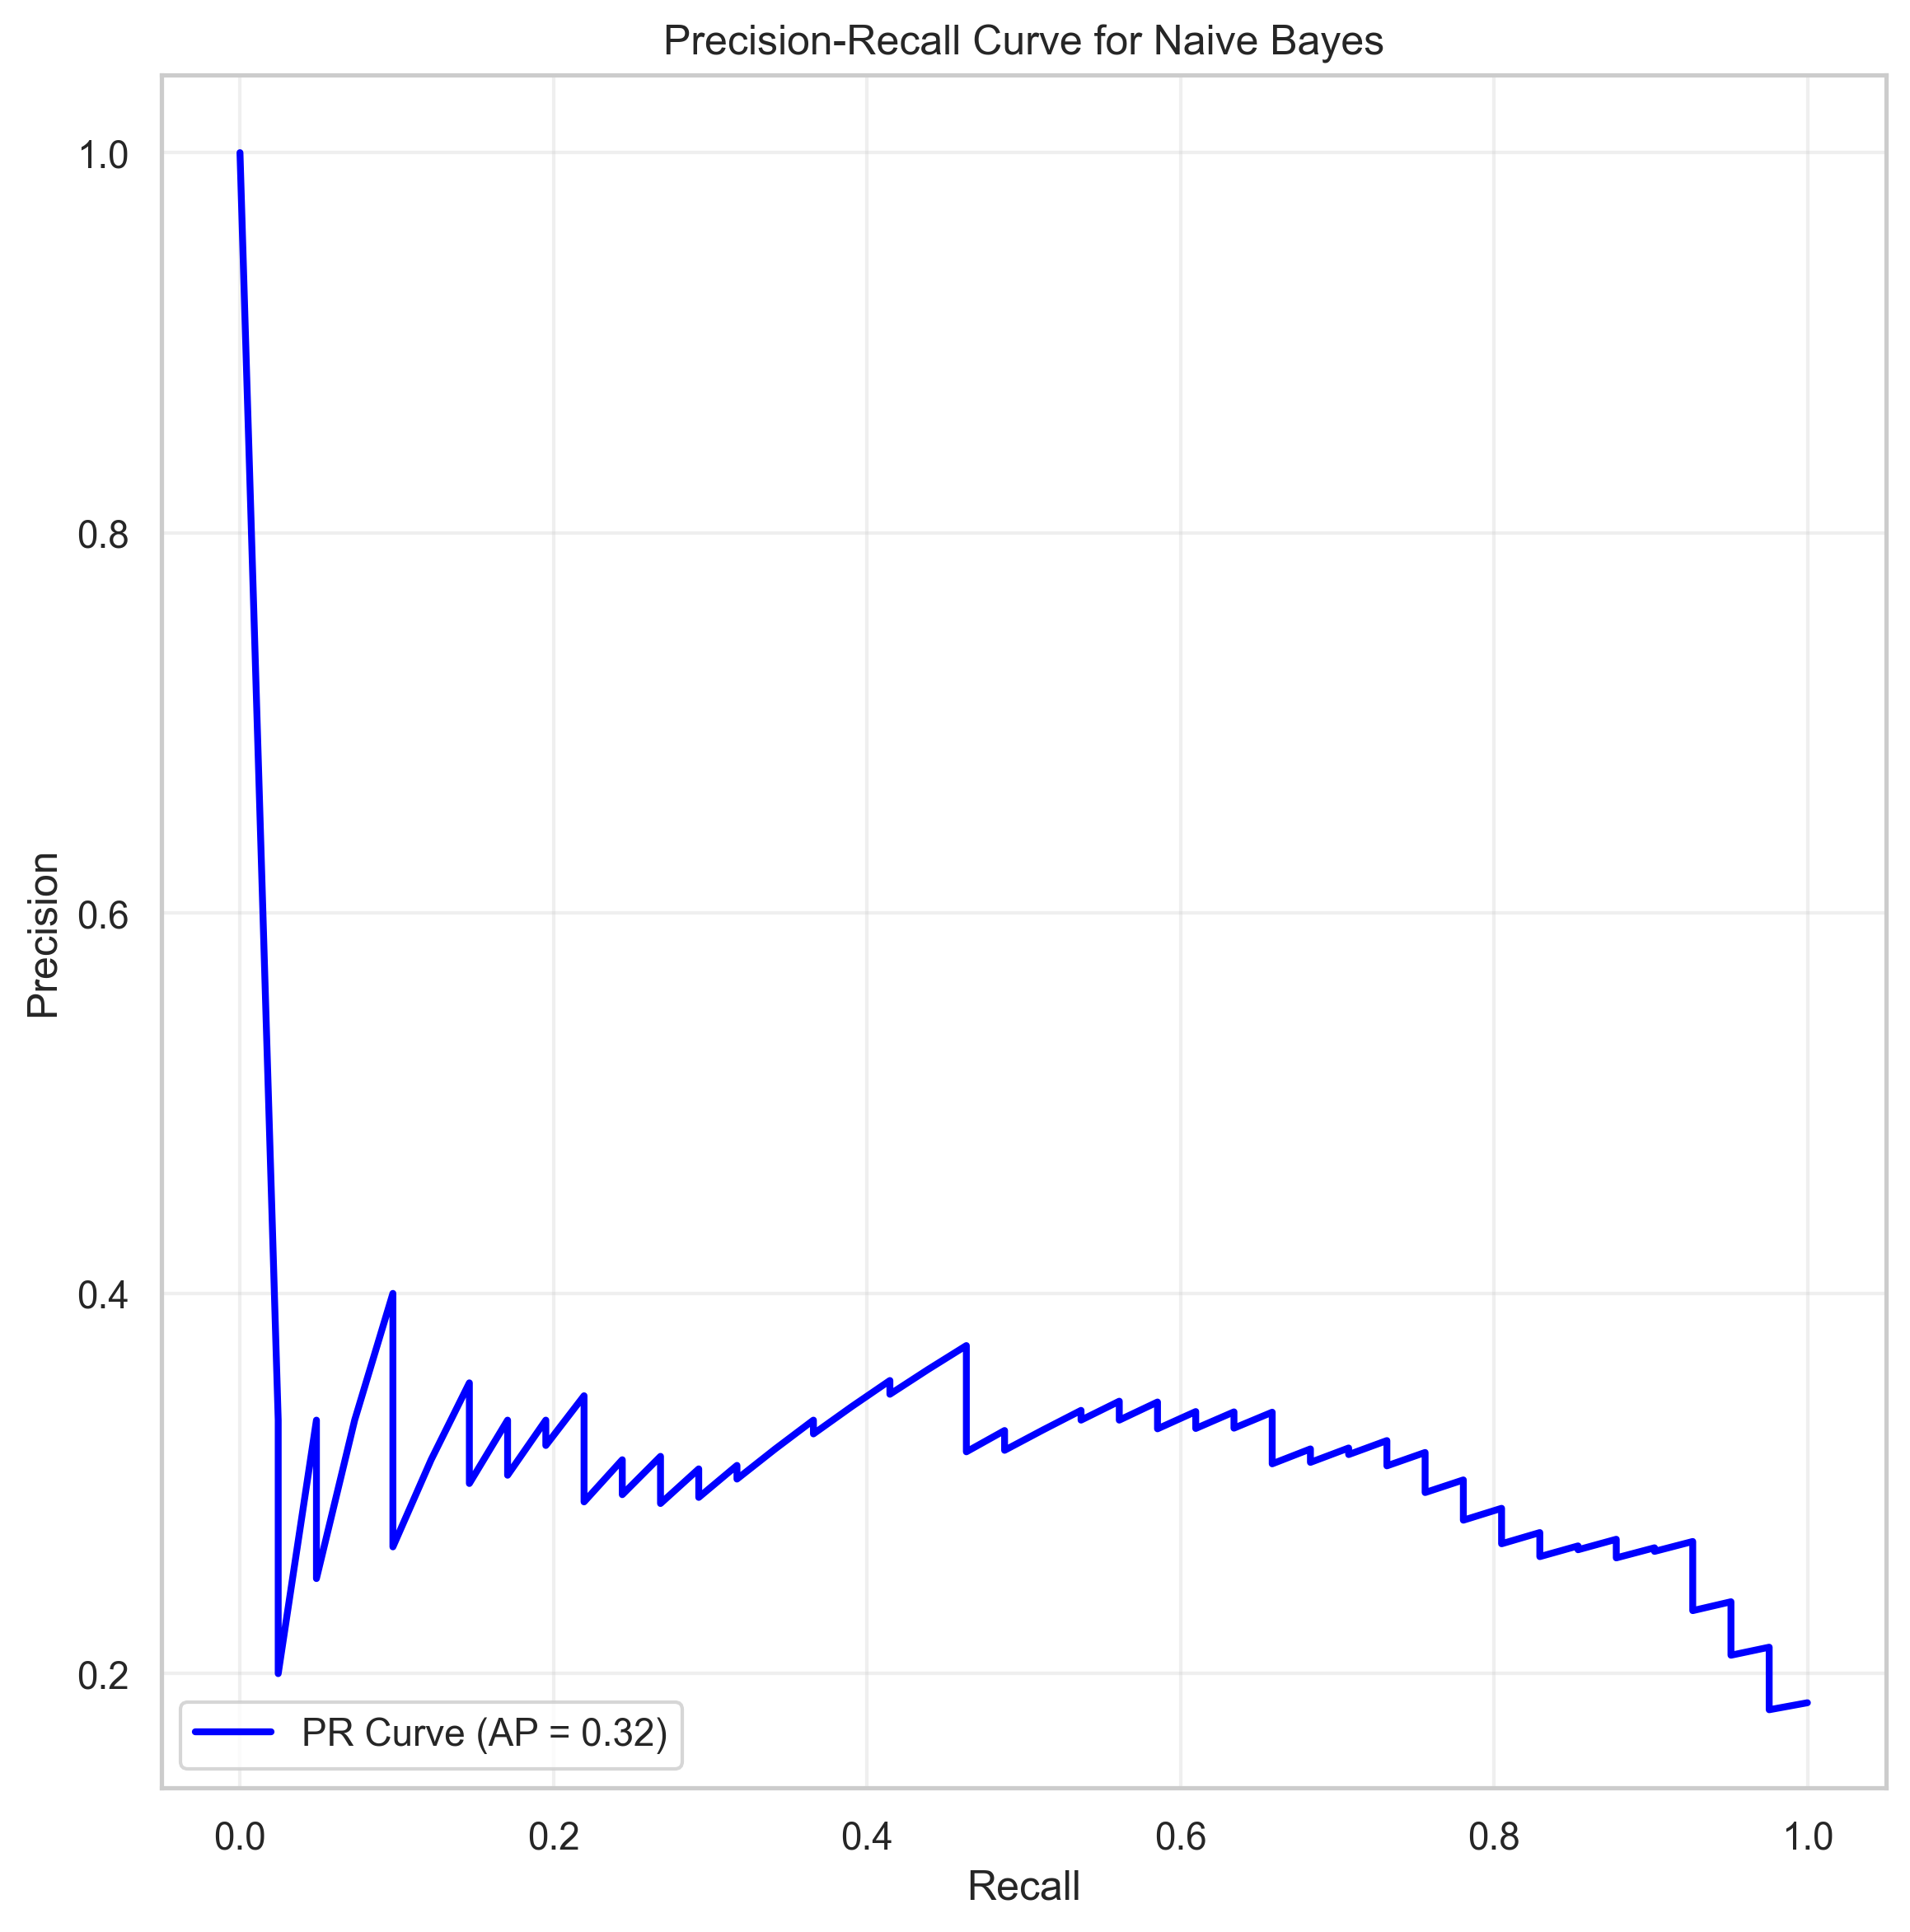

In [68]:
# Define the hyperparameters grid for Naive Bayes
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Initialize StratifiedKFold for cross-validation
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=GaussianNB(),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=stratified_kfold,
    n_jobs=-1,
    verbose=1
)

# Ensure inputs are numpy arrays
X_train_transformed = np.array(X_train_transformed)
y_train = np.array(y_train)

# Perform grid search on the training data
grid_search.fit(X_train_transformed, y_train)

# Extract the best hyperparameters and model
best_params = grid_search.best_params_
best_nb_model = grid_search.best_estimator_
print("Best Hyperparameters:", best_params)

# Evaluate on the test set
nb_predictions = best_nb_model.predict(X_test_transformed)
nb_probabilities = best_nb_model.predict_proba(X_test_transformed)[:, 1]

# Calculate test AUC
test_auc = roc_auc_score(y_test, nb_probabilities)
print(f"AUC: {test_auc:.2f}")

# Generate ROC curve using test data
fpr_test, tpr_test, _ = roc_curve(y_test, nb_probabilities)

# Plot the ROC curve for the test data
plt.figure(figsize=(9, 9), dpi=300)
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC (Test AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for predicting suicidality using NB model')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Print evaluation metrics
print("Classification Report:\n", classification_report(y_test, nb_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, nb_predictions))
print(f"Kappa: {cohen_kappa_score(y_test, nb_predictions):.2f}")
print(f"MCC: {matthews_corrcoef(y_test, nb_predictions):.2f}")

# Generate and plot the Precision-Recall curve for the test data
precision, recall, _ = precision_recall_curve(y_test, nb_probabilities)
average_precision = average_precision_score(y_test, nb_probabilities)

# Plot the Precision-Recall curve for the test data
plt.figure(figsize=(9, 9), dpi=300)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Naive Bayes')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.show()


### ***Use follow-up data to validate models***


##### *Psychosocial impairment*

In [69]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew

columns_to_convert = ['disrupt4', 'healthvisits4', 'hospdays4']

# Create a copy of the DataFrame for processing
df_hiv_copy = df_hiv12.copy()

# Convert the specified columns to binary (0 or 1) in the copy
df_hiv_copy[columns_to_convert] = (df_hiv_copy[columns_to_convert] > 0).astype(int)

# Create the PsycSocImpairment variable by summing the values in the columns
df_hiv_copy['PsycSocImpairment'] = df_hiv_copy[columns_to_convert].sum(axis=1, skipna=True)

# Categorize participants into low, moderate, and high using vectorized operations
df_hiv_copy['impairment'] = pd.cut(
    df_hiv_copy['PsycSocImpairment'], 
    bins=[-1, 0, 1, float('inf')], 
    labels=['low', 'moderate', 'high']
)

# Add the new 'impairment' variable to the original DataFrame using pd.concat
df_hiv12 = pd.concat([df_hiv12, df_hiv_copy['impairment']], axis=1)

print(df_hiv12[[ 'impairment']].head())

  impairment
0        low
1       high
2       high
3        low
4   moderate


##### *SDS*

In [70]:
# Create a copy of the original DataFrame to work on
df_processed = df_hiv12[['dayslost', 'daysunproductive']].copy()

# Calculate 'Sheehan's Disability Score' as the sum of 'dayslost' and 'daysunproductive'
df_processed['SDS_'] = df_processed.sum(axis=1, skipna=True, min_count=1)

# Define custom cutoff points and labels for 'SDS'
custom_cutoffs_sds = [-float('inf'), 6, 12, float('inf')]
labels_sds = ["low", "moderate", "high"]

# Create a new column 'SDS_cat' based on the custom cutoffs
df_processed['SDS'] = pd.cut(df_processed['SDS_'], bins=custom_cutoffs_sds, labels=labels_sds, include_lowest=True)

# Concatenate the processed columns back to the original DataFrame
df_hiv12 = pd.concat([df_hiv12, df_processed[['SDS_', 'SDS']]], axis=1)

# Display the updated DataFrame with 'Sheehan's Disability Score' and categories
print(df_hiv12[['SDS_', 'SDS']].head())


   SDS_       SDS
0   0.0       low
1   7.0  moderate
2   7.0  moderate
3   0.0       low
4   0.0       low


##### *BMI*

In [71]:
df_hiv12['heightst4'] /= 100  # Convert height to meters

# Calculate BMI and round to the nearest whole number
df_hiv12 = pd.concat([df_hiv12, (df_hiv12['weightst4'] / (df_hiv12['heightst4'] ** 2)).round().rename('BMI')], axis=1)

##### *Social support*

In [72]:
Soc_col = ['socneed4', 'socjoy4', 'socreal4', 'socemot4', 'soccomfo4', 'socfriend4',
           'socthing4', 'socprob4', 'socshare4', 'soclife4', 'socwill4', 'soctalk4']

# Compute SS_score without modifying the original DataFrame
SocSupport = pd.concat([df_hiv12[col].fillna(0) for col in Soc_col], axis=1).sum(axis=1) / len(Soc_col)

# Compute SS_cat without modifying the original DataFrame
SSupport = pd.cut(SocSupport,
               bins=[-float('inf'), 2.9, 5, float('inf')],
               labels=['low','moderate','high'],
               include_lowest=True)

# Concatenate the new Series to the original DataFrame
df_hiv12 = pd.concat([df_hiv12, SocSupport.rename('SocSupport'), SSupport.rename('Support')], axis=1)

##### *Negative life events in the past 6 months*

In [73]:

# List of columns related to negative life events
NE_col = ['patid', 'father4', 'mother4', 'parentill4', 'parmisunder4', 'parneglect4', 'brother4',
                  'sister4', 'siblingill4', 'siblingmis4', 'siblingneg4', 'spouse4', 'lover4',
                  'spoloverill4', 'spolovmis4', 'spolovneg4', 'child4', 'childill4', 'childmis4',
                  'childcare4', 'ill4', 'anymis4', 'feelneg4', 'famprov4', 'jobloss4', 'discrim4',
                  'cope4', 'moneywor4']

# Create a subset DataFrame df_NE containing only the specified columns for negative life events
df_NE = df_hiv12[NE_col].copy()

# Calculate the number of negative life events (NE) for each participant by summing across rows where the response is 1
Neg_Events = np.nansum(df_NE.values == 1, axis=1)

# Create a DataFrame to hold the Neg_Events
df_neg_events = pd.DataFrame({'Neg_Events': Neg_Events})

# Define custom cutoff points for categories based on the new grouping criteria
custom_cutoffs_ne = [-1, 4, 9, float('inf')]

# Create categories for study participants based on custom cutoff points
category_labels_ne = ["low", "moderate", "high"]

# Create a temporary DataFrame with the categorized data
df_temp_ne = pd.DataFrame({'Neg_Events': Neg_Events, 'ALE': pd.cut(Neg_Events, bins=custom_cutoffs_ne, labels=category_labels_ne, include_lowest=True)})

# Concatenate the temporary DataFrame to the original DataFrame
df_hiv12 = pd.concat([df_hiv12, df_temp_ne], axis=1)

print("\nThe number of Participants per Category:\n", df_temp_ne['ALE'].value_counts())



The number of Participants per Category:
 ALE
low         897
moderate    145
high         29
Name: count, dtype: int64


##### *Stress score from negative life events*

In [74]:
# List of columns related to stress
list_b = ['fathst4', 'mothst4', 'parst4', 'parmisst4', 'parnegst4', 'brost4',
                  'sisst4', 'siblingst4', 'sibmisst4', 'sibnegst4', 'spousest4', 'loverst4',
                  'spolovillst4', 'spolovmisst4', 'spolovnegst4', 'childst4', 'childillst4',
                  'childmisst4', 'childcarest4', 'illst4', 'anymisrest4', 'feelnegst4', 'famprovst4',
                  'joblossst2', 'discrimst4', 'copest4', 'moneyworst4']


# Create a subset DataFrame df_b containing only the columns from list_b
df_b = df_hiv12[list_b].copy()

# Sum values in each row for selected columns, handling NaN values appropriately
row_sums = np.nansum(df_b.values, axis=1)

# Create a DataFrame to hold the StressScore and avoid fragmentation
df_stress = pd.DataFrame({'StressScore': row_sums})

# Define custom cutoff points for stress categories
custom_cutoffs_ssi = [-1, 4, 9, float('inf')]

# Define labels for the stress categories
labels_ssi = ["low", "moderate", "high"]

# Create a new column for stress categories based on custom cutoff points
df_stress['Stress'] = pd.cut(df_stress['StressScore'], bins=custom_cutoffs_ssi, labels=labels_ssi, include_lowest=True)

# Concatenate the new columns back to the original DataFrame
df_hiv12 = pd.concat([df_hiv12, df_stress], axis=1)

print("\nNumber of Participants per Category:\n", df_hiv12['Stress'].value_counts())



Number of Participants per Category:
 Stress
low         823
moderate    175
high         73
Name: count, dtype: int64


##### *HIV Dementia*

In [75]:
from sklearn.preprocessing import StandardScaler

# Count the number of missing values
missing_count = df_hiv12['dementiasco'].isna().sum()
print(f"Number of missing values: {missing_count}")

# Drop missing values
dt_clean = df_hiv12['dementiasco'].dropna()

# Standardize the data to have mean 0 and standard deviation 1
standard_scaler = StandardScaler()
standardized_data = standard_scaler.fit_transform(dt_clean.values.reshape(-1, 1))

# Convert the standardized data into a DataFrame
standardized_df = pd.DataFrame(standardized_data, columns=['HIVDementia'], index=dt_clean.index)

# Add the standardized data back to the original dataframe
df_hiv12 = pd.concat([df_hiv12, standardized_df], axis=1)

print(df_hiv12[['HIVDementia']].head())


Number of missing values: 14
   HIVDementia
0     0.710417
1    -0.040644
2    -0.791705
3     1.461478
4     1.461478


#### *Suicidality diagnosis at follow-up*

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



There are 86 participants with a positive diagnosis of suicidality

There are:
 mhs_cat1
Low         85
Moderate     1
High         0
Name: count, dtype: int64


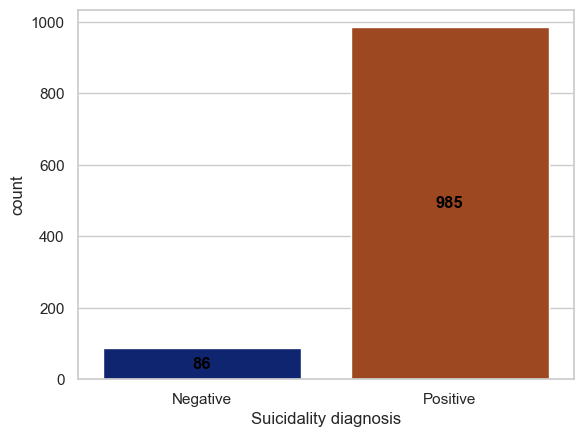

In [76]:
# Function to create a legend mapping for mhsdiag4
def create_diagnosis_legend(df):
    legend_mapping = {1: 'Positive', 2: 'Negative'}
    df['Diagnosis'] = df['mhsdiag4'].map(legend_mapping)

# Check if any item in sublist has a response of 1 and set the diagnosis accordingly
def set_mhsdiag(df, sublist_columns):
    df['mhsdiag4'] = df[sublist_columns].eq(1).any(axis=1).astype(int)
    df['mhsdiag4'] = df['mhsdiag4'].replace(0, 2)
    return df

# Function to compute the severity, handle NaN values, and categorize if mhsdiag4 is equal to 1
def compute_sseverity(df, ms_columns, mhsdiag_column):
    df_temp = pd.DataFrame()

    if mhsdiag_column in df.columns:
        # Compute the severity by summing selected columns where the response is 1
        df_temp['mhsseverity'] = df.loc[df[mhsdiag_column] == 1, ms_columns].eq(1).sum(axis=1)

        # Handle NaN values in severity
        df_temp['mhsseverity'] = df_temp['mhsseverity'].fillna(0)

        # Define custom cutoffs for severity categories
        severity_cutoffs = [1, 8, 16, float('inf')]

        # Create categories for severity based on the custom cutoff points
        df_temp['mhs_cat1'] = pd.cut(df_temp['mhsseverity'], bins=severity_cutoffs, labels=['Low', 'Moderate', 'High'], include_lowest=True)

        # Count the number of individuals in each severity category
        category_counts = df_temp['mhs_cat1'].value_counts()
        print("\nThere are:\n", category_counts)
    else:
        print(f"Column '{mhsdiag_column}' not found in the DataFrame.")

    return df_temp

# Select columns for computing severity of suicidality diagnosis
ms_columns = ['msacc4', 'mshurt4', 'mdie4', 'mshope4', 'msdead4', 'mswharm4', 'mssuic4', 'msplan4',
              'msstep4', 'msharm4', 'msattempt4', 'msresue4', 'msattdie4']

# Select columns for computing suicidality diagnosis
sublist_ms_columns = ['mshope4', 'msdead4', 'mswharm4', 'mssuic4', 'msplan4', 'msstep4', 'msharm4',
                      'msattempt4', 'msresue4', 'msattdie4']

# Apply function to set mhsdiag based on sublist columns
df_hiv12 = set_mhsdiag(df_hiv12, sublist_ms_columns)

# Display the count of participants with a positive diagnosis of suicidality (mhsdiag=1)
count_mhsdiag = df_hiv12['mhsdiag4'].eq(1).sum()
print(f"\nThere are {count_mhsdiag} participants with a positive diagnosis of suicidality")

# Apply function to create a legend mapping for mhsdiag4
create_diagnosis_legend(df_hiv12)

# Plot countplot with legend
ax = sns.countplot(x='mhsdiag4', data=df_hiv12, palette='dark')

# Add counts within each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height() / 2.),
                ha='center', va='center',
                color='black', fontsize=12, weight='bold')

# Modify x-axis labels
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'], rotation=0)
plt.xlabel('Suicidality diagnosis')

# Apply function to compute mhsseverity
df_temp = compute_sseverity(df_hiv12, ms_columns, 'mhsdiag4')

# Concatenate the temporary DataFrame to the original DataFrame
df_hiv12 = pd.concat([df_hiv12, df_temp], axis=1)

plt.show()


In [77]:
mh_count = df_hiv12.groupby('studsite4')[['mhsdiag4']].value_counts().unstack(fill_value=0)

print(mh_count)

mhsdiag4    1    2
studsite4         
1.0        47  488
2.0        39  496


In [78]:
ms_count = df_hiv12.groupby('studsite4')[['msdiag4']].value_counts().unstack(fill_value=0)
print(ms_count)

msdiag4    1.0  2.0
studsite4          
1.0         27  503
2.0         34  496


##### *Format patient ID*  

In [79]:
# Remove any leading or trailing whitespace and standardize patid case if necessary
df_hiv1['patid'] = df_hiv1['patid'].str.strip().str.upper()
df_hiv12['patid'] = df_hiv12['patid'].str.strip().str.upper()

# Function to add leading zeros to the last part of patid and ensure it's 4 digits
def add_zeros(patid):
    if isinstance(patid, str):  # Ensure the patid is a string
        parts = patid.split('/')
        if len(parts) > 1:  # Only modify if '/' is present in patid
            # Add leading zeros and then ensure the part is exactly 4 digits
            last_part = parts[-1].lstrip('0').zfill(4)  # Pad with zeros if necessary
            return f'{parts[0]}/{parts[1]}/{last_part}'
    return patid  # Return the patid as is if it's not a string or doesn't have '/'

# Apply the function to df_hiv1 to ensure the last part of patid is 4 digits
df_hiv1['patid'] = df_hiv1['patid'].apply(add_zeros)

# Check results for df_hiv1 (df_hiv12 is already in the correct format)
print(df_hiv1['patid'].head())


0    ED6/01/0001
1    ED6/01/0002
2    ED6/01/0003
3    ED6/01/0004
4    ED6/01/0005
Name: patid, dtype: object


#### *Select required data*

In [80]:
#Select the specified columns from df_hiv12
df_hiv12 = df_hiv12[['patid', 'studsite4','HIVDementia', 'mddcurdiag4',
                   'SDS',  'Support', 'Stress', 'impairment','msdiag4', 'mhsdiag4']]

df_hiv12.shape

(1071, 10)

#### *Merge baseline and follow-up data*

In [81]:
# merge after cleaning
df_val = pd.merge(
    df_hiv12,
    df_hiv1[['patid', 'sex', 'educat','mstatus','yemploy','prevpsyc',
             'MDD','SES_','Age_group','hivdate','HIV_Dementia','mhsdiag']],
    on='patid',
    how='left'
)

#keep last instance of duplicate ID
df_val = df_val.drop_duplicates(subset='patid', keep='last')

df_val.shape

(1070, 21)

#### *Pipeline for processing the follow-up data*

In [82]:
# Set random seed
np.random.seed(42)

# Select relevant columns from follow-up data
selected_columns = [
    'studsite4', 'sex','educat','mstatus','yemploy','prevpsyc',
    'mddcurdiag4', 'Support','Stress','SES_', 'Age_group', 'hivdate',
    'impairment','HIVDementia','mhsdiag4'
]
df_followup = df_val[selected_columns]

# Separate features and target, and handle missing values in one step
# Fill missing target values with mode and map to binary
y = df_followup['mhsdiag4'].fillna(df_followup['mhsdiag4'].mode()[0]).map({1: 1, 2: 0})

# Separate features (X) by dropping the target column
X = df_followup.drop('mhsdiag4', axis=1)

# Define numeric and categorical variables
num_var = ['HIVDementia']
cat_var = [
     'studsite4', 'sex','educat','mstatus','yemploy','prevpsyc',
    'mddcurdiag4', 'Support','Stress','SES_', 'Age_group', 'hivdate',
    'impairment'
]

# Define preprocessing pipelines for numeric and categorical data
numeric_transformer = SimpleImputer(strategy="median")
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Apply transformations to prepare data for model input
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_var),
    ("cat", categorical_transformer, cat_var)
])

# Transform the feature set
X_val_transformed = preprocessor.fit_transform(X)


##### *GB model validation on follow-up data*

AUC on new data: 0.74


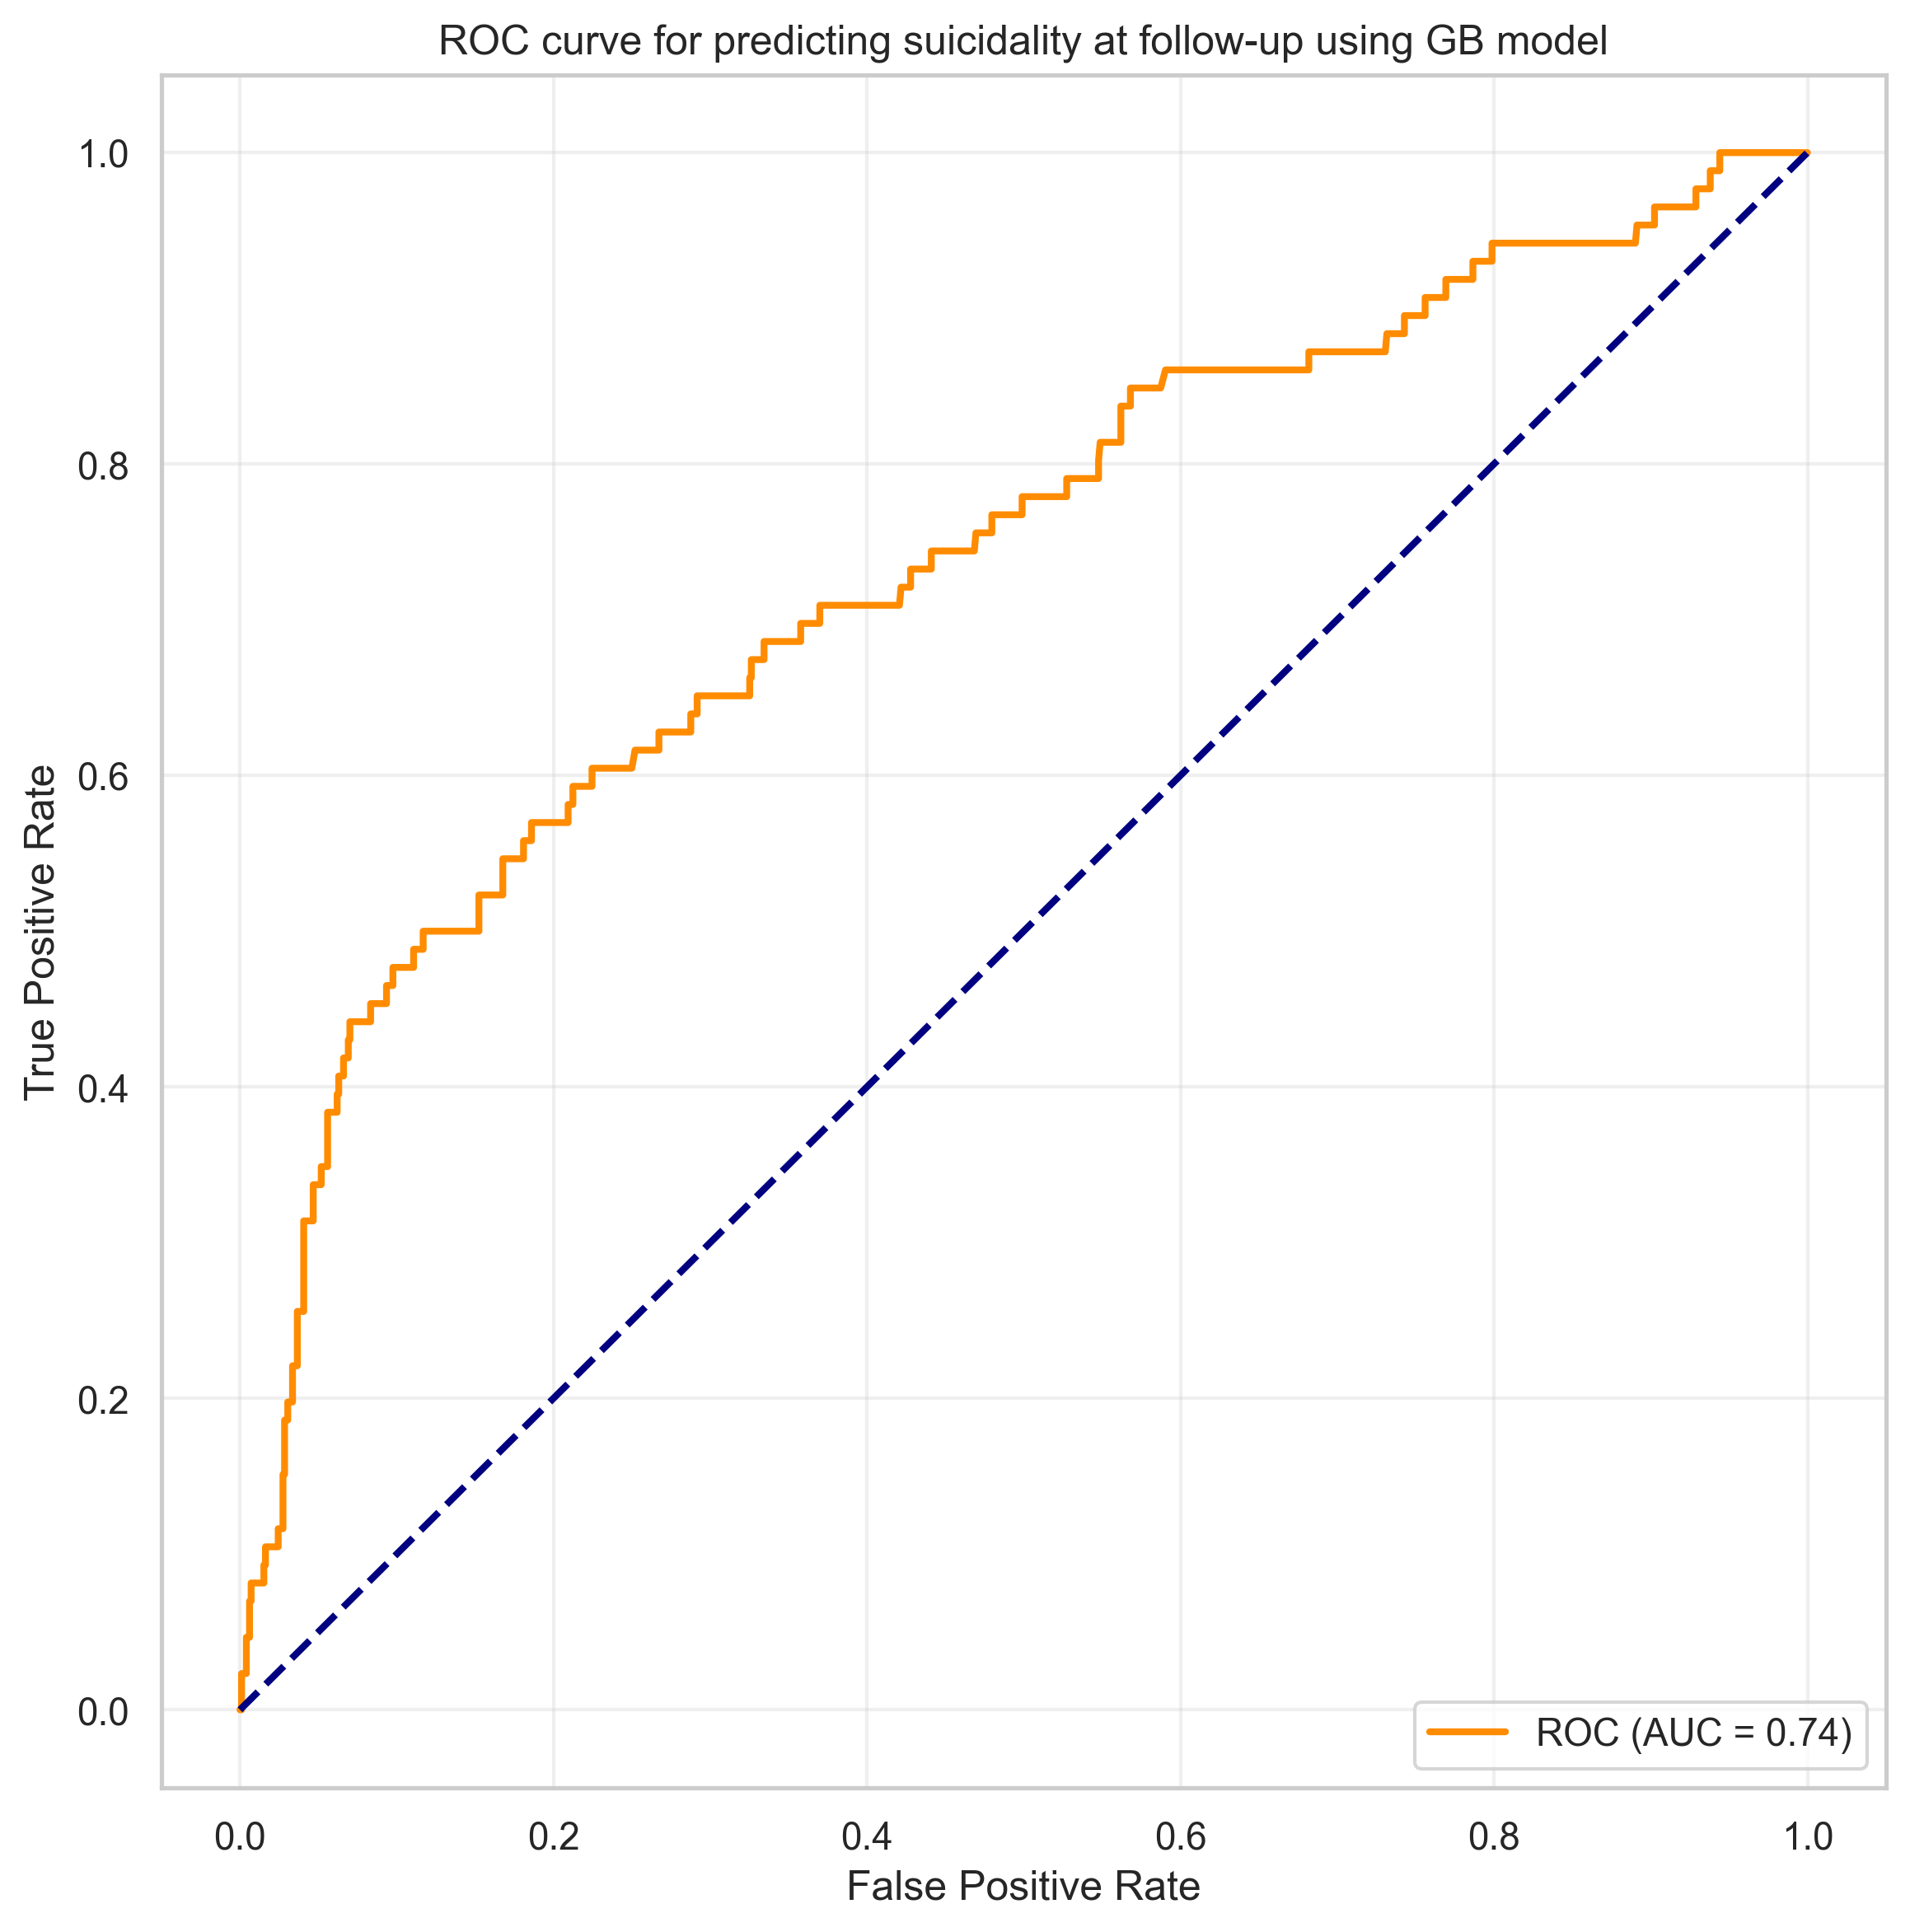

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       984
           1       0.43      0.03      0.06        86

    accuracy                           0.92      1070
   macro avg       0.68      0.52      0.51      1070
weighted avg       0.88      0.92      0.89      1070

Confusion Matrix:
 [[980   4]
 [ 83   3]]
MCC: 0.10


In [83]:
np.random.seed(0)

# Evaluate on the new validation data
gb_val_predictions = best_gb_model.predict(X_val_transformed)
gb_val_probabilities = best_gb_model.predict_proba(X_val_transformed)[:, 1]

# Compute AUC score
auc_val = roc_auc_score(y, gb_val_probabilities)
print(f"AUC on new data: {auc_val:.2f}")

# Generate ROC curve
fpr, tpr, _ = roc_curve(y, gb_val_probabilities)

# Plot the ROC curve
plt.figure(figsize=(9, 9), dpi=300)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for predicting suicidality at follow-up using GB model')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Compute and print other evaluation metrics
print("Classification Report:\n", classification_report(y, gb_val_predictions))
print("Confusion Matrix:\n", confusion_matrix(y, gb_val_predictions))
print(f"MCC: {matthews_corrcoef(y, gb_val_predictions):.2f}")


##### *RF model on follow-up data*

AUC on new data: 0.75


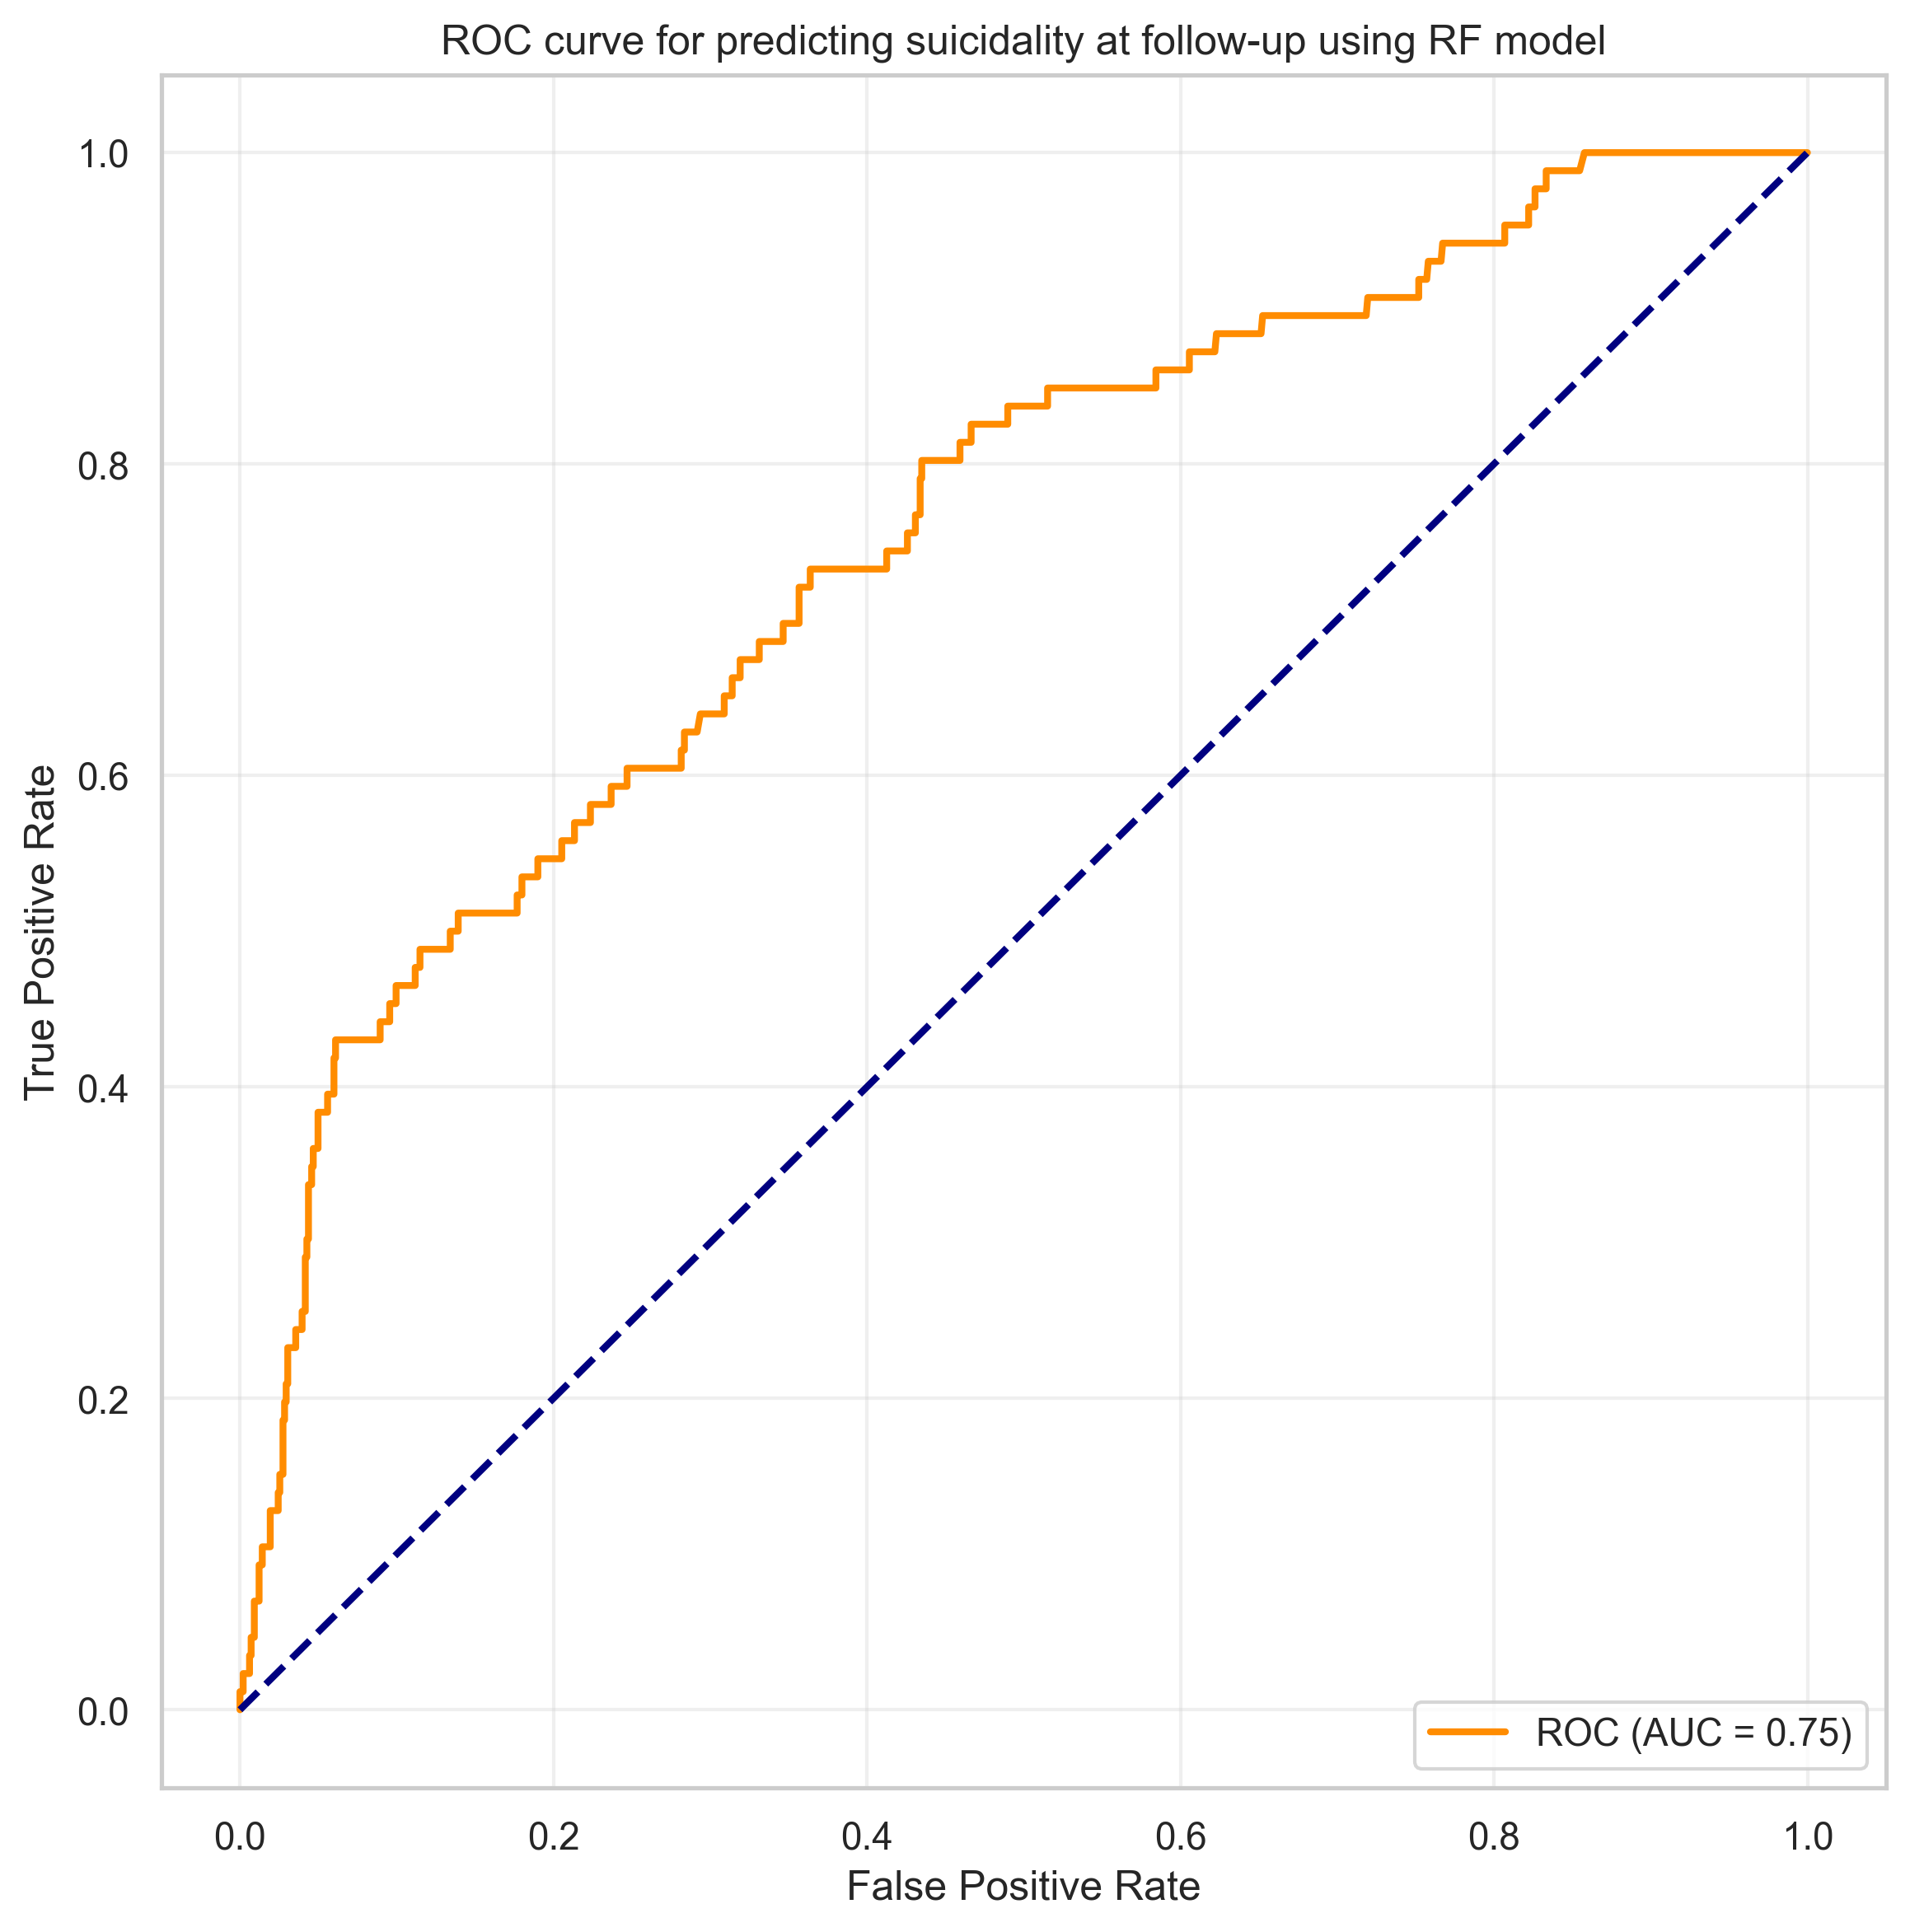

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.96       984
           1       0.25      0.02      0.04        86

    accuracy                           0.92      1070
   macro avg       0.59      0.51      0.50      1070
weighted avg       0.87      0.92      0.88      1070

Confusion Matrix:
 [[978   6]
 [ 84   2]]
MCC: 0.05


In [84]:
np.random.seed(0)

# Evaluate on the new validation data
rf_val_predictions = best_rf_model.predict(X_val_transformed)
rf_val_probabilities = best_rf_model.predict_proba(X_val_transformed)[:, 1]

# Compute AUC score
auc_val = roc_auc_score(y, rf_val_probabilities)
print(f"AUC on new data: {auc_val:.2f}")

# Generate ROC curve
fpr, tpr, _ = roc_curve(y, rf_val_probabilities)

# Plot the ROC curve
plt.figure(figsize=(9, 9), dpi=300)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for predicting suicidality at follow-up using RF model')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Compute and print other evaluation metrics
print("Classification Report:\n", classification_report(y, rf_val_predictions))
print("Confusion Matrix:\n", confusion_matrix(y, rf_val_predictions))
print(f"MCC: {matthews_corrcoef(y, rf_val_predictions):.2f}")


##### *Using balanced RF model*

AUC on new data: 0.75


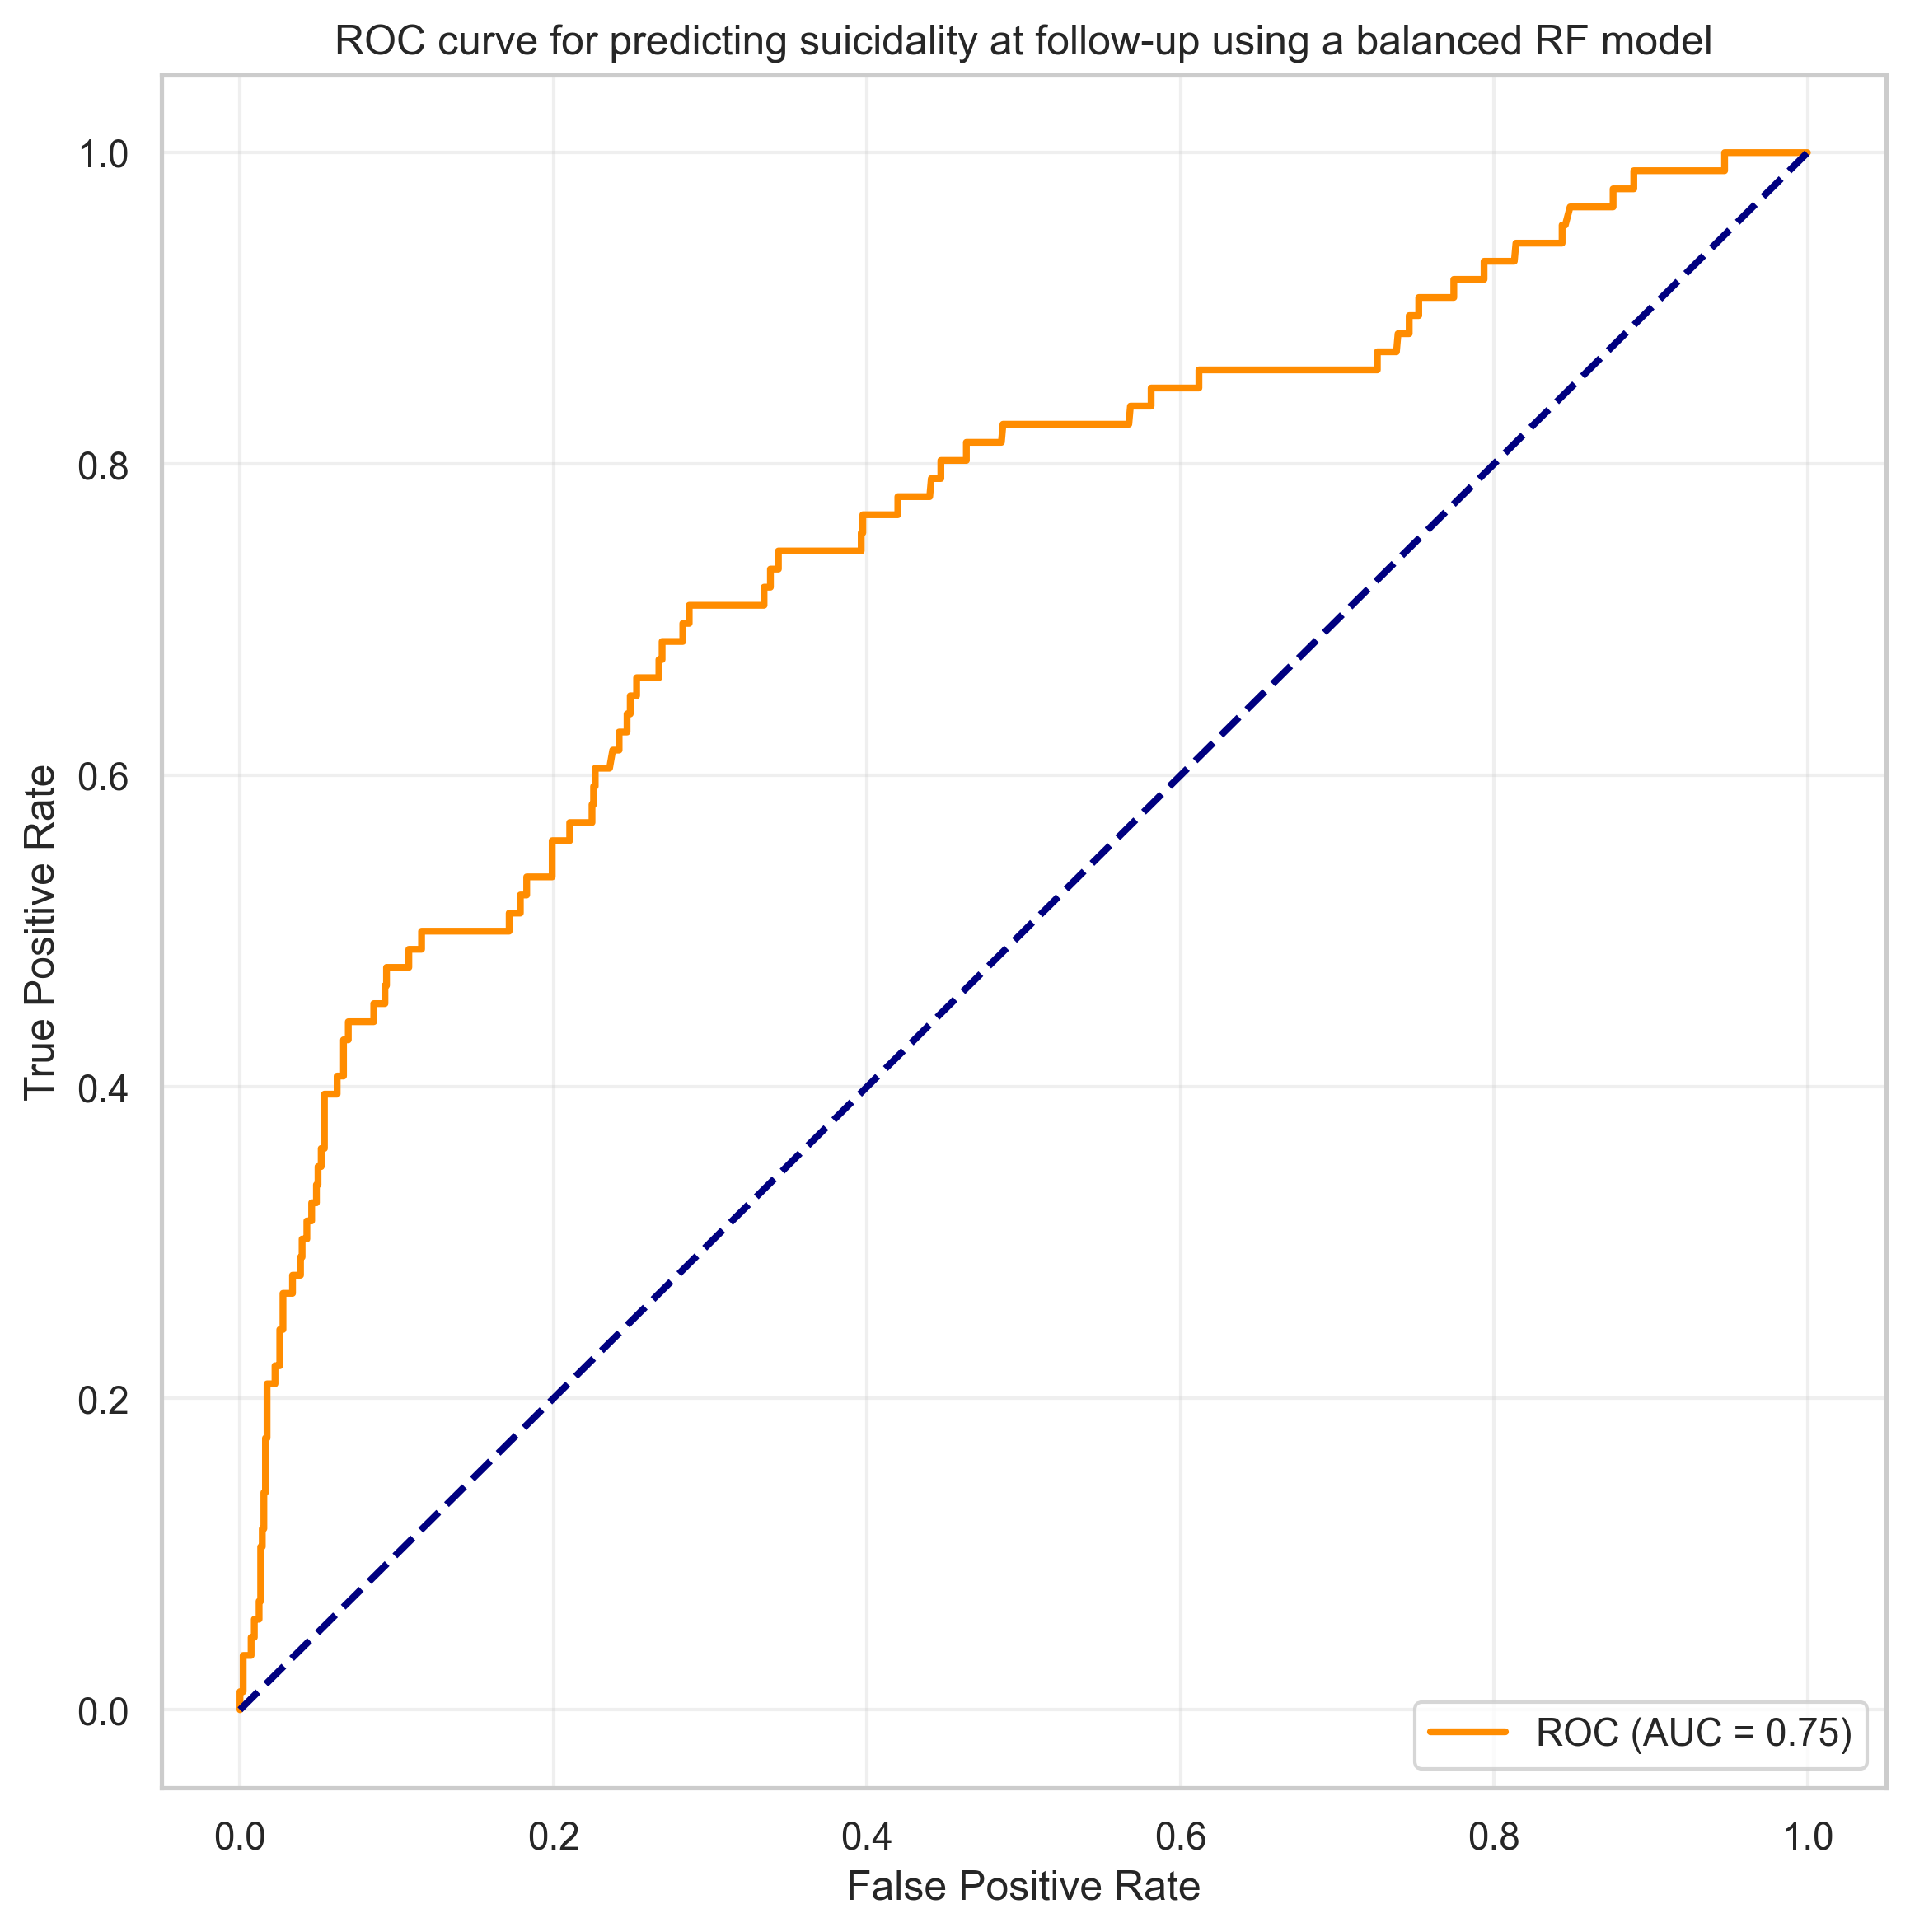

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       984
           1       0.39      0.40      0.39        86

    accuracy                           0.90      1070
   macro avg       0.67      0.67      0.67      1070
weighted avg       0.90      0.90      0.90      1070

Confusion Matrix:
 [[930  54]
 [ 52  34]]
MCC: 0.34


In [85]:
np.random.seed(0)

# Evaluate on the new validation data
rf_val_predictions = bal_rf_model.predict(X_val_transformed)
rf_val_probabilities = bal_rf_model.predict_proba(X_val_transformed)[:, 1]

# Compute AUC score
auc_val = roc_auc_score(y, rf_val_probabilities)
print(f"AUC on new data: {auc_val:.2f}")

# Generate ROC curve
fpr, tpr, _ = roc_curve(y, rf_val_probabilities)

# Plot the ROC curve
plt.figure(figsize=(9, 9), dpi=300)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for predicting suicidality at follow-up using a balanced RF model')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Compute and print other evaluation metrics
print("Classification Report:\n", classification_report(y, rf_val_predictions))
print("Confusion Matrix:\n", confusion_matrix(y, rf_val_predictions))
print(f"MCC: {matthews_corrcoef(y, rf_val_predictions):.2f}")


#### *Predicting incident suicidality*

In [86]:

# Set conditional selection and create 'incident' column
condition = (df_val['mhsdiag'] == 2) & (df_val['mhsdiag4'] == 1)
df_val['incident'] = 0
df_val.loc[condition, 'incident'] = 1

# Count the number of incident cases
incident_count = df_val['incident'].sum()
print("Incident count:", incident_count)

Incident count: 54


In [87]:
# Set random seed
np.random.seed(42)

# Selected columns for follow-up data
selected = [
    'studsite4', 'sex', 'educat', 'mstatus', 'yemploy', 'prevpsyc',
    'mddcurdiag4', 'Support', 'Stress', 'SES_', 'Age_group', 'hivdate',
    'impairment', 'HIVDementia', 'incident'
]

# Subset and separate features and target
df_incident = df_val[selected]
X = df_incident.drop('incident', axis=1)
y = df_incident['incident'].fillna(0)  # Ensure no missing values in 'incident'

# Train-test split (stratify to maintain distribution of the target variable)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Define numeric and categorical variables
num_var = ['HIVDementia']
cat_var = [
    'studsite4', 'sex', 'educat', 'mstatus', 'yemploy', 'prevpsyc',
    'mddcurdiag4', 'Support', 'Stress', 'SES_', 'Age_group', 'hivdate',
    'impairment'
]

# Define transformers
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Preprocessor with transformations
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_var),
    ("cat", categorical_transformer, cat_var)
])

# Create the pipeline with preprocessing
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Transform the training and testing datasets
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)


### *Predict incident suicidality*

#### *RF model*

Fitting 10 folds for each of 216 candidates, totalling 2160 fits

Best Hyperparameters: {'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 10, 'clf__n_estimators': 200}

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       305
           1       0.13      0.12      0.13        16

    accuracy                           0.92       321
   macro avg       0.54      0.54      0.54       321
weighted avg       0.91      0.92      0.91       321


Confusion Matrix:
 [[292  13]
 [ 14   2]]

MCC: 0.08
AUC: 0.73


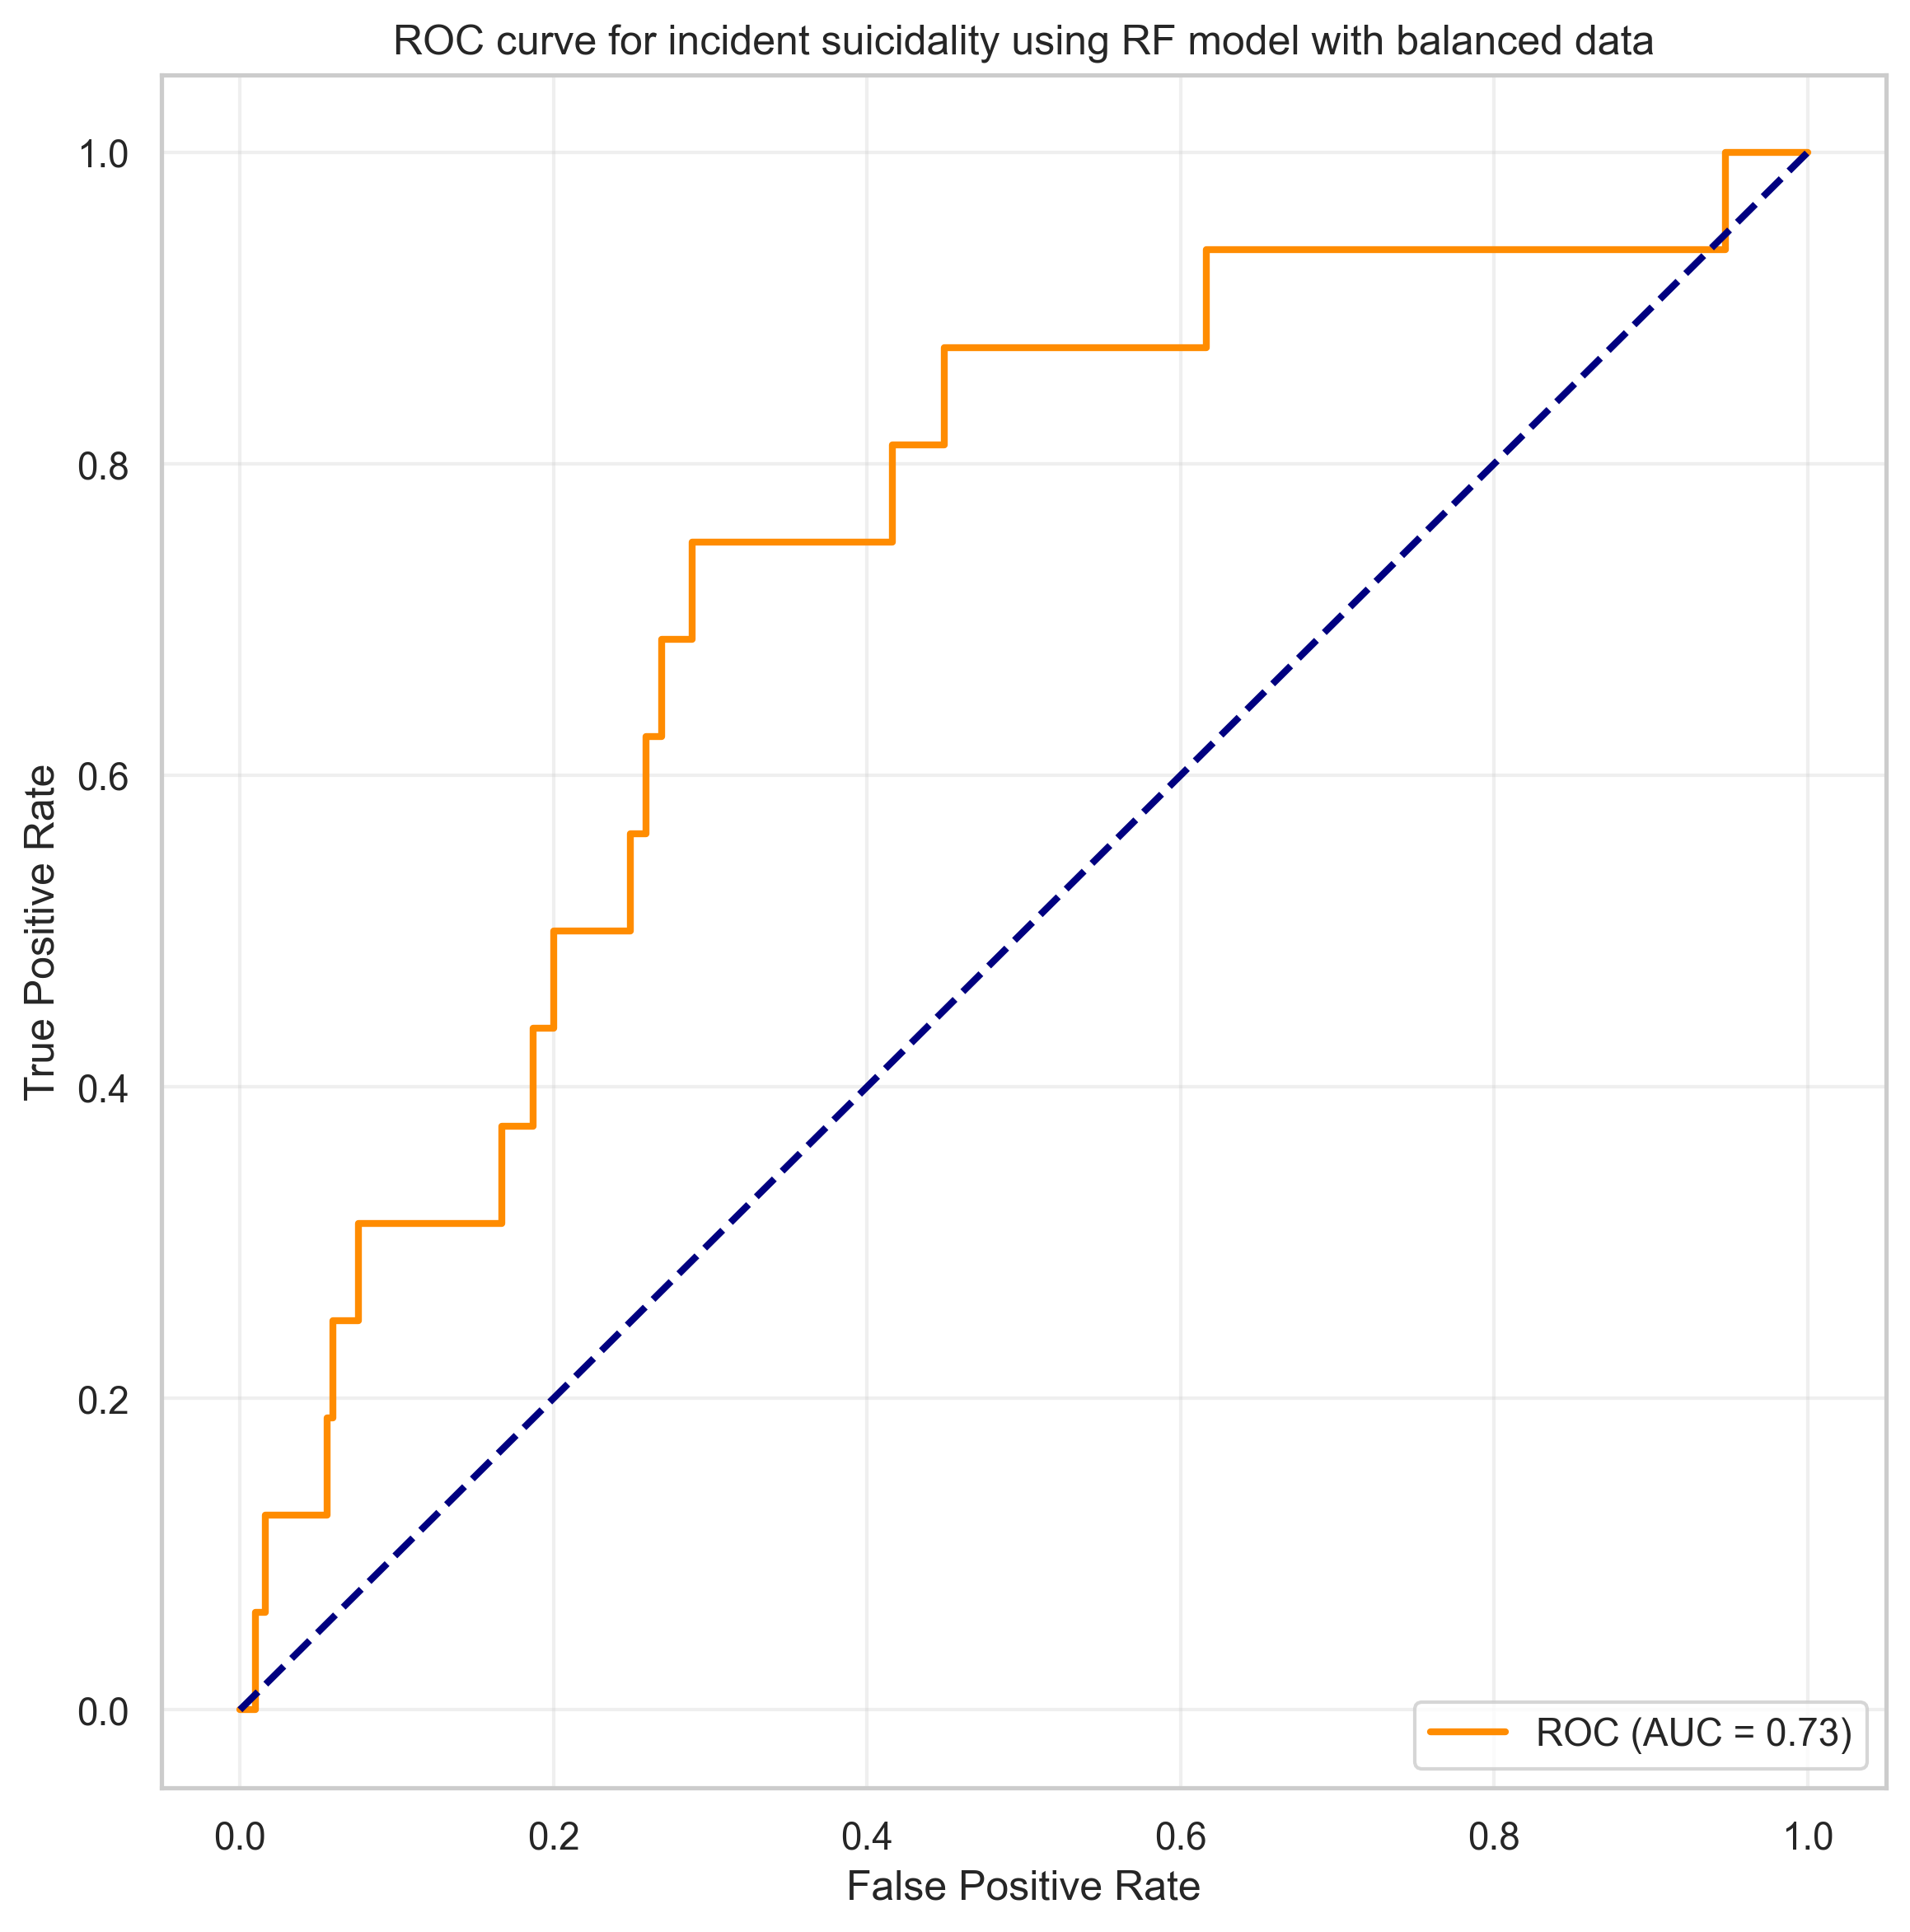

In [88]:
# Set random seed
np.random.seed(42)

# Define pipeline with Random Forest Classifier
pipeline_rf = Pipeline([
    ('clf', RandomForestClassifier(random_state=42))
])

# Define hyperparameter grid for Random Forest
param_grid = {
    'clf__n_estimators': [50, 100, 200],  # Number of trees
    'clf__max_depth': [None, 10, 20, 30],  # Depth of each tree
    'clf__min_samples_split': [2, 5, 10],  # Minimum samples required to split
    'clf__min_samples_leaf': [1, 2, 4],  # Minimum samples per leaf
    'clf__class_weight': ['balanced', 'balanced_subsample']
}

# Perform GridSearchCV to optimize AUC
grid_search = GridSearchCV(
    pipeline_rf,
    param_grid,
    cv=10,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_transformed, y_train)

# Get the best model and display optimal parameters
new_rf_model = grid_search.best_estimator_
print("\nBest Hyperparameters:", grid_search.best_params_)

# Predict on the test set
test_predictions = new_rf_model.predict(X_test_transformed)
test_probabilities = new_rf_model.named_steps['clf'].predict_proba(X_test_transformed)[:, 1]

# Evaluate using confusion matrix, MCC, and AUC
conf_matrix = confusion_matrix(y_test, test_predictions)
mcc = matthews_corrcoef(y_test, test_predictions)
auc = roc_auc_score(y_test, test_probabilities)

print("\nClassification Report:\n", classification_report(y_test, test_predictions))
print("\nConfusion Matrix:\n", conf_matrix)
print(f"\nMCC: {mcc:.2f}")
print(f"AUC: {auc:.2f}")

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, test_probabilities)

# Plot the ROC curve
plt.figure(figsize=(9, 9), dpi=300)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for incident suicidality using RF model with balanced data')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


##### *GB model*

Fitting 10 folds for each of 486 candidates, totalling 4860 fits

Best Hyperparameters: {'clf__learning_rate': 0.01, 'clf__max_depth': 7, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 10, 'clf__n_estimators': 50, 'clf__subsample': 1.0}

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       305
           1       0.00      0.00      0.00        16

    accuracy                           0.95       321
   macro avg       0.48      0.50      0.49       321
weighted avg       0.90      0.95      0.93       321


Confusion Matrix:
 [[305   0]
 [ 16   0]]

MCC: 0.00
AUC: 0.66


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


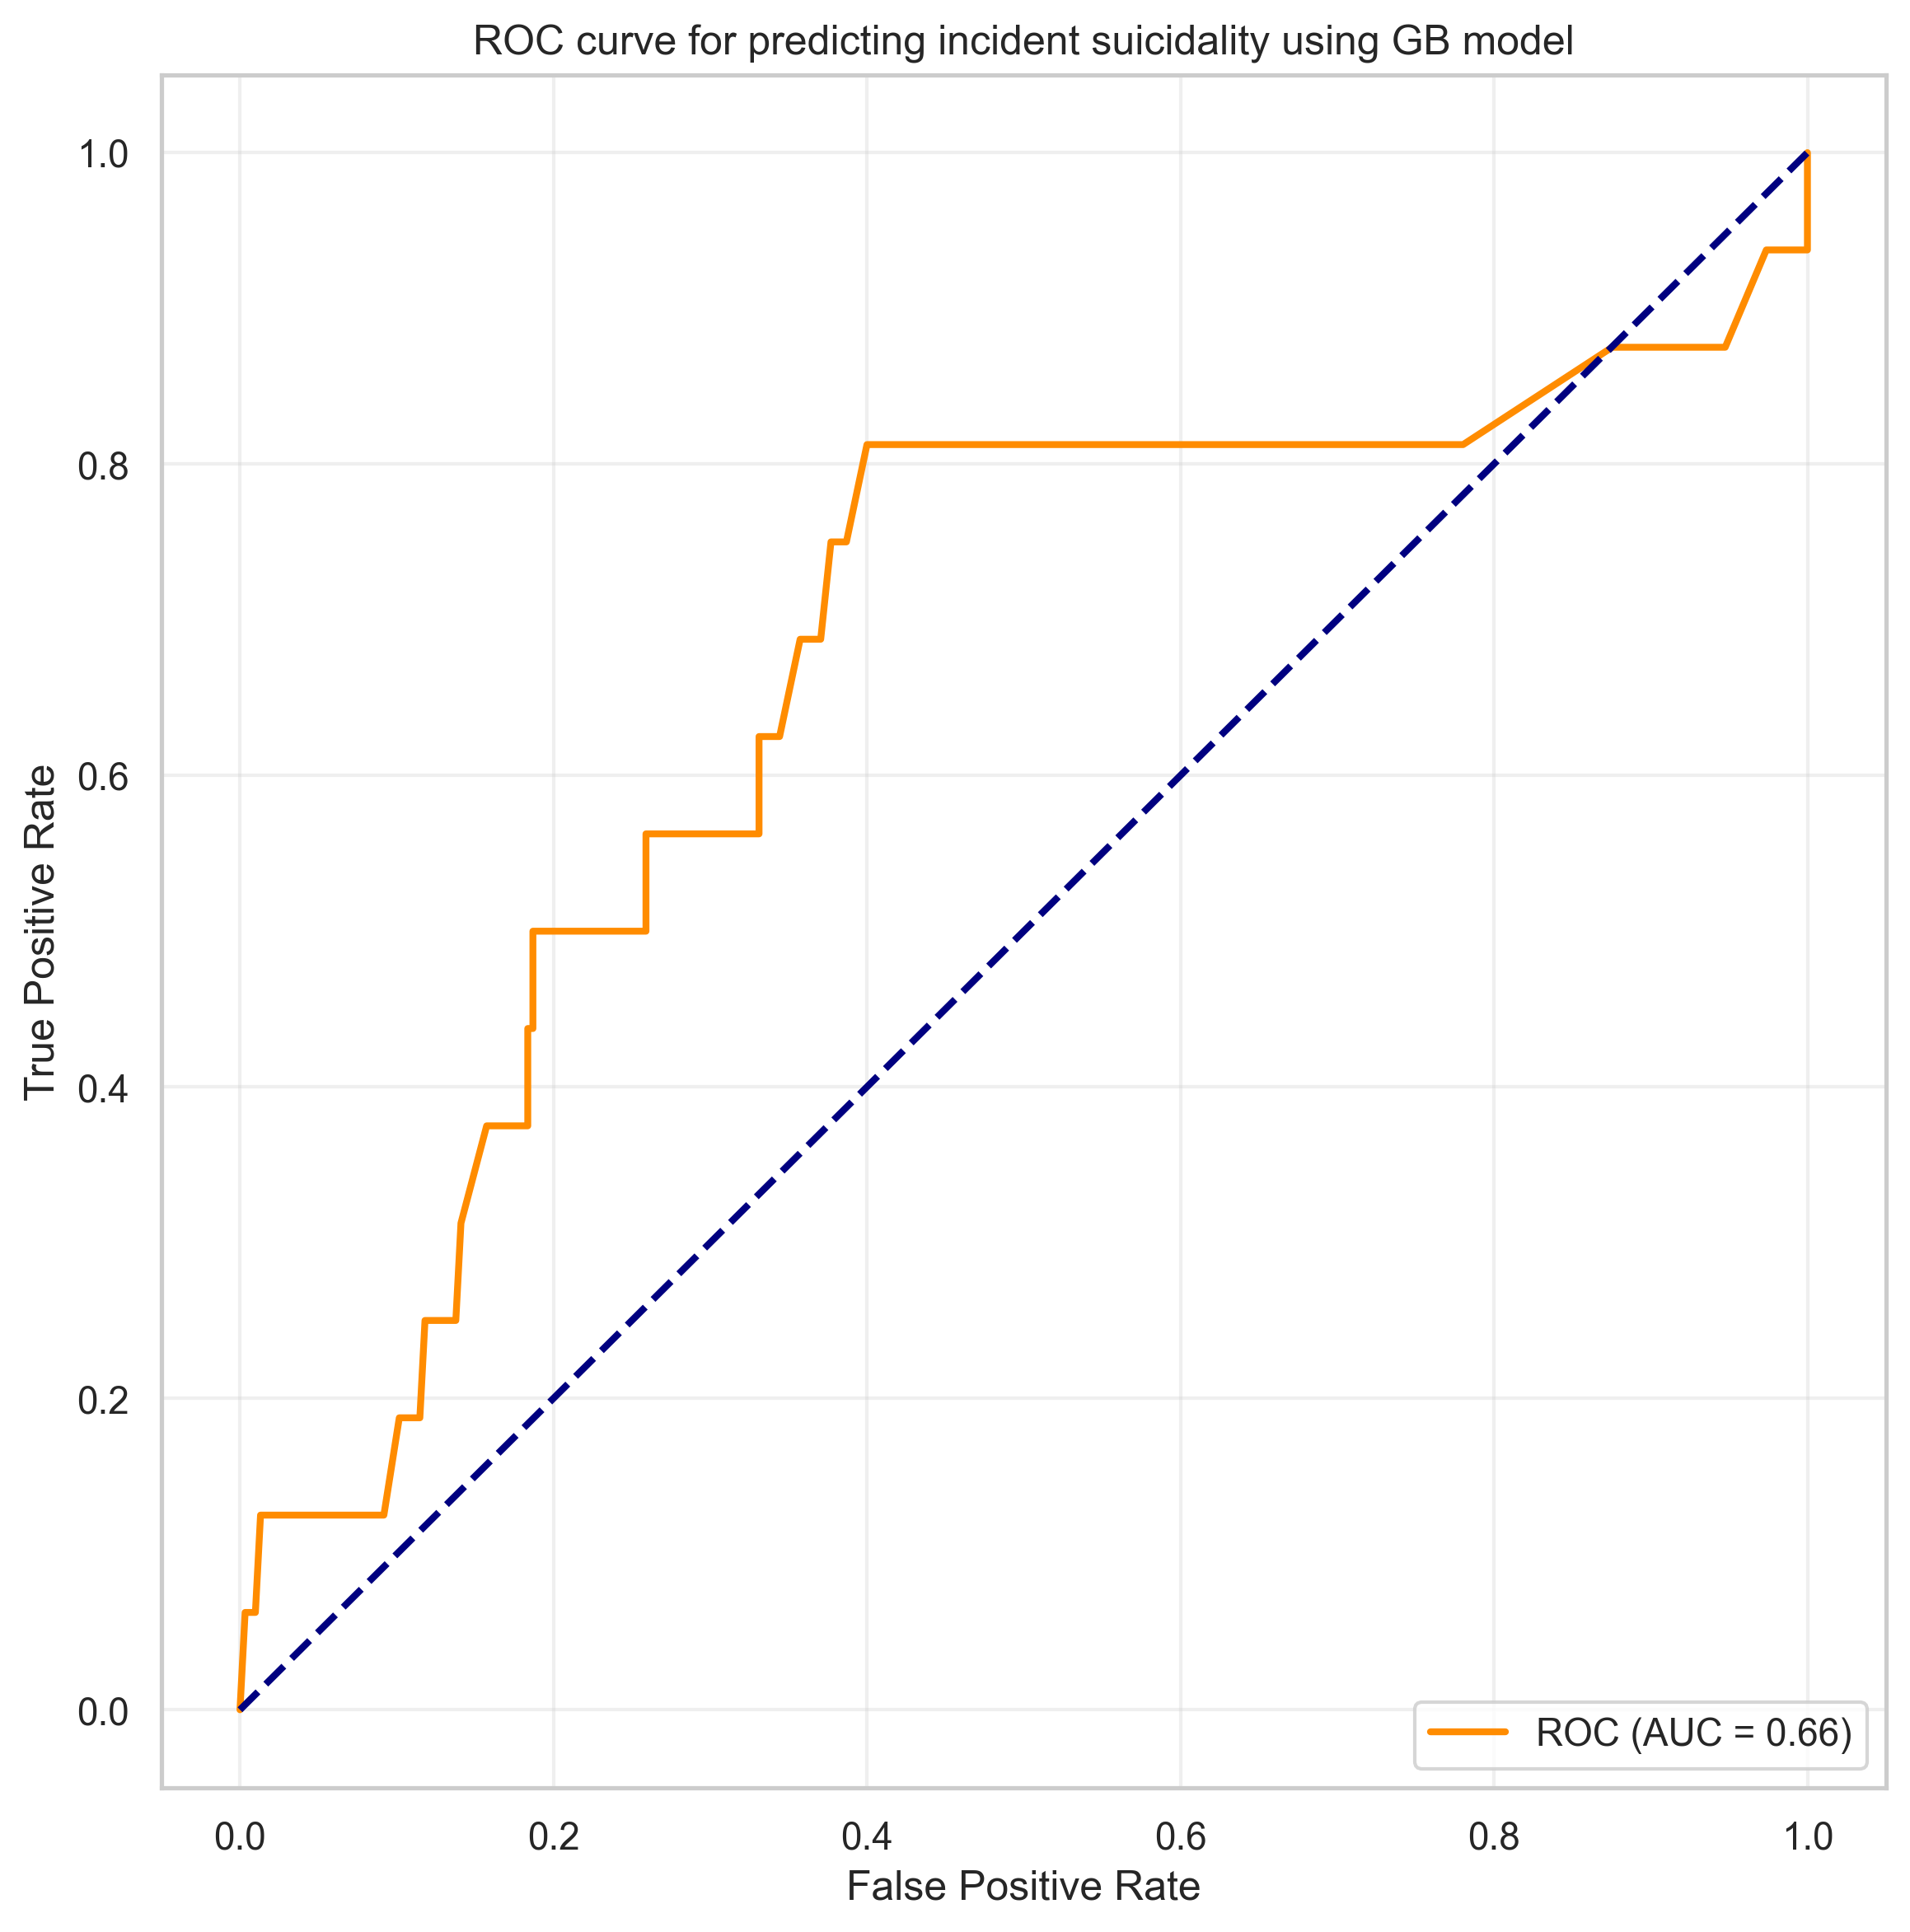

In [89]:
# Set random seed
np.random.seed(42)

# Define pipeline with Gradient Boosting Classifier
pipeline_gb = Pipeline([
    ('clf', GradientBoostingClassifier(random_state=42))
])

# Define hyperparameter grid for Gradient Boosting
param_grid = {
    'clf__n_estimators': [50, 100, 200],  
    'clf__learning_rate': [0.01, 0.1, 0.2],  
    'clf__max_depth': [3, 5, 7],  
    'clf__min_samples_split': [2, 5, 10],  
    'clf__min_samples_leaf': [1, 2, 4],  
    'clf__subsample': [0.8, 1.0]  
}

# Perform GridSearchCV to optimize AUC
grid_search = GridSearchCV(
    pipeline_gb,
    param_grid,
    cv=10,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_transformed, y_train)

# Get the best model and display optimal parameters
new_gb_model = grid_search.best_estimator_
print("\nBest Hyperparameters:", grid_search.best_params_)

# Predict on the test set
test_predictions = new_gb_model.predict(X_test_transformed)
test_probabilities = new_gb_model.named_steps['clf'].predict_proba(X_test_transformed)[:, 1]

# Evaluate using confusion matrix, MCC, and AUC
conf_matrix = confusion_matrix(y_test, test_predictions)
mcc = matthews_corrcoef(y_test, test_predictions)
auc = roc_auc_score(y_test, test_probabilities)

print("\nClassification Report:\n", classification_report(y_test, test_predictions))
print("\nConfusion Matrix:\n", conf_matrix)
print(f"\nMCC: {mcc:.2f}")
print(f"AUC: {auc:.2f}")

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, test_probabilities)

# Plot the ROC curve
plt.figure(figsize=(9, 9), dpi=300)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for predicting incident suicidality using GB model')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


#### *Load PRS data*

In [90]:
# Read the file into a pandas dataframe
PRS_data = pd.read_csv("../Data/Clinical/PRS.txt", sep="\t")

# Calculate skewness 
skewness = skew(PRS_data['PRS'])
print(f"Skew: {skewness:.2f}")

# Initialize the StandardScaler
scaler = StandardScaler()

# Normalize the PRS values to have a mean of 0 and standard deviation of 1
PRS_data['PRS'] = scaler.fit_transform(PRS_data[['PRS']])

#merge PRS results with baseline data on patient id
df_PRS = pd.merge(PRS_data, df_hiv1, on="patid", how="left")
df_PRS.shape

Skew: -0.27


(282, 322)

##### *Predict suicidality using standard RF model*

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
AUC: 0.73
Average Precision (AP): 0.49
MCC: 0.24

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87        45
           1       0.50      0.25      0.33        12

    accuracy                           0.79        57
   macro avg       0.66      0.59      0.60        57
weighted avg       0.76      0.79      0.76        57


Confusion Matrix:
[[42  3]
 [ 9  3]]


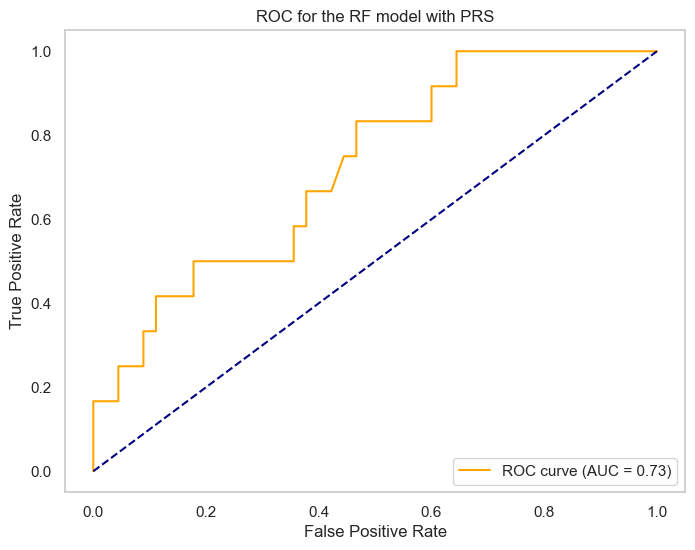

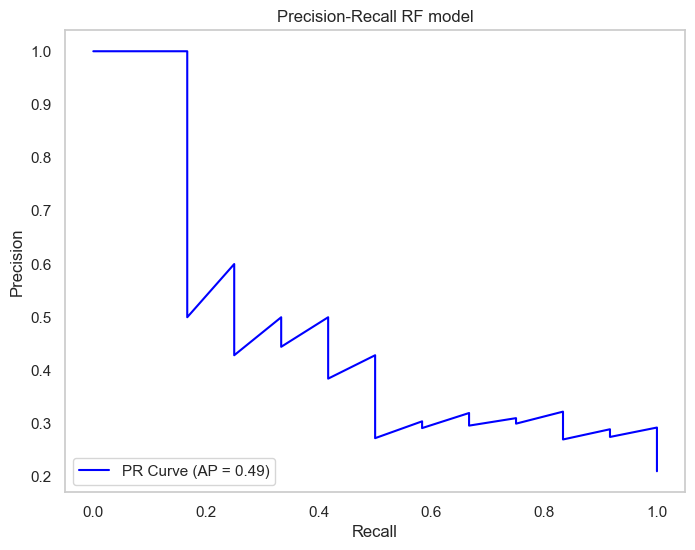

In [91]:
# Set random seed
np.random.seed(42)

# Prepare data (assuming df_PRS is defined)
selected = [
    'studsite', 'sex', 'educat', 'mstatus', 'yemploy', 'prevpsyc',
    'MDD', 'Support', 'Stress', 'SES_', 'Age_group', 'hivdate',
    'impairment', 'HIV_Dementia', 'PRS', 'mhsdiag'
]
X_val = df_PRS[selected].drop('mhsdiag', axis=1)
y_val = df_PRS['mhsdiag']

# Impute and map target variable
y_imputer = SimpleImputer(strategy='most_frequent')
y_val = pd.Series(y_imputer.fit_transform(y_val.values.reshape(-1, 1)).ravel())
label_mapping = {1: 1, 2: 0}
y_val = y_val.map(label_mapping)

# Define numeric and categorical variables
num_var = ['HIV_Dementia', 'PRS']
cat_var = [
    'studsite', 'sex', 'educat', 'mstatus', 'yemploy', 'prevpsyc',
    'MDD', 'Support', 'Stress', 'SES_', 'Age_group', 'hivdate', 'impairment'
]

# Define transformers
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", max_categories=20))
])
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_var),
    ("cat", categorical_transformer, cat_var)
])

# Split data
X_val_train, X_val_test, y_val_train, y_val_test = train_test_split(
    X_val, y_val, test_size=0.2, stratify=y_val, random_state=42
)

# Create pipeline
rf = RandomForestClassifier(random_state=42)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', rf)
])

# Hyperparameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 150, 200],
    'classifier__max_depth': [None, 10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
}

# Grid search with AUC scoring
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=10,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_val_train, y_val_train)

# Best model and evaluation
b_model = grid_search.best_estimator_
predictions = b_model.predict(X_val_test)
predicted_probs = b_model.predict_proba(X_val_test)[:, 1]
auc = roc_auc_score(y_val_test, predicted_probs)
avg_precision = average_precision_score(y_val_test, predicted_probs)
mcc = matthews_corrcoef(y_val_test, predictions)

# Print results
print("Best Parameters:", grid_search.best_params_)
print(f"AUC: {auc:.2f}")
print(f"Average Precision (AP): {avg_precision:.2f}")
print(f"MCC: {mcc:.2f}")
print("\nClassification Report:")
print(classification_report(y_val_test, predictions))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val_test, predictions))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_val_test, predicted_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for the RF model with PRS")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val_test, predicted_probs)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f"PR Curve (AP = {avg_precision:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall RF model")
plt.legend(loc="lower left")
plt.grid()
plt.show()


##### *Feature importance in RF model with PRS*

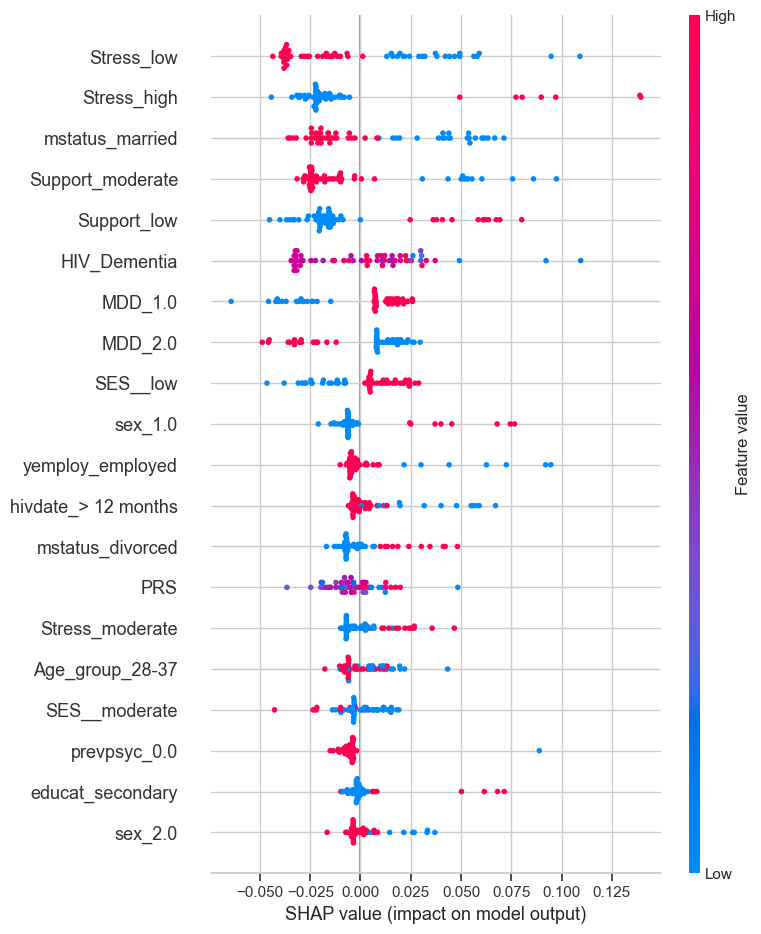

In [92]:
# Extract the fitted Random Forest model from the pipeline
rf_model = b_model.named_steps['classifier']

# Preprocess the test data using the preprocessor in the pipeline
X_val_test_preprocessed = b_model.named_steps['preprocessor'].transform(X_val_test)

# Initialize the SHAP TreeExplainer for the Random Forest model
explainer_rf = shap.TreeExplainer(rf_model)

# Compute SHAP values for the preprocessed test set
shap_values_rf = explainer_rf.shap_values(X_val_test_preprocessed)

# Extract feature names, combining numeric and one-hot encoded categorical features
categorical_feature_names = b_model.named_steps['preprocessor'] \
    .named_transformers_['cat']['encoder'].get_feature_names_out(input_features=cat_var)
feature_names = np.concatenate([num_var, categorical_feature_names])

# Generate SHAP summary plot
shap.summary_plot(shap_values_rf[1], X_val_test_preprocessed, feature_names=feature_names)

##### *Predict suicidality with RF model using balanced data*

Fitting 10 folds for each of 288 candidates, totalling 2880 fits
Best Parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
AUC: 0.80
Average Precision (AP): 0.54
MCC: 0.39

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.71      0.80        45
           1       0.41      0.75      0.53        12

    accuracy                           0.72        57
   macro avg       0.66      0.73      0.66        57
weighted avg       0.81      0.72      0.74        57


Confusion Matrix:
[[32 13]
 [ 3  9]]


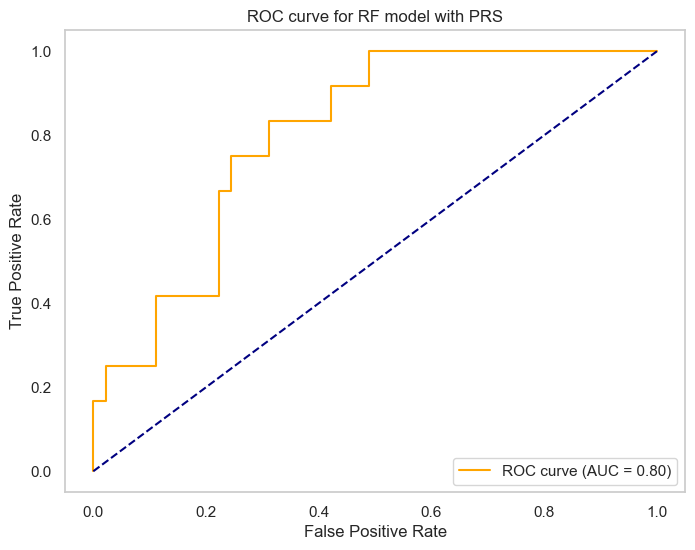

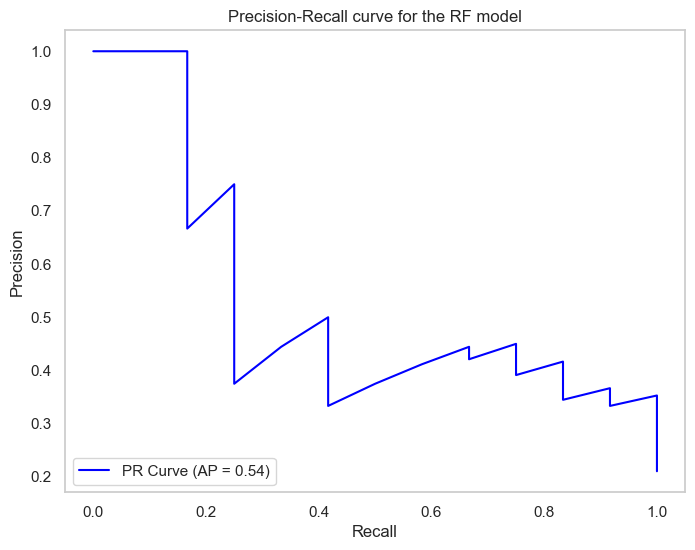

In [93]:
# Set random seed
np.random.seed(42)

# Prepare data (assuming df_PRS is defined)
selected = [
    'studsite', 'sex', 'educat', 'mstatus', 'yemploy', 'prevpsyc',
    'MDD', 'Support', 'Stress', 'SES_', 'Age_group', 'hivdate',
    'impairment', 'HIV_Dementia', 'PRS', 'mhsdiag'
]
X_val = df_PRS[selected].drop('mhsdiag', axis=1)
y_val = df_PRS['mhsdiag']

# Impute and map target variable
y_imputer = SimpleImputer(strategy='most_frequent')
y_val = pd.Series(y_imputer.fit_transform(y_val.values.reshape(-1, 1)).ravel())
label_mapping = {1: 1, 2: 0}
y_val = y_val.map(label_mapping)

# Define numeric and categorical variables
num_var = ['HIV_Dementia', 'PRS']
cat_var = [
    'studsite', 'sex', 'educat', 'mstatus', 'yemploy', 'prevpsyc',
    'MDD', 'Support', 'Stress', 'SES_', 'Age_group', 'hivdate', 'impairment'
]

# Define transformers
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", max_categories=20))
])
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_var),
    ("cat", categorical_transformer, cat_var)
])

# Split data
X_val_train, X_val_test, y_val_train, y_val_test = train_test_split(
    X_val, y_val, test_size=0.2, stratify=y_val, random_state=42
)

# Create pipeline
rf = RandomForestClassifier(random_state=42)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', rf)
])

# Hyperparameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 150, 200],
    'classifier__max_depth': [None, 10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__class_weight': ['balanced', 'balanced_subsample']
}

# Grid search with AUC scoring
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=10,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_val_train, y_val_train)

# Best model and evaluation
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_val_test)
predicted_probs = best_model.predict_proba(X_val_test)[:, 1]
auc = roc_auc_score(y_val_test, predicted_probs)
avg_precision = average_precision_score(y_val_test, predicted_probs)
mcc = matthews_corrcoef(y_val_test, predictions)

# Print results
print("Best Parameters:", grid_search.best_params_)
print(f"AUC: {auc:.2f}")
print(f"Average Precision (AP): {avg_precision:.2f}")
print(f"MCC: {mcc:.2f}")
print("\nClassification Report:")
print(classification_report(y_val_test, predictions))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val_test, predictions))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_val_test, predicted_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for RF model with PRS")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val_test, predicted_probs)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f"PR Curve (AP = {avg_precision:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve for the RF model")
plt.legend(loc="lower left")
plt.grid()
plt.show()


##### *Feature importance in RF model with balanced data*

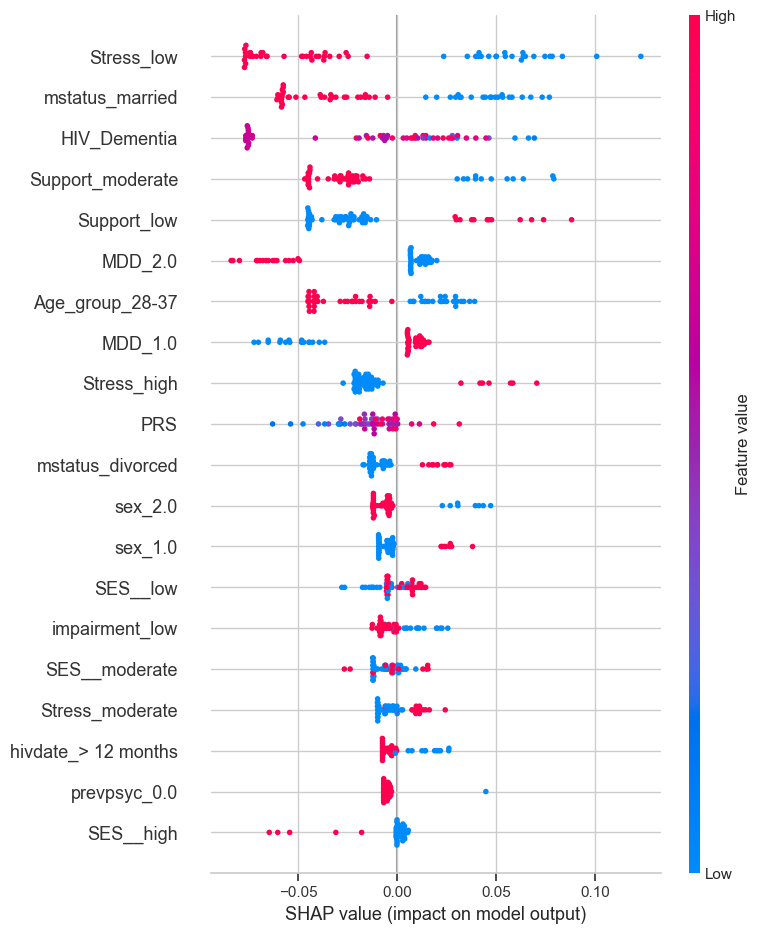

In [94]:
import shap  # Ensure SHAP is installed
import matplotlib.pyplot as plt

# Extract the fitted Random Forest model from the pipeline
rf_model = best_model.named_steps['classifier']

# Preprocess the test data using the preprocessor in the pipeline
X_val_test_preprocessed = best_model.named_steps['preprocessor'].transform(X_val_test)

# Initialize the SHAP TreeExplainer for the Random Forest model
explainer_rf = shap.TreeExplainer(rf_model)

# Compute SHAP values for the preprocessed test set
shap_values_rf = explainer_rf.shap_values(X_val_test_preprocessed)

# Extract feature names, combining numeric and one-hot encoded categorical features
categorical_feature_names = best_model.named_steps['preprocessor'] \
    .named_transformers_['cat']['encoder'].get_feature_names_out(input_features=cat_var)
feature_names = np.concatenate([num_var, categorical_feature_names])

# Generate SHAP summary plot
shap.summary_plot(shap_values_rf[1], X_val_test_preprocessed, feature_names=feature_names)


##### *Predict suicidality using GB model*

Fitting 10 folds for each of 1296 candidates, totalling 12960 fits
Best Parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}
AUC: 0.77
Average Precision (AP): 0.50
MCC: 0.26

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.98      0.89        45
           1       0.67      0.17      0.27        12

    accuracy                           0.81        57
   macro avg       0.74      0.57      0.58        57
weighted avg       0.78      0.81      0.76        57


Confusion Matrix:
[[44  1]
 [10  2]]


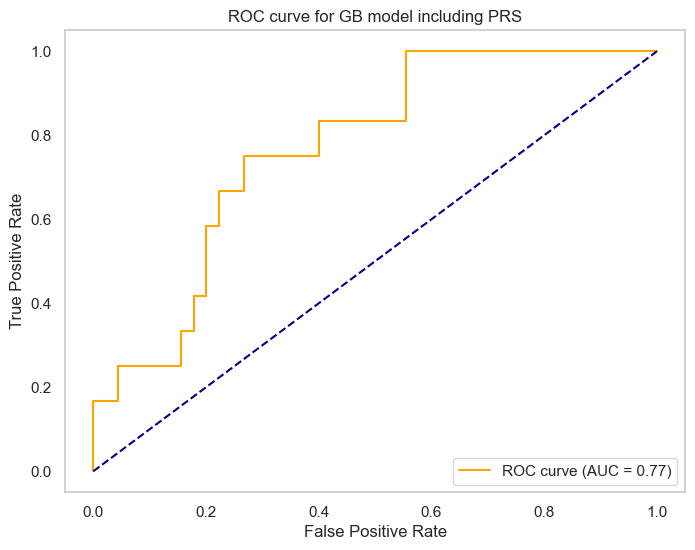

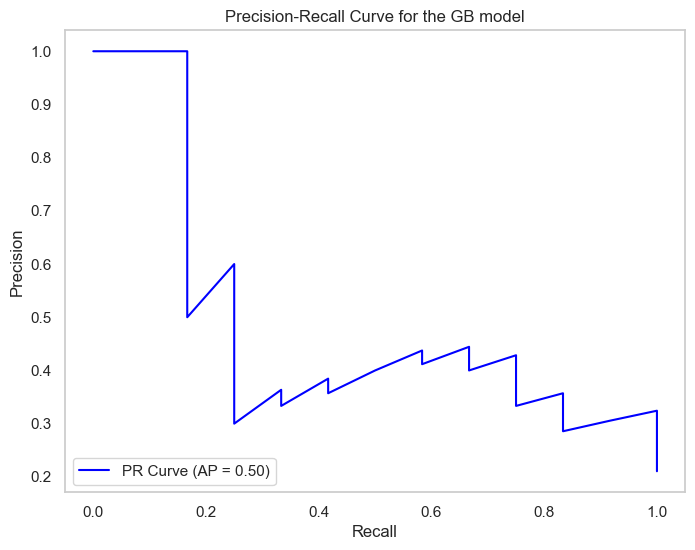

In [95]:

# Prepare data (assuming df_PRS is defined)
selected = [
    'studsite', 'sex', 'educat', 'mstatus', 'yemploy', 'prevpsyc',
    'MDD', 'Support', 'Stress', 'SES_', 'Age_group', 'hivdate',
    'impairment', 'HIV_Dementia', 'PRS', 'mhsdiag'
]
X_val = df_PRS[selected].drop('mhsdiag', axis=1)
y_val = df_PRS['mhsdiag']

# Impute and map target variable
y_imputer = SimpleImputer(strategy='most_frequent')
y_val = pd.Series(y_imputer.fit_transform(y_val.values.reshape(-1, 1)).ravel())
label_mapping = {1: 1, 2: 0}
y_val = y_val.map(label_mapping)

# Define numeric and categorical variables
num_var = ['HIV_Dementia', 'PRS']
cat_var = [
    'studsite', 'sex', 'educat', 'mstatus', 'yemploy', 'prevpsyc',
    'MDD', 'Support', 'Stress', 'SES_', 'Age_group', 'hivdate', 'impairment'
]

# Define transformers
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", max_categories=20))
])
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_var),
    ("cat", categorical_transformer, cat_var)
])

# Split data
X_val_train, X_val_test, y_val_train, y_val_test = train_test_split(
    X_val, y_val, test_size=0.2, stratify=y_val, random_state=42
)

# Create pipeline with GradientBoostingClassifier
gb_model = GradientBoostingClassifier(random_state=42)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', gb_model)
])

# Hyperparameter grid for Gradient Boosting
param_grid = {
    'classifier__n_estimators': [50, 100, 150, 200],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Grid search with AUC scoring
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=10,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_val_train, y_val_train)

# Best model and evaluation
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_val_test)
predicted_probs = best_model.predict_proba(X_val_test)[:, 1]
auc = roc_auc_score(y_val_test, predicted_probs)
avg_precision = average_precision_score(y_val_test, predicted_probs)
mcc = matthews_corrcoef(y_val_test, predictions)

# Print results
print("Best Parameters:", grid_search.best_params_)
print(f"AUC: {auc:.2f}")
print(f"Average Precision (AP): {avg_precision:.2f}")
print(f"MCC: {mcc:.2f}")
print("\nClassification Report:")
print(classification_report(y_val_test, predictions))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val_test, predictions))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_val_test, predicted_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for GB model including PRS")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val_test, predicted_probs)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f"PR Curve (AP = {avg_precision:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for the GB model")
plt.legend(loc="lower left")
plt.grid()
plt.show()
